# Time series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict 💰📈

Let's write some Tensorflow code to predict the price of Bitcoin based on the historical price of Bitcoin.

In [ ]:
# Install tensorflow version 2.15
!pip install tensorflow==2.15

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation:

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


## Get data

We're going to be using the historical price data of Bitcoin to try anf predict the future price of Bitcoin, we downloaded the data from the coindesk website.

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2024-09-15 14:47:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.03s   

2024-09-15 14:47:27 (5.01 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’ saved [178509/178509]



In [ ]:
## Importing time series with pandas
import pandas as pd
# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", parse_dates = ["Date"], index_col = ["Date"]) # Parse the date column and tell pandas column 1 is a datetime
df.head()

Currency  Closing Price (USD)  24h Open (USD)  24h High (USD)  \
Date                                                                       
2013-10-01      BTC            123.65499       124.30466       124.75166   
2013-10-02      BTC            125.45500       123.65499       125.75850   
2013-10-03      BTC            108.58483       125.45500       125.66566   
2013-10-04      BTC            118.67466       108.58483       118.67500   
2013-10-05      BTC            121.33866       118.67466       121.93633   

            24h Low (USD)  
Date                       
2013-10-01      122.56349  
2013-10-02      123.63383  
2013-10-03       83.32833  
2013-10-04      107.05816  
2013-10-05      118.00566

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [ ]:
# How many samples do we have ?
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's 2787 samples.

Typically deep learning models usually like lots and lots of samples (where lots and lots can be thousands to ten thousands to millions).

A smaller number of samples is something we'll often run into with time series data problems.

>🔑**Note:** The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data , it has seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.

In [ ]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns = {"Closing Price (USD)": "Price"})
bitcoin_prices.head()

Price
Date                 
2013-10-01  123.65499
2013-10-02  125.45500
2013-10-03  108.58483
2013-10-04  118.67466
2013-10-05  121.33866

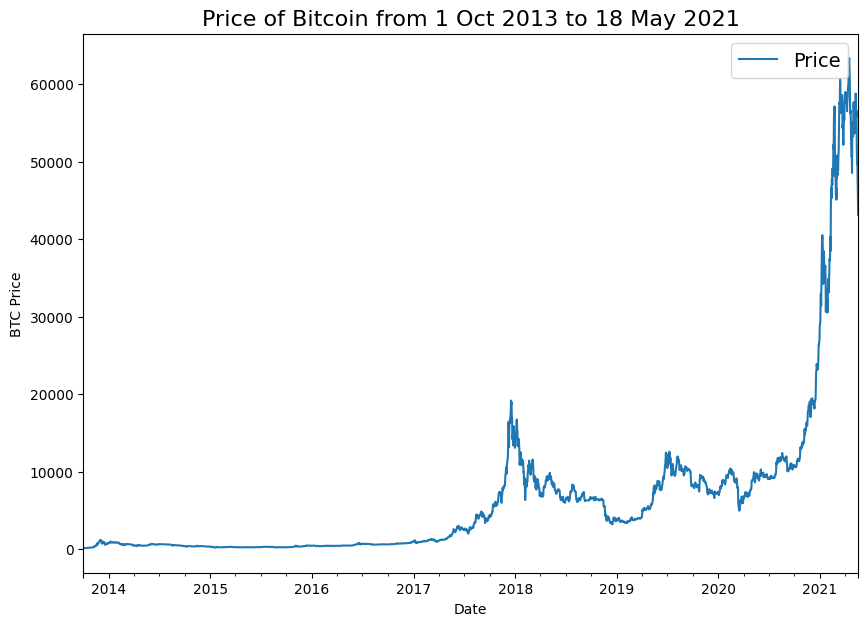

In [ ]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize = (10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Importing time series data with Python's CSV module

In [ ]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter = ",")
  next(csv_reader) # Skip the first line (this gets rid of column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

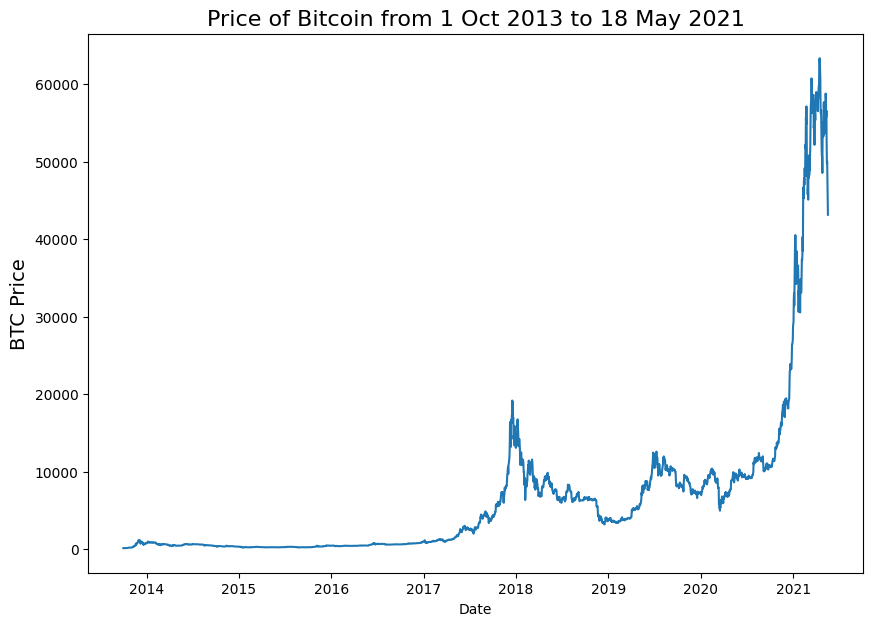

In [ ]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price", fontsize=14)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date");

## Format data part 1: Create train and test sets of our time series data

### Creating training and test sets with time series data (the wrong way)

In [ ]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [ ]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # BTC prices
                                                    test_size = 0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

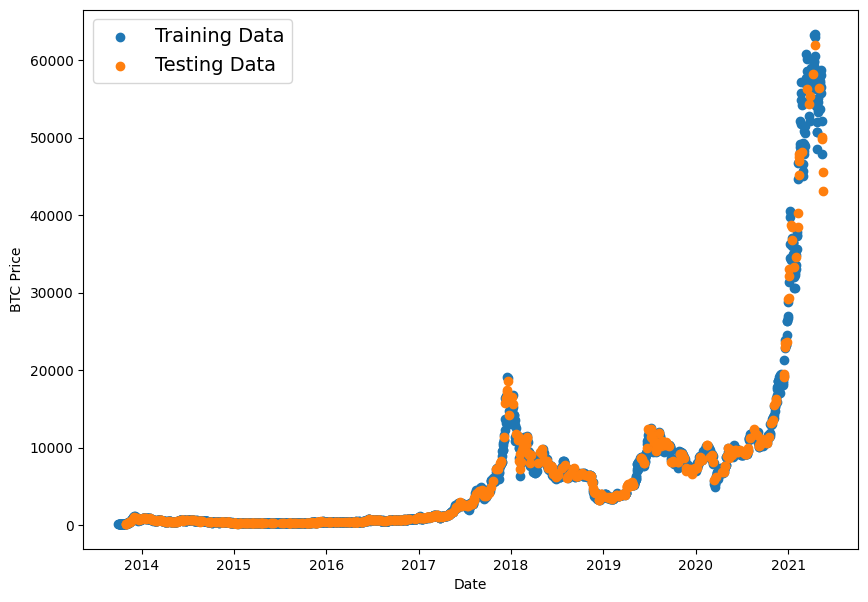

In [ ]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, label="Training Data")
plt.scatter(X_test, y_test, label="Testing Data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create train and test sets for time series (the right way)

In [ ]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test - we can change these values as needed, e.g. 90/10, 95/5

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2229, 2229, 558, 558)

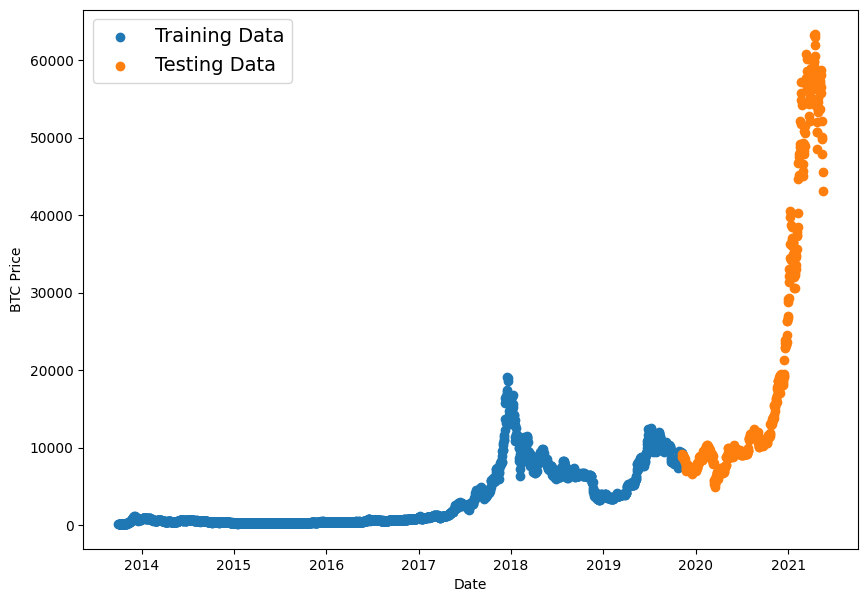

In [ ]:
# Plot correctly made splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, label="Training Data")
plt.scatter(X_test, y_test, label="Testing Data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Create a plotting fucntion

Typing plotting code is tedious, let's functionize it.

In [ ]:
# Create a function to plot time series data
def plot_time_series(timesteps,
                     values,
                     format=".",
                     start=0,
                     end=None,
                     label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ----------
  timesteps : array of timesteps values
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (similar to start but for the end)
  label : label to show on plot about values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)  # make label bigger
  plt.grid(True)

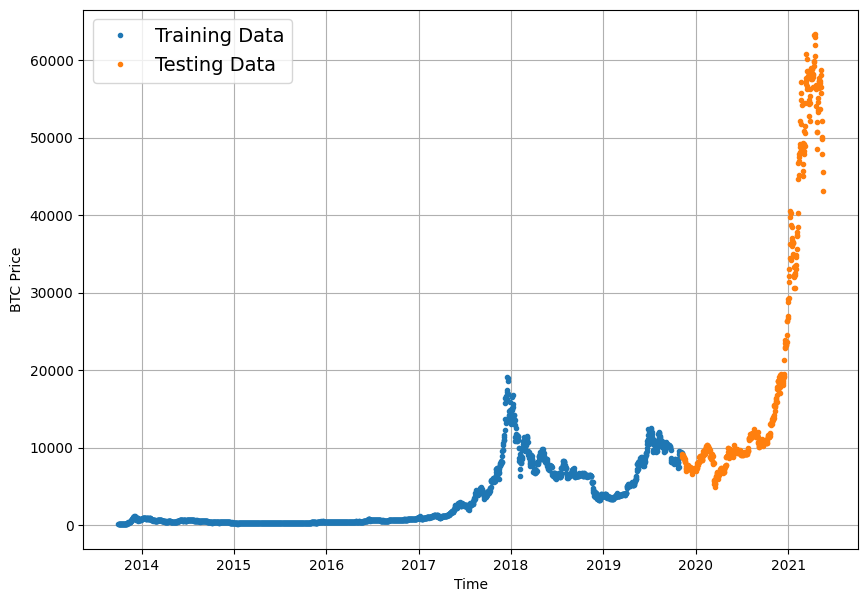

In [ ]:
# Test out plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Training Data")
plot_time_series(timesteps=X_test, values=y_test, label="Testing Data")

## Modelling experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window** = number of timesteps we're going to use to predict the **horizon**

Modelling experiments we're running :
* 0	Naïve model (baseline)
* 1	Dense model, horizon = 1 , window = 7
* 2	Same as 1, horizon = 1, window = 30
* 3	Same as 1, horizon = 7, window = 30
* 4	Conv1D, horizon = 1, window = 7
* 5	LSTM, horizon = 1, window = 7
* 6	Same as 1, but with multivariate data
* 7	N-BEATs Algorithm, horizon = 1, window = 7
* 8	Ensemble (multiple models optimized on different loss functions)
* 9	Future prediction model (model to predict future values)
* 10	Same as 1, but with turkey 🦃 data introduced

## Model 0 : Naive forecast (baseline)

The formula looks like :

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [ ]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

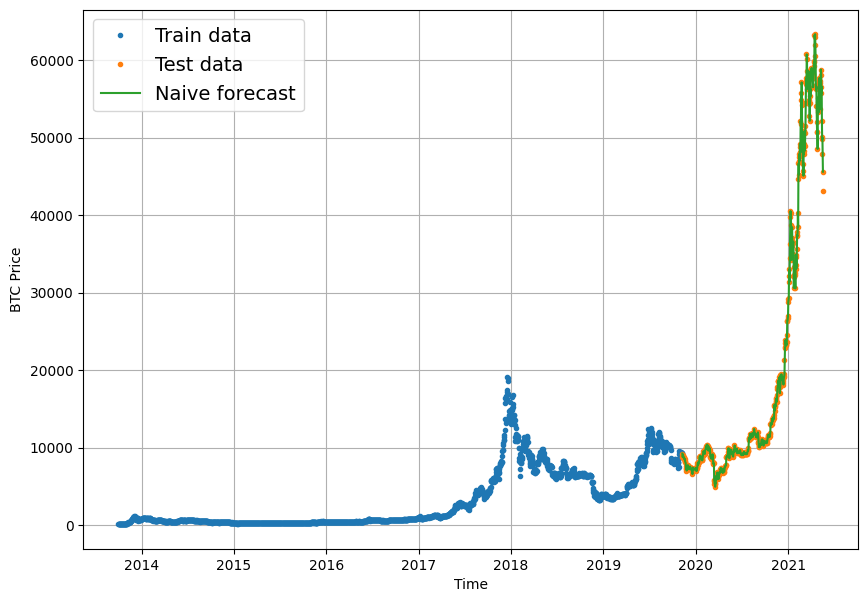

In [ ]:
# Plot naive forecast
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast")

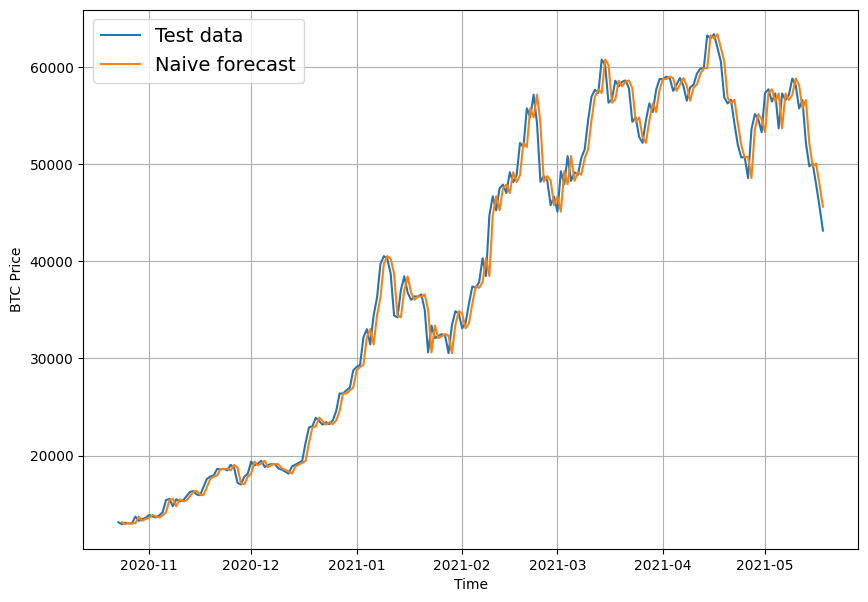

In [ ]:
# Zooming in on the naive forecast
plt.figure(figsize=(10,7))
# plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, start=350, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=350, format="-", label="Naive forecast")

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

What are we doing ?

We're predicting a number , so that means we have a form of regression problem.

Because we are working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time-series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean squared error
* MAPE - mean absolute percentage error
* MASE - mean absolute scaled error

For all of the above metrics, **lower is better**, for example, an MAE of 0 is better than an MAE of 100.

The main thing we are evaluating here is : **how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values) ?**

In [ ]:
import tensorflow as tf

In [ ]:
# MASE Implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data)
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season

In [ ]:
mean_absolute_scaled_error(y_test[1:], naive_forecast).numpy()

0.9995699939182624

In [ ]:
# Create a function to take in model's prediction and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.losses.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.losses.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.losses.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

That's one good looking evaluation function!

Let's now see if it works...

In [ ]:
naive_results = evaluate_preds(y_test[1:], naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

In [ ]:
naive_forecast[-10:]

array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
       56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
       47885.62525472, 45604.61575361])

In [ ]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=20056.632963737226>

## Other models we can use for baselines and for actual forecasts

In this notebook, we're focussed on TensorFlow and deep learning models.

However there are plenty of other styles of time series forecasting models we may want to experience with :
https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts

## Format Data Part 2 : Windowing our dataset

Why do we window ?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0,1,2,3,4,5,6] -> [7]
[1,2,3,4,5,6,7] -> [8]
[2,3,4,5,6,7,8] -> [9]
```

In [ ]:
# What we want to do wth our Bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [ ]:
# Let's setup global variables for window and horizon size
HORIZON_SIZE = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make the prediction

In [ ]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon = 1
  Input: [0,1,2,3,4,5,6,7] -> Output: ([0,1,2,3,4,5,6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


We have got a way to label our windowed data.

However, this only works on a small scale.

We need a way to do the above across our entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage Numpy's array indexing.

Our function will :
1. Create a window step of specific window size (e.g. [0,1,2,3,4,5,6])
2. Use NumPy indexing to create a 2D_array of multiple window steps, for example:
```
[[0,1,2,3,4,5,6],
[1,2,3,4,5,6,7],
[2,3,4,5,6,7,8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon.

>**📖Resource**: The function we're about to create has been adapted from the following article: https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [ ]:
import numpy as np

# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON_SIZE, shift=1):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 because indexing starts at 0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size

  # 3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON_SIZE)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# View the first 3 windows/labels
for i in range (3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [ ]:
# View the last 3 windows/labels
for i in range (3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


🔑**Note:** There's a function which does similar to the above in tf.keras.preprocessing, an extension could be found here: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array

## Turning windows into training and test sets


In [ ]:
# Make the training and test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train and 20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [ ]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [ ]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON_SIZE-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically we want to compare each of our model's best performance against the other model's best performances.

For example if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

In [ ]:
import os
# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            monitor="val_loss", # watch the val loss
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best

## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model :
* A single dense layer with 128 hidden units
* An output layer with linear activation (no activation)
* Adam optimization and mae loss function
* Batch size of 128 (previously we've used 32)
* 100 epochs

Why these values ?
Just picked them up through experimentation.
                     
* **Hyperparameters** = values a machine learning practitioner can adjust themselves
* **Parameters** = values a model learns on its own

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(69)

# 1. Construct a model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON_SIZE, activation="linear") # linear activation is the same as having no optimization
], name="model_1_dense")

# 2. Compile the model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_1.name)])

Epoch 1/100
18/18 [==============================] - 5s 135ms/step - loss: 578.2587 - mae: 578.2587 - mse: 1346494.6250 - val_loss: 1146.8414 - val_mae: 1146.8414 - val_mse: 4168871.5000
Epoch 2/100
18/18 [==============================] - 2s 108ms/step - loss: 218.1346 - mae: 218.1346 - mse: 228415.4688 - val_loss: 1058.1006 - val_mae: 1058.1006 - val_mse: 3620366.2500
Epoch 3/100
18/18 [==============================] - 2s 145ms/step - loss: 184.5816 - mae: 184.5816 - mse: 180627.9062 - val_loss: 988.4697 - val_mae: 988.4697 - val_mse: 3095537.0000
Epoch 4/100
18/18 [==============================] - 4s 226ms/step - loss: 166.9299 - mae: 166.9299 - mse: 151762.5469 - val_loss: 901.9112 - val_mae: 901.9112 - val_mse: 2772571.7500
Epoch 5/100
18/18 [==============================] - 1s 86ms/step - loss: 158.7440 - mae: 158.7440 - mse: 136193.9844 - val_loss: 869.4899 - val_mae: 869.4899 - val_mse: 2462909.5000
Epoch 6/100
18/18 [==============================] - 2s 96ms/step - loss: 14

In [ ]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 610.8126 - mae: 610.8126 - mse: 1260383.7500


[610.8125610351562, 610.8125610351562, 1260383.75]

In [ ]:
# Load in the best performing model_1 and evaluate it on the test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 566.3537 - mae: 566.3537 - mse: 1150819.1250


[566.3536987304688, 566.3536987304688, 1150819.125]

## Making forecasts with a model (on the test dataset)

To make forecasts on the test dataset (note: they are not actual forecasts , they are pseudo forecasts because actual forecasts are into the future), let's write a function to:

1. Take in a trained model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the model's prediction

In [ ]:
def make_preds(model, input_data):
  """
  Uses a trained model to make predictions on input data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [ ]:
# Make predictions using model_1 on the test dataset
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8816.061 , 8755.041 , 9041.508 , 8750.068 , 8722.9795, 8748.527 ,
        8659.8545, 8501.255 , 8450.991 , 8522.834 ], dtype=float32)>)

In [ ]:
# Evaluate preds
model_1_results = evaluate_preds(tf.squeeze(test_labels), model_1_preds)
model_1_results

{'mae': 566.35376,
 'mse': 1150819.5,
 'rmse': 1072.7626,
 'mape': 2.5516717,
 'mase': 0.9949267}

In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

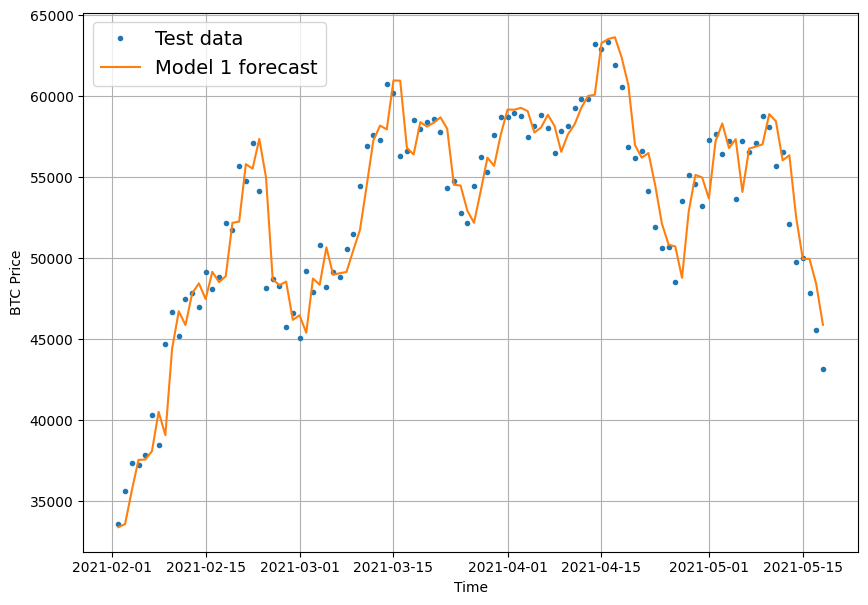

In [ ]:
# Let's plot our model 1 predictions
offset = 450
plt.figure(figsize=(10,7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="Model 1 forecast")

## Model 2: Dense (window = 30, horizon = 1)

In [ ]:
HORIZON_SIZE = 1 # predict one step at a time (one day of Bitcoin prices)
WINDOW_SIZE = 30 # use 30 timesteps in past

In [ ]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON_SIZE)
len(full_windows), len(full_labels)

(2757, 2757)

In [ ]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [ ]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
         160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
         175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 125.96116, 125.27966, 125.9275 , 126.38333, 135.24199,
         133.20333, 142.76333, 137.92333, 142.95166, 152.55183, 160.33883,
         164.31499, 177

In [ ]:
tf.random.set_seed(69)

# Create model
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON_SIZE, activation="linear")
], name="model_2_dense")

# Compile the model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_2.name)])

In [ ]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 604.7121


604.7120971679688

In [ ]:
# Load in the best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 604.7121


604.7120971679688

In [ ]:
# Get forecast predictions
model_2_preds = make_preds(model_2, test_windows)

18/18 [==============================] - 0s 2ms/step


In [ ]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(tf.squeeze(test_labels), model_2_preds)
model_2_results

{'mae': 604.7121,
 'mse': 1229219.4,
 'rmse': 1108.7017,
 'mape': 2.819347,
 'mase': 1.0570426}

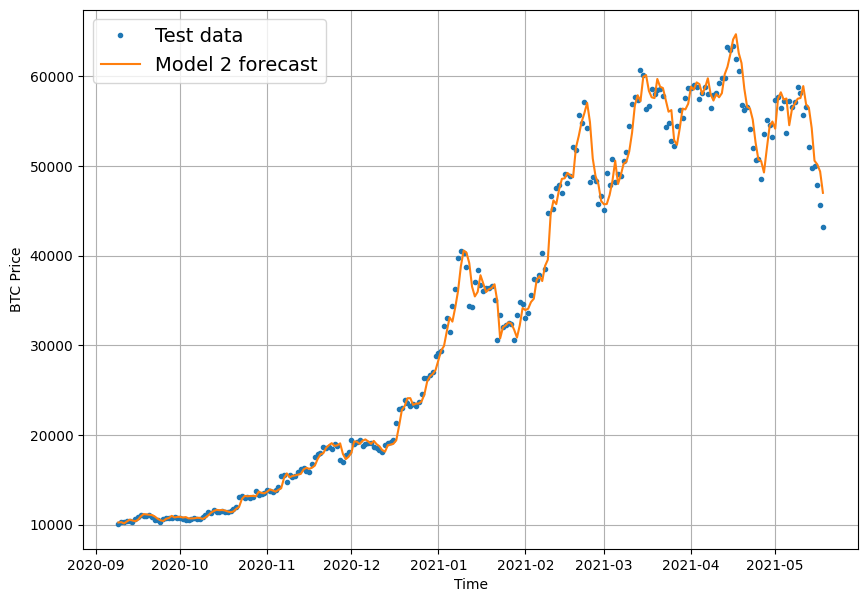

In [ ]:
offset = 300
plt.figure(figsize=(10,7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="Model 2 forecast")

## Model 3: Dense (window = 30, horizon = 7)

In [ ]:
HORIZON_SIZE = 7 # predict one week worth of bitcoin price at a time
WINDOW_SIZE = 30 # use 30 timesteps in past

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON_SIZE)
len(full_windows), len(full_labels)

(2751, 2751)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [ ]:
tf.random.set_seed(69)

# Create model (same as model_1 except with different data input and output sizes)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON_SIZE, activation="linear")
  ], name="model_3_dense")

# Compile the model
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_3.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_3.name)])

In [ ]:
# Evaluate our model
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1260.0251


1260.025146484375

In [ ]:
# Load in the best performing version of model 3
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1260.0251


1260.025146484375

In [ ]:
# Make predictions with our model 3
model_3_preds = make_preds(model_3, test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9509.841 , 9488.7705, 9459.672 , 9437.428 , 9310.835 , 9699.294 ,
        9240.942 ],
       [9093.522 , 8957.368 , 9253.232 , 9103.03  , 9167.238 , 9310.078 ,
        8765.704 ],
       [9058.405 , 8817.879 , 9083.04  , 9050.515 , 9091.442 , 9102.847 ,
        8810.149 ],
       [9304.36  , 9154.556 , 9213.098 , 9145.854 , 9318.794 , 9441.824 ,
        9207.51  ],
       [9047.108 , 9157.582 , 9217.646 , 8981.635 , 9072.886 , 9417.233 ,
        8999.209 ]], dtype=float32)>

In [ ]:
# Evaluate model_3 results
model_3_results = evaluate_preds(tf.squeeze(test_labels), model_3_preds)
model_3_results

{'mae': array([ 656.3253  ,  377.00293 ,  304.26157 ,  628.54755 ,  573.2665  ,
         533.55743 ,  543.52203 ,  627.408   ,  696.03357 ,  645.29895 ,
         838.1602  ,  823.32214 ,  891.6509  ,  870.0063  ,  606.25104 ,
         310.09995 ,  203.91971 ,  270.59604 ,  301.40375 ,  259.27567 ,
         131.54088 ,  186.75768 ,  374.82233 ,  382.01117 ,  346.3897  ,
         143.98904 ,  149.12961 ,  128.89851 ,  128.17432 ,  179.17941 ,
         275.06152 ,  410.44916 ,  367.70355 ,  410.62326 ,  366.5683  ,
         308.66525 ,  335.98306 ,  352.2883  ,  223.10498 ,  203.42844 ,
         392.62592 ,  103.148506,  104.91923 ,  129.15465 ,  115.32784 ,
         172.47949 ,  128.28586 ,  142.34055 ,  148.4509  ,  112.50872 ,
         145.09612 ,  143.122   ,  258.2417  ,  265.48236 ,  264.30923 ,
         342.29443 ,  475.96365 ,  442.98068 ,  460.5134  ,  540.47723 ,
         344.63092 ,  220.93645 ,  281.82736 ,  347.15982 ,  390.76285 ,
         454.74155 ,  478.21988 ,  499.5752 

## Make our evaluation function work for larger horizons

In [ ]:
# Create a function to take in model's prediction and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.losses.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.losses.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.losses.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized-metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
# Get model_3 results aggregated to single value
model_3_results = evaluate_preds(tf.squeeze(test_labels), model_3_preds)
model_3_results

{'mae': 1260.0251,
 'mse': 5425721.5,
 'rmse': 1459.023,
 'mape': 5.7798805,
 'mase': 2.242144}

We've made and evaluated predictions with model 3 , let's visualize them now.

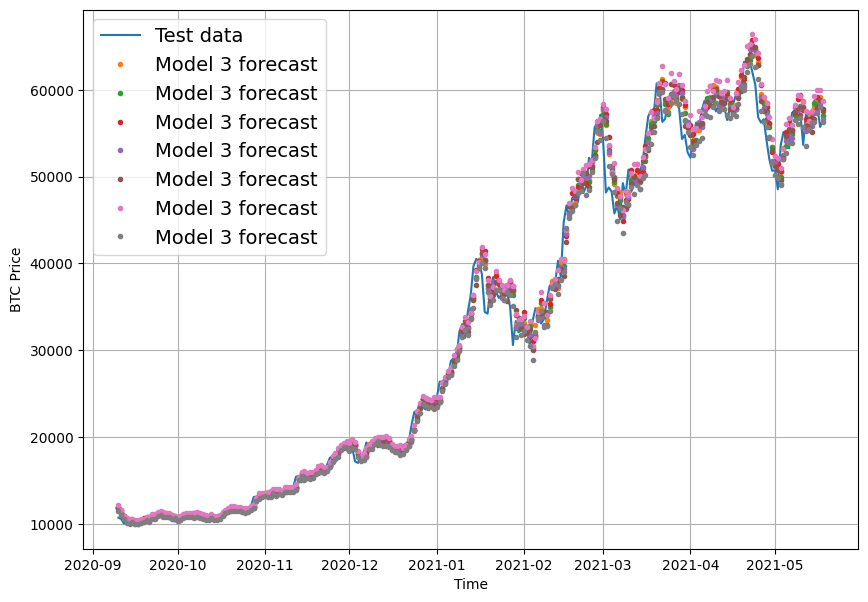

In [ ]:
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, format="-", label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="Model 3 forecast")

In the above plot , the price of Bitcoin for upcoming 7 days were predicted seperately so we had 7 different values as predictions (horizon) , but in the graph below we condensed the 7 values values into 1 approximate value (here, mean) so that it could be viewed like the previous models predictions graph.

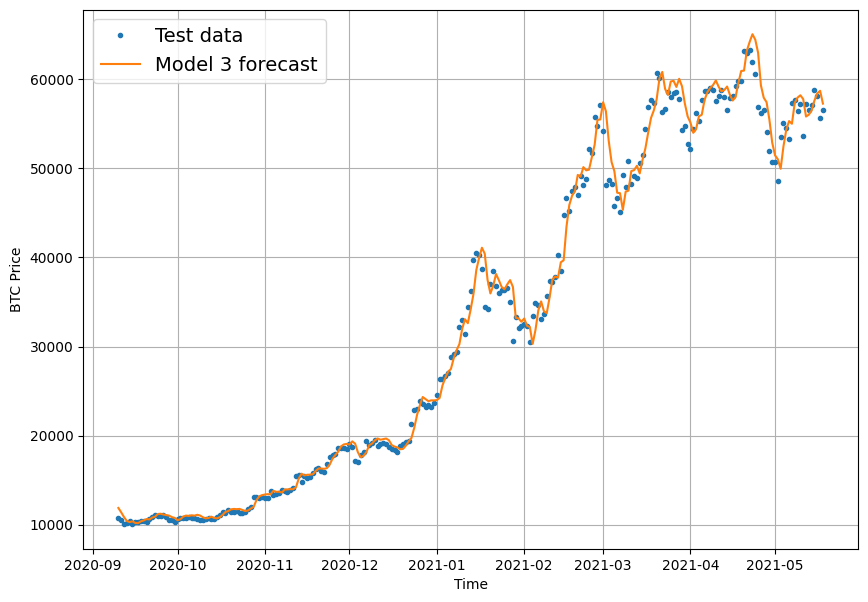

In [ ]:
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), start=offset, format="-", label="Model 3 forecast")

## Which of our models is performing the best so far ?

So we've trained a few models, now let's compare them and see how how they've gone...

<Axes: >

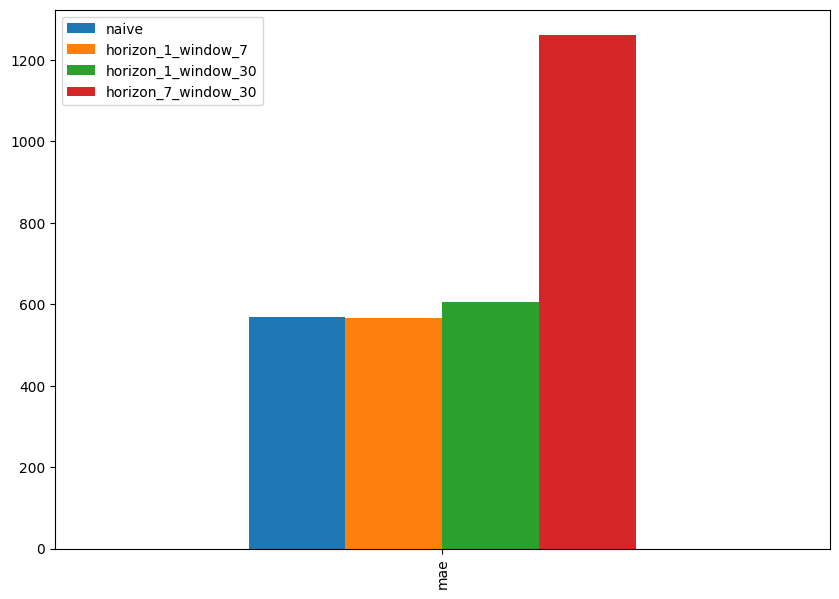

In [ ]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10,7), kind="bar")

>🔑**Note:** Time-Series data has a high rate of **autocorrelation** , which means the present value is highly correlated with the previous value , and the immediate future value (and others) will also be highly correlated with the present value.

Thus , as the naive model uses this correlation for predicting future values , it generally has a high accuracy rate for time-series problems, and is sometimes quite tough to beat with basic models like linear regression.

## Model 4 : Conv1D

In [ ]:
HORIZON_SIZE = 1 # predict next day worth of bitcoin price at a time
WINDOW_SIZE = 7 # use previous week worth of data

In [ ]:
# Create windowed Data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON_SIZE)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

To use the Conv1D layer, We need an input shape of:` (batch_size, timesteps, input_dim)`...

However our data isn't in that shape yet...

In [ ]:
# Check data input shape
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

In [ ]:
# Before we pass our data into the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [ ]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for input dim

In [ ]:
# Test out our Lambda layer
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # output = ...?
print(f"Original values with expanded shape:\n{expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
[[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [ ]:
tf.random.set_seed(69)

# Create a Conv1D model
model_4 = tf.keras.Sequential([
  expand_dims_layer,
  layers.Conv1D(filters=128, kernel_size= 5, strides=1, padding="causal", activation="relu"),
  layers.Dense(HORIZON_SIZE, activation="linear")
], name="model_4_conv1d")

# Compile the model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_4.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_4.name)])

In [ ]:
model_4.summary()

Model: "model_4_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4737 (18.50 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Evaluate model
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 626.4212


626.4212036132812

In [ ]:
# Load in the best performing Conv1D model and re-evaluate
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1d")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 585.2043


585.204345703125

In [ ]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([8942.468 , 8826.288 , 8972.897 , 8783.2705, 8780.858 ],
      dtype=float32)>

In [ ]:
# Evaluate predictions
model_4_results = evaluate_preds(tf.squeeze(test_labels), model_4_preds)
model_4_results

{'mae': 585.2044,
 'mse': 1225313.4,
 'rmse': 1106.9387,
 'mape': 2.6254234,
 'mase': 1.0280421}

## Model 5: RNN (LSTM)

Let's build a RNN model for our time series data.

We'll use the same data we created previously.

In [ ]:
tf.random.set_seed(69)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
# x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(HORIZON_SIZE)(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_lstm")

# Compile the model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_5.name)])

Epoch 1/100
18/18 [==============================] - 3s 117ms/step - loss: 2989.5095 - val_loss: 15096.5664
Epoch 2/100
18/18 [==============================] - 3s 190ms/step - loss: 1851.6163 - val_loss: 6979.5454
Epoch 3/100
18/18 [==============================] - 2s 103ms/step - loss: 509.4763 - val_loss: 1604.2607
Epoch 4/100
18/18 [==============================] - 2s 102ms/step - loss: 241.2253 - val_loss: 1318.8400
Epoch 5/100
18/18 [==============================] - 2s 102ms/step - loss: 189.2464 - val_loss: 1014.8527
Epoch 6/100
18/18 [==============================] - 2s 103ms/step - loss: 181.8495 - val_loss: 1006.0881
Epoch 7/100
18/18 [==============================] - 0s 8ms/step - loss: 180.0724 - val_loss: 1018.3273
Epoch 8/100
18/18 [==============================] - 2s 103ms/step - loss: 179.0830 - val_loss: 996.3998
Epoch 9/100
18/18 [==============================] - 0s 8ms/step - loss: 177.8212 - val_loss: 1000.2280
Epoch 10/100
18/18 [============================

In [ ]:
# Load in the best version of model_5 and evaluate the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 590.5988


590.5987548828125

In [ ]:
# Make predictions wih our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8970.899, 8834.419, 8987.115, 8807.341, 8776.581], dtype=float32)>

In [ ]:
# Evaluate model_5 predictions
model_5_results = evaluate_preds(tf.squeeze(test_labels), model_5_preds)
model_5_results

{'mae': 590.59875,
 'mse': 1249168.5,
 'rmse': 1117.6621,
 'mape': 2.6570027,
 'mase': 1.0375184}

In [ ]:
model_1_results

{'mae': 566.35376,
 'mse': 1150819.5,
 'rmse': 1072.7626,
 'mape': 2.5516717,
 'mase': 0.9949267}

🔑**Note:** Because neural networks are such powerful algorithms, they can be used for almost any problem, however, that doesn't mean they'll always achieve performant or usable results.

## Make a multivariate time series dataset

Before we add feature to our time series , what is a feature we can use ?

One feature we could add is whether or not Elon Musk tweeted on that day...

* day 1 - 0
* day 2 - 1
* day 3 - 0

What's a better feature to use ?

How about the Bitcoin halving events ?

https://www.cmcmarkets.com/en-nz/learn-cryptocurrencies/bitcoin-halving

In [ ]:
# Let's make a multivariate time series
bitcoin_prices.head()

Price
Date                 
2013-10-01  123.65499
2013-10-02  125.45500
2013-10-03  108.58483
2013-10-04  118.67466
2013-10-05  121.33866

In [ ]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009 - this block reward isn't in our dataset (our data starts from 01 October 2013)
block_reward_2 = 25 # 8 Novembver 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-08")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [ ]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [ ]:
# Add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature vector
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

<Axes: xlabel='Date'>

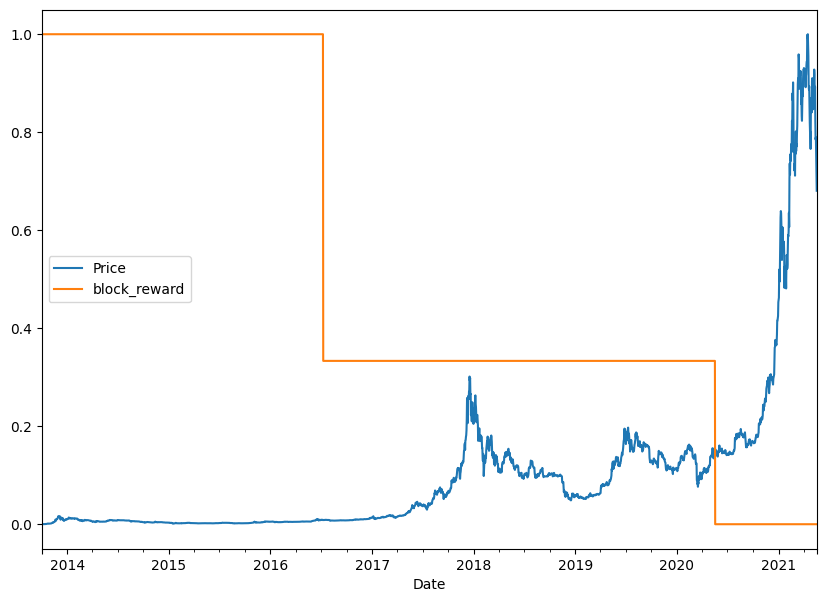

In [ ]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                                                       columns=bitcoin_prices_block.columns,
                                                                       index = bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10,7))

## Making a windowed dataset

Previously we've turned our univariate time series into windowed dataset using the helper functions above.

However, since we've got multivariate data, these functions won't work.

Not to worry, we've got a cool method with pandas.DataFrame.shift() to window our multivariate data.

In [ ]:
# Setup dataset hyperparameters
WINDOW_SIZE = 7
HORIZON_SIZE = 1

In [ ]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

Price block_reward    Price+1    Price+2    Price+3  \
Date                                                                  
2013-10-01  123.65499           25        NaN        NaN        NaN   
2013-10-02  125.45500           25  123.65499        NaN        NaN   
2013-10-03  108.58483           25  125.45500  123.65499        NaN   
2013-10-04  118.67466           25  108.58483  125.45500  123.65499   
2013-10-05  121.33866           25  118.67466  108.58483  125.45500   
2013-10-06  120.65533           25  121.33866  118.67466  108.58483   
2013-10-07  121.79500           25  120.65533  121.33866  118.67466   
2013-10-08  123.03300           25  121.79500  120.65533  121.33866   
2013-10-09  124.04900           25  123.03300  121.79500  120.65533   
2013-10-10  125.96116           25  124.04900  123.03300  121.79500   

              Price+4    Price+5    Price+6    Price+7  
Date                                                    
2013-10-01        NaN        NaN        NaN        NaN  
2013-10-02        NaN        NaN        NaN        NaN  
2013-10-03        NaN        NaN        NaN        NaN  
2013-10-04        NaN        NaN        NaN        NaN  
2013-10-05  123.65499        NaN        NaN        NaN  
2013-10-06  125.45500  123.65499        NaN        NaN  
2013-10-07  108.58483  125.45500  123.65499        NaN  
2013-10-08  118.67466  108.58483  125.45500  123.65499  
2013-10-09  121.33866  118.67466  108.58483  125.45500  
2013-10-10  120.65533  121.33866  118.67466  108.58483

What we've done is created a way to window our dataset directly from a pandas dataframe.

```
[0,1,2,3,4,5,6,block_reward]-> [7]
[1,2,3,4,5,6,7,block_reward]-> [8]
[2,3,4,5,6,7,8,block_reward]-> [9]
```

In [ ]:
# Create X (windows) and y (horizons) features
X = bitcoin_prices_windowed.drop("Price", axis=1).dropna().astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

block_reward     Price+1     Price+2     Price+3     Price+4  \
Date                                                                       
2013-10-08          25.0  121.794998  120.655327  121.338661  118.674660   
2013-10-09          25.0  123.032997  121.794998  120.655327  121.338661   
2013-10-10          25.0  124.049004  123.032997  121.794998  120.655327   
2013-10-11          25.0  125.961159  124.049004  123.032997  121.794998   
2013-10-12          25.0  125.279663  125.961159  124.049004  123.032997   

               Price+5     Price+6     Price+7  
Date                                            
2013-10-08  108.584831  125.455002  123.654991  
2013-10-09  118.674660  108.584831  125.455002  
2013-10-10  121.338661  118.674660  108.584831  
2013-10-11  120.655327  121.338661  118.674660  
2013-10-12  121.794998  120.655327  121.338661

In [ ]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6 : Dense (multivariate times series)

In [ ]:
tf.random.set_seed(69)

# Make a multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON_SIZE)
], name="model_6_dense_multivariate")

# Compile the model
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_6.fit(X_train,
            y_train,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_6.name)])

Epoch 1/100
18/18 [==============================] - 1s 36ms/step - loss: 1423.7930 - val_loss: 1876.1837
Epoch 2/100
18/18 [==============================] - 0s 28ms/step - loss: 326.0491 - val_loss: 1706.0620
Epoch 3/100
18/18 [==============================] - 0s 26ms/step - loss: 202.3779 - val_loss: 1192.6194
Epoch 4/100
18/18 [==============================] - 0s 26ms/step - loss: 180.4406 - val_loss: 1062.0142
Epoch 5/100
18/18 [==============================] - 0s 28ms/step - loss: 169.5081 - val_loss: 936.8438
Epoch 6/100
18/18 [==============================] - 0s 26ms/step - loss: 160.5026 - val_loss: 891.0848
Epoch 7/100
18/18 [==============================] - 0s 28ms/step - loss: 152.8194 - val_loss: 886.6995
Epoch 8/100
18/18 [==============================] - 0s 5ms/step - loss: 149.0351 - val_loss: 893.7305
Epoch 9/100
18/18 [==============================] - 0s 27ms/step - loss: 149.1179 - val_loss: 836.1844
Epoch 10/100
18/18 [==============================] - 0s 27m

In [ ]:
# Evaluate our maultivariate model
model_6.evaluate(X_test, y_test)

In [ ]:
# Load in and evaluate our best performing model
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

In [ ]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:5]

In [ ]:
# Evaluate predictions to get eval metrics
model_6_results = evaluate_preds(y_test, model_6_preds)
model_6_results

## Model 7: N-BEATS algorithm

Let's now try to build the biggest, baddest (though maybe not the baddest as it may perform really well...) time series forecasting model we've built so far.

More specifically, we're going to be replicating the algorithm in Figure 1 from the following paper: https://arxiv.org/abs/1905.10437

Why ?

* This will allow us to practice replicating a paper with TensorFlow code
* We'll see how to use TensorFlow layers subclassing (to make our own custom layers)
* Get experience using the Functional API to create a custom architecture
* Potentially get state of the art results for our problem.

### Building and testing the N-BEATS block layer

Because the N-BEATS block layer doesn't exist in TensorFlow, we've got to create it.

To create custom layers and models in TensorFlow we can use subclassing.

In [ ]:
# Create NBeatBlock custom layer
class NBeatBlock(tf.keras.layers.Layer):
  def __init__(self,
                 input_size: int,
                 theta_size: int,
                 horizon: int,
                 n_neurons: int,
                 n_layers: int,
                 **kwargs): # the **kwargs argument takes care of all the arguments for the parent class (eg: input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers , each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and the forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

Let's check our NBeatsBlock class.

To do we'll make some dummy inputs and outputs.

In [ ]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
tf.random.set_seed(69)
dummy_n_beats_block_layer = NBeatBlock(input_size=WINDOW_SIZE,
                                        theta_size=WINDOW_SIZE+HORIZON_SIZE, # backcast + forecast
                                        horizon=HORIZON_SIZE,
                                        n_neurons=128,
                                        n_layers=4)

In [ ]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect dense layer model requirements
dummy_inputs

In [ ]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_n_beats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

### Preparing data for the N-BEATS algorithm using `tf.data`

To make our input data load as fast as possible we're going to be adhering to the performant data pipeline steps in the tf.data guide: https://www.tensorflow.org/guide/data_performance

In [ ]:
HORIZON_SIZE = 1
WINDOW_SIZE = 7

In [ ]:
# Create N-BEATS data inputs (N-BEATS works with univariate time series)
bitcoin_prices.head()

Price
Date                 
2013-10-01  123.65499
2013-10-02  125.45500
2013-10-03  108.58483
2013-10-04  118.67466
2013-10-05  121.33866

In [ ]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head()

In [ ]:
# Make features and labels
X = bitcoin_prices_nbeats.drop("Price", axis=1).dropna()
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

### Creating performant datasets

In [ ]:
# Time to make our datasets performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
train_dataset = train_dataset.batch(1024).prefetch(tf.data.AUTOTUNE) # We are using batch_size of 1024 here , because it is taken from the paper
test_dataset = test_dataset.batch(1024).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

The N-BEATS algorithm has a fair few number of parameters, many of them can be found in table 18 of the paper.

In [ ]:
# Values for N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON_SIZE
THETA_SIZE = INPUT_SIZE + HORIZON_SIZE

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Before we can craft our N-BEATS model, we need two layers for the residual connections (subtract and add).

The N-BEATS algorithm uses double residual stacking to help train its deeper architecture (section 3.2 of N-BEATS paper).

For more on residual connections , we could check Wikipedia & paperswithcode website.

In [ ]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract layer
sub_layer = layers.subtract([tensor_1, tensor_2])

# Add layer
add_layer = layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {sub_layer.numpy()}")
print(f"Added: {add_layer.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fitting the N-BEATS algorithm

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack ( we'll be using the Keras Functional API)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use for loop to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop in (4) to create blocks which return backcasts and block-level forecasts
6. Create double residual stacking using add and subtract layers
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use mae to keep it inline with other models) and Adam optimizer with default setting as per section 5.2 of the N-BEATS paper
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
    * Early Stopping - because the model will be training for so long, we'll stop it early if it stops improving
    * Reduce LR on Plateau - if a model stops improving, try lowering the learning rate to reduce the amount it updates its weights each time (take smaller steps towards best performance)

In [ ]:
%%time

tf.random.set_seed(69)

# 1. Setup an instance for NBeatBlock
nbeats_block_layer = NBeatBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON_SIZE,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="initial_block")

# 2. Create an input layer for the N-BEATS stack
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Make the initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Use for loop to create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already created in step 3 , so we are for looping for N_STACKS - 1 times , i.e. 29 times

  # 5. Use the NBeatsBlock to calculate the backcasts and the forecasts
  backcast, block_forecast = NBeatBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON_SIZE,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatBlock_{i}"
  )(residuals)

  # 6. Create double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the model inputs and outputs together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_nbeats")

# 8. Compile the model
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            patience=100,
                                                            verbose=1)])

KeyboardInterrupt: 

In [ ]:
# Evaluate the N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

In [ ]:
# Make predictions with the N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:5]

In [ ]:
# Evaluate N-BEATS model preds
model_7_results = evaluate_preds(y_test, model_7_preds)
model_7_results

{'mae': 19856.182,
 'mse': 694070900.0,
 'rmse': 26345.227,
 'mape': 98.8423,
 'mase': 34.881813}

{'mae': 19856.182,
 'mse': 694070900.0,
 'rmse': 26345.227,
 'mape': 98.8423,
 'mase': 34.881813}

Woah... even with all those special layers and hand-crafted network, it looks like the N-BEATS model doesn't perform as well as `model_1` or the original naive forecast.

This goes to show the power of smaller networks as well as the fact that not all larger models are better suited for a certain type of data.

### Plotting the N-BEATS architecture we've created

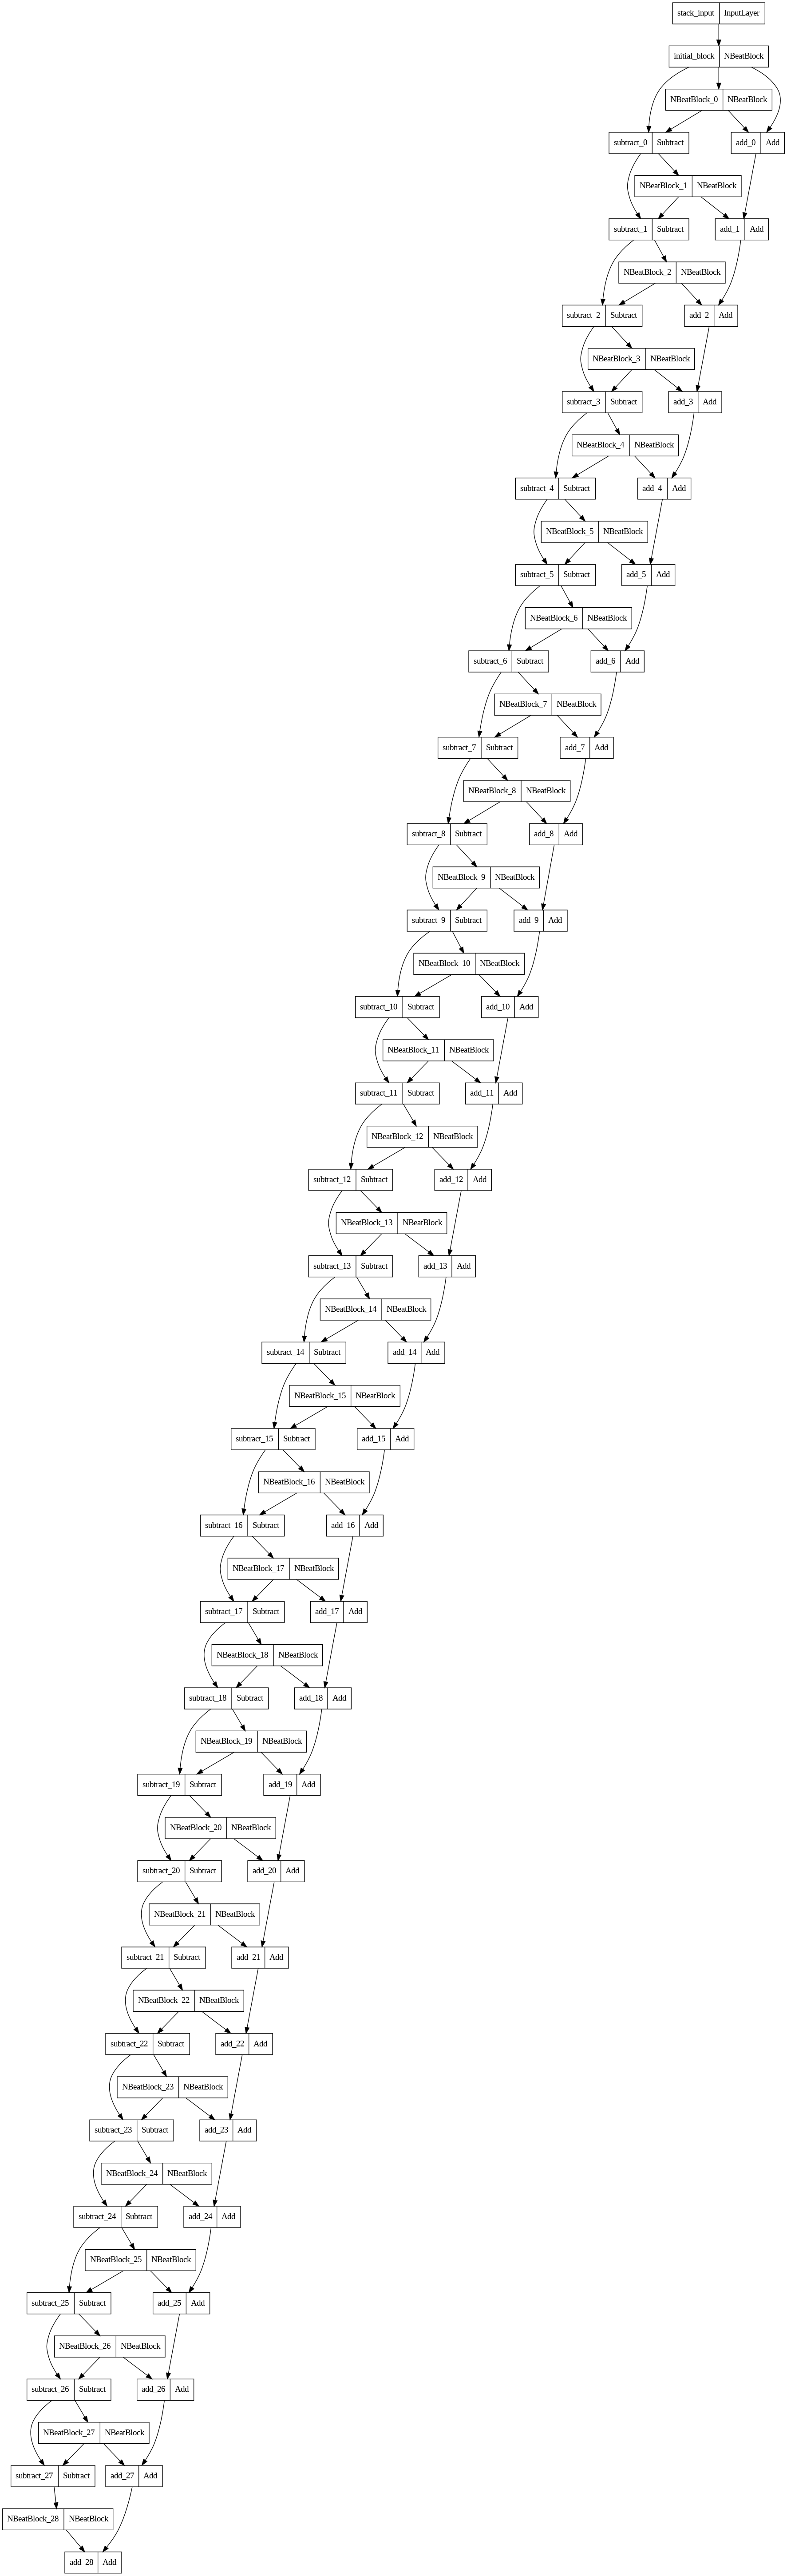

In [ ]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8 : Creating an ensemble (stacking different models together)

An ensemble leverages the wisdom of the crowd effect.

It combines many different models to predict a common goal.

In [ ]:
### Constructing and fitting an ensemble of models (using different loss functions)
def get_ensemble_models(horizon=HORIZON_SIZE,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=["mae","mse","mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE & MAPE loss functions.

  For example, if num_iter = 10, a list of 30 trained models will be returned:
  10 * len(["mae","mse","mape"]) = 30.
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model_number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize dense layers with normal distribution for estimating prediction intervals later on
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON_SIZE)
      ])

      # Compile the model
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      # Fit the model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=1,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      # Append fitted model to the list of ensemble models
      ensemble_models.append(model)

  return ensemble_models

In [ ]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Streaming output truncated to the last 5000 lines.
Epoch 342/1000
3/3 [==============================] - 0s 17ms/step - loss: 181.9364 - mae: 181.9364 - mse: 144312.1094 - val_loss: 630.2601 - val_mae: 630.2601 - val_mse: 1367113.0000 - lr: 0.0010
Epoch 343/1000
3/3 [==============================] - 0s 15ms/step - loss: 195.8316 - mae: 195.8316 - mse: 138571.7500 - val_loss: 669.6138 - val_mae: 669.6138 - val_mse: 1413558.5000 - lr: 0.0010
Epoch 344/1000
3/3 [==============================] - 0s 17ms/step - loss: 184.4529 - mae: 184.4529 - mse: 147288.5000 - val_loss: 630.5932 - val_mae: 630.5932 - val_mse: 1368950.6250 - lr: 0.0010
Epoch 345/1000
3/3 [==============================] - 0s 15ms/step - loss: 196.8575 - mae: 196.8575 - mse: 139854.8438 - val_loss: 669.7906 - val_mae: 669.7906 - val_mse: 1414379.5000 - lr: 0.0010
Epoch 346/1000
3/3 [==============================] - 0s 16ms/step - loss: 186.3628 - mae: 186.3628 - mse: 149685.4062 - val_loss: 630.5167 - val_mae: 630.5167 -

KeyboardInterrupt: 

### Make predictions with our ensemble model

In [ ]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
# Create a list of ensemble predictions
%%time
ensemble_preds = make_ensemble_preds(ensemble_models, test_dataset)
ensemble_preds

NameError: name 'ensemble_models' is not defined

Our ensemble preds come out in multiple dimensions but to combine into **point predictions** we can leverage the mean and median of all the predictions.

In [ ]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[:10]

NameError: name 'ensemble_preds' is not defined

In [ ]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median[:10]

In [ ]:
# Evaluate our ensemble model predictions
ensemble_results = evaluate_preds(y_test, ensemble_preds)
ensemble_results

In [ ]:
# Evaluate our ensemble model predictions
ensemble_results = evaluate_preds(y_test, ensemble_mean)
ensemble_results

In [ ]:
# Evaluate our ensemble model predictions
ensemble_results = evaluate_preds(y_test, ensemble_median)
ensemble_results

### Plotting the prediction intervals (uncertainity estimates) of our ensemble

So far we've been making point predictions with our models.

E.g. horizon = 1, our model predicts tomorrow's price of Bitcoin will be $50,000USD

Wouldn't it be helpful if we know the range from where the prediction came?

Instead of 50,000 USD on the dot, how about 48,000 to 52,000 USD ?

One way to get the 95% confidence prediction intervals for a deep learning model is the bootstrap method :
1. Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble models)
2. Measure the standard deviation of the predictions
3. Multiply the standard deviation by 1.96 (assuming the distribution of the data is Gaussian/Normal, 95% of observations fall within 1.96 standard deviations of the mean)
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)

* Uber Engineering - uncertainty estimation with Neural Networks : https://www.uber.com/en-IN/blog/neural-networks-uncertainty-estimation/

In [ ]:
# Find the upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # Take the predictions from a number of randomly initialised models
  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96.
  interval = 1.96 * std

  # 4. Get the prediction intervals upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

In [ ]:
# Get the upper and lower bounds of the 95% prediction interval
lower, upper = get_upper_lower(ensemble_preds)
lower, upper

NameError: name 'ensemble_preds' is not defined

📖**Resource**: Many of the steps we've taken above has inspired/referenced from the Machine Learning Mastery blog post on

[Prediction intervals for deep learning neural networks](https://machinelearningmastery.com/prediction-intervals-for-deep-learning-neural-networks/)

In [ ]:
# Get the median/mean values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median for our ensemble preds along with the prediction intervals (where the predictions fall between)
offset = 500
plt.figure(figsize=(10,7))
plt.plot(X_test.index[offset:], y_test[offset:], "-", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
# To plot the upper and lower bounds, let's use fill between
plt.fill_between(X_test.index[offset:], lower[offset:], upper[offset:], alpha=0.3, label="Prediction Interval")
plt.legend(loc="upper left", fontsize=14);

So far all of our model predictions have been lagging behind the test data...

As is they're replicating what the naive model does and just predict the previous timestep as the next timestep.

>🔑**Note:** These prediction intervals are estimates themselves, and they've been created wih the assumption that our model's data is from a normal distribution.

## Aside: two types of uncertainty (coconut and subway)

Uncertainty estimates in machine learning seek out to qualitatively and quantitatively answer the questions:
1. What can my model know ? (with perfect data, what's possible for a model to learn?)
2. What doesn't my model know ? (what can a model never predict? Or would it be helpful if a model could tell you that when it's making a prediction, it doesn't actually know if it's right or not?)

There are two major types of uncertainty in machine learning we should know about:
* **Aleatoric uncertainty** - this type of uncertainty cannot be reduced and it is often referred to as "data" uncertainty or "subway" uncertainty
* **Epistemic uncertainty** - this type of uncertainty can be reduced and it is often referred to as "model" or "coconut" uncertainty

## Model 9: Train a model on the full historical data to make predictions into the future

So far all of our models have predicted on the test dataset, however this is only a pseudo future.

Let's now build a model which is capable of predicting into the future!

In [ ]:
bitcoin_prices_windowed.head()

Price block_reward    Price+1    Price+2    Price+3  \
Date                                                                  
2013-10-01  123.65499           25        NaN        NaN        NaN   
2013-10-02  125.45500           25  123.65499        NaN        NaN   
2013-10-03  108.58483           25  125.45500  123.65499        NaN   
2013-10-04  118.67466           25  108.58483  125.45500  123.65499   
2013-10-05  121.33866           25  118.67466  108.58483  125.45500   

              Price+4  Price+5  Price+6  Price+7  
Date                                              
2013-10-01        NaN      NaN      NaN      NaN  
2013-10-02        NaN      NaN      NaN      NaN  
2013-10-03        NaN      NaN      NaN      NaN  
2013-10-04        NaN      NaN      NaN      NaN  
2013-10-05  123.65499      NaN      NaN      NaN

In [ ]:
bitcoin_prices_windowed.tail()

Price block_reward       Price+1       Price+2  \
Date                                                                
2021-05-14  49764.132082         6.25  52147.821187  56573.555472   
2021-05-15  50032.693137         6.25  49764.132082  52147.821187   
2021-05-16  47885.625255         6.25  50032.693137  49764.132082   
2021-05-17  45604.615754         6.25  47885.625255  50032.693137   
2021-05-18  43144.471291         6.25  45604.615754  47885.625255   

                 Price+3       Price+4       Price+5       Price+6  \
Date                                                                 
2021-05-14  55715.546651  58102.191426  58788.209679  57107.120672   
2021-05-15  56573.555472  55715.546651  58102.191426  58788.209679   
2021-05-16  52147.821187  56573.555472  55715.546651  58102.191426   
2021-05-17  49764.132082  52147.821187  56573.555472  55715.546651   
2021-05-18  50032.693137  49764.132082  52147.821187  56573.555472   

                 Price+7  
Date                      
2021-05-14  56583.849879  
2021-05-15  57107.120672  
2021-05-16  58788.209679  
2021-05-17  58102.191426  
2021-05-18  55715.546651

In [ ]:
# Train model on entire data to make predictions for the next day
X_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()
# Get labels
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

len(X_all), len(y_all)

(2780, 2780)

In [ ]:
X_all[:5], y_all[:5]

(array([[121.795  , 120.65533, 121.33866, 118.67466, 108.58483, 125.455  ,
         123.65499],
        [123.033  , 121.795  , 120.65533, 121.33866, 118.67466, 108.58483,
         125.455  ],
        [124.049  , 123.033  , 121.795  , 120.65533, 121.33866, 118.67466,
         108.58483],
        [125.96116, 124.049  , 123.033  , 121.795  , 120.65533, 121.33866,
         118.67466],
        [125.27966, 125.96116, 124.049  , 123.033  , 121.795  , 120.65533,
         121.33866]]),
 array([123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ]))

In [ ]:
# Turn data into efficient running tensors
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
dataset_all = dataset_all.batch(1024).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
tf.random.set_seed(69)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON_SIZE)
])

# Compile the model
model_9.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model on all of the data to make future forecasts
model_9.fit(dataset_all,
             epochs=100,
             verbose=1)

Epoch 1/100
3/3 [==============================] - 1s 11ms/step - loss: 6305.9727
Epoch 2/100
3/3 [==============================] - 0s 8ms/step - loss: 4219.2036
Epoch 3/100
3/3 [==============================] - 0s 9ms/step - loss: 2224.9895
Epoch 4/100
3/3 [==============================] - 0s 10ms/step - loss: 479.9255
Epoch 5/100
3/3 [==============================] - 0s 8ms/step - loss: 1305.9736
Epoch 6/100
3/3 [==============================] - 0s 10ms/step - loss: 1581.1228
Epoch 7/100
3/3 [==============================] - 0s 9ms/step - loss: 1094.9005
Epoch 8/100
3/3 [==============================] - 0s 9ms/step - loss: 401.0043
Epoch 9/100
3/3 [==============================] - 0s 11ms/step - loss: 639.3138
Epoch 10/100
3/3 [==============================] - 0s 10ms/step - loss: 778.0135
Epoch 11/100
3/3 [==============================] - 0s 12ms/step - loss: 515.1628
Epoch 12/100
3/3 [==============================] - 0s 8ms/step - loss: 360.9488
Epoch 13/100
3/3 [=======

### Make predictions into future

In [ ]:
# How many timesteps to predict into the future ?
INTO_FUTURE = 14

To make predictions into the future we want a function which :    
1. Takes as input:
* A list of values (Bitcoin historical data)
* a trained model (such as `model_9`)
* a window into the future to predict (our `INTO_FUTURE` variable)
* the window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on
2. Creates an empty list for future forecasts (this will be returned at the end of the end when it's full of predictions) and extracts the last `WINDOW_SIZE` values from the input values.
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` sequences which update to remove the first value and append the latest predictions.

In [ ]:
# 1. Create function to make predictions into the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list :
  """
  Make future forecasts into_future steps after values ends.

  Returns future forecasts as a list of floats.
  """
  # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each
  for _ in range(INTO_FUTURE):
    # Predict on the last window then append it again, again, again (our model will eventually start to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [ ]:
# Make forecasts into the future
future_forecasts = make_future_forecasts(values=y_all,
                                         model=model_9,
                                         into_future=INTO_FUTURE,
                                         window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 74ms/step
Predicting on:
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55729.22265625

1/1 [==============================] - 0s 25ms/step
Predicting on:
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55729.22265625] -> Prediction: 52186.375

1/1 [==============================] - 0s 24ms/step
Predicting on:
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55729.22265625 52186.375     ] -> Prediction: 50268.01953125

1/1 [==============================] - 0s 26ms/step
Predicting on:
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55729.22265625 52186.375      50268.01953125] -> Prediction: 49293.33203125

1/1 [==============================] - 0s 32ms/step
Predicting on:
 [47885.62525472 45604.61575361 43144.47129086 55729.22265625
 52186.375      50268.01953125 49293.33203125] -

### Plot future forecasts

In [ ]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns an array of datetime values ranging from start_date to start_date+into_future
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date , "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start and end date

In [ ]:
# Last timestep of timesteps (currently np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [ ]:
# Get next two week of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [ ]:
# Insert last timestep/final price into next time steps and future forecasts so that the plot doesn't look janky
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecasts, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55753.402, 52210.13 , 48709.277, 48054.656, 47499.535,
        45923.68 , 47699.984, 54846.24 , 51033.26 , 47322.83 , 47209.355,
        47657.84 , 47402.49 , 50234.316], dtype=float32))

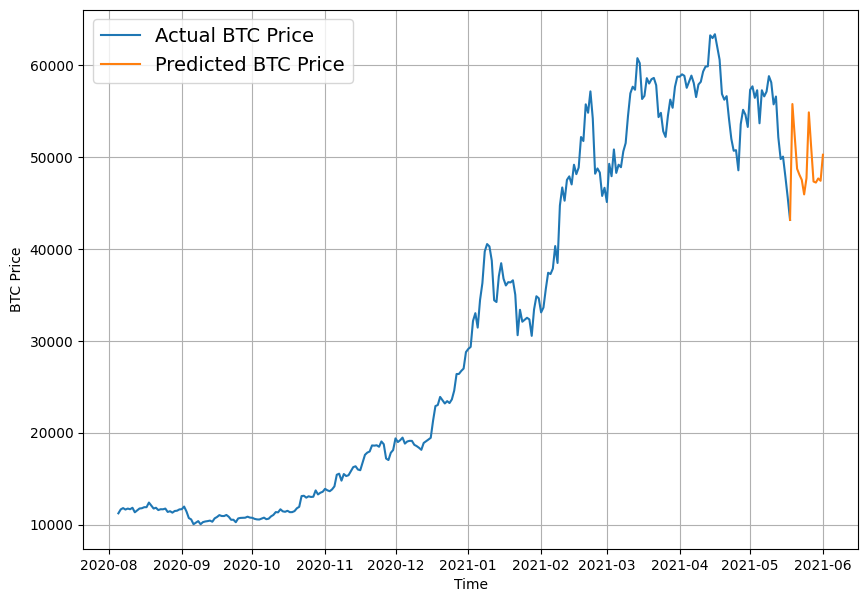

In [ ]:
# Plot future prices predictions of Bitcoin
plt.figure(figsize=(10,7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

## Model 10: Why forecasting is BS (the turkey problem 🦃)

In [ ]:
# Let's introduce a turkey prolbme to our BTC data (price of BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [ ]:
# Manufacture an extra price on the end (to showcase our Turkey problem)
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

In [ ]:
# Get the timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

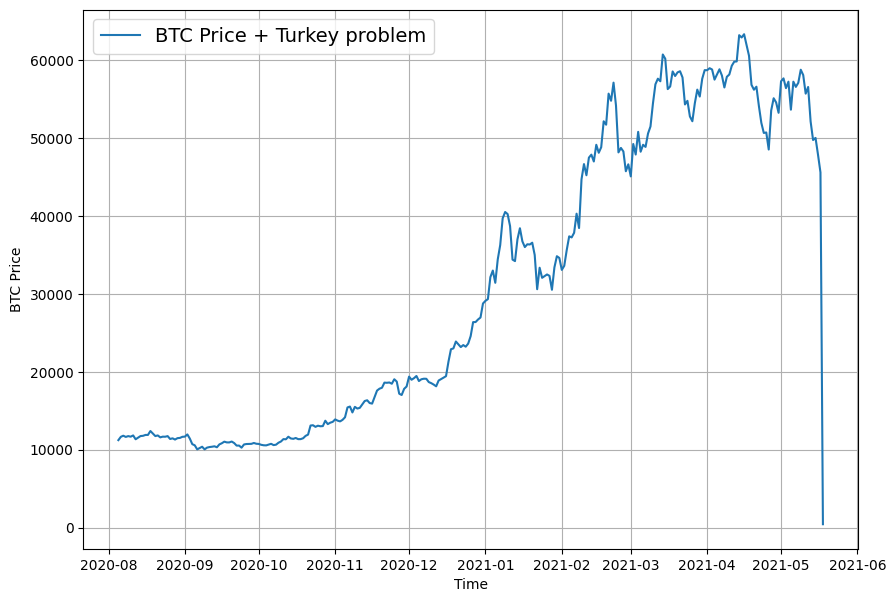

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format="-",
                 label="BTC Price + Turkey problem",
                 start=2500
                 )

In [ ]:
# Create train and test sets for the turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON_SIZE)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

### Build a turkey model (model to predict on turkey data)

In [ ]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "model_10_turkey_model"
turkey_model.compile(loss="mae",
                     optimizer="Adam")
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=1,
                 batch_size=128,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

Epoch 1/100
18/18 [==============================] - 2s 56ms/step - loss: 684.0491 - val_loss: 1360.6356
Epoch 2/100
18/18 [==============================] - 1s 37ms/step - loss: 251.7243 - val_loss: 1353.6577
Epoch 3/100
18/18 [==============================] - 1s 36ms/step - loss: 210.7589 - val_loss: 1137.4183
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 189.6549 - val_loss: 1160.3153
Epoch 5/100
18/18 [==============================] - 1s 36ms/step - loss: 179.5258 - val_loss: 1049.9720
Epoch 6/100
18/18 [==============================] - 1s 36ms/step - loss: 173.8379 - val_loss: 1030.3619
Epoch 7/100
18/18 [==============================] - 1s 36ms/step - loss: 164.0735 - val_loss: 973.2142
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 157.6705 - val_loss: 1082.5675
Epoch 9/100
18/18 [==============================] - 1s 35ms/step - loss: 154.9381 - val_loss: 879.8915
Epoch 10/100
18/18 [==============================] - 1s 36

In [ ]:
# Evaluate model on test data
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 654.8307


654.8307495117188

In [ ]:
# Load best performing turkey model and evaluate on the test data
turkey_model = tf.keras.models.load_model("model_experiments/model_10_turkey_model")
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 648.3526


648.3526000976562

In [ ]:
# Make predictions with Turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8822.8545, 8766.077 , 9038.31  , 8747.342 , 8714.008 , 8756.286 ,
       8634.549 , 8509.864 , 8447.221 , 8513.805 ], dtype=float32)>

In [ ]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

{'mae': 17125.797,
 'mse': 614124200.0,
 'rmse': 23705.553,
 'mape': 121.29794,
 'mase': 26.502232}

By changing just one value, the `turkey_model` MAE increases almost 30x over `model_1`.

Finally, we'll visualize the turkey predictions over the test turkey data.

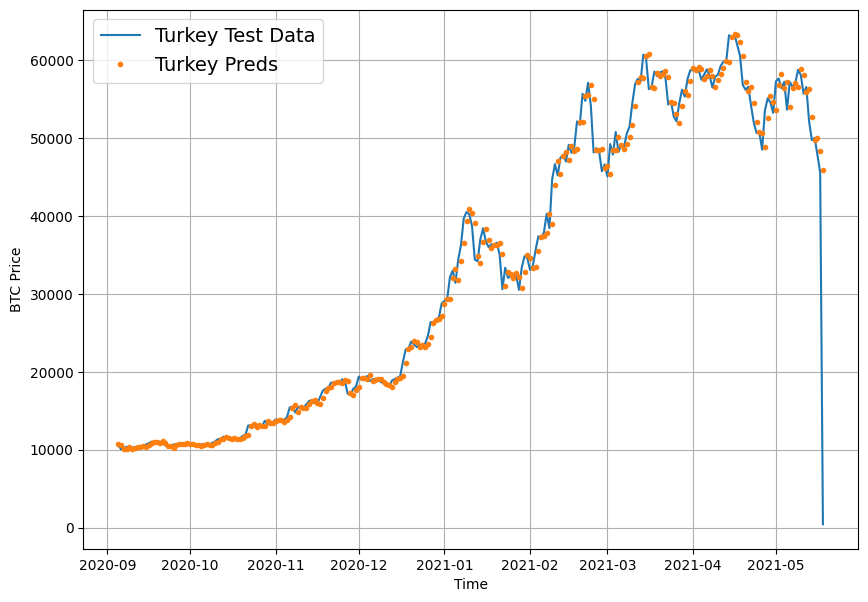

In [ ]:
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=btc_timesteps_turkey[:split_size], values=btc_price_turkey[:split_size], label="Train Data")
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):],
                 format="-",
                 label="Turkey Test Data", start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds,
                 label="Turkey Preds",
                 start=offset);

## Compare Models

We've trained a bunch of models.

And if anything, we've seen just how poorly machine learning and deep learning models are at forecasting the price of Bitcoin (or any kind of open market value).

To highlight this, let's compare the results of all of the modelling experiments we've performed so far

In [ ]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_8_NBEATs": model_7_results,
                              "model_9_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)

NameError: name 'ensemble_results' is not defined

In [ ]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");

## **TensorFlow Exercises** for Practice

### Query 1 : Checking performance of scaled data over univariate and multivariate series

In [ ]:
btc_mod = bitcoin_prices.copy()

In [ ]:
btc_mod.values

array([[  123.65499   ],
       [  125.455     ],
       [  108.58483   ],
       ...,
       [47885.62525472],
       [45604.61575361],
       [43144.47129086]])

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# prepare data for normalization
values = btc_mod.values
values = btc_mod.values.reshape((len(values), 1))
# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# normalize the dataset and print the rows
normalized = scaler.transform(values)
for i in range(len(values)):
 print(normalized[i])
# inverse transform and print the rows
inversed = scaler.inverse_transform(normalized)
for i in range(len(values)):
 print(inversed[i])

<ipython-input-194-fe3466b47491>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))


Streaming output truncated to the last 5000 lines.
[0.00187864]
[0.00184651]
[0.00185667]
[0.00202564]
[0.00198086]
[0.00201861]
[0.00208386]
[0.00200857]
[0.00200855]
[0.00192662]
[0.00203159]
[0.0021524]
[0.00210207]
[0.00206867]
[0.00207811]
[0.00209949]
[0.00200769]
[0.00203973]
[0.00202523]
[0.00202021]
[0.00201851]
[0.00197234]
[0.00196297]
[0.00198644]
[0.00201268]
[0.00208061]
[0.00207491]
[0.00209299]
[0.00204108]
[0.00203357]
[0.00204127]
[0.00203426]
[0.00201707]
[0.00197267]
[0.00193314]
[0.00181584]
[0.00186647]
[0.00184792]
[0.00182456]
[0.00182908]
[0.00185419]
[0.00182026]
[0.00189132]
[0.00190735]
[0.00191933]
[0.00191851]
[0.00193055]
[0.00196969]
[0.00199504]
[0.00203697]
[0.00221636]
[0.00219252]
[0.00222158]
[0.00209059]
[0.00214382]
[0.00215651]
[0.0021908]
[0.0021314]
[0.00209265]
[0.00211477]
[0.00211428]
[0.00224227]
[0.00222717]
[0.00236883]
[0.00242152]
[0.0023885]
[0.00232363]
[0.00229757]
[0.00241696]
[0.00251466]
[0.00255369]
[0.00246324]
[0.00251997]
[0.0

In [ ]:
values.min(), values.max()

(108.58483, 63346.7890351052)

In [ ]:
values = (values-values.min())/(values.max()-values.min())

In [ ]:
values.min(), values.max()

(0.0, 1.0)

In [ ]:
# Get bitcoin date array
timesteps = btc_mod.index.to_numpy()
prices = values

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([[0.00023831],
        [0.00026677],
        [0.        ],
        [0.00015955],
        [0.00020168],
        [0.00019087],
        [0.0002089 ],
        [0.00022847],
        [0.00024454],
        [0.00027478]]))

In [ ]:
full_windows, full_labels = make_windows(values, window_size=WINDOW_SIZE, horizon=HORIZON_SIZE)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# View the first 3 windows/labels
for i in range (3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [[0.00023831]
 [0.00026677]
 [0.        ]
 [0.00015955]
 [0.00020168]
 [0.00019087]
 [0.0002089 ]] -> Label: [[0.00022847]]
Window: [[0.00026677]
 [0.        ]
 [0.00015955]
 [0.00020168]
 [0.00019087]
 [0.0002089 ]
 [0.00022847]] -> Label: [[0.00024454]]
Window: [[0.        ]
 [0.00015955]
 [0.00020168]
 [0.00019087]
 [0.0002089 ]
 [0.00022847]
 [0.00024454]] -> Label: [[0.00027478]]


In [ ]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
train_windows[:5], train_labels[:5]

(array([[[0.00023831],
         [0.00026677],
         [0.        ],
         [0.00015955],
         [0.00020168],
         [0.00019087],
         [0.0002089 ]],
 
        [[0.00026677],
         [0.        ],
         [0.00015955],
         [0.00020168],
         [0.00019087],
         [0.0002089 ],
         [0.00022847]],
 
        [[0.        ],
         [0.00015955],
         [0.00020168],
         [0.00019087],
         [0.0002089 ],
         [0.00022847],
         [0.00024454]],
 
        [[0.00015955],
         [0.00020168],
         [0.00019087],
         [0.0002089 ],
         [0.00022847],
         [0.00024454],
         [0.00027478]],
 
        [[0.00020168],
         [0.00019087],
         [0.0002089 ],
         [0.00022847],
         [0.00024454],
         [0.00027478],
         [0.000264  ]]]),
 array([[[0.00022847]],
 
        [[0.00024454]],
 
        [[0.00027478]],
 
        [[0.000264  ]],
 
        [[0.00027424]]]))

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(69)

# 1. Construct a model
model_11 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON_SIZE, activation="linear") # linear activation is the same as having no optimization
], name="model_11_dense")

# 2. Compile the model
model_11.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_11.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_11.name)])

Epoch 1/100
18/18 [==============================] - 2s 66ms/step - loss: 0.0323 - mae: 0.0323 - mse: 0.0028 - val_loss: 0.1941 - val_mae: 0.1941 - val_mse: 0.0794
Epoch 2/100
18/18 [==============================] - 1s 46ms/step - loss: 0.0160 - mae: 0.0160 - mse: 7.3995e-04 - val_loss: 0.1159 - val_mae: 0.1159 - val_mse: 0.0328
Epoch 3/100
18/18 [==============================] - 1s 49ms/step - loss: 0.0070 - mae: 0.0070 - mse: 1.7120e-04 - val_loss: 0.0555 - val_mae: 0.0555 - val_mse: 0.0097
Epoch 4/100
18/18 [==============================] - 1s 47ms/step - loss: 0.0037 - mae: 0.0037 - mse: 6.4764e-05 - val_loss: 0.0377 - val_mae: 0.0377 - val_mse: 0.0049
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0035 - mae: 0.0035 - mse: 6.4287e-05 - val_loss: 0.0403 - val_mae: 0.0403 - val_mse: 0.0057
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0035 - mae: 0.0035 - mse: 6.3402e-05 - val_loss: 0.0409 - val_mae: 0.0409 - val_mse: 0.005

In [ ]:
model_11_preds = make_preds(model_11, test_windows)
len(model_11_preds), model_11_preds[:10]

18/18 [==============================] - 0s 4ms/step


(556,
 <tf.Tensor: shape=(10, 7), dtype=float32, numpy=
 array([[0.1432489 , 0.14194037, 0.14441326, 0.14377692, 0.14391229,
         0.14229634, 0.13590568],
        [0.14194037, 0.14441326, 0.14377692, 0.14391229, 0.14229634,
         0.13590568, 0.13596016],
        [0.14441326, 0.14377692, 0.14391229, 0.14229634, 0.13590568,
         0.13596016, 0.14014754],
        [0.14377692, 0.14391229, 0.14229634, 0.13590568, 0.13596016,
         0.14014754, 0.13468081],
        [0.14391229, 0.14229634, 0.13590568, 0.13596016, 0.14014754,
         0.13468081, 0.13541076],
        [0.14229634, 0.13590568, 0.13596016, 0.14014754, 0.13468081,
         0.13541076, 0.1352426 ],
        [0.13590568, 0.13596016, 0.14014754, 0.13468081, 0.13541076,
         0.1352426 , 0.13387388],
        [0.13596016, 0.14014754, 0.13468081, 0.13541076, 0.1352426 ,
         0.13387388, 0.131562  ],
        [0.14014754, 0.13468081, 0.13541076, 0.1352426 , 0.13387388,
         0.131562  , 0.13109787],
        [0.134680

In [ ]:
# Evaluate preds
model_11_results = evaluate_preds(test_labels, model_11_preds)
model_11_results

{'mae': 0.23745535,
 'mse': 0.117508315,
 'rmse': 0.23792608,
 'mape': 88.80004,
 'mase': 26.379389}

In [ ]:
btc_mod.head()

Price
Date                 
2013-10-01  123.65499
2013-10-02  125.45500
2013-10-03  108.58483
2013-10-04  118.67466
2013-10-05  121.33866

In [ ]:
btc_mod["Prices"] = values
btc_mod.head()

Price    Prices
Date                           
2013-10-01  123.65499  0.000238
2013-10-02  125.45500  0.000267
2013-10-03  108.58483  0.000000
2013-10-04  118.67466  0.000160
2013-10-05  121.33866  0.000202

In [ ]:
btc_mod = btc_mod.drop("Price", axis=1)
btc_mod.head()

Prices
Date                
2013-10-01  0.000238
2013-10-02  0.000267
2013-10-03  0.000000
2013-10-04  0.000160
2013-10-05  0.000202

In [ ]:
# Add in a block_reward column
bitcoin_prices_block = btc_mod.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature vector
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [ ]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Prices+{i+1}"] = bitcoin_prices_windowed["Prices"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

Prices block_reward  Prices+1  Prices+2  Prices+3  Prices+4  \
Date                                                                        
2013-10-01  0.000238           25       NaN       NaN       NaN       NaN   
2013-10-02  0.000267           25  0.000238       NaN       NaN       NaN   
2013-10-03  0.000000           25  0.000267  0.000238       NaN       NaN   
2013-10-04  0.000160           25  0.000000  0.000267  0.000238       NaN   
2013-10-05  0.000202           25  0.000160  0.000000  0.000267  0.000238   
2013-10-06  0.000191           25  0.000202  0.000160  0.000000  0.000267   
2013-10-07  0.000209           25  0.000191  0.000202  0.000160  0.000000   
2013-10-08  0.000228           25  0.000209  0.000191  0.000202  0.000160   
2013-10-09  0.000245           25  0.000228  0.000209  0.000191  0.000202   
2013-10-10  0.000275           25  0.000245  0.000228  0.000209  0.000191   

            Prices+5  Prices+6  Prices+7  
Date                                      
2013-10-01       NaN       NaN       NaN  
2013-10-02       NaN       NaN       NaN  
2013-10-03       NaN       NaN       NaN  
2013-10-04       NaN       NaN       NaN  
2013-10-05       NaN       NaN       NaN  
2013-10-06  0.000238       NaN       NaN  
2013-10-07  0.000267  0.000238       NaN  
2013-10-08  0.000000  0.000267  0.000238  
2013-10-09  0.000160  0.000000  0.000267  
2013-10-10  0.000202  0.000160  0.000000

In [ ]:
# Create X (windows) and y (horizons) features
X = bitcoin_prices_windowed.drop("Prices", axis=1).dropna().astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Prices"].astype(np.float32)
X.head()

block_reward  Prices+1  Prices+2  Prices+3  Prices+4  Prices+5  \
Date                                                                         
2013-10-08          25.0  0.000209  0.000191  0.000202  0.000160  0.000000   
2013-10-09          25.0  0.000228  0.000209  0.000191  0.000202  0.000160   
2013-10-10          25.0  0.000245  0.000228  0.000209  0.000191  0.000202   
2013-10-11          25.0  0.000275  0.000245  0.000228  0.000209  0.000191   
2013-10-12          25.0  0.000264  0.000275  0.000245  0.000228  0.000209   

            Prices+6  Prices+7  
Date                            
2013-10-08  0.000267  0.000238  
2013-10-09  0.000000  0.000267  
2013-10-10  0.000160  0.000000  
2013-10-11  0.000202  0.000160  
2013-10-12  0.000191  0.000202

In [ ]:
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [ ]:
X_train, y_train

(            block_reward  Prices+1  Prices+2  Prices+3  Prices+4  Prices+5  \
 Date                                                                         
 2013-10-08          25.0  0.000209  0.000191  0.000202  0.000160  0.000000   
 2013-10-09          25.0  0.000228  0.000209  0.000191  0.000202  0.000160   
 2013-10-10          25.0  0.000245  0.000228  0.000209  0.000191  0.000202   
 2013-10-11          25.0  0.000275  0.000245  0.000228  0.000209  0.000191   
 2013-10-12          25.0  0.000264  0.000275  0.000245  0.000228  0.000209   
 ...                  ...       ...       ...       ...       ...       ...   
 2019-11-05          12.5  0.143803  0.145202  0.143727  0.142680  0.144176   
 2019-11-06          12.5  0.146447  0.143803  0.145202  0.143727  0.142680   
 2019-11-07          12.5  0.145767  0.146447  0.143803  0.145202  0.143727   
 2019-11-08          12.5  0.145911  0.145767  0.146447  0.143803  0.145202   
 2019-11-09          12.5  0.144183  0.145911  0.145

In [ ]:
tf.random.set_seed(69)

# Make a multivariate time series model
model_12 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON_SIZE)
], name="model_12_dense_multivariate")

# Compile the model
model_12.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_12.fit(X_train,
            y_train,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_12.name)])

Epoch 1/100
18/18 [==============================] - 2s 52ms/step - loss: 2.3668 - val_loss: 0.0626
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.3740 - val_loss: 0.1304
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1276 - val_loss: 0.0696
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0327 - val_loss: 0.1018
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0302 - val_loss: 0.0885
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0268 - val_loss: 0.0789
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0213 - val_loss: 0.0695
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0230 - val_loss: 0.0646
Epoch 9/100
18/18 [==============================] - 1s 54ms/step - loss: 0.0195 - val_loss: 0.0531
Epoch 10/100
18/18 [==============================] - 1s 58ms/step - loss: 0.0400 - val_loss: 0.0511
Epoch 

In [ ]:
# Evaluate our maultivariate model
model_12.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 0.0308


0.030848922207951546

In [ ]:
# Load in and evaluate our best performing model
model_12 = tf.keras.models.load_model("model_experiments/model_12_dense_multivariate")
model_12.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 0.0218


0.0217879768460989

In [ ]:
# Make predictions with multivariate model
model_12_preds = tf.squeeze(model_12.predict(X_test))
model_12_preds[:5]

18/18 [==============================] - 0s 4ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.14275734, 0.14018469, 0.13939558, 0.13887565, 0.13721411],
      dtype=float32)>

In [ ]:
# Evaluate predictions to get eval metrics
model_12_results = evaluate_preds(y_test, model_12_preds)
model_12_results

{'mae': 0.02178797,
 'mse': 0.0016094315,
 'rmse': 0.04011772,
 'mape': 5.2663608,
 'mase': 2.420469}

### Query 2 : Predicting on future data

In [ ]:
## Importing time series with pandas
import pandas as pd
# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv("actual_working_bitcoin_data.csv", parse_dates = ["Date"], index_col = ["Date"]) # Parse the date column and tell pandas column 1 is a datetime
df.head()

Open    High     Low   Close
Date                                      
2024-09-13  58,382  60,004  57,654  59,742
2024-09-12  57,645  58,513  57,243  58,380
2024-09-11  57,971  57,990  55,567  57,649
2024-09-10  57,121  58,029  56,418  57,973
2024-09-09  54,343  57,167  54,196  57,123

In [ ]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Close"]).rename(columns = {"Close": "Price"})
bitcoin_prices.head()

Price
Date              
2024-09-13  59,742
2024-09-12  58,380
2024-09-11  57,649
2024-09-10  57,973
2024-09-09  57,123

In [ ]:
# Removing the comma from the dataframe
bitcoin_prices['Price'] = bitcoin_prices['Price'].str.replace(',','')
bitcoin_prices['Price'] = bitcoin_prices['Price'].astype(int)
bitcoin_prices.head()

Price
Date             
2024-09-13  59742
2024-09-12  58380
2024-09-11  57649
2024-09-10  57973
2024-09-09  57123

In [ ]:
bitcoin_prices

Price
Date             
2024-09-13  59742
2024-09-12  58380
2024-09-11  57649
2024-09-10  57973
2024-09-09  57123
...           ...
2023-09-17  26512
2023-09-16  26542
2023-09-15  26410
2023-09-14  26686
2023-09-13  26156

[367 rows x 1 columns]

In [ ]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2024-09-13T00:00:00.000000000', '2024-09-12T00:00:00.000000000',
        '2024-09-11T00:00:00.000000000', '2024-09-10T00:00:00.000000000',
        '2024-09-09T00:00:00.000000000', '2024-09-08T00:00:00.000000000',
        '2024-09-07T00:00:00.000000000', '2024-09-06T00:00:00.000000000',
        '2024-09-05T00:00:00.000000000', '2024-09-04T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([59742, 58380, 57649, 57973, 57123, 54343, 54406, 53499, 56020,
        58064]))

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON_SIZE)
len(full_windows), len(full_labels)

(360, 360)

In [ ]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(288, 72, 288, 72)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(69)

# 1. Construct a model
model_13 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON_SIZE, activation="linear") # linear activation is the same as having no optimization
], name="model_13_dense")

# 2. Compile the model
model_13.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_13.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_13.name)])

Epoch 1/100
3/3 [==============================] - 2s 494ms/step - loss: 77734.5625 - mae: 77734.5625 - mse: 6238759936.0000 - val_loss: 37518.8164 - val_mae: 37518.8164 - val_mse: 1434308480.0000
Epoch 2/100
3/3 [==============================] - 1s 296ms/step - loss: 67215.5391 - mae: 67215.5391 - mse: 4666404352.0000 - val_loss: 31933.7090 - val_mae: 31933.7090 - val_mse: 1039252160.0000
Epoch 3/100
3/3 [==============================] - 1s 295ms/step - loss: 57084.6367 - mae: 57084.6367 - mse: 3370295040.0000 - val_loss: 26520.2676 - val_mae: 26520.2676 - val_mse: 717020864.0000
Epoch 4/100
3/3 [==============================] - 1s 285ms/step - loss: 47235.5586 - mae: 47235.5586 - mse: 2314432000.0000 - val_loss: 21116.3398 - val_mae: 21116.3398 - val_mse: 454908064.0000
Epoch 5/100
3/3 [==============================] - 1s 283ms/step - loss: 37435.6914 - mae: 37435.6914 - mse: 1458344448.0000 - val_loss: 15874.9238 - val_mae: 15874.9238 - val_mse: 257537712.0000
Epoch 6/100
3/3 [=

In [ ]:
model_14_preds = make_preds(model_14, test_windows)
len(model_14_preds), model_14_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8875.721, 8806.619, 9059.669, 8806.318, 8770.818, 8772.378,
        8701.799, 8549.838, 8484.702, 8554.184], dtype=float32)>)

In [ ]:
# Load in the best performing model_1 and evaluate it on the test data
model_14 = tf.keras.models.load_model("model_experiments/model_14_dense")
model_14.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 564.3707 - mae: 564.3707 - mse: 1156726.6250


[564.3707275390625, 564.3707275390625, 1156726.625]

In [ ]:
# Evaluate preds
model_13_results = evaluate_preds(test_labels, model_13_preds)
model_13_results

{'mae': 4762.268,
 'mse': 36887936.0,
 'rmse': 6024.843,
 'mape': 15.54715,
 'mase': 10.41815}

### Query 3 : Training models on different window sizes

In [ ]:
bitcoin_prices

Price
Date                    
2013-10-01    123.654990
2013-10-02    125.455000
2013-10-03    108.584830
2013-10-04    118.674660
2013-10-05    121.338660
...                  ...
2021-05-14  49764.132082
2021-05-15  50032.693137
2021-05-16  47885.625255
2021-05-17  45604.615754
2021-05-18  43144.471291

[2787 rows x 1 columns]

In [ ]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=10, horizon=HORIZON_SIZE)
len(full_windows), len(full_labels)

(2777, 2777)

In [ ]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2221, 556, 2221, 556)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(69)

# 1. Construct a model
model_14 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON_SIZE, activation="linear") # linear activation is the same as having no optimization
], name="model_14_dense")

# 2. Compile the model
model_14.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_14.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_14.name)])

Epoch 1/100
18/18 [==============================] - 2s 51ms/step - loss: 1571.3698 - mae: 1571.3698 - mse: 8841662.0000 - val_loss: 3199.1094 - val_mae: 3199.1094 - val_mse: 23453446.0000
Epoch 2/100
18/18 [==============================] - 1s 37ms/step - loss: 391.1271 - mae: 391.1271 - mse: 617401.7500 - val_loss: 1722.6396 - val_mae: 1722.6396 - val_mse: 7253173.5000
Epoch 3/100
18/18 [==============================] - 1s 38ms/step - loss: 234.2797 - mae: 234.2797 - mse: 247354.4062 - val_loss: 1389.1436 - val_mae: 1389.1436 - val_mse: 5039030.5000
Epoch 4/100
18/18 [==============================] - 1s 38ms/step - loss: 198.4323 - mae: 198.4323 - mse: 195344.5625 - val_loss: 1025.5103 - val_mae: 1025.5103 - val_mse: 3316352.0000
Epoch 5/100
18/18 [==============================] - 1s 36ms/step - loss: 182.0333 - mae: 182.0333 - mse: 169268.6719 - val_loss: 959.6699 - val_mae: 959.6699 - val_mse: 3078236.7500
Epoch 6/100
18/18 [==============================] - 1s 36ms/step - loss:

In [ ]:
# Evaluate model on test data
model_14.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 612.4586 - mae: 612.4586 - mse: 1253465.0000


[612.4585571289062, 612.4585571289062, 1253465.0]

In [ ]:
model_14_preds = make_preds(model_14, test_windows)
len(model_14_preds), model_14_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8776.502 , 8686.772 , 8894.011 , 8684.882 , 8650.6875, 8628.847 ,
        8573.291 , 8437.989 , 8347.628 , 8426.66  ], dtype=float32)>)

In [ ]:
# Evaluate preds
model_14_results = evaluate_preds(test_labels, model_14_preds)
model_14_results

{'mae': 17050.852,
 'mse': 608113340.0,
 'rmse': 23539.578,
 'mape': 112.06735,
 'mase': 29.953623}

### Query 4 : Using tf.keras.preprocessing.timeseries_dataset_from_array to create windowed data

In [ ]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
windows = prices[:-7]
labels = prices[7:8]
dataset = timeseries_dataset_from_array(windows, labels, sequence_length=7)

AttributeError: '_BatchDataset' object has no attribute 'to_numpy'

In [ ]:
windows = prices[:-10]
windows

array([  123.65499   ,   125.455     ,   108.58483   , ...,
       57252.7021845 , 56583.84987917, 57107.12067189])

### Query 6 : Training an ensemble model on all data , and predicting intervals for future forecasts

In [ ]:
bitcoin_prices

Price
Date                    
2013-10-01    123.654990
2013-10-02    125.455000
2013-10-03    108.584830
2013-10-04    118.674660
2013-10-05    121.338660
...                  ...
2021-05-14  49764.132082
2021-05-15  50032.693137
2021-05-16  47885.625255
2021-05-17  45604.615754
2021-05-18  43144.471291

[2787 rows x 1 columns]

In [ ]:
# Make features and labels
X = bitcoin_prices.drop("Price", axis=1).dropna()
y = bitcoin_prices.dropna()["Price"]

In [ ]:
# Time to make our datasets performant using tf.data API
train_features_dataset_2 = tf.data.Dataset.from_tensor_slices(X)
train_labels_dataset_2 = tf.data.Dataset.from_tensor_slices(y)
train_dataset_2 = tf.data.Dataset.zip((train_features_dataset_2, train_labels_dataset_2))
train_dataset_2 = train_dataset_2.batch(1024).prefetch(tf.data.AUTOTUNE)
train_dataset_2

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 0), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
### Constructing and fitting an ensemble of models (using different loss functions)
def get_ensemble_models(horizon=HORIZON_SIZE,
                        train_data=train_dataset_2,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=["mae","mse","mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE & MAPE loss functions.

  For example, if num_iter = 10, a list of 30 trained models will be returned:
  10 * len(["mae","mse","mape"]) = 30.
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model_number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize dense layers with normal distribution for estimating prediction intervals later on
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON_SIZE)
      ])

      # Compile the model
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      # Fit the model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=1,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=20,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=10,
                                                                verbose=1)])
      # Append fitted model to the list of ensemble models
      ensemble_models.append(model)

  return ensemble_models

In [ ]:
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=100)

Optimizing model by reducing: mae for 100 epochs, model_number: 0
Epoch 1/100
1/3 [=========>....................] - ETA: 1s - loss: 423.8168 - mae: 423.8168 - mse: 213861.6562

3/3 [==============================] - 1s 16ms/step - loss: 6529.8442 - mae: 6529.8442 - mse: 161141536.0000 - lr: 0.0010
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 423.8138 - mae: 423.8138 - mse: 213859.1094

3/3 [==============================] - 0s 12ms/step - loss: 6529.8413 - mae: 6529.8413 - mse: 161141504.0000 - lr: 0.0010
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 423.8108 - mae: 423.8108 - mse: 213856.5625

3/3 [==============================] - 0s 15ms/step - loss: 6529.8379 - mae: 6529.8384 - mse: 161141472.0000 - lr: 0.0010
Epoch 4/100
1/3 [=========>....................] - ETA: 0s - loss: 423.8079 - mae: 423.8079 - mse: 213854.0469

3/3 [==============================] - 0s 12ms/step - loss: 6529.8354 - mae: 6529.8354 - mse: 161141424.0000 - lr: 0.0010
Epoch 5/100
1/3 [=========>....................] - ETA: 0s - loss: 423.8048 - mae: 423.8048 - mse: 213851.4688

3/3 [==============================] - 0s 12ms/step - loss: 6529.8320 - mae: 6529.8320 - mse: 161141392.0000 - lr: 0.0010
Epoch 6/100
1/3 [=========>....................] - ETA: 0s - loss: 423.8018 - mae: 423.8018 - mse: 213848.9375

3/3 [==============================] - 0s 11ms/step - loss: 6529.8301 - mae: 6529.8301 - mse: 161141360.0000 - lr: 0.0010
Epoch 7/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7989 - mae: 423.7989 - mse: 213846.4062

3/3 [==============================] - 0s 11ms/step - loss: 6529.8271 - mae: 6529.8271 - mse: 161141296.0000 - lr: 0.0010
Epoch 8/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7958 - mae: 423.7958 - mse: 213843.8594

3/3 [==============================] - 0s 11ms/step - loss: 6529.8232 - mae: 6529.8232 - mse: 161141248.0000 - lr: 0.0010
Epoch 9/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7928 - mae: 423.7928 - mse: 213841.3281

3/3 [==============================] - 0s 12ms/step - loss: 6529.8198 - mae: 6529.8198 - mse: 161141232.0000 - lr: 0.0010
Epoch 10/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7899 - mae: 423.7899 - mse: 213838.7812

3/3 [==============================] - 0s 15ms/step - loss: 6529.8169 - mae: 6529.8169 - mse: 161141200.0000 - lr: 0.0010
Epoch 11/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7868 - mae: 423.7868 - mse: 213836.2188

3/3 [==============================] - 0s 14ms/step - loss: 6529.8140 - mae: 6529.8140 - mse: 161141168.0000 - lr: 0.0010
Epoch 12/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7838 - mae: 423.7838 - mse: 213833.6875

3/3 [==============================] - 0s 12ms/step - loss: 6529.8110 - mae: 6529.8110 - mse: 161141104.0000 - lr: 0.0010
Epoch 13/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7808 - mae: 423.7808 - mse: 213831.1406

3/3 [==============================] - 0s 12ms/step - loss: 6529.8086 - mae: 6529.8086 - mse: 161141072.0000 - lr: 0.0010
Epoch 14/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7778 - mae: 423.7778 - mse: 213828.6094

3/3 [==============================] - 0s 12ms/step - loss: 6529.8057 - mae: 6529.8057 - mse: 161141024.0000 - lr: 0.0010
Epoch 15/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7748 - mae: 423.7748 - mse: 213826.0625

3/3 [==============================] - 0s 18ms/step - loss: 6529.8018 - mae: 6529.8027 - mse: 161140992.0000 - lr: 0.0010
Epoch 16/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7719 - mae: 423.7719 - mse: 213823.5156

3/3 [==============================] - 0s 13ms/step - loss: 6529.7998 - mae: 6529.7998 - mse: 161140944.0000 - lr: 0.0010
Epoch 17/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7688 - mae: 423.7688 - mse: 213820.9844

3/3 [==============================] - 0s 11ms/step - loss: 6529.7969 - mae: 6529.7969 - mse: 161140896.0000 - lr: 0.0010
Epoch 18/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7658 - mae: 423.7658 - mse: 213818.4219

3/3 [==============================] - 0s 11ms/step - loss: 6529.7939 - mae: 6529.7935 - mse: 161140864.0000 - lr: 0.0010
Epoch 19/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7628 - mae: 423.7628 - mse: 213815.8750

3/3 [==============================] - 0s 12ms/step - loss: 6529.7905 - mae: 6529.7905 - mse: 161140848.0000 - lr: 0.0010
Epoch 20/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7598 - mae: 423.7598 - mse: 213813.3438

3/3 [==============================] - 0s 11ms/step - loss: 6529.7876 - mae: 6529.7876 - mse: 161140800.0000 - lr: 0.0010
Epoch 21/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7569 - mae: 423.7569 - mse: 213810.7969

3/3 [==============================] - 0s 15ms/step - loss: 6529.7842 - mae: 6529.7842 - mse: 161140752.0000 - lr: 0.0010
Epoch 22/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7538 - mae: 423.7538 - mse: 213808.2500

3/3 [==============================] - 0s 17ms/step - loss: 6529.7812 - mae: 6529.7812 - mse: 161140704.0000 - lr: 0.0010
Epoch 23/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7509 - mae: 423.7509 - mse: 213805.7188

3/3 [==============================] - 0s 14ms/step - loss: 6529.7783 - mae: 6529.7783 - mse: 161140688.0000 - lr: 0.0010
Epoch 24/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7479 - mae: 423.7479 - mse: 213803.1875

3/3 [==============================] - 0s 15ms/step - loss: 6529.7754 - mae: 6529.7754 - mse: 161140624.0000 - lr: 0.0010
Epoch 25/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7448 - mae: 423.7448 - mse: 213800.6250

3/3 [==============================] - 0s 15ms/step - loss: 6529.7725 - mae: 6529.7725 - mse: 161140608.0000 - lr: 0.0010
Epoch 26/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7418 - mae: 423.7418 - mse: 213798.0938

3/3 [==============================] - 0s 15ms/step - loss: 6529.7681 - mae: 6529.7690 - mse: 161140560.0000 - lr: 0.0010
Epoch 27/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7388 - mae: 423.7388 - mse: 213795.5625

3/3 [==============================] - 0s 15ms/step - loss: 6529.7661 - mae: 6529.7661 - mse: 161140544.0000 - lr: 0.0010
Epoch 28/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7358 - mae: 423.7358 - mse: 213793.0000

3/3 [==============================] - 0s 17ms/step - loss: 6529.7632 - mae: 6529.7632 - mse: 161140496.0000 - lr: 0.0010
Epoch 29/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7328 - mae: 423.7328 - mse: 213790.4688

3/3 [==============================] - 0s 18ms/step - loss: 6529.7603 - mae: 6529.7603 - mse: 161140448.0000 - lr: 0.0010
Epoch 30/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7299 - mae: 423.7299 - mse: 213787.9375

3/3 [==============================] - 0s 14ms/step - loss: 6529.7568 - mae: 6529.7568 - mse: 161140416.0000 - lr: 0.0010
Epoch 31/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7268 - mae: 423.7268 - mse: 213785.3750

3/3 [==============================] - 0s 15ms/step - loss: 6529.7539 - mae: 6529.7539 - mse: 161140368.0000 - lr: 0.0010
Epoch 32/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7238 - mae: 423.7238 - mse: 213782.8438

3/3 [==============================] - 0s 15ms/step - loss: 6529.7510 - mae: 6529.7510 - mse: 161140336.0000 - lr: 0.0010
Epoch 33/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7208 - mae: 423.7208 - mse: 213780.2812

3/3 [==============================] - 0s 15ms/step - loss: 6529.7480 - mae: 6529.7480 - mse: 161140304.0000 - lr: 0.0010
Epoch 34/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7178 - mae: 423.7178 - mse: 213777.7500

3/3 [==============================] - 0s 14ms/step - loss: 6529.7451 - mae: 6529.7451 - mse: 161140256.0000 - lr: 0.0010
Epoch 35/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7149 - mae: 423.7149 - mse: 213775.2031

3/3 [==============================] - 0s 17ms/step - loss: 6529.7422 - mae: 6529.7422 - mse: 161140208.0000 - lr: 0.0010
Epoch 36/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7118 - mae: 423.7118 - mse: 213772.6562

3/3 [==============================] - 0s 13ms/step - loss: 6529.7397 - mae: 6529.7397 - mse: 161140192.0000 - lr: 0.0010
Epoch 37/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7089 - mae: 423.7089 - mse: 213770.1250

3/3 [==============================] - 0s 14ms/step - loss: 6529.7368 - mae: 6529.7368 - mse: 161140144.0000 - lr: 0.0010
Epoch 38/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7058 - mae: 423.7058 - mse: 213767.5781

3/3 [==============================] - 0s 11ms/step - loss: 6529.7329 - mae: 6529.7339 - mse: 161140096.0000 - lr: 0.0010
Epoch 39/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7028 - mae: 423.7028 - mse: 213765.0312

3/3 [==============================] - 0s 11ms/step - loss: 6529.7295 - mae: 6529.7295 - mse: 161140048.0000 - lr: 0.0010
Epoch 40/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6998 - mae: 423.6998 - mse: 213762.5000

3/3 [==============================] - 0s 12ms/step - loss: 6529.7266 - mae: 6529.7266 - mse: 161140032.0000 - lr: 0.0010
Epoch 41/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6968 - mae: 423.6968 - mse: 213759.9688

3/3 [==============================] - 0s 12ms/step - loss: 6529.7246 - mae: 6529.7236 - mse: 161139984.0000 - lr: 0.0010
Epoch 42/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6938 - mae: 423.6938 - mse: 213757.4219

3/3 [==============================] - 0s 12ms/step - loss: 6529.7207 - mae: 6529.7207 - mse: 161139920.0000 - lr: 0.0010
Epoch 43/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6909 - mae: 423.6909 - mse: 213754.8750

3/3 [==============================] - 0s 14ms/step - loss: 6529.7178 - mae: 6529.7178 - mse: 161139888.0000 - lr: 0.0010
Epoch 44/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6879 - mae: 423.6879 - mse: 213752.3125

3/3 [==============================] - 0s 12ms/step - loss: 6529.7153 - mae: 6529.7153 - mse: 161139856.0000 - lr: 0.0010
Epoch 45/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6848 - mae: 423.6848 - mse: 213749.7812

3/3 [==============================] - 0s 13ms/step - loss: 6529.7114 - mae: 6529.7124 - mse: 161139824.0000 - lr: 0.0010
Epoch 46/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6818 - mae: 423.6818 - mse: 213747.2344

3/3 [==============================] - 0s 17ms/step - loss: 6529.7095 - mae: 6529.7095 - mse: 161139776.0000 - lr: 0.0010
Epoch 47/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6788 - mae: 423.6788 - mse: 213744.7031

3/3 [==============================] - 0s 11ms/step - loss: 6529.7065 - mae: 6529.7065 - mse: 161139728.0000 - lr: 0.0010
Epoch 48/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6758 - mae: 423.6758 - mse: 213742.1719

3/3 [==============================] - 0s 17ms/step - loss: 6529.7036 - mae: 6529.7031 - mse: 161139696.0000 - lr: 0.0010
Epoch 49/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6728 - mae: 423.6728 - mse: 213739.6250

3/3 [==============================] - 0s 12ms/step - loss: 6529.7007 - mae: 6529.7007 - mse: 161139648.0000 - lr: 0.0010
Epoch 50/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6698 - mae: 423.6698 - mse: 213737.0781

3/3 [==============================] - 0s 12ms/step - loss: 6529.6973 - mae: 6529.6973 - mse: 161139616.0000 - lr: 0.0010
Epoch 51/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6668 - mae: 423.6668 - mse: 213734.5312

3/3 [==============================] - 0s 12ms/step - loss: 6529.6934 - mae: 6529.6943 - mse: 161139568.0000 - lr: 0.0010
Epoch 52/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6638 - mae: 423.6638 - mse: 213732.0000

3/3 [==============================] - 0s 14ms/step - loss: 6529.6914 - mae: 6529.6914 - mse: 161139520.0000 - lr: 0.0010
Epoch 53/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6608 - mae: 423.6608 - mse: 213729.4531

3/3 [==============================] - 0s 13ms/step - loss: 6529.6885 - mae: 6529.6885 - mse: 161139504.0000 - lr: 0.0010
Epoch 54/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6578 - mae: 423.6578 - mse: 213726.9062

3/3 [==============================] - 0s 14ms/step - loss: 6529.6851 - mae: 6529.6851 - mse: 161139456.0000 - lr: 0.0010
Epoch 55/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6548 - mae: 423.6548 - mse: 213724.3750

3/3 [==============================] - 0s 15ms/step - loss: 6529.6821 - mae: 6529.6821 - mse: 161139440.0000 - lr: 0.0010
Epoch 56/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6519 - mae: 423.6519 - mse: 213721.8125

3/3 [==============================] - 0s 14ms/step - loss: 6529.6792 - mae: 6529.6792 - mse: 161139392.0000 - lr: 0.0010
Epoch 57/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6489 - mae: 423.6489 - mse: 213719.3125

3/3 [==============================] - 0s 15ms/step - loss: 6529.6763 - mae: 6529.6763 - mse: 161139344.0000 - lr: 0.0010
Epoch 58/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6458 - mae: 423.6458 - mse: 213716.7500

3/3 [==============================] - 0s 14ms/step - loss: 6529.6729 - mae: 6529.6729 - mse: 161139312.0000 - lr: 0.0010
Epoch 59/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6428 - mae: 423.6428 - mse: 213714.1875

3/3 [==============================] - 0s 15ms/step - loss: 6529.6704 - mae: 6529.6704 - mse: 161139264.0000 - lr: 0.0010
Epoch 60/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6398 - mae: 423.6398 - mse: 213711.6562

3/3 [==============================] - 0s 16ms/step - loss: 6529.6665 - mae: 6529.6670 - mse: 161139232.0000 - lr: 0.0010
Epoch 61/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6368 - mae: 423.6368 - mse: 213709.1250

3/3 [==============================] - 0s 17ms/step - loss: 6529.6641 - mae: 6529.6641 - mse: 161139200.0000 - lr: 0.0010
Epoch 62/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6339 - mae: 423.6339 - mse: 213706.5938

3/3 [==============================] - 0s 15ms/step - loss: 6529.6611 - mae: 6529.6611 - mse: 161139168.0000 - lr: 0.0010
Epoch 63/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6308 - mae: 423.6308 - mse: 213704.0312

3/3 [==============================] - 0s 21ms/step - loss: 6529.6582 - mae: 6529.6582 - mse: 161139120.0000 - lr: 0.0010
Epoch 64/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6278 - mae: 423.6278 - mse: 213701.4844

3/3 [==============================] - 0s 16ms/step - loss: 6529.6548 - mae: 6529.6548 - mse: 161139072.0000 - lr: 0.0010
Epoch 65/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6248 - mae: 423.6248 - mse: 213698.9375

3/3 [==============================] - 0s 16ms/step - loss: 6529.6519 - mae: 6529.6519 - mse: 161139040.0000 - lr: 0.0010
Epoch 66/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6218 - mae: 423.6218 - mse: 213696.4062

3/3 [==============================] - 0s 14ms/step - loss: 6529.6489 - mae: 6529.6489 - mse: 161138992.0000 - lr: 0.0010
Epoch 67/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6188 - mae: 423.6188 - mse: 213693.8750

3/3 [==============================] - 0s 13ms/step - loss: 6529.6460 - mae: 6529.6460 - mse: 161138960.0000 - lr: 0.0010
Epoch 68/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6158 - mae: 423.6158 - mse: 213691.3281

3/3 [==============================] - 0s 25ms/step - loss: 6529.6436 - mae: 6529.6436 - mse: 161138928.0000 - lr: 0.0010
Epoch 69/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6129 - mae: 423.6129 - mse: 213688.7812

3/3 [==============================] - 0s 21ms/step - loss: 6529.6406 - mae: 6529.6396 - mse: 161138880.0000 - lr: 0.0010
Epoch 70/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6099 - mae: 423.6099 - mse: 213686.2500

3/3 [==============================] - 0s 20ms/step - loss: 6529.6367 - mae: 6529.6367 - mse: 161138832.0000 - lr: 0.0010
Epoch 71/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6068 - mae: 423.6068 - mse: 213683.6875

3/3 [==============================] - 0s 21ms/step - loss: 6529.6338 - mae: 6529.6338 - mse: 161138800.0000 - lr: 0.0010
Epoch 72/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6038 - mae: 423.6038 - mse: 213681.1562

3/3 [==============================] - 0s 18ms/step - loss: 6529.6313 - mae: 6529.6313 - mse: 161138768.0000 - lr: 0.0010
Epoch 73/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6008 - mae: 423.6008 - mse: 213678.5938

3/3 [==============================] - 0s 17ms/step - loss: 6529.6274 - mae: 6529.6274 - mse: 161138720.0000 - lr: 0.0010
Epoch 74/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5978 - mae: 423.5978 - mse: 213676.0781

3/3 [==============================] - 0s 18ms/step - loss: 6529.6245 - mae: 6529.6245 - mse: 161138672.0000 - lr: 0.0010
Epoch 75/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5948 - mae: 423.5948 - mse: 213673.5469

3/3 [==============================] - 0s 13ms/step - loss: 6529.6226 - mae: 6529.6226 - mse: 161138656.0000 - lr: 0.0010
Epoch 76/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5919 - mae: 423.5919 - mse: 213671.0000

3/3 [==============================] - 0s 22ms/step - loss: 6529.6191 - mae: 6529.6191 - mse: 161138624.0000 - lr: 0.0010
Epoch 77/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5888 - mae: 423.5888 - mse: 213668.4375

3/3 [==============================] - 0s 22ms/step - loss: 6529.6162 - mae: 6529.6162 - mse: 161138560.0000 - lr: 0.0010
Epoch 78/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5858 - mae: 423.5858 - mse: 213665.9062

3/3 [==============================] - 0s 21ms/step - loss: 6529.6133 - mae: 6529.6133 - mse: 161138528.0000 - lr: 0.0010
Epoch 79/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5828 - mae: 423.5828 - mse: 213663.3438

3/3 [==============================] - 0s 19ms/step - loss: 6529.6104 - mae: 6529.6104 - mse: 161138496.0000 - lr: 0.0010
Epoch 80/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5798 - mae: 423.5798 - mse: 213660.8125

3/3 [==============================] - 0s 27ms/step - loss: 6529.6074 - mae: 6529.6074 - mse: 161138464.0000 - lr: 0.0010
Epoch 81/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5768 - mae: 423.5768 - mse: 213658.2969

3/3 [==============================] - 0s 23ms/step - loss: 6529.6045 - mae: 6529.6040 - mse: 161138416.0000 - lr: 0.0010
Epoch 82/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5739 - mae: 423.5739 - mse: 213655.7500

3/3 [==============================] - 0s 27ms/step - loss: 6529.6011 - mae: 6529.6011 - mse: 161138352.0000 - lr: 0.0010
Epoch 83/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5709 - mae: 423.5709 - mse: 213653.2031

3/3 [==============================] - 0s 28ms/step - loss: 6529.5981 - mae: 6529.5981 - mse: 161138336.0000 - lr: 0.0010
Epoch 84/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5678 - mae: 423.5678 - mse: 213650.6406

3/3 [==============================] - 0s 22ms/step - loss: 6529.5952 - mae: 6529.5952 - mse: 161138288.0000 - lr: 0.0010
Epoch 85/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5649 - mae: 423.5649 - mse: 213648.1094

3/3 [==============================] - 0s 19ms/step - loss: 6529.5918 - mae: 6529.5923 - mse: 161138256.0000 - lr: 0.0010
Epoch 86/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5618 - mae: 423.5618 - mse: 213645.5781

3/3 [==============================] - 0s 20ms/step - loss: 6529.5889 - mae: 6529.5889 - mse: 161138224.0000 - lr: 0.0010
Epoch 87/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5588 - mae: 423.5588 - mse: 213643.0312

3/3 [==============================] - 0s 17ms/step - loss: 6529.5859 - mae: 6529.5859 - mse: 161138160.0000 - lr: 0.0010
Epoch 88/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5558 - mae: 423.5558 - mse: 213640.5000

3/3 [==============================] - 0s 16ms/step - loss: 6529.5830 - mae: 6529.5830 - mse: 161138144.0000 - lr: 0.0010
Epoch 89/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5529 - mae: 423.5529 - mse: 213637.9531

3/3 [==============================] - 0s 18ms/step - loss: 6529.5801 - mae: 6529.5801 - mse: 161138096.0000 - lr: 0.0010
Epoch 90/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5498 - mae: 423.5498 - mse: 213635.4219

3/3 [==============================] - 0s 17ms/step - loss: 6529.5771 - mae: 6529.5771 - mse: 161138064.0000 - lr: 0.0010
Epoch 91/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5468 - mae: 423.5468 - mse: 213632.8750

3/3 [==============================] - 0s 32ms/step - loss: 6529.5742 - mae: 6529.5742 - mse: 161138016.0000 - lr: 0.0010
Epoch 92/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5438 - mae: 423.5438 - mse: 213630.3125

3/3 [==============================] - 0s 23ms/step - loss: 6529.5718 - mae: 6529.5718 - mse: 161137984.0000 - lr: 0.0010
Epoch 93/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5408 - mae: 423.5408 - mse: 213627.7812

3/3 [==============================] - 0s 20ms/step - loss: 6529.5688 - mae: 6529.5688 - mse: 161137952.0000 - lr: 0.0010
Epoch 94/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5378 - mae: 423.5378 - mse: 213625.2500

3/3 [==============================] - 0s 18ms/step - loss: 6529.5659 - mae: 6529.5659 - mse: 161137888.0000 - lr: 0.0010
Epoch 95/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5349 - mae: 423.5349 - mse: 213622.7188

3/3 [==============================] - 0s 19ms/step - loss: 6529.5615 - mae: 6529.5615 - mse: 161137856.0000 - lr: 0.0010
Epoch 96/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5319 - mae: 423.5319 - mse: 213620.1719

3/3 [==============================] - 0s 20ms/step - loss: 6529.5586 - mae: 6529.5586 - mse: 161137824.0000 - lr: 0.0010
Epoch 97/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5288 - mae: 423.5288 - mse: 213617.6094

3/3 [==============================] - 0s 19ms/step - loss: 6529.5557 - mae: 6529.5566 - mse: 161137792.0000 - lr: 0.0010
Epoch 98/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5258 - mae: 423.5258 - mse: 213615.0781

3/3 [==============================] - 0s 23ms/step - loss: 6529.5537 - mae: 6529.5537 - mse: 161137744.0000 - lr: 0.0010
Epoch 99/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5228 - mae: 423.5228 - mse: 213612.5312

3/3 [==============================] - 0s 20ms/step - loss: 6529.5503 - mae: 6529.5503 - mse: 161137696.0000 - lr: 0.0010
Epoch 100/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5198 - mae: 423.5198 - mse: 213610.0000

3/3 [==============================] - 0s 16ms/step - loss: 6529.5479 - mae: 6529.5474 - mse: 161137664.0000 - lr: 0.0010
Optimizing model by reducing: mse for 100 epochs, model_number: 0
Epoch 1/100
1/3 [=========>....................] - ETA: 2s - loss: 213861.6562 - mae: 423.8168 - mse: 213861.6562

3/3 [==============================] - 1s 12ms/step - loss: 161141552.0000 - mae: 6529.8442 - mse: 161141568.0000 - lr: 0.0010
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 213859.4688 - mae: 423.8143 - mse: 213859.4688

3/3 [==============================] - 0s 11ms/step - loss: 161141520.0000 - mae: 6529.8423 - mse: 161141504.0000 - lr: 0.0010
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 213857.6875 - mae: 423.8121 - mse: 213857.6875

3/3 [==============================] - 0s 13ms/step - loss: 161141472.0000 - mae: 6529.8398 - mse: 161141472.0000 - lr: 0.0010
Epoch 4/100
1/3 [=========>....................] - ETA: 0s - loss: 213855.8750 - mae: 423.8100 - mse: 213855.8750

3/3 [==============================] - 0s 12ms/step - loss: 161141472.0000 - mae: 6529.8379 - mse: 161141472.0000 - lr: 0.0010
Epoch 5/100
1/3 [=========>....................] - ETA: 0s - loss: 213854.0156 - mae: 423.8078 - mse: 213854.0156

3/3 [==============================] - 0s 15ms/step - loss: 161141424.0000 - mae: 6529.8354 - mse: 161141424.0000 - lr: 0.0010
Epoch 6/100
1/3 [=========>....................] - ETA: 0s - loss: 213852.1719 - mae: 423.8056 - mse: 213852.1719

3/3 [==============================] - 0s 11ms/step - loss: 161141392.0000 - mae: 6529.8335 - mse: 161141392.0000 - lr: 0.0010
Epoch 7/100
1/3 [=========>....................] - ETA: 0s - loss: 213850.3125 - mae: 423.8035 - mse: 213850.3125

3/3 [==============================] - 0s 13ms/step - loss: 161141376.0000 - mae: 6529.8315 - mse: 161141376.0000 - lr: 0.0010
Epoch 8/100
1/3 [=========>....................] - ETA: 0s - loss: 213848.4688 - mae: 423.8013 - mse: 213848.4688

3/3 [==============================] - 0s 14ms/step - loss: 161141360.0000 - mae: 6529.8291 - mse: 161141360.0000 - lr: 0.0010
Epoch 9/100
1/3 [=========>....................] - ETA: 0s - loss: 213846.5938 - mae: 423.7991 - mse: 213846.5938

3/3 [==============================] - 0s 12ms/step - loss: 161141296.0000 - mae: 6529.8271 - mse: 161141296.0000 - lr: 0.0010
Epoch 10/100
1/3 [=========>....................] - ETA: 0s - loss: 213844.7344 - mae: 423.7969 - mse: 213844.7344

3/3 [==============================] - 0s 12ms/step - loss: 161141296.0000 - mae: 6529.8242 - mse: 161141296.0000 - lr: 0.0010
Epoch 11/100
1/3 [=========>....................] - ETA: 0s - loss: 213842.8906 - mae: 423.7947 - mse: 213842.8906

3/3 [==============================] - 0s 15ms/step - loss: 161141248.0000 - mae: 6529.8228 - mse: 161141248.0000 - lr: 0.0010
Epoch 12/100
1/3 [=========>....................] - ETA: 0s - loss: 213841.0312 - mae: 423.7925 - mse: 213841.0312

3/3 [==============================] - 0s 14ms/step - loss: 161141248.0000 - mae: 6529.8208 - mse: 161141232.0000 - lr: 0.0010
Epoch 13/100
1/3 [=========>....................] - ETA: 0s - loss: 213839.1875 - mae: 423.7903 - mse: 213839.1875

3/3 [==============================] - 0s 13ms/step - loss: 161141200.0000 - mae: 6529.8184 - mse: 161141200.0000 - lr: 0.0010
Epoch 14/100
1/3 [=========>....................] - ETA: 0s - loss: 213837.3281 - mae: 423.7881 - mse: 213837.3281

3/3 [==============================] - 0s 17ms/step - loss: 161141168.0000 - mae: 6529.8154 - mse: 161141168.0000 - lr: 0.0010
Epoch 15/100
1/3 [=========>....................] - ETA: 0s - loss: 213835.4844 - mae: 423.7859 - mse: 213835.4844

3/3 [==============================] - 0s 12ms/step - loss: 161141168.0000 - mae: 6529.8140 - mse: 161141168.0000 - lr: 0.0010
Epoch 16/100
1/3 [=========>....................] - ETA: 0s - loss: 213833.6250 - mae: 423.7838 - mse: 213833.6250

3/3 [==============================] - 0s 12ms/step - loss: 161141104.0000 - mae: 6529.8110 - mse: 161141104.0000 - lr: 0.0010
Epoch 17/100
1/3 [=========>....................] - ETA: 0s - loss: 213831.7656 - mae: 423.7816 - mse: 213831.7656

3/3 [==============================] - 0s 15ms/step - loss: 161141104.0000 - mae: 6529.8091 - mse: 161141104.0000 - lr: 0.0010
Epoch 18/100
1/3 [=========>....................] - ETA: 0s - loss: 213829.9375 - mae: 423.7794 - mse: 213829.9375

3/3 [==============================] - 0s 17ms/step - loss: 161141072.0000 - mae: 6529.8071 - mse: 161141072.0000 - lr: 0.0010
Epoch 19/100
1/3 [=========>....................] - ETA: 0s - loss: 213828.0781 - mae: 423.7772 - mse: 213828.0781

3/3 [==============================] - 0s 15ms/step - loss: 161141024.0000 - mae: 6529.8047 - mse: 161141024.0000 - lr: 0.0010
Epoch 20/100
1/3 [=========>....................] - ETA: 0s - loss: 213826.2344 - mae: 423.7750 - mse: 213826.2344

3/3 [==============================] - 0s 16ms/step - loss: 161140992.0000 - mae: 6529.8032 - mse: 161140992.0000 - lr: 0.0010
Epoch 21/100
1/3 [=========>....................] - ETA: 0s - loss: 213824.3750 - mae: 423.7728 - mse: 213824.3750

3/3 [==============================] - 0s 17ms/step - loss: 161140960.0000 - mae: 6529.8013 - mse: 161140976.0000 - lr: 0.0010
Epoch 22/100
1/3 [=========>....................] - ETA: 0s - loss: 213822.5312 - mae: 423.7707 - mse: 213822.5312

3/3 [==============================] - 0s 15ms/step - loss: 161140944.0000 - mae: 6529.7983 - mse: 161140944.0000 - lr: 0.0010
Epoch 23/100
1/3 [=========>....................] - ETA: 0s - loss: 213820.6875 - mae: 423.7685 - mse: 213820.6875

3/3 [==============================] - 0s 16ms/step - loss: 161140896.0000 - mae: 6529.7969 - mse: 161140896.0000 - lr: 0.0010
Epoch 24/100
1/3 [=========>....................] - ETA: 0s - loss: 213818.8281 - mae: 423.7663 - mse: 213818.8281

3/3 [==============================] - 0s 17ms/step - loss: 161140896.0000 - mae: 6529.7939 - mse: 161140896.0000 - lr: 0.0010
Epoch 25/100
1/3 [=========>....................] - ETA: 0s - loss: 213817.0000 - mae: 423.7642 - mse: 213817.0000

3/3 [==============================] - 0s 13ms/step - loss: 161140864.0000 - mae: 6529.7925 - mse: 161140864.0000 - lr: 0.0010
Epoch 26/100
1/3 [=========>....................] - ETA: 0s - loss: 213815.1562 - mae: 423.7620 - mse: 213815.1562

3/3 [==============================] - 0s 15ms/step - loss: 161140832.0000 - mae: 6529.7896 - mse: 161140832.0000 - lr: 0.0010
Epoch 27/100
1/3 [=========>....................] - ETA: 0s - loss: 213813.2969 - mae: 423.7598 - mse: 213813.2969

3/3 [==============================] - 0s 17ms/step - loss: 161140816.0000 - mae: 6529.7876 - mse: 161140800.0000 - lr: 0.0010
Epoch 28/100
1/3 [=========>....................] - ETA: 0s - loss: 213811.4688 - mae: 423.7576 - mse: 213811.4688

3/3 [==============================] - 0s 16ms/step - loss: 161140768.0000 - mae: 6529.7856 - mse: 161140768.0000 - lr: 0.0010
Epoch 29/100
1/3 [=========>....................] - ETA: 0s - loss: 213809.6250 - mae: 423.7554 - mse: 213809.6250

3/3 [==============================] - 0s 13ms/step - loss: 161140736.0000 - mae: 6529.7832 - mse: 161140752.0000 - lr: 0.0010
Epoch 30/100
1/3 [=========>....................] - ETA: 0s - loss: 213807.7656 - mae: 423.7532 - mse: 213807.7656

3/3 [==============================] - 0s 16ms/step - loss: 161140688.0000 - mae: 6529.7812 - mse: 161140704.0000 - lr: 0.0010
Epoch 31/100
1/3 [=========>....................] - ETA: 0s - loss: 213805.9375 - mae: 423.7511 - mse: 213805.9375

3/3 [==============================] - 0s 13ms/step - loss: 161140688.0000 - mae: 6529.7783 - mse: 161140704.0000 - lr: 0.0010
Epoch 32/100
1/3 [=========>....................] - ETA: 0s - loss: 213804.0938 - mae: 423.7489 - mse: 213804.0938

3/3 [==============================] - 0s 14ms/step - loss: 161140672.0000 - mae: 6529.7759 - mse: 161140672.0000 - lr: 0.0010
Epoch 33/100
1/3 [=========>....................] - ETA: 0s - loss: 213802.2188 - mae: 423.7467 - mse: 213802.2188

3/3 [==============================] - 0s 13ms/step - loss: 161140640.0000 - mae: 6529.7749 - mse: 161140624.0000 - lr: 0.0010
Epoch 34/100
1/3 [=========>....................] - ETA: 0s - loss: 213800.4062 - mae: 423.7446 - mse: 213800.4062

3/3 [==============================] - 0s 13ms/step - loss: 161140608.0000 - mae: 6529.7725 - mse: 161140608.0000 - lr: 0.0010
Epoch 35/100
1/3 [=========>....................] - ETA: 0s - loss: 213798.5625 - mae: 423.7424 - mse: 213798.5625

3/3 [==============================] - 0s 11ms/step - loss: 161140592.0000 - mae: 6529.7695 - mse: 161140592.0000 - lr: 0.0010
Epoch 36/100
1/3 [=========>....................] - ETA: 0s - loss: 213796.7188 - mae: 423.7402 - mse: 213796.7188

3/3 [==============================] - 0s 13ms/step - loss: 161140528.0000 - mae: 6529.7676 - mse: 161140544.0000 - lr: 0.0010
Epoch 37/100
1/3 [=========>....................] - ETA: 0s - loss: 213794.8750 - mae: 423.7380 - mse: 213794.8750

3/3 [==============================] - 0s 13ms/step - loss: 161140512.0000 - mae: 6529.7651 - mse: 161140512.0000 - lr: 0.0010
Epoch 38/100
1/3 [=========>....................] - ETA: 0s - loss: 213793.0312 - mae: 423.7358 - mse: 213793.0312

3/3 [==============================] - 0s 12ms/step - loss: 161140496.0000 - mae: 6529.7637 - mse: 161140496.0000 - lr: 0.0010
Epoch 39/100
1/3 [=========>....................] - ETA: 0s - loss: 213791.1875 - mae: 423.7337 - mse: 213791.1875

3/3 [==============================] - 0s 12ms/step - loss: 161140464.0000 - mae: 6529.7612 - mse: 161140464.0000 - lr: 0.0010
Epoch 40/100
1/3 [=========>....................] - ETA: 0s - loss: 213789.3281 - mae: 423.7315 - mse: 213789.3281

3/3 [==============================] - 0s 12ms/step - loss: 161140432.0000 - mae: 6529.7588 - mse: 161140432.0000 - lr: 0.0010
Epoch 41/100
1/3 [=========>....................] - ETA: 0s - loss: 213787.5000 - mae: 423.7294 - mse: 213787.5000

3/3 [==============================] - 0s 12ms/step - loss: 161140416.0000 - mae: 6529.7568 - mse: 161140416.0000 - lr: 0.0010
Epoch 42/100
1/3 [=========>....................] - ETA: 0s - loss: 213785.6562 - mae: 423.7272 - mse: 213785.6562

3/3 [==============================] - 0s 12ms/step - loss: 161140400.0000 - mae: 6529.7554 - mse: 161140400.0000 - lr: 0.0010
Epoch 43/100
1/3 [=========>....................] - ETA: 0s - loss: 213783.8125 - mae: 423.7250 - mse: 213783.8125

3/3 [==============================] - 0s 14ms/step - loss: 161140352.0000 - mae: 6529.7529 - mse: 161140352.0000 - lr: 0.0010
Epoch 44/100
1/3 [=========>....................] - ETA: 0s - loss: 213782.0000 - mae: 423.7228 - mse: 213782.0000

3/3 [==============================] - 0s 12ms/step - loss: 161140320.0000 - mae: 6529.7505 - mse: 161140320.0000 - lr: 0.0010
Epoch 45/100
1/3 [=========>....................] - ETA: 0s - loss: 213780.1250 - mae: 423.7206 - mse: 213780.1250

3/3 [==============================] - 0s 12ms/step - loss: 161140304.0000 - mae: 6529.7480 - mse: 161140304.0000 - lr: 0.0010
Epoch 46/100
1/3 [=========>....................] - ETA: 0s - loss: 213778.3125 - mae: 423.7185 - mse: 213778.3125

3/3 [==============================] - 0s 13ms/step - loss: 161140272.0000 - mae: 6529.7461 - mse: 161140272.0000 - lr: 0.0010
Epoch 47/100
1/3 [=========>....................] - ETA: 0s - loss: 213776.4688 - mae: 423.7163 - mse: 213776.4688

3/3 [==============================] - 0s 19ms/step - loss: 161140224.0000 - mae: 6529.7437 - mse: 161140224.0000 - lr: 0.0010
Epoch 48/100
1/3 [=========>....................] - ETA: 0s - loss: 213774.6250 - mae: 423.7141 - mse: 213774.6250

3/3 [==============================] - 0s 14ms/step - loss: 161140224.0000 - mae: 6529.7417 - mse: 161140208.0000 - lr: 0.0010
Epoch 49/100
1/3 [=========>....................] - ETA: 0s - loss: 213772.7812 - mae: 423.7120 - mse: 213772.7812

3/3 [==============================] - 0s 16ms/step - loss: 161140192.0000 - mae: 6529.7397 - mse: 161140192.0000 - lr: 0.0010
Epoch 50/100
1/3 [=========>....................] - ETA: 0s - loss: 213770.9375 - mae: 423.7098 - mse: 213770.9375

3/3 [==============================] - 0s 18ms/step - loss: 161140144.0000 - mae: 6529.7373 - mse: 161140144.0000 - lr: 0.0010
Epoch 51/100
1/3 [=========>....................] - ETA: 0s - loss: 213769.1094 - mae: 423.7076 - mse: 213769.1094

3/3 [==============================] - 0s 16ms/step - loss: 161140144.0000 - mae: 6529.7354 - mse: 161140144.0000 - lr: 0.0010
Epoch 52/100
1/3 [=========>....................] - ETA: 0s - loss: 213767.2500 - mae: 423.7055 - mse: 213767.2500

3/3 [==============================] - 0s 17ms/step - loss: 161140096.0000 - mae: 6529.7329 - mse: 161140096.0000 - lr: 0.0010
Epoch 53/100
1/3 [=========>....................] - ETA: 0s - loss: 213765.4219 - mae: 423.7033 - mse: 213765.4219

3/3 [==============================] - 0s 15ms/step - loss: 161140064.0000 - mae: 6529.7310 - mse: 161140064.0000 - lr: 0.0010
Epoch 54/100
1/3 [=========>....................] - ETA: 0s - loss: 213763.5781 - mae: 423.7011 - mse: 213763.5781

3/3 [==============================] - 0s 16ms/step - loss: 161140048.0000 - mae: 6529.7285 - mse: 161140048.0000 - lr: 0.0010
Epoch 55/100
1/3 [=========>....................] - ETA: 0s - loss: 213761.7500 - mae: 423.6990 - mse: 213761.7500

3/3 [==============================] - 0s 16ms/step - loss: 161140016.0000 - mae: 6529.7266 - mse: 161140000.0000 - lr: 0.0010
Epoch 56/100
1/3 [=========>....................] - ETA: 0s - loss: 213759.9062 - mae: 423.6968 - mse: 213759.9062

3/3 [==============================] - 0s 17ms/step - loss: 161140000.0000 - mae: 6529.7246 - mse: 161139984.0000 - lr: 0.0010
Epoch 57/100
1/3 [=========>....................] - ETA: 0s - loss: 213758.0938 - mae: 423.6946 - mse: 213758.0938

3/3 [==============================] - 0s 15ms/step - loss: 161139920.0000 - mae: 6529.7222 - mse: 161139920.0000 - lr: 0.0010
Epoch 58/100
1/3 [=========>....................] - ETA: 0s - loss: 213756.2344 - mae: 423.6924 - mse: 213756.2344

3/3 [==============================] - 0s 17ms/step - loss: 161139920.0000 - mae: 6529.7202 - mse: 161139920.0000 - lr: 0.0010
Epoch 59/100
1/3 [=========>....................] - ETA: 0s - loss: 213754.3906 - mae: 423.6902 - mse: 213754.3906

3/3 [==============================] - 0s 14ms/step - loss: 161139872.0000 - mae: 6529.7178 - mse: 161139888.0000 - lr: 0.0010
Epoch 60/100
1/3 [=========>....................] - ETA: 0s - loss: 213752.5625 - mae: 423.6881 - mse: 213752.5625

3/3 [==============================] - 0s 12ms/step - loss: 161139872.0000 - mae: 6529.7158 - mse: 161139872.0000 - lr: 0.0010
Epoch 61/100
1/3 [=========>....................] - ETA: 0s - loss: 213750.7188 - mae: 423.6860 - mse: 213750.7188

3/3 [==============================] - 0s 13ms/step - loss: 161139840.0000 - mae: 6529.7129 - mse: 161139840.0000 - lr: 0.0010
Epoch 62/100
1/3 [=========>....................] - ETA: 0s - loss: 213748.8906 - mae: 423.6838 - mse: 213748.8906

3/3 [==============================] - 0s 17ms/step - loss: 161139840.0000 - mae: 6529.7109 - mse: 161139824.0000 - lr: 0.0010
Epoch 63/100
1/3 [=========>....................] - ETA: 0s - loss: 213747.0312 - mae: 423.6816 - mse: 213747.0312

3/3 [==============================] - 0s 16ms/step - loss: 161139792.0000 - mae: 6529.7095 - mse: 161139792.0000 - lr: 0.0010
Epoch 64/100
1/3 [=========>....................] - ETA: 0s - loss: 213745.2031 - mae: 423.6794 - mse: 213745.2031

3/3 [==============================] - 0s 16ms/step - loss: 161139760.0000 - mae: 6529.7065 - mse: 161139760.0000 - lr: 0.0010
Epoch 65/100
1/3 [=========>....................] - ETA: 0s - loss: 213743.3594 - mae: 423.6772 - mse: 213743.3594

3/3 [==============================] - 0s 15ms/step - loss: 161139712.0000 - mae: 6529.7051 - mse: 161139728.0000 - lr: 0.0010
Epoch 66/100
1/3 [=========>....................] - ETA: 0s - loss: 213741.5469 - mae: 423.6751 - mse: 213741.5469

3/3 [==============================] - 0s 16ms/step - loss: 161139696.0000 - mae: 6529.7021 - mse: 161139696.0000 - lr: 0.0010
Epoch 67/100
1/3 [=========>....................] - ETA: 0s - loss: 213739.6719 - mae: 423.6729 - mse: 213739.6719

3/3 [==============================] - 0s 13ms/step - loss: 161139664.0000 - mae: 6529.7007 - mse: 161139664.0000 - lr: 0.0010
Epoch 68/100
1/3 [=========>....................] - ETA: 0s - loss: 213737.8594 - mae: 423.6708 - mse: 213737.8594

3/3 [==============================] - 0s 11ms/step - loss: 161139632.0000 - mae: 6529.6987 - mse: 161139632.0000 - lr: 0.0010
Epoch 69/100
1/3 [=========>....................] - ETA: 0s - loss: 213736.0156 - mae: 423.6686 - mse: 213736.0156

3/3 [==============================] - 0s 12ms/step - loss: 161139616.0000 - mae: 6529.6963 - mse: 161139616.0000 - lr: 0.0010
Epoch 70/100
1/3 [=========>....................] - ETA: 0s - loss: 213734.1719 - mae: 423.6664 - mse: 213734.1719

3/3 [==============================] - 0s 14ms/step - loss: 161139584.0000 - mae: 6529.6934 - mse: 161139584.0000 - lr: 0.0010
Epoch 71/100
1/3 [=========>....................] - ETA: 0s - loss: 213732.3438 - mae: 423.6642 - mse: 213732.3438

3/3 [==============================] - 0s 14ms/step - loss: 161139568.0000 - mae: 6529.6914 - mse: 161139568.0000 - lr: 0.0010
Epoch 72/100
1/3 [=========>....................] - ETA: 0s - loss: 213730.4844 - mae: 423.6621 - mse: 213730.4844

3/3 [==============================] - 0s 13ms/step - loss: 161139520.0000 - mae: 6529.6899 - mse: 161139520.0000 - lr: 0.0010
Epoch 73/100
1/3 [=========>....................] - ETA: 0s - loss: 213728.6719 - mae: 423.6599 - mse: 213728.6719

3/3 [==============================] - 0s 13ms/step - loss: 161139488.0000 - mae: 6529.6880 - mse: 161139488.0000 - lr: 0.0010
Epoch 74/100
1/3 [=========>....................] - ETA: 0s - loss: 213726.8125 - mae: 423.6577 - mse: 213726.8125

3/3 [==============================] - 0s 13ms/step - loss: 161139472.0000 - mae: 6529.6851 - mse: 161139472.0000 - lr: 0.0010
Epoch 75/100
1/3 [=========>....................] - ETA: 0s - loss: 213724.9844 - mae: 423.6555 - mse: 213724.9844

3/3 [==============================] - 0s 14ms/step - loss: 161139440.0000 - mae: 6529.6826 - mse: 161139440.0000 - lr: 0.0010
Epoch 76/100
1/3 [=========>....................] - ETA: 0s - loss: 213723.1406 - mae: 423.6534 - mse: 213723.1406

3/3 [==============================] - 0s 13ms/step - loss: 161139424.0000 - mae: 6529.6807 - mse: 161139424.0000 - lr: 0.0010
Epoch 77/100
1/3 [=========>....................] - ETA: 0s - loss: 213721.3125 - mae: 423.6512 - mse: 213721.3125

3/3 [==============================] - 0s 14ms/step - loss: 161139408.0000 - mae: 6529.6792 - mse: 161139392.0000 - lr: 0.0010
Epoch 78/100
1/3 [=========>....................] - ETA: 0s - loss: 213719.4844 - mae: 423.6491 - mse: 213719.4844

3/3 [==============================] - 0s 20ms/step - loss: 161139360.0000 - mae: 6529.6772 - mse: 161139360.0000 - lr: 0.0010
Epoch 79/100
1/3 [=========>....................] - ETA: 0s - loss: 213717.6406 - mae: 423.6469 - mse: 213717.6406

3/3 [==============================] - 0s 17ms/step - loss: 161139328.0000 - mae: 6529.6748 - mse: 161139328.0000 - lr: 0.0010
Epoch 80/100
1/3 [=========>....................] - ETA: 0s - loss: 213715.7812 - mae: 423.6447 - mse: 213715.7812

3/3 [==============================] - 0s 15ms/step - loss: 161139296.0000 - mae: 6529.6719 - mse: 161139296.0000 - lr: 0.0010
Epoch 81/100
1/3 [=========>....................] - ETA: 0s - loss: 213713.9688 - mae: 423.6425 - mse: 213713.9688

3/3 [==============================] - 0s 15ms/step - loss: 161139264.0000 - mae: 6529.6704 - mse: 161139264.0000 - lr: 0.0010
Epoch 82/100
1/3 [=========>....................] - ETA: 0s - loss: 213712.1250 - mae: 423.6404 - mse: 213712.1250

3/3 [==============================] - 0s 16ms/step - loss: 161139232.0000 - mae: 6529.6680 - mse: 161139232.0000 - lr: 0.0010
Epoch 83/100
1/3 [=========>....................] - ETA: 0s - loss: 213710.2969 - mae: 423.6382 - mse: 213710.2969

3/3 [==============================] - 0s 16ms/step - loss: 161139216.0000 - mae: 6529.6665 - mse: 161139216.0000 - lr: 0.0010
Epoch 84/100
1/3 [=========>....................] - ETA: 0s - loss: 213708.4531 - mae: 423.6360 - mse: 213708.4531

3/3 [==============================] - 0s 16ms/step - loss: 161139200.0000 - mae: 6529.6636 - mse: 161139168.0000 - lr: 0.0010
Epoch 85/100
1/3 [=========>....................] - ETA: 0s - loss: 213706.6250 - mae: 423.6339 - mse: 213706.6250

3/3 [==============================] - 0s 16ms/step - loss: 161139168.0000 - mae: 6529.6611 - mse: 161139168.0000 - lr: 0.0010
Epoch 86/100
1/3 [=========>....................] - ETA: 0s - loss: 213704.7812 - mae: 423.6317 - mse: 213704.7812

3/3 [==============================] - 0s 15ms/step - loss: 161139136.0000 - mae: 6529.6592 - mse: 161139120.0000 - lr: 0.0010
Epoch 87/100
1/3 [=========>....................] - ETA: 0s - loss: 213702.9688 - mae: 423.6295 - mse: 213702.9688

3/3 [==============================] - 0s 16ms/step - loss: 161139104.0000 - mae: 6529.6577 - mse: 161139104.0000 - lr: 0.0010
Epoch 88/100
1/3 [=========>....................] - ETA: 0s - loss: 213701.0938 - mae: 423.6274 - mse: 213701.0938

3/3 [==============================] - 0s 15ms/step - loss: 161139072.0000 - mae: 6529.6558 - mse: 161139072.0000 - lr: 0.0010
Epoch 89/100
1/3 [=========>....................] - ETA: 0s - loss: 213699.2812 - mae: 423.6252 - mse: 213699.2812

3/3 [==============================] - 0s 13ms/step - loss: 161139056.0000 - mae: 6529.6528 - mse: 161139056.0000 - lr: 0.0010
Epoch 90/100
1/3 [=========>....................] - ETA: 0s - loss: 213697.4375 - mae: 423.6231 - mse: 213697.4375

3/3 [==============================] - 0s 14ms/step - loss: 161139008.0000 - mae: 6529.6504 - mse: 161139024.0000 - lr: 0.0010
Epoch 91/100
1/3 [=========>....................] - ETA: 0s - loss: 213695.5938 - mae: 423.6209 - mse: 213695.5938

3/3 [==============================] - 0s 12ms/step - loss: 161138992.0000 - mae: 6529.6484 - mse: 161138992.0000 - lr: 0.0010
Epoch 92/100
1/3 [=========>....................] - ETA: 0s - loss: 213693.7500 - mae: 423.6187 - mse: 213693.7500

3/3 [==============================] - 0s 13ms/step - loss: 161138976.0000 - mae: 6529.6460 - mse: 161138960.0000 - lr: 0.0010
Epoch 93/100
1/3 [=========>....................] - ETA: 0s - loss: 213691.9375 - mae: 423.6166 - mse: 213691.9375

3/3 [==============================] - 0s 16ms/step - loss: 161138928.0000 - mae: 6529.6450 - mse: 161138928.0000 - lr: 0.0010
Epoch 94/100
1/3 [=========>....................] - ETA: 0s - loss: 213690.0938 - mae: 423.6144 - mse: 213690.0938

3/3 [==============================] - 0s 23ms/step - loss: 161138928.0000 - mae: 6529.6421 - mse: 161138928.0000 - lr: 0.0010
Epoch 95/100
1/3 [=========>....................] - ETA: 0s - loss: 213688.2500 - mae: 423.6122 - mse: 213688.2500

3/3 [==============================] - 0s 18ms/step - loss: 161138880.0000 - mae: 6529.6396 - mse: 161138880.0000 - lr: 0.0010
Epoch 96/100
1/3 [=========>....................] - ETA: 0s - loss: 213686.4062 - mae: 423.6100 - mse: 213686.4062

3/3 [==============================] - 0s 12ms/step - loss: 161138848.0000 - mae: 6529.6382 - mse: 161138864.0000 - lr: 0.0010
Epoch 97/100
1/3 [=========>....................] - ETA: 0s - loss: 213684.5625 - mae: 423.6079 - mse: 213684.5625

3/3 [==============================] - 0s 12ms/step - loss: 161138816.0000 - mae: 6529.6362 - mse: 161138816.0000 - lr: 0.0010
Epoch 98/100
1/3 [=========>....................] - ETA: 0s - loss: 213682.7500 - mae: 423.6057 - mse: 213682.7500

3/3 [==============================] - 0s 13ms/step - loss: 161138800.0000 - mae: 6529.6333 - mse: 161138800.0000 - lr: 0.0010
Epoch 99/100
1/3 [=========>....................] - ETA: 0s - loss: 213680.9062 - mae: 423.6035 - mse: 213680.9062

3/3 [==============================] - 0s 12ms/step - loss: 161138768.0000 - mae: 6529.6313 - mse: 161138768.0000 - lr: 0.0010
Epoch 100/100
1/3 [=========>....................] - ETA: 0s - loss: 213679.0625 - mae: 423.6014 - mse: 213679.0625

3/3 [==============================] - 0s 14ms/step - loss: 161138720.0000 - mae: 6529.6289 - mse: 161138720.0000 - lr: 0.0010
Optimizing model by reducing: mape for 100 epochs, model_number: 0
Epoch 1/100
1/3 [=========>....................] - ETA: 1s - loss: 100.0000 - mae: 423.8168 - mse: 213861.6562

3/3 [==============================] - 1s 13ms/step - loss: 100.0000 - mae: 6529.8442 - mse: 161141568.0000 - lr: 0.0010
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9993 - mae: 423.8144 - mse: 213859.5938

3/3 [==============================] - 0s 13ms/step - loss: 99.9997 - mae: 6529.8423 - mse: 161141504.0000 - lr: 0.0010
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9987 - mae: 423.8123 - mse: 213857.8125

3/3 [==============================] - 0s 18ms/step - loss: 99.9994 - mae: 6529.8398 - mse: 161141472.0000 - lr: 0.0010
Epoch 4/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9981 - mae: 423.8102 - mse: 213856.0625

3/3 [==============================] - 0s 12ms/step - loss: 99.9991 - mae: 6529.8379 - mse: 161141472.0000 - lr: 0.0010
Epoch 5/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9975 - mae: 423.8082 - mse: 213854.3125

3/3 [==============================] - 0s 13ms/step - loss: 99.9989 - mae: 6529.8354 - mse: 161141424.0000 - lr: 0.0010
Epoch 6/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9970 - mae: 423.8062 - mse: 213852.5938

3/3 [==============================] - 0s 13ms/step - loss: 99.9986 - mae: 6529.8345 - mse: 161141408.0000 - lr: 0.0010
Epoch 7/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9964 - mae: 423.8041 - mse: 213850.8594

3/3 [==============================] - 0s 13ms/step - loss: 99.9984 - mae: 6529.8315 - mse: 161141392.0000 - lr: 0.0010
Epoch 8/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9958 - mae: 423.8020 - mse: 213849.1406

3/3 [==============================] - 0s 13ms/step - loss: 99.9981 - mae: 6529.8301 - mse: 161141360.0000 - lr: 0.0010
Epoch 9/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9952 - mae: 423.8000 - mse: 213847.4062

3/3 [==============================] - 0s 13ms/step - loss: 99.9979 - mae: 6529.8271 - mse: 161141344.0000 - lr: 0.0010
Epoch 10/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9946 - mae: 423.7980 - mse: 213845.6719

3/3 [==============================] - 0s 18ms/step - loss: 99.9976 - mae: 6529.8257 - mse: 161141296.0000 - lr: 0.0010
Epoch 11/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9941 - mae: 423.7960 - mse: 213843.9688

3/3 [==============================] - 0s 19ms/step - loss: 99.9974 - mae: 6529.8232 - mse: 161141264.0000 - lr: 0.0010
Epoch 12/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9935 - mae: 423.7939 - mse: 213842.2344

3/3 [==============================] - 0s 16ms/step - loss: 99.9971 - mae: 6529.8213 - mse: 161141248.0000 - lr: 0.0010
Epoch 13/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9929 - mae: 423.7919 - mse: 213840.5000

3/3 [==============================] - 0s 18ms/step - loss: 99.9968 - mae: 6529.8198 - mse: 161141232.0000 - lr: 0.0010
Epoch 14/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9923 - mae: 423.7899 - mse: 213838.7969

3/3 [==============================] - 0s 19ms/step - loss: 99.9966 - mae: 6529.8184 - mse: 161141200.0000 - lr: 0.0010
Epoch 15/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9918 - mae: 423.7878 - mse: 213837.0469

3/3 [==============================] - 0s 16ms/step - loss: 99.9963 - mae: 6529.8154 - mse: 161141168.0000 - lr: 0.0010
Epoch 16/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9912 - mae: 423.7858 - mse: 213835.3125

3/3 [==============================] - 0s 13ms/step - loss: 99.9961 - mae: 6529.8135 - mse: 161141168.0000 - lr: 0.0010
Epoch 17/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9906 - mae: 423.7838 - mse: 213833.6094

3/3 [==============================] - 0s 13ms/step - loss: 99.9958 - mae: 6529.8110 - mse: 161141104.0000 - lr: 0.0010
Epoch 18/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9900 - mae: 423.7817 - mse: 213831.8438

3/3 [==============================] - 0s 13ms/step - loss: 99.9956 - mae: 6529.8101 - mse: 161141104.0000 - lr: 0.0010
Epoch 19/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9894 - mae: 423.7797 - mse: 213830.1406

3/3 [==============================] - 0s 15ms/step - loss: 99.9953 - mae: 6529.8076 - mse: 161141072.0000 - lr: 0.0010
Epoch 20/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9889 - mae: 423.7776 - mse: 213828.4062

3/3 [==============================] - 0s 13ms/step - loss: 99.9951 - mae: 6529.8057 - mse: 161141040.0000 - lr: 0.0010
Epoch 21/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9883 - mae: 423.7756 - mse: 213826.6562

3/3 [==============================] - 0s 13ms/step - loss: 99.9948 - mae: 6529.8032 - mse: 161141008.0000 - lr: 0.0010
Epoch 22/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9877 - mae: 423.7735 - mse: 213824.9375

3/3 [==============================] - 0s 13ms/step - loss: 99.9946 - mae: 6529.8013 - mse: 161140992.0000 - lr: 0.0010
Epoch 23/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9871 - mae: 423.7715 - mse: 213823.2188

3/3 [==============================] - 0s 13ms/step - loss: 99.9943 - mae: 6529.7998 - mse: 161140944.0000 - lr: 0.0010
Epoch 24/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9865 - mae: 423.7694 - mse: 213821.4688

3/3 [==============================] - 0s 16ms/step - loss: 99.9940 - mae: 6529.7969 - mse: 161140912.0000 - lr: 0.0010
Epoch 25/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9860 - mae: 423.7674 - mse: 213819.7500

3/3 [==============================] - 0s 15ms/step - loss: 99.9938 - mae: 6529.7954 - mse: 161140896.0000 - lr: 0.0010
Epoch 26/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9854 - mae: 423.7653 - mse: 213817.9844

3/3 [==============================] - 0s 18ms/step - loss: 99.9935 - mae: 6529.7935 - mse: 161140864.0000 - lr: 0.0010
Epoch 27/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9848 - mae: 423.7633 - mse: 213816.2812

3/3 [==============================] - 0s 19ms/step - loss: 99.9933 - mae: 6529.7910 - mse: 161140864.0000 - lr: 0.0010
Epoch 28/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9842 - mae: 423.7612 - mse: 213814.5312

3/3 [==============================] - 0s 22ms/step - loss: 99.9930 - mae: 6529.7891 - mse: 161140816.0000 - lr: 0.0010
Epoch 29/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9836 - mae: 423.7592 - mse: 213812.7812

3/3 [==============================] - 0s 18ms/step - loss: 99.9928 - mae: 6529.7871 - mse: 161140800.0000 - lr: 0.0010
Epoch 30/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9830 - mae: 423.7571 - mse: 213811.0625

3/3 [==============================] - 0s 17ms/step - loss: 99.9925 - mae: 6529.7847 - mse: 161140768.0000 - lr: 0.0010
Epoch 31/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9825 - mae: 423.7551 - mse: 213809.3125

3/3 [==============================] - 0s 17ms/step - loss: 99.9922 - mae: 6529.7832 - mse: 161140752.0000 - lr: 0.0010
Epoch 32/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9819 - mae: 423.7531 - mse: 213807.5938

3/3 [==============================] - 0s 18ms/step - loss: 99.9920 - mae: 6529.7812 - mse: 161140704.0000 - lr: 0.0010
Epoch 33/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9813 - mae: 423.7510 - mse: 213805.8438

3/3 [==============================] - 0s 14ms/step - loss: 99.9917 - mae: 6529.7783 - mse: 161140704.0000 - lr: 0.0010
Epoch 34/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9807 - mae: 423.7489 - mse: 213804.1094

3/3 [==============================] - 0s 19ms/step - loss: 99.9915 - mae: 6529.7759 - mse: 161140672.0000 - lr: 0.0010
Epoch 35/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9801 - mae: 423.7469 - mse: 213802.3750

3/3 [==============================] - 0s 16ms/step - loss: 99.9912 - mae: 6529.7749 - mse: 161140624.0000 - lr: 0.0010
Epoch 36/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9796 - mae: 423.7448 - mse: 213800.6250

3/3 [==============================] - 0s 20ms/step - loss: 99.9910 - mae: 6529.7725 - mse: 161140608.0000 - lr: 0.0010
Epoch 37/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9790 - mae: 423.7428 - mse: 213798.8750

3/3 [==============================] - 0s 25ms/step - loss: 99.9907 - mae: 6529.7710 - mse: 161140592.0000 - lr: 0.0010
Epoch 38/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9784 - mae: 423.7407 - mse: 213797.1562

3/3 [==============================] - 0s 26ms/step - loss: 99.9904 - mae: 6529.7681 - mse: 161140544.0000 - lr: 0.0010
Epoch 39/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9778 - mae: 423.7387 - mse: 213795.4375

3/3 [==============================] - 0s 22ms/step - loss: 99.9902 - mae: 6529.7666 - mse: 161140544.0000 - lr: 0.0010
Epoch 40/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9772 - mae: 423.7366 - mse: 213793.6875

3/3 [==============================] - 0s 19ms/step - loss: 99.9899 - mae: 6529.7637 - mse: 161140496.0000 - lr: 0.0010
Epoch 41/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9766 - mae: 423.7346 - mse: 213791.9375

3/3 [==============================] - 0s 24ms/step - loss: 99.9897 - mae: 6529.7617 - mse: 161140496.0000 - lr: 0.0010
Epoch 42/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9761 - mae: 423.7325 - mse: 213790.2188

3/3 [==============================] - 0s 21ms/step - loss: 99.9894 - mae: 6529.7598 - mse: 161140448.0000 - lr: 0.0010
Epoch 43/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9755 - mae: 423.7305 - mse: 213788.4531

3/3 [==============================] - 0s 21ms/step - loss: 99.9892 - mae: 6529.7583 - mse: 161140432.0000 - lr: 0.0010
Epoch 44/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9749 - mae: 423.7284 - mse: 213786.7188

3/3 [==============================] - 0s 16ms/step - loss: 99.9889 - mae: 6529.7559 - mse: 161140400.0000 - lr: 0.0010
Epoch 45/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9743 - mae: 423.7264 - mse: 213784.9844

3/3 [==============================] - 0s 22ms/step - loss: 99.9887 - mae: 6529.7539 - mse: 161140368.0000 - lr: 0.0010
Epoch 46/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9737 - mae: 423.7243 - mse: 213783.2188

3/3 [==============================] - 0s 21ms/step - loss: 99.9884 - mae: 6529.7515 - mse: 161140336.0000 - lr: 0.0010
Epoch 47/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9731 - mae: 423.7223 - mse: 213781.5000

3/3 [==============================] - 0s 22ms/step - loss: 99.9881 - mae: 6529.7495 - mse: 161140304.0000 - lr: 0.0010
Epoch 48/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9726 - mae: 423.7202 - mse: 213779.7500

3/3 [==============================] - 0s 20ms/step - loss: 99.9879 - mae: 6529.7480 - mse: 161140304.0000 - lr: 0.0010
Epoch 49/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9720 - mae: 423.7181 - mse: 213778.0000

3/3 [==============================] - 0s 27ms/step - loss: 99.9876 - mae: 6529.7451 - mse: 161140272.0000 - lr: 0.0010
Epoch 50/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9714 - mae: 423.7161 - mse: 213776.2812

3/3 [==============================] - 0s 19ms/step - loss: 99.9874 - mae: 6529.7437 - mse: 161140224.0000 - lr: 0.0010
Epoch 51/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9708 - mae: 423.7141 - mse: 213774.5312

3/3 [==============================] - 0s 20ms/step - loss: 99.9871 - mae: 6529.7417 - mse: 161140208.0000 - lr: 0.0010
Epoch 52/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9702 - mae: 423.7120 - mse: 213772.7812

3/3 [==============================] - 0s 19ms/step - loss: 99.9869 - mae: 6529.7397 - mse: 161140192.0000 - lr: 0.0010
Epoch 53/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9696 - mae: 423.7099 - mse: 213771.0625

3/3 [==============================] - 0s 18ms/step - loss: 99.9866 - mae: 6529.7373 - mse: 161140160.0000 - lr: 0.0010
Epoch 54/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9691 - mae: 423.7079 - mse: 213769.3125

3/3 [==============================] - 0s 19ms/step - loss: 99.9863 - mae: 6529.7354 - mse: 161140144.0000 - lr: 0.0010
Epoch 55/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9685 - mae: 423.7058 - mse: 213767.5625

3/3 [==============================] - 0s 22ms/step - loss: 99.9861 - mae: 6529.7339 - mse: 161140096.0000 - lr: 0.0010
Epoch 56/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9679 - mae: 423.7038 - mse: 213765.8438

3/3 [==============================] - 0s 24ms/step - loss: 99.9858 - mae: 6529.7314 - mse: 161140064.0000 - lr: 0.0010
Epoch 57/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9673 - mae: 423.7017 - mse: 213764.0938

3/3 [==============================] - 0s 26ms/step - loss: 99.9856 - mae: 6529.7295 - mse: 161140048.0000 - lr: 0.0010
Epoch 58/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9667 - mae: 423.6996 - mse: 213762.3438

3/3 [==============================] - 0s 26ms/step - loss: 99.9853 - mae: 6529.7275 - mse: 161140032.0000 - lr: 0.0010
Epoch 59/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9661 - mae: 423.6976 - mse: 213760.6094

3/3 [==============================] - 0s 22ms/step - loss: 99.9851 - mae: 6529.7251 - mse: 161139984.0000 - lr: 0.0010
Epoch 60/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9656 - mae: 423.6956 - mse: 213758.8594

3/3 [==============================] - 0s 25ms/step - loss: 99.9848 - mae: 6529.7231 - mse: 161139968.0000 - lr: 0.0010
Epoch 61/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9650 - mae: 423.6935 - mse: 213757.1250

3/3 [==============================] - 0s 27ms/step - loss: 99.9845 - mae: 6529.7207 - mse: 161139920.0000 - lr: 0.0010
Epoch 62/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9644 - mae: 423.6915 - mse: 213755.3906

3/3 [==============================] - 0s 24ms/step - loss: 99.9843 - mae: 6529.7188 - mse: 161139920.0000 - lr: 0.0010
Epoch 63/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9638 - mae: 423.6894 - mse: 213753.6562

3/3 [==============================] - 0s 24ms/step - loss: 99.9840 - mae: 6529.7163 - mse: 161139888.0000 - lr: 0.0010
Epoch 64/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9632 - mae: 423.6873 - mse: 213751.8906

3/3 [==============================] - 0s 13ms/step - loss: 99.9838 - mae: 6529.7153 - mse: 161139856.0000 - lr: 0.0010
Epoch 65/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9626 - mae: 423.6853 - mse: 213750.1562

3/3 [==============================] - 0s 13ms/step - loss: 99.9835 - mae: 6529.7129 - mse: 161139840.0000 - lr: 0.0010
Epoch 66/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9621 - mae: 423.6832 - mse: 213748.4219

3/3 [==============================] - 0s 17ms/step - loss: 99.9832 - mae: 6529.7109 - mse: 161139792.0000 - lr: 0.0010
Epoch 67/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9615 - mae: 423.6812 - mse: 213746.6719

3/3 [==============================] - 0s 16ms/step - loss: 99.9830 - mae: 6529.7095 - mse: 161139776.0000 - lr: 0.0010
Epoch 68/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9609 - mae: 423.6791 - mse: 213744.9219

3/3 [==============================] - 0s 16ms/step - loss: 99.9827 - mae: 6529.7065 - mse: 161139744.0000 - lr: 0.0010
Epoch 69/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9603 - mae: 423.6770 - mse: 213743.1875

3/3 [==============================] - 0s 17ms/step - loss: 99.9825 - mae: 6529.7051 - mse: 161139728.0000 - lr: 0.0010
Epoch 70/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9597 - mae: 423.6750 - mse: 213741.4531

3/3 [==============================] - 0s 17ms/step - loss: 99.9822 - mae: 6529.7021 - mse: 161139696.0000 - lr: 0.0010
Epoch 71/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9591 - mae: 423.6729 - mse: 213739.7031

3/3 [==============================] - 0s 19ms/step - loss: 99.9820 - mae: 6529.7007 - mse: 161139664.0000 - lr: 0.0010
Epoch 72/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9585 - mae: 423.6709 - mse: 213737.9688

3/3 [==============================] - 0s 17ms/step - loss: 99.9817 - mae: 6529.6987 - mse: 161139632.0000 - lr: 0.0010
Epoch 73/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9580 - mae: 423.6688 - mse: 213736.2188

3/3 [==============================] - 0s 13ms/step - loss: 99.9815 - mae: 6529.6963 - mse: 161139616.0000 - lr: 0.0010
Epoch 74/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9574 - mae: 423.6668 - mse: 213734.4844

3/3 [==============================] - 0s 14ms/step - loss: 99.9812 - mae: 6529.6943 - mse: 161139600.0000 - lr: 0.0010
Epoch 75/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9568 - mae: 423.6647 - mse: 213732.7500

3/3 [==============================] - 0s 14ms/step - loss: 99.9809 - mae: 6529.6924 - mse: 161139568.0000 - lr: 0.0010
Epoch 76/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9562 - mae: 423.6627 - mse: 213730.9844

3/3 [==============================] - 0s 16ms/step - loss: 99.9807 - mae: 6529.6909 - mse: 161139520.0000 - lr: 0.0010
Epoch 77/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9556 - mae: 423.6606 - mse: 213729.2344

3/3 [==============================] - 0s 14ms/step - loss: 99.9804 - mae: 6529.6885 - mse: 161139520.0000 - lr: 0.0010
Epoch 78/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9550 - mae: 423.6586 - mse: 213727.5156

3/3 [==============================] - 0s 13ms/step - loss: 99.9802 - mae: 6529.6865 - mse: 161139472.0000 - lr: 0.0010
Epoch 79/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9545 - mae: 423.6565 - mse: 213725.7656

3/3 [==============================] - 0s 17ms/step - loss: 99.9799 - mae: 6529.6836 - mse: 161139456.0000 - lr: 0.0010
Epoch 80/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9539 - mae: 423.6544 - mse: 213724.0312

3/3 [==============================] - 0s 14ms/step - loss: 99.9796 - mae: 6529.6821 - mse: 161139424.0000 - lr: 0.0010
Epoch 81/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9533 - mae: 423.6524 - mse: 213722.2656

3/3 [==============================] - 0s 15ms/step - loss: 99.9794 - mae: 6529.6802 - mse: 161139408.0000 - lr: 0.0010
Epoch 82/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9527 - mae: 423.6503 - mse: 213720.5469

3/3 [==============================] - 0s 17ms/step - loss: 99.9791 - mae: 6529.6777 - mse: 161139360.0000 - lr: 0.0010
Epoch 83/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9521 - mae: 423.6483 - mse: 213718.7812

3/3 [==============================] - 0s 21ms/step - loss: 99.9789 - mae: 6529.6763 - mse: 161139344.0000 - lr: 0.0010
Epoch 84/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9515 - mae: 423.6462 - mse: 213717.0625

3/3 [==============================] - 0s 19ms/step - loss: 99.9786 - mae: 6529.6743 - mse: 161139328.0000 - lr: 0.0010
Epoch 85/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9510 - mae: 423.6442 - mse: 213715.3125

3/3 [==============================] - 0s 21ms/step - loss: 99.9784 - mae: 6529.6719 - mse: 161139296.0000 - lr: 0.0010
Epoch 86/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9504 - mae: 423.6421 - mse: 213713.5625

3/3 [==============================] - 0s 18ms/step - loss: 99.9781 - mae: 6529.6699 - mse: 161139264.0000 - lr: 0.0010
Epoch 87/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9498 - mae: 423.6400 - mse: 213711.8125

3/3 [==============================] - 0s 22ms/step - loss: 99.9778 - mae: 6529.6680 - mse: 161139232.0000 - lr: 0.0010
Epoch 88/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9492 - mae: 423.6380 - mse: 213710.0938

3/3 [==============================] - 0s 13ms/step - loss: 99.9776 - mae: 6529.6665 - mse: 161139216.0000 - lr: 0.0010
Epoch 89/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9486 - mae: 423.6359 - mse: 213708.3438

3/3 [==============================] - 0s 14ms/step - loss: 99.9773 - mae: 6529.6636 - mse: 161139168.0000 - lr: 0.0010
Epoch 90/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9480 - mae: 423.6339 - mse: 213706.5938

3/3 [==============================] - 0s 15ms/step - loss: 99.9771 - mae: 6529.6611 - mse: 161139168.0000 - lr: 0.0010
Epoch 91/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9474 - mae: 423.6318 - mse: 213704.8438

3/3 [==============================] - 0s 16ms/step - loss: 99.9768 - mae: 6529.6592 - mse: 161139120.0000 - lr: 0.0010
Epoch 92/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9469 - mae: 423.6298 - mse: 213703.1094

3/3 [==============================] - 0s 13ms/step - loss: 99.9766 - mae: 6529.6577 - mse: 161139120.0000 - lr: 0.0010
Epoch 93/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9463 - mae: 423.6277 - mse: 213701.3594

3/3 [==============================] - 0s 14ms/step - loss: 99.9763 - mae: 6529.6558 - mse: 161139072.0000 - lr: 0.0010
Epoch 94/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9457 - mae: 423.6256 - mse: 213699.6250

3/3 [==============================] - 0s 14ms/step - loss: 99.9761 - mae: 6529.6533 - mse: 161139056.0000 - lr: 0.0010
Epoch 95/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9451 - mae: 423.6236 - mse: 213697.8750

3/3 [==============================] - 0s 19ms/step - loss: 99.9758 - mae: 6529.6504 - mse: 161139040.0000 - lr: 0.0010
Epoch 96/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9445 - mae: 423.6215 - mse: 213696.1250

3/3 [==============================] - 0s 17ms/step - loss: 99.9755 - mae: 6529.6489 - mse: 161139024.0000 - lr: 0.0010
Epoch 97/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9439 - mae: 423.6194 - mse: 213694.3906

3/3 [==============================] - 0s 19ms/step - loss: 99.9753 - mae: 6529.6470 - mse: 161138960.0000 - lr: 0.0010
Epoch 98/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9434 - mae: 423.6174 - mse: 213692.6562

3/3 [==============================] - 0s 19ms/step - loss: 99.9750 - mae: 6529.6450 - mse: 161138944.0000 - lr: 0.0010
Epoch 99/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9428 - mae: 423.6154 - mse: 213690.9062

3/3 [==============================] - 0s 18ms/step - loss: 99.9747 - mae: 6529.6436 - mse: 161138928.0000 - lr: 0.0010
Epoch 100/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9422 - mae: 423.6133 - mse: 213689.1562

3/3 [==============================] - 0s 20ms/step - loss: 99.9745 - mae: 6529.6406 - mse: 161138896.0000 - lr: 0.0010
Optimizing model by reducing: mae for 100 epochs, model_number: 1
Epoch 1/100
1/3 [=========>....................] - ETA: 1s - loss: 423.8168 - mae: 423.8168 - mse: 213861.6562

3/3 [==============================] - 1s 13ms/step - loss: 6529.8442 - mae: 6529.8442 - mse: 161141536.0000 - lr: 0.0010
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 423.8138 - mae: 423.8138 - mse: 213859.1094

3/3 [==============================] - 0s 16ms/step - loss: 6529.8413 - mae: 6529.8413 - mse: 161141504.0000 - lr: 0.0010
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 423.8108 - mae: 423.8108 - mse: 213856.5625

3/3 [==============================] - 0s 17ms/step - loss: 6529.8379 - mae: 6529.8384 - mse: 161141472.0000 - lr: 0.0010
Epoch 4/100
1/3 [=========>....................] - ETA: 0s - loss: 423.8079 - mae: 423.8079 - mse: 213854.0469

3/3 [==============================] - 0s 16ms/step - loss: 6529.8354 - mae: 6529.8354 - mse: 161141424.0000 - lr: 0.0010
Epoch 5/100
1/3 [=========>....................] - ETA: 0s - loss: 423.8048 - mae: 423.8048 - mse: 213851.4688

3/3 [==============================] - 0s 16ms/step - loss: 6529.8320 - mae: 6529.8320 - mse: 161141392.0000 - lr: 0.0010
Epoch 6/100
1/3 [=========>....................] - ETA: 0s - loss: 423.8018 - mae: 423.8018 - mse: 213848.9375

3/3 [==============================] - 0s 16ms/step - loss: 6529.8301 - mae: 6529.8301 - mse: 161141360.0000 - lr: 0.0010
Epoch 7/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7989 - mae: 423.7989 - mse: 213846.4062

3/3 [==============================] - 0s 14ms/step - loss: 6529.8271 - mae: 6529.8271 - mse: 161141296.0000 - lr: 0.0010
Epoch 8/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7958 - mae: 423.7958 - mse: 213843.8594

3/3 [==============================] - 0s 19ms/step - loss: 6529.8232 - mae: 6529.8232 - mse: 161141248.0000 - lr: 0.0010
Epoch 9/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7928 - mae: 423.7928 - mse: 213841.3281

3/3 [==============================] - 0s 14ms/step - loss: 6529.8198 - mae: 6529.8198 - mse: 161141232.0000 - lr: 0.0010
Epoch 10/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7899 - mae: 423.7899 - mse: 213838.7812

3/3 [==============================] - 0s 19ms/step - loss: 6529.8169 - mae: 6529.8169 - mse: 161141200.0000 - lr: 0.0010
Epoch 11/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7868 - mae: 423.7868 - mse: 213836.2188

3/3 [==============================] - 0s 15ms/step - loss: 6529.8140 - mae: 6529.8140 - mse: 161141168.0000 - lr: 0.0010
Epoch 12/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7838 - mae: 423.7838 - mse: 213833.6875

3/3 [==============================] - 0s 12ms/step - loss: 6529.8110 - mae: 6529.8110 - mse: 161141104.0000 - lr: 0.0010
Epoch 13/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7808 - mae: 423.7808 - mse: 213831.1406

3/3 [==============================] - 0s 18ms/step - loss: 6529.8086 - mae: 6529.8086 - mse: 161141072.0000 - lr: 0.0010
Epoch 14/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7778 - mae: 423.7778 - mse: 213828.6094

3/3 [==============================] - 0s 20ms/step - loss: 6529.8057 - mae: 6529.8057 - mse: 161141024.0000 - lr: 0.0010
Epoch 15/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7748 - mae: 423.7748 - mse: 213826.0625

3/3 [==============================] - 0s 22ms/step - loss: 6529.8018 - mae: 6529.8027 - mse: 161140992.0000 - lr: 0.0010
Epoch 16/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7719 - mae: 423.7719 - mse: 213823.5156

3/3 [==============================] - 0s 29ms/step - loss: 6529.7998 - mae: 6529.7998 - mse: 161140944.0000 - lr: 0.0010
Epoch 17/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7688 - mae: 423.7688 - mse: 213820.9844

3/3 [==============================] - 0s 19ms/step - loss: 6529.7969 - mae: 6529.7969 - mse: 161140896.0000 - lr: 0.0010
Epoch 18/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7658 - mae: 423.7658 - mse: 213818.4219

3/3 [==============================] - 0s 19ms/step - loss: 6529.7939 - mae: 6529.7935 - mse: 161140864.0000 - lr: 0.0010
Epoch 19/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7628 - mae: 423.7628 - mse: 213815.8750

3/3 [==============================] - 0s 15ms/step - loss: 6529.7905 - mae: 6529.7905 - mse: 161140848.0000 - lr: 0.0010
Epoch 20/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7598 - mae: 423.7598 - mse: 213813.3438

3/3 [==============================] - 0s 13ms/step - loss: 6529.7876 - mae: 6529.7876 - mse: 161140800.0000 - lr: 0.0010
Epoch 21/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7569 - mae: 423.7569 - mse: 213810.7969

3/3 [==============================] - 0s 13ms/step - loss: 6529.7842 - mae: 6529.7842 - mse: 161140752.0000 - lr: 0.0010
Epoch 22/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7538 - mae: 423.7538 - mse: 213808.2500

3/3 [==============================] - 0s 15ms/step - loss: 6529.7812 - mae: 6529.7812 - mse: 161140704.0000 - lr: 0.0010
Epoch 23/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7509 - mae: 423.7509 - mse: 213805.7188

3/3 [==============================] - 0s 13ms/step - loss: 6529.7783 - mae: 6529.7783 - mse: 161140688.0000 - lr: 0.0010
Epoch 24/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7479 - mae: 423.7479 - mse: 213803.1875

3/3 [==============================] - 0s 17ms/step - loss: 6529.7754 - mae: 6529.7754 - mse: 161140624.0000 - lr: 0.0010
Epoch 25/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7448 - mae: 423.7448 - mse: 213800.6250

3/3 [==============================] - 0s 14ms/step - loss: 6529.7725 - mae: 6529.7725 - mse: 161140608.0000 - lr: 0.0010
Epoch 26/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7418 - mae: 423.7418 - mse: 213798.0938

3/3 [==============================] - 0s 15ms/step - loss: 6529.7681 - mae: 6529.7690 - mse: 161140560.0000 - lr: 0.0010
Epoch 27/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7388 - mae: 423.7388 - mse: 213795.5625

3/3 [==============================] - 0s 22ms/step - loss: 6529.7661 - mae: 6529.7661 - mse: 161140544.0000 - lr: 0.0010
Epoch 28/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7358 - mae: 423.7358 - mse: 213793.0000

3/3 [==============================] - 0s 19ms/step - loss: 6529.7632 - mae: 6529.7632 - mse: 161140496.0000 - lr: 0.0010
Epoch 29/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7328 - mae: 423.7328 - mse: 213790.4688

3/3 [==============================] - 0s 18ms/step - loss: 6529.7603 - mae: 6529.7603 - mse: 161140448.0000 - lr: 0.0010
Epoch 30/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7299 - mae: 423.7299 - mse: 213787.9375

3/3 [==============================] - 0s 16ms/step - loss: 6529.7568 - mae: 6529.7568 - mse: 161140416.0000 - lr: 0.0010
Epoch 31/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7268 - mae: 423.7268 - mse: 213785.3750

3/3 [==============================] - 0s 17ms/step - loss: 6529.7539 - mae: 6529.7539 - mse: 161140368.0000 - lr: 0.0010
Epoch 32/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7238 - mae: 423.7238 - mse: 213782.8438

3/3 [==============================] - 0s 13ms/step - loss: 6529.7510 - mae: 6529.7510 - mse: 161140336.0000 - lr: 0.0010
Epoch 33/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7208 - mae: 423.7208 - mse: 213780.2812

3/3 [==============================] - 0s 15ms/step - loss: 6529.7480 - mae: 6529.7480 - mse: 161140304.0000 - lr: 0.0010
Epoch 34/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7178 - mae: 423.7178 - mse: 213777.7500

3/3 [==============================] - 0s 14ms/step - loss: 6529.7451 - mae: 6529.7451 - mse: 161140256.0000 - lr: 0.0010
Epoch 35/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7149 - mae: 423.7149 - mse: 213775.2031

3/3 [==============================] - 0s 18ms/step - loss: 6529.7422 - mae: 6529.7422 - mse: 161140208.0000 - lr: 0.0010
Epoch 36/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7118 - mae: 423.7118 - mse: 213772.6562

3/3 [==============================] - 0s 18ms/step - loss: 6529.7397 - mae: 6529.7397 - mse: 161140192.0000 - lr: 0.0010
Epoch 37/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7089 - mae: 423.7089 - mse: 213770.1250

3/3 [==============================] - 0s 15ms/step - loss: 6529.7368 - mae: 6529.7368 - mse: 161140144.0000 - lr: 0.0010
Epoch 38/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7058 - mae: 423.7058 - mse: 213767.5781

3/3 [==============================] - 0s 14ms/step - loss: 6529.7329 - mae: 6529.7339 - mse: 161140096.0000 - lr: 0.0010
Epoch 39/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7028 - mae: 423.7028 - mse: 213765.0312

3/3 [==============================] - 0s 16ms/step - loss: 6529.7295 - mae: 6529.7295 - mse: 161140048.0000 - lr: 0.0010
Epoch 40/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6998 - mae: 423.6998 - mse: 213762.5000

3/3 [==============================] - 0s 13ms/step - loss: 6529.7266 - mae: 6529.7266 - mse: 161140032.0000 - lr: 0.0010
Epoch 41/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6968 - mae: 423.6968 - mse: 213759.9688

3/3 [==============================] - 0s 18ms/step - loss: 6529.7246 - mae: 6529.7236 - mse: 161139984.0000 - lr: 0.0010
Epoch 42/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6938 - mae: 423.6938 - mse: 213757.4219

3/3 [==============================] - 0s 19ms/step - loss: 6529.7207 - mae: 6529.7207 - mse: 161139920.0000 - lr: 0.0010
Epoch 43/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6909 - mae: 423.6909 - mse: 213754.8750

3/3 [==============================] - 0s 18ms/step - loss: 6529.7178 - mae: 6529.7178 - mse: 161139888.0000 - lr: 0.0010
Epoch 44/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6879 - mae: 423.6879 - mse: 213752.3125

3/3 [==============================] - 0s 22ms/step - loss: 6529.7153 - mae: 6529.7153 - mse: 161139856.0000 - lr: 0.0010
Epoch 45/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6848 - mae: 423.6848 - mse: 213749.7812

3/3 [==============================] - 0s 15ms/step - loss: 6529.7114 - mae: 6529.7124 - mse: 161139824.0000 - lr: 0.0010
Epoch 46/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6818 - mae: 423.6818 - mse: 213747.2344

3/3 [==============================] - 0s 15ms/step - loss: 6529.7095 - mae: 6529.7095 - mse: 161139776.0000 - lr: 0.0010
Epoch 47/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6788 - mae: 423.6788 - mse: 213744.7031

3/3 [==============================] - 0s 13ms/step - loss: 6529.7065 - mae: 6529.7065 - mse: 161139728.0000 - lr: 0.0010
Epoch 48/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6758 - mae: 423.6758 - mse: 213742.1719

3/3 [==============================] - 0s 16ms/step - loss: 6529.7036 - mae: 6529.7031 - mse: 161139696.0000 - lr: 0.0010
Epoch 49/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6728 - mae: 423.6728 - mse: 213739.6250

3/3 [==============================] - 0s 15ms/step - loss: 6529.7007 - mae: 6529.7007 - mse: 161139648.0000 - lr: 0.0010
Epoch 50/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6698 - mae: 423.6698 - mse: 213737.0781

3/3 [==============================] - 0s 19ms/step - loss: 6529.6973 - mae: 6529.6973 - mse: 161139616.0000 - lr: 0.0010
Epoch 51/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6668 - mae: 423.6668 - mse: 213734.5312

3/3 [==============================] - 0s 15ms/step - loss: 6529.6934 - mae: 6529.6943 - mse: 161139568.0000 - lr: 0.0010
Epoch 52/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6638 - mae: 423.6638 - mse: 213732.0000

3/3 [==============================] - 0s 13ms/step - loss: 6529.6914 - mae: 6529.6914 - mse: 161139520.0000 - lr: 0.0010
Epoch 53/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6608 - mae: 423.6608 - mse: 213729.4531

3/3 [==============================] - 0s 12ms/step - loss: 6529.6885 - mae: 6529.6885 - mse: 161139504.0000 - lr: 0.0010
Epoch 54/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6578 - mae: 423.6578 - mse: 213726.9062

3/3 [==============================] - 0s 19ms/step - loss: 6529.6851 - mae: 6529.6851 - mse: 161139456.0000 - lr: 0.0010
Epoch 55/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6548 - mae: 423.6548 - mse: 213724.3750

3/3 [==============================] - 0s 21ms/step - loss: 6529.6821 - mae: 6529.6821 - mse: 161139440.0000 - lr: 0.0010
Epoch 56/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6519 - mae: 423.6519 - mse: 213721.8125

3/3 [==============================] - 0s 17ms/step - loss: 6529.6792 - mae: 6529.6792 - mse: 161139392.0000 - lr: 0.0010
Epoch 57/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6489 - mae: 423.6489 - mse: 213719.3125

3/3 [==============================] - 0s 17ms/step - loss: 6529.6763 - mae: 6529.6763 - mse: 161139344.0000 - lr: 0.0010
Epoch 58/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6458 - mae: 423.6458 - mse: 213716.7500

3/3 [==============================] - 0s 20ms/step - loss: 6529.6729 - mae: 6529.6729 - mse: 161139312.0000 - lr: 0.0010
Epoch 59/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6428 - mae: 423.6428 - mse: 213714.1875

3/3 [==============================] - 0s 18ms/step - loss: 6529.6704 - mae: 6529.6704 - mse: 161139264.0000 - lr: 0.0010
Epoch 60/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6398 - mae: 423.6398 - mse: 213711.6562

3/3 [==============================] - 0s 15ms/step - loss: 6529.6665 - mae: 6529.6670 - mse: 161139232.0000 - lr: 0.0010
Epoch 61/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6368 - mae: 423.6368 - mse: 213709.1250

3/3 [==============================] - 0s 14ms/step - loss: 6529.6641 - mae: 6529.6641 - mse: 161139200.0000 - lr: 0.0010
Epoch 62/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6339 - mae: 423.6339 - mse: 213706.5938

3/3 [==============================] - 0s 16ms/step - loss: 6529.6611 - mae: 6529.6611 - mse: 161139168.0000 - lr: 0.0010
Epoch 63/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6308 - mae: 423.6308 - mse: 213704.0312

3/3 [==============================] - 0s 14ms/step - loss: 6529.6582 - mae: 6529.6582 - mse: 161139120.0000 - lr: 0.0010
Epoch 64/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6278 - mae: 423.6278 - mse: 213701.4844

3/3 [==============================] - 0s 18ms/step - loss: 6529.6548 - mae: 6529.6548 - mse: 161139072.0000 - lr: 0.0010
Epoch 65/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6248 - mae: 423.6248 - mse: 213698.9375

3/3 [==============================] - 0s 17ms/step - loss: 6529.6519 - mae: 6529.6519 - mse: 161139040.0000 - lr: 0.0010
Epoch 66/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6218 - mae: 423.6218 - mse: 213696.4062

3/3 [==============================] - 0s 18ms/step - loss: 6529.6489 - mae: 6529.6489 - mse: 161138992.0000 - lr: 0.0010
Epoch 67/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6188 - mae: 423.6188 - mse: 213693.8750

3/3 [==============================] - 0s 16ms/step - loss: 6529.6460 - mae: 6529.6460 - mse: 161138960.0000 - lr: 0.0010
Epoch 68/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6158 - mae: 423.6158 - mse: 213691.3281

3/3 [==============================] - 0s 17ms/step - loss: 6529.6436 - mae: 6529.6436 - mse: 161138928.0000 - lr: 0.0010
Epoch 69/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6129 - mae: 423.6129 - mse: 213688.7812

3/3 [==============================] - 0s 18ms/step - loss: 6529.6406 - mae: 6529.6396 - mse: 161138880.0000 - lr: 0.0010
Epoch 70/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6099 - mae: 423.6099 - mse: 213686.2500

3/3 [==============================] - 0s 27ms/step - loss: 6529.6367 - mae: 6529.6367 - mse: 161138832.0000 - lr: 0.0010
Epoch 71/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6068 - mae: 423.6068 - mse: 213683.6875

3/3 [==============================] - 0s 17ms/step - loss: 6529.6338 - mae: 6529.6338 - mse: 161138800.0000 - lr: 0.0010
Epoch 72/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6038 - mae: 423.6038 - mse: 213681.1562

3/3 [==============================] - 0s 24ms/step - loss: 6529.6313 - mae: 6529.6313 - mse: 161138768.0000 - lr: 0.0010
Epoch 73/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6008 - mae: 423.6008 - mse: 213678.5938

3/3 [==============================] - 0s 19ms/step - loss: 6529.6274 - mae: 6529.6274 - mse: 161138720.0000 - lr: 0.0010
Epoch 74/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5978 - mae: 423.5978 - mse: 213676.0781

3/3 [==============================] - 0s 15ms/step - loss: 6529.6245 - mae: 6529.6245 - mse: 161138672.0000 - lr: 0.0010
Epoch 75/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5948 - mae: 423.5948 - mse: 213673.5469

3/3 [==============================] - 0s 17ms/step - loss: 6529.6226 - mae: 6529.6226 - mse: 161138656.0000 - lr: 0.0010
Epoch 76/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5919 - mae: 423.5919 - mse: 213671.0000

3/3 [==============================] - 0s 13ms/step - loss: 6529.6191 - mae: 6529.6191 - mse: 161138624.0000 - lr: 0.0010
Epoch 77/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5888 - mae: 423.5888 - mse: 213668.4375

3/3 [==============================] - 0s 15ms/step - loss: 6529.6162 - mae: 6529.6162 - mse: 161138560.0000 - lr: 0.0010
Epoch 78/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5858 - mae: 423.5858 - mse: 213665.9062

3/3 [==============================] - 0s 15ms/step - loss: 6529.6133 - mae: 6529.6133 - mse: 161138528.0000 - lr: 0.0010
Epoch 79/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5828 - mae: 423.5828 - mse: 213663.3438

3/3 [==============================] - 0s 17ms/step - loss: 6529.6104 - mae: 6529.6104 - mse: 161138496.0000 - lr: 0.0010
Epoch 80/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5798 - mae: 423.5798 - mse: 213660.8125

3/3 [==============================] - 0s 17ms/step - loss: 6529.6074 - mae: 6529.6074 - mse: 161138464.0000 - lr: 0.0010
Epoch 81/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5768 - mae: 423.5768 - mse: 213658.2969

3/3 [==============================] - 0s 15ms/step - loss: 6529.6045 - mae: 6529.6040 - mse: 161138416.0000 - lr: 0.0010
Epoch 82/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5739 - mae: 423.5739 - mse: 213655.7500

3/3 [==============================] - 0s 15ms/step - loss: 6529.6011 - mae: 6529.6011 - mse: 161138352.0000 - lr: 0.0010
Epoch 83/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5709 - mae: 423.5709 - mse: 213653.2031

3/3 [==============================] - 0s 18ms/step - loss: 6529.5981 - mae: 6529.5981 - mse: 161138336.0000 - lr: 0.0010
Epoch 84/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5678 - mae: 423.5678 - mse: 213650.6406

3/3 [==============================] - 0s 18ms/step - loss: 6529.5952 - mae: 6529.5952 - mse: 161138288.0000 - lr: 0.0010
Epoch 85/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5649 - mae: 423.5649 - mse: 213648.1094

3/3 [==============================] - 0s 16ms/step - loss: 6529.5918 - mae: 6529.5923 - mse: 161138256.0000 - lr: 0.0010
Epoch 86/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5618 - mae: 423.5618 - mse: 213645.5781

3/3 [==============================] - 0s 20ms/step - loss: 6529.5889 - mae: 6529.5889 - mse: 161138224.0000 - lr: 0.0010
Epoch 87/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5588 - mae: 423.5588 - mse: 213643.0312

3/3 [==============================] - 0s 17ms/step - loss: 6529.5859 - mae: 6529.5859 - mse: 161138160.0000 - lr: 0.0010
Epoch 88/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5558 - mae: 423.5558 - mse: 213640.5000

3/3 [==============================] - 0s 15ms/step - loss: 6529.5830 - mae: 6529.5830 - mse: 161138144.0000 - lr: 0.0010
Epoch 89/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5529 - mae: 423.5529 - mse: 213637.9531

3/3 [==============================] - 0s 13ms/step - loss: 6529.5801 - mae: 6529.5801 - mse: 161138096.0000 - lr: 0.0010
Epoch 90/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5498 - mae: 423.5498 - mse: 213635.4219

3/3 [==============================] - 0s 17ms/step - loss: 6529.5771 - mae: 6529.5771 - mse: 161138064.0000 - lr: 0.0010
Epoch 91/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5468 - mae: 423.5468 - mse: 213632.8750

3/3 [==============================] - 0s 15ms/step - loss: 6529.5742 - mae: 6529.5742 - mse: 161138016.0000 - lr: 0.0010
Epoch 92/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5438 - mae: 423.5438 - mse: 213630.3125

3/3 [==============================] - 0s 15ms/step - loss: 6529.5718 - mae: 6529.5718 - mse: 161137984.0000 - lr: 0.0010
Epoch 93/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5408 - mae: 423.5408 - mse: 213627.7812

3/3 [==============================] - 0s 18ms/step - loss: 6529.5688 - mae: 6529.5688 - mse: 161137952.0000 - lr: 0.0010
Epoch 94/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5378 - mae: 423.5378 - mse: 213625.2500

3/3 [==============================] - 0s 23ms/step - loss: 6529.5659 - mae: 6529.5659 - mse: 161137888.0000 - lr: 0.0010
Epoch 95/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5349 - mae: 423.5349 - mse: 213622.7188

3/3 [==============================] - 0s 22ms/step - loss: 6529.5615 - mae: 6529.5615 - mse: 161137856.0000 - lr: 0.0010
Epoch 96/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5319 - mae: 423.5319 - mse: 213620.1719

3/3 [==============================] - 0s 20ms/step - loss: 6529.5586 - mae: 6529.5586 - mse: 161137824.0000 - lr: 0.0010
Epoch 97/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5288 - mae: 423.5288 - mse: 213617.6094

3/3 [==============================] - 0s 31ms/step - loss: 6529.5557 - mae: 6529.5566 - mse: 161137792.0000 - lr: 0.0010
Epoch 98/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5258 - mae: 423.5258 - mse: 213615.0781

3/3 [==============================] - 0s 21ms/step - loss: 6529.5537 - mae: 6529.5537 - mse: 161137744.0000 - lr: 0.0010
Epoch 99/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5228 - mae: 423.5228 - mse: 213612.5312

3/3 [==============================] - 0s 22ms/step - loss: 6529.5503 - mae: 6529.5503 - mse: 161137696.0000 - lr: 0.0010
Epoch 100/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5198 - mae: 423.5198 - mse: 213610.0000

3/3 [==============================] - 0s 17ms/step - loss: 6529.5479 - mae: 6529.5474 - mse: 161137664.0000 - lr: 0.0010
Optimizing model by reducing: mse for 100 epochs, model_number: 1
Epoch 1/100
1/3 [=========>....................] - ETA: 2s - loss: 213861.6562 - mae: 423.8168 - mse: 213861.6562

3/3 [==============================] - 1s 25ms/step - loss: 161141552.0000 - mae: 6529.8442 - mse: 161141568.0000 - lr: 0.0010
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 213859.4688 - mae: 423.8143 - mse: 213859.4688

3/3 [==============================] - 0s 22ms/step - loss: 161141520.0000 - mae: 6529.8423 - mse: 161141504.0000 - lr: 0.0010
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 213857.6875 - mae: 423.8121 - mse: 213857.6875

3/3 [==============================] - 0s 22ms/step - loss: 161141472.0000 - mae: 6529.8398 - mse: 161141472.0000 - lr: 0.0010
Epoch 4/100
1/3 [=========>....................] - ETA: 0s - loss: 213855.8750 - mae: 423.8100 - mse: 213855.8750

3/3 [==============================] - 0s 17ms/step - loss: 161141472.0000 - mae: 6529.8379 - mse: 161141472.0000 - lr: 0.0010
Epoch 5/100
1/3 [=========>....................] - ETA: 0s - loss: 213854.0156 - mae: 423.8078 - mse: 213854.0156

3/3 [==============================] - 0s 17ms/step - loss: 161141424.0000 - mae: 6529.8354 - mse: 161141424.0000 - lr: 0.0010
Epoch 6/100
1/3 [=========>....................] - ETA: 0s - loss: 213852.1719 - mae: 423.8056 - mse: 213852.1719

3/3 [==============================] - 0s 25ms/step - loss: 161141392.0000 - mae: 6529.8335 - mse: 161141392.0000 - lr: 0.0010
Epoch 7/100
1/3 [=========>....................] - ETA: 0s - loss: 213850.3125 - mae: 423.8035 - mse: 213850.3125

3/3 [==============================] - 0s 28ms/step - loss: 161141376.0000 - mae: 6529.8315 - mse: 161141376.0000 - lr: 0.0010
Epoch 8/100
1/3 [=========>....................] - ETA: 0s - loss: 213848.4688 - mae: 423.8013 - mse: 213848.4688

3/3 [==============================] - 0s 26ms/step - loss: 161141360.0000 - mae: 6529.8291 - mse: 161141360.0000 - lr: 0.0010
Epoch 9/100
1/3 [=========>....................] - ETA: 0s - loss: 213846.5938 - mae: 423.7991 - mse: 213846.5938

3/3 [==============================] - 0s 20ms/step - loss: 161141296.0000 - mae: 6529.8271 - mse: 161141296.0000 - lr: 0.0010
Epoch 10/100
1/3 [=========>....................] - ETA: 0s - loss: 213844.7344 - mae: 423.7969 - mse: 213844.7344

3/3 [==============================] - 0s 25ms/step - loss: 161141296.0000 - mae: 6529.8242 - mse: 161141296.0000 - lr: 0.0010
Epoch 11/100
1/3 [=========>....................] - ETA: 0s - loss: 213842.8906 - mae: 423.7947 - mse: 213842.8906

3/3 [==============================] - 0s 21ms/step - loss: 161141248.0000 - mae: 6529.8228 - mse: 161141248.0000 - lr: 0.0010
Epoch 12/100
1/3 [=========>....................] - ETA: 0s - loss: 213841.0312 - mae: 423.7925 - mse: 213841.0312

3/3 [==============================] - 0s 21ms/step - loss: 161141248.0000 - mae: 6529.8208 - mse: 161141232.0000 - lr: 0.0010
Epoch 13/100
1/3 [=========>....................] - ETA: 0s - loss: 213839.1875 - mae: 423.7903 - mse: 213839.1875

3/3 [==============================] - 0s 24ms/step - loss: 161141200.0000 - mae: 6529.8184 - mse: 161141200.0000 - lr: 0.0010
Epoch 14/100
1/3 [=========>....................] - ETA: 0s - loss: 213837.3281 - mae: 423.7881 - mse: 213837.3281

3/3 [==============================] - 0s 17ms/step - loss: 161141168.0000 - mae: 6529.8154 - mse: 161141168.0000 - lr: 0.0010
Epoch 15/100
1/3 [=========>....................] - ETA: 0s - loss: 213835.4844 - mae: 423.7859 - mse: 213835.4844

3/3 [==============================] - 0s 20ms/step - loss: 161141168.0000 - mae: 6529.8140 - mse: 161141168.0000 - lr: 0.0010
Epoch 16/100
1/3 [=========>....................] - ETA: 0s - loss: 213833.6250 - mae: 423.7838 - mse: 213833.6250

3/3 [==============================] - 0s 16ms/step - loss: 161141104.0000 - mae: 6529.8110 - mse: 161141104.0000 - lr: 0.0010
Epoch 17/100
1/3 [=========>....................] - ETA: 0s - loss: 213831.7656 - mae: 423.7816 - mse: 213831.7656

3/3 [==============================] - 0s 18ms/step - loss: 161141104.0000 - mae: 6529.8091 - mse: 161141104.0000 - lr: 0.0010
Epoch 18/100
1/3 [=========>....................] - ETA: 0s - loss: 213829.9375 - mae: 423.7794 - mse: 213829.9375

3/3 [==============================] - 0s 16ms/step - loss: 161141072.0000 - mae: 6529.8071 - mse: 161141072.0000 - lr: 0.0010
Epoch 19/100
1/3 [=========>....................] - ETA: 0s - loss: 213828.0781 - mae: 423.7772 - mse: 213828.0781

3/3 [==============================] - 0s 15ms/step - loss: 161141024.0000 - mae: 6529.8047 - mse: 161141024.0000 - lr: 0.0010
Epoch 20/100
1/3 [=========>....................] - ETA: 0s - loss: 213826.2344 - mae: 423.7750 - mse: 213826.2344

3/3 [==============================] - 0s 15ms/step - loss: 161140992.0000 - mae: 6529.8032 - mse: 161140992.0000 - lr: 0.0010
Epoch 21/100
1/3 [=========>....................] - ETA: 0s - loss: 213824.3750 - mae: 423.7728 - mse: 213824.3750

3/3 [==============================] - 0s 14ms/step - loss: 161140960.0000 - mae: 6529.8013 - mse: 161140976.0000 - lr: 0.0010
Epoch 22/100
1/3 [=========>....................] - ETA: 0s - loss: 213822.5312 - mae: 423.7707 - mse: 213822.5312

3/3 [==============================] - 0s 15ms/step - loss: 161140944.0000 - mae: 6529.7983 - mse: 161140944.0000 - lr: 0.0010
Epoch 23/100
1/3 [=========>....................] - ETA: 0s - loss: 213820.6875 - mae: 423.7685 - mse: 213820.6875

3/3 [==============================] - 0s 18ms/step - loss: 161140896.0000 - mae: 6529.7969 - mse: 161140896.0000 - lr: 0.0010
Epoch 24/100
1/3 [=========>....................] - ETA: 0s - loss: 213818.8281 - mae: 423.7663 - mse: 213818.8281

3/3 [==============================] - 0s 28ms/step - loss: 161140896.0000 - mae: 6529.7939 - mse: 161140896.0000 - lr: 0.0010
Epoch 25/100
1/3 [=========>....................] - ETA: 0s - loss: 213817.0000 - mae: 423.7642 - mse: 213817.0000

3/3 [==============================] - 0s 22ms/step - loss: 161140864.0000 - mae: 6529.7925 - mse: 161140864.0000 - lr: 0.0010
Epoch 26/100
1/3 [=========>....................] - ETA: 0s - loss: 213815.1562 - mae: 423.7620 - mse: 213815.1562

3/3 [==============================] - 0s 18ms/step - loss: 161140832.0000 - mae: 6529.7896 - mse: 161140832.0000 - lr: 0.0010
Epoch 27/100
1/3 [=========>....................] - ETA: 0s - loss: 213813.2969 - mae: 423.7598 - mse: 213813.2969

3/3 [==============================] - 0s 22ms/step - loss: 161140816.0000 - mae: 6529.7876 - mse: 161140800.0000 - lr: 0.0010
Epoch 28/100
1/3 [=========>....................] - ETA: 0s - loss: 213811.4688 - mae: 423.7576 - mse: 213811.4688

3/3 [==============================] - 0s 13ms/step - loss: 161140768.0000 - mae: 6529.7856 - mse: 161140768.0000 - lr: 0.0010
Epoch 29/100
1/3 [=========>....................] - ETA: 0s - loss: 213809.6250 - mae: 423.7554 - mse: 213809.6250

3/3 [==============================] - 0s 14ms/step - loss: 161140736.0000 - mae: 6529.7832 - mse: 161140752.0000 - lr: 0.0010
Epoch 30/100
1/3 [=========>....................] - ETA: 0s - loss: 213807.7656 - mae: 423.7532 - mse: 213807.7656

3/3 [==============================] - 0s 15ms/step - loss: 161140688.0000 - mae: 6529.7812 - mse: 161140704.0000 - lr: 0.0010
Epoch 31/100
1/3 [=========>....................] - ETA: 0s - loss: 213805.9375 - mae: 423.7511 - mse: 213805.9375

3/3 [==============================] - 0s 13ms/step - loss: 161140688.0000 - mae: 6529.7783 - mse: 161140704.0000 - lr: 0.0010
Epoch 32/100
1/3 [=========>....................] - ETA: 0s - loss: 213804.0938 - mae: 423.7489 - mse: 213804.0938

3/3 [==============================] - 0s 16ms/step - loss: 161140672.0000 - mae: 6529.7759 - mse: 161140672.0000 - lr: 0.0010
Epoch 33/100
1/3 [=========>....................] - ETA: 0s - loss: 213802.2188 - mae: 423.7467 - mse: 213802.2188

3/3 [==============================] - 0s 17ms/step - loss: 161140640.0000 - mae: 6529.7749 - mse: 161140624.0000 - lr: 0.0010
Epoch 34/100
1/3 [=========>....................] - ETA: 0s - loss: 213800.4062 - mae: 423.7446 - mse: 213800.4062

3/3 [==============================] - 0s 16ms/step - loss: 161140608.0000 - mae: 6529.7725 - mse: 161140608.0000 - lr: 0.0010
Epoch 35/100
1/3 [=========>....................] - ETA: 0s - loss: 213798.5625 - mae: 423.7424 - mse: 213798.5625

3/3 [==============================] - 0s 17ms/step - loss: 161140592.0000 - mae: 6529.7695 - mse: 161140592.0000 - lr: 0.0010
Epoch 36/100
1/3 [=========>....................] - ETA: 0s - loss: 213796.7188 - mae: 423.7402 - mse: 213796.7188

3/3 [==============================] - 0s 22ms/step - loss: 161140528.0000 - mae: 6529.7676 - mse: 161140544.0000 - lr: 0.0010
Epoch 37/100
1/3 [=========>....................] - ETA: 0s - loss: 213794.8750 - mae: 423.7380 - mse: 213794.8750

3/3 [==============================] - 0s 20ms/step - loss: 161140512.0000 - mae: 6529.7651 - mse: 161140512.0000 - lr: 0.0010
Epoch 38/100
1/3 [=========>....................] - ETA: 0s - loss: 213793.0312 - mae: 423.7358 - mse: 213793.0312

3/3 [==============================] - 0s 20ms/step - loss: 161140496.0000 - mae: 6529.7637 - mse: 161140496.0000 - lr: 0.0010
Epoch 39/100
1/3 [=========>....................] - ETA: 0s - loss: 213791.1875 - mae: 423.7337 - mse: 213791.1875

3/3 [==============================] - 0s 22ms/step - loss: 161140464.0000 - mae: 6529.7612 - mse: 161140464.0000 - lr: 0.0010
Epoch 40/100
1/3 [=========>....................] - ETA: 0s - loss: 213789.3281 - mae: 423.7315 - mse: 213789.3281

3/3 [==============================] - 0s 20ms/step - loss: 161140432.0000 - mae: 6529.7588 - mse: 161140432.0000 - lr: 0.0010
Epoch 41/100
1/3 [=========>....................] - ETA: 0s - loss: 213787.5000 - mae: 423.7294 - mse: 213787.5000

3/3 [==============================] - 0s 14ms/step - loss: 161140416.0000 - mae: 6529.7568 - mse: 161140416.0000 - lr: 0.0010
Epoch 42/100
1/3 [=========>....................] - ETA: 0s - loss: 213785.6562 - mae: 423.7272 - mse: 213785.6562

3/3 [==============================] - 0s 16ms/step - loss: 161140400.0000 - mae: 6529.7554 - mse: 161140400.0000 - lr: 0.0010
Epoch 43/100
1/3 [=========>....................] - ETA: 0s - loss: 213783.8125 - mae: 423.7250 - mse: 213783.8125

3/3 [==============================] - 0s 14ms/step - loss: 161140352.0000 - mae: 6529.7529 - mse: 161140352.0000 - lr: 0.0010
Epoch 44/100
1/3 [=========>....................] - ETA: 0s - loss: 213782.0000 - mae: 423.7228 - mse: 213782.0000

3/3 [==============================] - 0s 19ms/step - loss: 161140320.0000 - mae: 6529.7505 - mse: 161140320.0000 - lr: 0.0010
Epoch 45/100
1/3 [=========>....................] - ETA: 0s - loss: 213780.1250 - mae: 423.7206 - mse: 213780.1250

3/3 [==============================] - 0s 18ms/step - loss: 161140304.0000 - mae: 6529.7480 - mse: 161140304.0000 - lr: 0.0010
Epoch 46/100
1/3 [=========>....................] - ETA: 0s - loss: 213778.3125 - mae: 423.7185 - mse: 213778.3125

3/3 [==============================] - 0s 15ms/step - loss: 161140272.0000 - mae: 6529.7461 - mse: 161140272.0000 - lr: 0.0010
Epoch 47/100
1/3 [=========>....................] - ETA: 0s - loss: 213776.4688 - mae: 423.7163 - mse: 213776.4688

3/3 [==============================] - 0s 21ms/step - loss: 161140224.0000 - mae: 6529.7437 - mse: 161140224.0000 - lr: 0.0010
Epoch 48/100
1/3 [=========>....................] - ETA: 0s - loss: 213774.6250 - mae: 423.7141 - mse: 213774.6250

3/3 [==============================] - 0s 15ms/step - loss: 161140224.0000 - mae: 6529.7417 - mse: 161140208.0000 - lr: 0.0010
Epoch 49/100
1/3 [=========>....................] - ETA: 0s - loss: 213772.7812 - mae: 423.7120 - mse: 213772.7812

3/3 [==============================] - 0s 19ms/step - loss: 161140192.0000 - mae: 6529.7397 - mse: 161140192.0000 - lr: 0.0010
Epoch 50/100
1/3 [=========>....................] - ETA: 0s - loss: 213770.9375 - mae: 423.7098 - mse: 213770.9375

3/3 [==============================] - 0s 21ms/step - loss: 161140144.0000 - mae: 6529.7373 - mse: 161140144.0000 - lr: 0.0010
Epoch 51/100
1/3 [=========>....................] - ETA: 0s - loss: 213769.1094 - mae: 423.7076 - mse: 213769.1094

3/3 [==============================] - 0s 22ms/step - loss: 161140144.0000 - mae: 6529.7354 - mse: 161140144.0000 - lr: 0.0010
Epoch 52/100
1/3 [=========>....................] - ETA: 0s - loss: 213767.2500 - mae: 423.7055 - mse: 213767.2500

3/3 [==============================] - 0s 19ms/step - loss: 161140096.0000 - mae: 6529.7329 - mse: 161140096.0000 - lr: 0.0010
Epoch 53/100
1/3 [=========>....................] - ETA: 0s - loss: 213765.4219 - mae: 423.7033 - mse: 213765.4219

3/3 [==============================] - 0s 19ms/step - loss: 161140064.0000 - mae: 6529.7310 - mse: 161140064.0000 - lr: 0.0010
Epoch 54/100
1/3 [=========>....................] - ETA: 0s - loss: 213763.5781 - mae: 423.7011 - mse: 213763.5781

3/3 [==============================] - 0s 15ms/step - loss: 161140048.0000 - mae: 6529.7285 - mse: 161140048.0000 - lr: 0.0010
Epoch 55/100
1/3 [=========>....................] - ETA: 0s - loss: 213761.7500 - mae: 423.6990 - mse: 213761.7500

3/3 [==============================] - 0s 14ms/step - loss: 161140016.0000 - mae: 6529.7266 - mse: 161140000.0000 - lr: 0.0010
Epoch 56/100
1/3 [=========>....................] - ETA: 0s - loss: 213759.9062 - mae: 423.6968 - mse: 213759.9062

3/3 [==============================] - 0s 15ms/step - loss: 161140000.0000 - mae: 6529.7246 - mse: 161139984.0000 - lr: 0.0010
Epoch 57/100
1/3 [=========>....................] - ETA: 0s - loss: 213758.0938 - mae: 423.6946 - mse: 213758.0938

3/3 [==============================] - 0s 16ms/step - loss: 161139920.0000 - mae: 6529.7222 - mse: 161139920.0000 - lr: 0.0010
Epoch 58/100
1/3 [=========>....................] - ETA: 0s - loss: 213756.2344 - mae: 423.6924 - mse: 213756.2344

3/3 [==============================] - 0s 14ms/step - loss: 161139920.0000 - mae: 6529.7202 - mse: 161139920.0000 - lr: 0.0010
Epoch 59/100
1/3 [=========>....................] - ETA: 0s - loss: 213754.3906 - mae: 423.6902 - mse: 213754.3906

3/3 [==============================] - 0s 15ms/step - loss: 161139872.0000 - mae: 6529.7178 - mse: 161139888.0000 - lr: 0.0010
Epoch 60/100
1/3 [=========>....................] - ETA: 0s - loss: 213752.5625 - mae: 423.6881 - mse: 213752.5625

3/3 [==============================] - 0s 17ms/step - loss: 161139872.0000 - mae: 6529.7158 - mse: 161139872.0000 - lr: 0.0010
Epoch 61/100
1/3 [=========>....................] - ETA: 0s - loss: 213750.7188 - mae: 423.6860 - mse: 213750.7188

3/3 [==============================] - 0s 18ms/step - loss: 161139840.0000 - mae: 6529.7129 - mse: 161139840.0000 - lr: 0.0010
Epoch 62/100
1/3 [=========>....................] - ETA: 0s - loss: 213748.8906 - mae: 423.6838 - mse: 213748.8906

3/3 [==============================] - 0s 18ms/step - loss: 161139840.0000 - mae: 6529.7109 - mse: 161139824.0000 - lr: 0.0010
Epoch 63/100
1/3 [=========>....................] - ETA: 0s - loss: 213747.0312 - mae: 423.6816 - mse: 213747.0312

3/3 [==============================] - 0s 22ms/step - loss: 161139792.0000 - mae: 6529.7095 - mse: 161139792.0000 - lr: 0.0010
Epoch 64/100
1/3 [=========>....................] - ETA: 0s - loss: 213745.2031 - mae: 423.6794 - mse: 213745.2031

3/3 [==============================] - 0s 21ms/step - loss: 161139760.0000 - mae: 6529.7065 - mse: 161139760.0000 - lr: 0.0010
Epoch 65/100
1/3 [=========>....................] - ETA: 0s - loss: 213743.3594 - mae: 423.6772 - mse: 213743.3594

3/3 [==============================] - 0s 14ms/step - loss: 161139712.0000 - mae: 6529.7051 - mse: 161139728.0000 - lr: 0.0010
Epoch 66/100
1/3 [=========>....................] - ETA: 0s - loss: 213741.5469 - mae: 423.6751 - mse: 213741.5469

3/3 [==============================] - 0s 15ms/step - loss: 161139696.0000 - mae: 6529.7021 - mse: 161139696.0000 - lr: 0.0010
Epoch 67/100
1/3 [=========>....................] - ETA: 0s - loss: 213739.6719 - mae: 423.6729 - mse: 213739.6719

3/3 [==============================] - 0s 19ms/step - loss: 161139664.0000 - mae: 6529.7007 - mse: 161139664.0000 - lr: 0.0010
Epoch 68/100
1/3 [=========>....................] - ETA: 0s - loss: 213737.8594 - mae: 423.6708 - mse: 213737.8594

3/3 [==============================] - 0s 16ms/step - loss: 161139632.0000 - mae: 6529.6987 - mse: 161139632.0000 - lr: 0.0010
Epoch 69/100
1/3 [=========>....................] - ETA: 0s - loss: 213736.0156 - mae: 423.6686 - mse: 213736.0156

3/3 [==============================] - 0s 18ms/step - loss: 161139616.0000 - mae: 6529.6963 - mse: 161139616.0000 - lr: 0.0010
Epoch 70/100
1/3 [=========>....................] - ETA: 0s - loss: 213734.1719 - mae: 423.6664 - mse: 213734.1719

3/3 [==============================] - 0s 17ms/step - loss: 161139584.0000 - mae: 6529.6934 - mse: 161139584.0000 - lr: 0.0010
Epoch 71/100
1/3 [=========>....................] - ETA: 0s - loss: 213732.3438 - mae: 423.6642 - mse: 213732.3438

3/3 [==============================] - 0s 19ms/step - loss: 161139568.0000 - mae: 6529.6914 - mse: 161139568.0000 - lr: 0.0010
Epoch 72/100
1/3 [=========>....................] - ETA: 0s - loss: 213730.4844 - mae: 423.6621 - mse: 213730.4844

3/3 [==============================] - 0s 16ms/step - loss: 161139520.0000 - mae: 6529.6899 - mse: 161139520.0000 - lr: 0.0010
Epoch 73/100
1/3 [=========>....................] - ETA: 0s - loss: 213728.6719 - mae: 423.6599 - mse: 213728.6719

3/3 [==============================] - 0s 17ms/step - loss: 161139488.0000 - mae: 6529.6880 - mse: 161139488.0000 - lr: 0.0010
Epoch 74/100
1/3 [=========>....................] - ETA: 0s - loss: 213726.8125 - mae: 423.6577 - mse: 213726.8125

3/3 [==============================] - 0s 14ms/step - loss: 161139472.0000 - mae: 6529.6851 - mse: 161139472.0000 - lr: 0.0010
Epoch 75/100
1/3 [=========>....................] - ETA: 0s - loss: 213724.9844 - mae: 423.6555 - mse: 213724.9844

3/3 [==============================] - 0s 18ms/step - loss: 161139440.0000 - mae: 6529.6826 - mse: 161139440.0000 - lr: 0.0010
Epoch 76/100
1/3 [=========>....................] - ETA: 0s - loss: 213723.1406 - mae: 423.6534 - mse: 213723.1406

3/3 [==============================] - 0s 19ms/step - loss: 161139424.0000 - mae: 6529.6807 - mse: 161139424.0000 - lr: 0.0010
Epoch 77/100
1/3 [=========>....................] - ETA: 0s - loss: 213721.3125 - mae: 423.6512 - mse: 213721.3125

3/3 [==============================] - 0s 18ms/step - loss: 161139408.0000 - mae: 6529.6792 - mse: 161139392.0000 - lr: 0.0010
Epoch 78/100
1/3 [=========>....................] - ETA: 0s - loss: 213719.4844 - mae: 423.6491 - mse: 213719.4844

3/3 [==============================] - 0s 21ms/step - loss: 161139360.0000 - mae: 6529.6772 - mse: 161139360.0000 - lr: 0.0010
Epoch 79/100
1/3 [=========>....................] - ETA: 0s - loss: 213717.6406 - mae: 423.6469 - mse: 213717.6406

3/3 [==============================] - 0s 18ms/step - loss: 161139328.0000 - mae: 6529.6748 - mse: 161139328.0000 - lr: 0.0010
Epoch 80/100
1/3 [=========>....................] - ETA: 0s - loss: 213715.7812 - mae: 423.6447 - mse: 213715.7812

3/3 [==============================] - 0s 17ms/step - loss: 161139296.0000 - mae: 6529.6719 - mse: 161139296.0000 - lr: 0.0010
Epoch 81/100
1/3 [=========>....................] - ETA: 0s - loss: 213713.9688 - mae: 423.6425 - mse: 213713.9688

3/3 [==============================] - 0s 16ms/step - loss: 161139264.0000 - mae: 6529.6704 - mse: 161139264.0000 - lr: 0.0010
Epoch 82/100
1/3 [=========>....................] - ETA: 0s - loss: 213712.1250 - mae: 423.6404 - mse: 213712.1250

3/3 [==============================] - 0s 14ms/step - loss: 161139232.0000 - mae: 6529.6680 - mse: 161139232.0000 - lr: 0.0010
Epoch 83/100
1/3 [=========>....................] - ETA: 0s - loss: 213710.2969 - mae: 423.6382 - mse: 213710.2969

3/3 [==============================] - 0s 16ms/step - loss: 161139216.0000 - mae: 6529.6665 - mse: 161139216.0000 - lr: 0.0010
Epoch 84/100
1/3 [=========>....................] - ETA: 0s - loss: 213708.4531 - mae: 423.6360 - mse: 213708.4531

3/3 [==============================] - 0s 16ms/step - loss: 161139200.0000 - mae: 6529.6636 - mse: 161139168.0000 - lr: 0.0010
Epoch 85/100
1/3 [=========>....................] - ETA: 0s - loss: 213706.6250 - mae: 423.6339 - mse: 213706.6250

3/3 [==============================] - 0s 16ms/step - loss: 161139168.0000 - mae: 6529.6611 - mse: 161139168.0000 - lr: 0.0010
Epoch 86/100
1/3 [=========>....................] - ETA: 0s - loss: 213704.7812 - mae: 423.6317 - mse: 213704.7812

3/3 [==============================] - 0s 16ms/step - loss: 161139136.0000 - mae: 6529.6592 - mse: 161139120.0000 - lr: 0.0010
Epoch 87/100
1/3 [=========>....................] - ETA: 0s - loss: 213702.9688 - mae: 423.6295 - mse: 213702.9688

3/3 [==============================] - 0s 18ms/step - loss: 161139104.0000 - mae: 6529.6577 - mse: 161139104.0000 - lr: 0.0010
Epoch 88/100
1/3 [=========>....................] - ETA: 0s - loss: 213701.0938 - mae: 423.6274 - mse: 213701.0938

3/3 [==============================] - 0s 17ms/step - loss: 161139072.0000 - mae: 6529.6558 - mse: 161139072.0000 - lr: 0.0010
Epoch 89/100
1/3 [=========>....................] - ETA: 0s - loss: 213699.2812 - mae: 423.6252 - mse: 213699.2812

3/3 [==============================] - 0s 19ms/step - loss: 161139056.0000 - mae: 6529.6528 - mse: 161139056.0000 - lr: 0.0010
Epoch 90/100
1/3 [=========>....................] - ETA: 0s - loss: 213697.4375 - mae: 423.6231 - mse: 213697.4375

3/3 [==============================] - 0s 19ms/step - loss: 161139008.0000 - mae: 6529.6504 - mse: 161139024.0000 - lr: 0.0010
Epoch 91/100
1/3 [=========>....................] - ETA: 0s - loss: 213695.5938 - mae: 423.6209 - mse: 213695.5938

3/3 [==============================] - 0s 18ms/step - loss: 161138992.0000 - mae: 6529.6484 - mse: 161138992.0000 - lr: 0.0010
Epoch 92/100
1/3 [=========>....................] - ETA: 0s - loss: 213693.7500 - mae: 423.6187 - mse: 213693.7500

3/3 [==============================] - 0s 19ms/step - loss: 161138976.0000 - mae: 6529.6460 - mse: 161138960.0000 - lr: 0.0010
Epoch 93/100
1/3 [=========>....................] - ETA: 0s - loss: 213691.9375 - mae: 423.6166 - mse: 213691.9375

3/3 [==============================] - 0s 23ms/step - loss: 161138928.0000 - mae: 6529.6450 - mse: 161138928.0000 - lr: 0.0010
Epoch 94/100
1/3 [=========>....................] - ETA: 0s - loss: 213690.0938 - mae: 423.6144 - mse: 213690.0938

3/3 [==============================] - 0s 22ms/step - loss: 161138928.0000 - mae: 6529.6421 - mse: 161138928.0000 - lr: 0.0010
Epoch 95/100
1/3 [=========>....................] - ETA: 0s - loss: 213688.2500 - mae: 423.6122 - mse: 213688.2500

3/3 [==============================] - 0s 17ms/step - loss: 161138880.0000 - mae: 6529.6396 - mse: 161138880.0000 - lr: 0.0010
Epoch 96/100
1/3 [=========>....................] - ETA: 0s - loss: 213686.4062 - mae: 423.6100 - mse: 213686.4062

3/3 [==============================] - 0s 16ms/step - loss: 161138848.0000 - mae: 6529.6382 - mse: 161138864.0000 - lr: 0.0010
Epoch 97/100
1/3 [=========>....................] - ETA: 0s - loss: 213684.5625 - mae: 423.6079 - mse: 213684.5625

3/3 [==============================] - 0s 18ms/step - loss: 161138816.0000 - mae: 6529.6362 - mse: 161138816.0000 - lr: 0.0010
Epoch 98/100
1/3 [=========>....................] - ETA: 0s - loss: 213682.7500 - mae: 423.6057 - mse: 213682.7500

3/3 [==============================] - 0s 15ms/step - loss: 161138800.0000 - mae: 6529.6333 - mse: 161138800.0000 - lr: 0.0010
Epoch 99/100
1/3 [=========>....................] - ETA: 0s - loss: 213680.9062 - mae: 423.6035 - mse: 213680.9062

3/3 [==============================] - 0s 20ms/step - loss: 161138768.0000 - mae: 6529.6313 - mse: 161138768.0000 - lr: 0.0010
Epoch 100/100
1/3 [=========>....................] - ETA: 0s - loss: 213679.0625 - mae: 423.6014 - mse: 213679.0625

3/3 [==============================] - 0s 18ms/step - loss: 161138720.0000 - mae: 6529.6289 - mse: 161138720.0000 - lr: 0.0010
Optimizing model by reducing: mape for 100 epochs, model_number: 1
Epoch 1/100
1/3 [=========>....................] - ETA: 1s - loss: 100.0000 - mae: 423.8168 - mse: 213861.6562

3/3 [==============================] - 1s 15ms/step - loss: 100.0000 - mae: 6529.8442 - mse: 161141568.0000 - lr: 0.0010
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9993 - mae: 423.8144 - mse: 213859.5938

3/3 [==============================] - 0s 15ms/step - loss: 99.9997 - mae: 6529.8423 - mse: 161141504.0000 - lr: 0.0010
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9987 - mae: 423.8123 - mse: 213857.8125

3/3 [==============================] - 0s 19ms/step - loss: 99.9994 - mae: 6529.8398 - mse: 161141472.0000 - lr: 0.0010
Epoch 4/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9981 - mae: 423.8102 - mse: 213856.0625

3/3 [==============================] - 0s 18ms/step - loss: 99.9991 - mae: 6529.8379 - mse: 161141472.0000 - lr: 0.0010
Epoch 5/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9975 - mae: 423.8082 - mse: 213854.3125

3/3 [==============================] - 0s 14ms/step - loss: 99.9989 - mae: 6529.8354 - mse: 161141424.0000 - lr: 0.0010
Epoch 6/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9970 - mae: 423.8062 - mse: 213852.5938

3/3 [==============================] - 0s 16ms/step - loss: 99.9986 - mae: 6529.8345 - mse: 161141408.0000 - lr: 0.0010
Epoch 7/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9964 - mae: 423.8041 - mse: 213850.8594

3/3 [==============================] - 0s 15ms/step - loss: 99.9984 - mae: 6529.8315 - mse: 161141392.0000 - lr: 0.0010
Epoch 8/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9958 - mae: 423.8020 - mse: 213849.1406

3/3 [==============================] - 0s 17ms/step - loss: 99.9981 - mae: 6529.8301 - mse: 161141360.0000 - lr: 0.0010
Epoch 9/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9952 - mae: 423.8000 - mse: 213847.4062

3/3 [==============================] - 0s 24ms/step - loss: 99.9979 - mae: 6529.8271 - mse: 161141344.0000 - lr: 0.0010
Epoch 10/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9946 - mae: 423.7980 - mse: 213845.6719

3/3 [==============================] - 0s 15ms/step - loss: 99.9976 - mae: 6529.8257 - mse: 161141296.0000 - lr: 0.0010
Epoch 11/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9941 - mae: 423.7960 - mse: 213843.9688

3/3 [==============================] - 0s 14ms/step - loss: 99.9974 - mae: 6529.8232 - mse: 161141264.0000 - lr: 0.0010
Epoch 12/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9935 - mae: 423.7939 - mse: 213842.2344

3/3 [==============================] - 0s 15ms/step - loss: 99.9971 - mae: 6529.8213 - mse: 161141248.0000 - lr: 0.0010
Epoch 13/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9929 - mae: 423.7919 - mse: 213840.5000

3/3 [==============================] - 0s 15ms/step - loss: 99.9968 - mae: 6529.8198 - mse: 161141232.0000 - lr: 0.0010
Epoch 14/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9923 - mae: 423.7899 - mse: 213838.7969

3/3 [==============================] - 0s 19ms/step - loss: 99.9966 - mae: 6529.8184 - mse: 161141200.0000 - lr: 0.0010
Epoch 15/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9918 - mae: 423.7878 - mse: 213837.0469

3/3 [==============================] - 0s 16ms/step - loss: 99.9963 - mae: 6529.8154 - mse: 161141168.0000 - lr: 0.0010
Epoch 16/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9912 - mae: 423.7858 - mse: 213835.3125

3/3 [==============================] - 0s 19ms/step - loss: 99.9961 - mae: 6529.8135 - mse: 161141168.0000 - lr: 0.0010
Epoch 17/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9906 - mae: 423.7838 - mse: 213833.6094

3/3 [==============================] - 0s 20ms/step - loss: 99.9958 - mae: 6529.8110 - mse: 161141104.0000 - lr: 0.0010
Epoch 18/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9900 - mae: 423.7817 - mse: 213831.8438

3/3 [==============================] - 0s 24ms/step - loss: 99.9956 - mae: 6529.8101 - mse: 161141104.0000 - lr: 0.0010
Epoch 19/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9894 - mae: 423.7797 - mse: 213830.1406

3/3 [==============================] - 0s 17ms/step - loss: 99.9953 - mae: 6529.8076 - mse: 161141072.0000 - lr: 0.0010
Epoch 20/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9889 - mae: 423.7776 - mse: 213828.4062

3/3 [==============================] - 0s 24ms/step - loss: 99.9951 - mae: 6529.8057 - mse: 161141040.0000 - lr: 0.0010
Epoch 21/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9883 - mae: 423.7756 - mse: 213826.6562

3/3 [==============================] - 0s 26ms/step - loss: 99.9948 - mae: 6529.8032 - mse: 161141008.0000 - lr: 0.0010
Epoch 22/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9877 - mae: 423.7735 - mse: 213824.9375

3/3 [==============================] - 0s 17ms/step - loss: 99.9946 - mae: 6529.8013 - mse: 161140992.0000 - lr: 0.0010
Epoch 23/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9871 - mae: 423.7715 - mse: 213823.2188

3/3 [==============================] - 0s 15ms/step - loss: 99.9943 - mae: 6529.7998 - mse: 161140944.0000 - lr: 0.0010
Epoch 24/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9865 - mae: 423.7694 - mse: 213821.4688

3/3 [==============================] - 0s 21ms/step - loss: 99.9940 - mae: 6529.7969 - mse: 161140912.0000 - lr: 0.0010
Epoch 25/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9860 - mae: 423.7674 - mse: 213819.7500

3/3 [==============================] - 0s 16ms/step - loss: 99.9938 - mae: 6529.7954 - mse: 161140896.0000 - lr: 0.0010
Epoch 26/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9854 - mae: 423.7653 - mse: 213817.9844

3/3 [==============================] - 0s 18ms/step - loss: 99.9935 - mae: 6529.7935 - mse: 161140864.0000 - lr: 0.0010
Epoch 27/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9848 - mae: 423.7633 - mse: 213816.2812

3/3 [==============================] - 0s 15ms/step - loss: 99.9933 - mae: 6529.7910 - mse: 161140864.0000 - lr: 0.0010
Epoch 28/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9842 - mae: 423.7612 - mse: 213814.5312

3/3 [==============================] - 0s 17ms/step - loss: 99.9930 - mae: 6529.7891 - mse: 161140816.0000 - lr: 0.0010
Epoch 29/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9836 - mae: 423.7592 - mse: 213812.7812

3/3 [==============================] - 0s 23ms/step - loss: 99.9928 - mae: 6529.7871 - mse: 161140800.0000 - lr: 0.0010
Epoch 30/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9830 - mae: 423.7571 - mse: 213811.0625

3/3 [==============================] - 0s 26ms/step - loss: 99.9925 - mae: 6529.7847 - mse: 161140768.0000 - lr: 0.0010
Epoch 31/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9825 - mae: 423.7551 - mse: 213809.3125

3/3 [==============================] - 0s 21ms/step - loss: 99.9922 - mae: 6529.7832 - mse: 161140752.0000 - lr: 0.0010
Epoch 32/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9819 - mae: 423.7531 - mse: 213807.5938

3/3 [==============================] - 0s 21ms/step - loss: 99.9920 - mae: 6529.7812 - mse: 161140704.0000 - lr: 0.0010
Epoch 33/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9813 - mae: 423.7510 - mse: 213805.8438

3/3 [==============================] - 0s 20ms/step - loss: 99.9917 - mae: 6529.7783 - mse: 161140704.0000 - lr: 0.0010
Epoch 34/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9807 - mae: 423.7489 - mse: 213804.1094

3/3 [==============================] - 0s 27ms/step - loss: 99.9915 - mae: 6529.7759 - mse: 161140672.0000 - lr: 0.0010
Epoch 35/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9801 - mae: 423.7469 - mse: 213802.3750

3/3 [==============================] - 0s 25ms/step - loss: 99.9912 - mae: 6529.7749 - mse: 161140624.0000 - lr: 0.0010
Epoch 36/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9796 - mae: 423.7448 - mse: 213800.6250

3/3 [==============================] - 0s 27ms/step - loss: 99.9910 - mae: 6529.7725 - mse: 161140608.0000 - lr: 0.0010
Epoch 37/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9790 - mae: 423.7428 - mse: 213798.8750

3/3 [==============================] - 0s 22ms/step - loss: 99.9907 - mae: 6529.7710 - mse: 161140592.0000 - lr: 0.0010
Epoch 38/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9784 - mae: 423.7407 - mse: 213797.1562

3/3 [==============================] - 0s 30ms/step - loss: 99.9904 - mae: 6529.7681 - mse: 161140544.0000 - lr: 0.0010
Epoch 39/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9778 - mae: 423.7387 - mse: 213795.4375

3/3 [==============================] - 0s 22ms/step - loss: 99.9902 - mae: 6529.7666 - mse: 161140544.0000 - lr: 0.0010
Epoch 40/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9772 - mae: 423.7366 - mse: 213793.6875

3/3 [==============================] - 0s 29ms/step - loss: 99.9899 - mae: 6529.7637 - mse: 161140496.0000 - lr: 0.0010
Epoch 41/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9766 - mae: 423.7346 - mse: 213791.9375

3/3 [==============================] - 0s 24ms/step - loss: 99.9897 - mae: 6529.7617 - mse: 161140496.0000 - lr: 0.0010
Epoch 42/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9761 - mae: 423.7325 - mse: 213790.2188

3/3 [==============================] - 0s 32ms/step - loss: 99.9894 - mae: 6529.7598 - mse: 161140448.0000 - lr: 0.0010
Epoch 43/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9755 - mae: 423.7305 - mse: 213788.4531

3/3 [==============================] - 0s 29ms/step - loss: 99.9892 - mae: 6529.7583 - mse: 161140432.0000 - lr: 0.0010
Epoch 44/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9749 - mae: 423.7284 - mse: 213786.7188

3/3 [==============================] - 0s 19ms/step - loss: 99.9889 - mae: 6529.7559 - mse: 161140400.0000 - lr: 0.0010
Epoch 45/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9743 - mae: 423.7264 - mse: 213784.9844

3/3 [==============================] - 0s 23ms/step - loss: 99.9887 - mae: 6529.7539 - mse: 161140368.0000 - lr: 0.0010
Epoch 46/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9737 - mae: 423.7243 - mse: 213783.2188

3/3 [==============================] - 0s 25ms/step - loss: 99.9884 - mae: 6529.7515 - mse: 161140336.0000 - lr: 0.0010
Epoch 47/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9731 - mae: 423.7223 - mse: 213781.5000

3/3 [==============================] - 0s 22ms/step - loss: 99.9881 - mae: 6529.7495 - mse: 161140304.0000 - lr: 0.0010
Epoch 48/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9726 - mae: 423.7202 - mse: 213779.7500

3/3 [==============================] - 0s 22ms/step - loss: 99.9879 - mae: 6529.7480 - mse: 161140304.0000 - lr: 0.0010
Epoch 49/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9720 - mae: 423.7181 - mse: 213778.0000

3/3 [==============================] - 0s 20ms/step - loss: 99.9876 - mae: 6529.7451 - mse: 161140272.0000 - lr: 0.0010
Epoch 50/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9714 - mae: 423.7161 - mse: 213776.2812

3/3 [==============================] - 0s 33ms/step - loss: 99.9874 - mae: 6529.7437 - mse: 161140224.0000 - lr: 0.0010
Epoch 51/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9708 - mae: 423.7141 - mse: 213774.5312

3/3 [==============================] - 0s 28ms/step - loss: 99.9871 - mae: 6529.7417 - mse: 161140208.0000 - lr: 0.0010
Epoch 52/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9702 - mae: 423.7120 - mse: 213772.7812

3/3 [==============================] - 0s 22ms/step - loss: 99.9869 - mae: 6529.7397 - mse: 161140192.0000 - lr: 0.0010
Epoch 53/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9696 - mae: 423.7099 - mse: 213771.0625

3/3 [==============================] - 0s 26ms/step - loss: 99.9866 - mae: 6529.7373 - mse: 161140160.0000 - lr: 0.0010
Epoch 54/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9691 - mae: 423.7079 - mse: 213769.3125

3/3 [==============================] - 0s 20ms/step - loss: 99.9863 - mae: 6529.7354 - mse: 161140144.0000 - lr: 0.0010
Epoch 55/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9685 - mae: 423.7058 - mse: 213767.5625

3/3 [==============================] - 0s 21ms/step - loss: 99.9861 - mae: 6529.7339 - mse: 161140096.0000 - lr: 0.0010
Epoch 56/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9679 - mae: 423.7038 - mse: 213765.8438

3/3 [==============================] - 0s 20ms/step - loss: 99.9858 - mae: 6529.7314 - mse: 161140064.0000 - lr: 0.0010
Epoch 57/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9673 - mae: 423.7017 - mse: 213764.0938

3/3 [==============================] - 0s 23ms/step - loss: 99.9856 - mae: 6529.7295 - mse: 161140048.0000 - lr: 0.0010
Epoch 58/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9667 - mae: 423.6996 - mse: 213762.3438

3/3 [==============================] - 0s 30ms/step - loss: 99.9853 - mae: 6529.7275 - mse: 161140032.0000 - lr: 0.0010
Epoch 59/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9661 - mae: 423.6976 - mse: 213760.6094

3/3 [==============================] - 0s 20ms/step - loss: 99.9851 - mae: 6529.7251 - mse: 161139984.0000 - lr: 0.0010
Epoch 60/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9656 - mae: 423.6956 - mse: 213758.8594

3/3 [==============================] - 0s 27ms/step - loss: 99.9848 - mae: 6529.7231 - mse: 161139968.0000 - lr: 0.0010
Epoch 61/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9650 - mae: 423.6935 - mse: 213757.1250

3/3 [==============================] - 0s 24ms/step - loss: 99.9845 - mae: 6529.7207 - mse: 161139920.0000 - lr: 0.0010
Epoch 62/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9644 - mae: 423.6915 - mse: 213755.3906

3/3 [==============================] - 0s 32ms/step - loss: 99.9843 - mae: 6529.7188 - mse: 161139920.0000 - lr: 0.0010
Epoch 63/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9638 - mae: 423.6894 - mse: 213753.6562

3/3 [==============================] - 0s 18ms/step - loss: 99.9840 - mae: 6529.7163 - mse: 161139888.0000 - lr: 0.0010
Epoch 64/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9632 - mae: 423.6873 - mse: 213751.8906

3/3 [==============================] - 0s 22ms/step - loss: 99.9838 - mae: 6529.7153 - mse: 161139856.0000 - lr: 0.0010
Epoch 65/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9626 - mae: 423.6853 - mse: 213750.1562

3/3 [==============================] - 0s 19ms/step - loss: 99.9835 - mae: 6529.7129 - mse: 161139840.0000 - lr: 0.0010
Epoch 66/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9621 - mae: 423.6832 - mse: 213748.4219

3/3 [==============================] - 0s 24ms/step - loss: 99.9832 - mae: 6529.7109 - mse: 161139792.0000 - lr: 0.0010
Epoch 67/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9615 - mae: 423.6812 - mse: 213746.6719

3/3 [==============================] - 0s 20ms/step - loss: 99.9830 - mae: 6529.7095 - mse: 161139776.0000 - lr: 0.0010
Epoch 68/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9609 - mae: 423.6791 - mse: 213744.9219

3/3 [==============================] - 0s 24ms/step - loss: 99.9827 - mae: 6529.7065 - mse: 161139744.0000 - lr: 0.0010
Epoch 69/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9603 - mae: 423.6770 - mse: 213743.1875

3/3 [==============================] - 0s 21ms/step - loss: 99.9825 - mae: 6529.7051 - mse: 161139728.0000 - lr: 0.0010
Epoch 70/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9597 - mae: 423.6750 - mse: 213741.4531

3/3 [==============================] - 0s 28ms/step - loss: 99.9822 - mae: 6529.7021 - mse: 161139696.0000 - lr: 0.0010
Epoch 71/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9591 - mae: 423.6729 - mse: 213739.7031

3/3 [==============================] - 0s 25ms/step - loss: 99.9820 - mae: 6529.7007 - mse: 161139664.0000 - lr: 0.0010
Epoch 72/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9585 - mae: 423.6709 - mse: 213737.9688

3/3 [==============================] - 0s 32ms/step - loss: 99.9817 - mae: 6529.6987 - mse: 161139632.0000 - lr: 0.0010
Epoch 73/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9580 - mae: 423.6688 - mse: 213736.2188

3/3 [==============================] - 0s 23ms/step - loss: 99.9815 - mae: 6529.6963 - mse: 161139616.0000 - lr: 0.0010
Epoch 74/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9574 - mae: 423.6668 - mse: 213734.4844

3/3 [==============================] - 0s 25ms/step - loss: 99.9812 - mae: 6529.6943 - mse: 161139600.0000 - lr: 0.0010
Epoch 75/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9568 - mae: 423.6647 - mse: 213732.7500

3/3 [==============================] - 0s 17ms/step - loss: 99.9809 - mae: 6529.6924 - mse: 161139568.0000 - lr: 0.0010
Epoch 76/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9562 - mae: 423.6627 - mse: 213730.9844

3/3 [==============================] - 0s 24ms/step - loss: 99.9807 - mae: 6529.6909 - mse: 161139520.0000 - lr: 0.0010
Epoch 77/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9556 - mae: 423.6606 - mse: 213729.2344

3/3 [==============================] - 0s 24ms/step - loss: 99.9804 - mae: 6529.6885 - mse: 161139520.0000 - lr: 0.0010
Epoch 78/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9550 - mae: 423.6586 - mse: 213727.5156

3/3 [==============================] - 0s 21ms/step - loss: 99.9802 - mae: 6529.6865 - mse: 161139472.0000 - lr: 0.0010
Epoch 79/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9545 - mae: 423.6565 - mse: 213725.7656

3/3 [==============================] - 0s 28ms/step - loss: 99.9799 - mae: 6529.6836 - mse: 161139456.0000 - lr: 0.0010
Epoch 80/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9539 - mae: 423.6544 - mse: 213724.0312

3/3 [==============================] - 0s 31ms/step - loss: 99.9796 - mae: 6529.6821 - mse: 161139424.0000 - lr: 0.0010
Epoch 81/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9533 - mae: 423.6524 - mse: 213722.2656

3/3 [==============================] - 0s 17ms/step - loss: 99.9794 - mae: 6529.6802 - mse: 161139408.0000 - lr: 0.0010
Epoch 82/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9527 - mae: 423.6503 - mse: 213720.5469

3/3 [==============================] - 0s 16ms/step - loss: 99.9791 - mae: 6529.6777 - mse: 161139360.0000 - lr: 0.0010
Epoch 83/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9521 - mae: 423.6483 - mse: 213718.7812

3/3 [==============================] - 0s 16ms/step - loss: 99.9789 - mae: 6529.6763 - mse: 161139344.0000 - lr: 0.0010
Epoch 84/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9515 - mae: 423.6462 - mse: 213717.0625

3/3 [==============================] - 0s 18ms/step - loss: 99.9786 - mae: 6529.6743 - mse: 161139328.0000 - lr: 0.0010
Epoch 85/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9510 - mae: 423.6442 - mse: 213715.3125

3/3 [==============================] - 0s 17ms/step - loss: 99.9784 - mae: 6529.6719 - mse: 161139296.0000 - lr: 0.0010
Epoch 86/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9504 - mae: 423.6421 - mse: 213713.5625

3/3 [==============================] - 0s 16ms/step - loss: 99.9781 - mae: 6529.6699 - mse: 161139264.0000 - lr: 0.0010
Epoch 87/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9498 - mae: 423.6400 - mse: 213711.8125

3/3 [==============================] - 0s 16ms/step - loss: 99.9778 - mae: 6529.6680 - mse: 161139232.0000 - lr: 0.0010
Epoch 88/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9492 - mae: 423.6380 - mse: 213710.0938

3/3 [==============================] - 0s 16ms/step - loss: 99.9776 - mae: 6529.6665 - mse: 161139216.0000 - lr: 0.0010
Epoch 89/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9486 - mae: 423.6359 - mse: 213708.3438

3/3 [==============================] - 0s 19ms/step - loss: 99.9773 - mae: 6529.6636 - mse: 161139168.0000 - lr: 0.0010
Epoch 90/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9480 - mae: 423.6339 - mse: 213706.5938

3/3 [==============================] - 0s 17ms/step - loss: 99.9771 - mae: 6529.6611 - mse: 161139168.0000 - lr: 0.0010
Epoch 91/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9474 - mae: 423.6318 - mse: 213704.8438

3/3 [==============================] - 0s 20ms/step - loss: 99.9768 - mae: 6529.6592 - mse: 161139120.0000 - lr: 0.0010
Epoch 92/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9469 - mae: 423.6298 - mse: 213703.1094

3/3 [==============================] - 0s 20ms/step - loss: 99.9766 - mae: 6529.6577 - mse: 161139120.0000 - lr: 0.0010
Epoch 93/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9463 - mae: 423.6277 - mse: 213701.3594

3/3 [==============================] - 0s 22ms/step - loss: 99.9763 - mae: 6529.6558 - mse: 161139072.0000 - lr: 0.0010
Epoch 94/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9457 - mae: 423.6256 - mse: 213699.6250

3/3 [==============================] - 0s 23ms/step - loss: 99.9761 - mae: 6529.6533 - mse: 161139056.0000 - lr: 0.0010
Epoch 95/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9451 - mae: 423.6236 - mse: 213697.8750

3/3 [==============================] - 0s 18ms/step - loss: 99.9758 - mae: 6529.6504 - mse: 161139040.0000 - lr: 0.0010
Epoch 96/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9445 - mae: 423.6215 - mse: 213696.1250

3/3 [==============================] - 0s 18ms/step - loss: 99.9755 - mae: 6529.6489 - mse: 161139024.0000 - lr: 0.0010
Epoch 97/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9439 - mae: 423.6194 - mse: 213694.3906

3/3 [==============================] - 0s 16ms/step - loss: 99.9753 - mae: 6529.6470 - mse: 161138960.0000 - lr: 0.0010
Epoch 98/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9434 - mae: 423.6174 - mse: 213692.6562

3/3 [==============================] - 0s 15ms/step - loss: 99.9750 - mae: 6529.6450 - mse: 161138944.0000 - lr: 0.0010
Epoch 99/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9428 - mae: 423.6154 - mse: 213690.9062

3/3 [==============================] - 0s 17ms/step - loss: 99.9747 - mae: 6529.6436 - mse: 161138928.0000 - lr: 0.0010
Epoch 100/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9422 - mae: 423.6133 - mse: 213689.1562

3/3 [==============================] - 0s 17ms/step - loss: 99.9745 - mae: 6529.6406 - mse: 161138896.0000 - lr: 0.0010
Optimizing model by reducing: mae for 100 epochs, model_number: 2
Epoch 1/100
1/3 [=========>....................] - ETA: 2s - loss: 423.8168 - mae: 423.8168 - mse: 213861.6562

3/3 [==============================] - 1s 17ms/step - loss: 6529.8442 - mae: 6529.8442 - mse: 161141536.0000 - lr: 0.0010
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 423.8138 - mae: 423.8138 - mse: 213859.1094

3/3 [==============================] - 0s 22ms/step - loss: 6529.8413 - mae: 6529.8413 - mse: 161141504.0000 - lr: 0.0010
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 423.8108 - mae: 423.8108 - mse: 213856.5625

3/3 [==============================] - 0s 20ms/step - loss: 6529.8379 - mae: 6529.8384 - mse: 161141472.0000 - lr: 0.0010
Epoch 4/100
1/3 [=========>....................] - ETA: 0s - loss: 423.8079 - mae: 423.8079 - mse: 213854.0469

3/3 [==============================] - 0s 17ms/step - loss: 6529.8354 - mae: 6529.8354 - mse: 161141424.0000 - lr: 0.0010
Epoch 5/100
1/3 [=========>....................] - ETA: 0s - loss: 423.8048 - mae: 423.8048 - mse: 213851.4688

3/3 [==============================] - 0s 21ms/step - loss: 6529.8320 - mae: 6529.8320 - mse: 161141392.0000 - lr: 0.0010
Epoch 6/100
1/3 [=========>....................] - ETA: 0s - loss: 423.8018 - mae: 423.8018 - mse: 213848.9375

3/3 [==============================] - 0s 15ms/step - loss: 6529.8301 - mae: 6529.8301 - mse: 161141360.0000 - lr: 0.0010
Epoch 7/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7989 - mae: 423.7989 - mse: 213846.4062

3/3 [==============================] - 0s 19ms/step - loss: 6529.8271 - mae: 6529.8271 - mse: 161141296.0000 - lr: 0.0010
Epoch 8/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7958 - mae: 423.7958 - mse: 213843.8594

3/3 [==============================] - 0s 18ms/step - loss: 6529.8232 - mae: 6529.8232 - mse: 161141248.0000 - lr: 0.0010
Epoch 9/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7928 - mae: 423.7928 - mse: 213841.3281

3/3 [==============================] - 0s 19ms/step - loss: 6529.8198 - mae: 6529.8198 - mse: 161141232.0000 - lr: 0.0010
Epoch 10/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7899 - mae: 423.7899 - mse: 213838.7812

3/3 [==============================] - 0s 17ms/step - loss: 6529.8169 - mae: 6529.8169 - mse: 161141200.0000 - lr: 0.0010
Epoch 11/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7868 - mae: 423.7868 - mse: 213836.2188

3/3 [==============================] - 0s 16ms/step - loss: 6529.8140 - mae: 6529.8140 - mse: 161141168.0000 - lr: 0.0010
Epoch 12/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7838 - mae: 423.7838 - mse: 213833.6875

3/3 [==============================] - 0s 19ms/step - loss: 6529.8110 - mae: 6529.8110 - mse: 161141104.0000 - lr: 0.0010
Epoch 13/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7808 - mae: 423.7808 - mse: 213831.1406

3/3 [==============================] - 0s 19ms/step - loss: 6529.8086 - mae: 6529.8086 - mse: 161141072.0000 - lr: 0.0010
Epoch 14/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7778 - mae: 423.7778 - mse: 213828.6094

3/3 [==============================] - 0s 15ms/step - loss: 6529.8057 - mae: 6529.8057 - mse: 161141024.0000 - lr: 0.0010
Epoch 15/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7748 - mae: 423.7748 - mse: 213826.0625

3/3 [==============================] - 0s 19ms/step - loss: 6529.8018 - mae: 6529.8027 - mse: 161140992.0000 - lr: 0.0010
Epoch 16/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7719 - mae: 423.7719 - mse: 213823.5156

3/3 [==============================] - 0s 22ms/step - loss: 6529.7998 - mae: 6529.7998 - mse: 161140944.0000 - lr: 0.0010
Epoch 17/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7688 - mae: 423.7688 - mse: 213820.9844

3/3 [==============================] - 0s 22ms/step - loss: 6529.7969 - mae: 6529.7969 - mse: 161140896.0000 - lr: 0.0010
Epoch 18/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7658 - mae: 423.7658 - mse: 213818.4219

3/3 [==============================] - 0s 25ms/step - loss: 6529.7939 - mae: 6529.7935 - mse: 161140864.0000 - lr: 0.0010
Epoch 19/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7628 - mae: 423.7628 - mse: 213815.8750

3/3 [==============================] - 0s 22ms/step - loss: 6529.7905 - mae: 6529.7905 - mse: 161140848.0000 - lr: 0.0010
Epoch 20/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7598 - mae: 423.7598 - mse: 213813.3438

3/3 [==============================] - 0s 21ms/step - loss: 6529.7876 - mae: 6529.7876 - mse: 161140800.0000 - lr: 0.0010
Epoch 21/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7569 - mae: 423.7569 - mse: 213810.7969

3/3 [==============================] - 0s 28ms/step - loss: 6529.7842 - mae: 6529.7842 - mse: 161140752.0000 - lr: 0.0010
Epoch 22/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7538 - mae: 423.7538 - mse: 213808.2500

3/3 [==============================] - 0s 18ms/step - loss: 6529.7812 - mae: 6529.7812 - mse: 161140704.0000 - lr: 0.0010
Epoch 23/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7509 - mae: 423.7509 - mse: 213805.7188

3/3 [==============================] - 0s 18ms/step - loss: 6529.7783 - mae: 6529.7783 - mse: 161140688.0000 - lr: 0.0010
Epoch 24/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7479 - mae: 423.7479 - mse: 213803.1875

3/3 [==============================] - 0s 19ms/step - loss: 6529.7754 - mae: 6529.7754 - mse: 161140624.0000 - lr: 0.0010
Epoch 25/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7448 - mae: 423.7448 - mse: 213800.6250

3/3 [==============================] - 0s 20ms/step - loss: 6529.7725 - mae: 6529.7725 - mse: 161140608.0000 - lr: 0.0010
Epoch 26/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7418 - mae: 423.7418 - mse: 213798.0938

3/3 [==============================] - 0s 20ms/step - loss: 6529.7681 - mae: 6529.7690 - mse: 161140560.0000 - lr: 0.0010
Epoch 27/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7388 - mae: 423.7388 - mse: 213795.5625

3/3 [==============================] - 0s 20ms/step - loss: 6529.7661 - mae: 6529.7661 - mse: 161140544.0000 - lr: 0.0010
Epoch 28/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7358 - mae: 423.7358 - mse: 213793.0000

3/3 [==============================] - 0s 20ms/step - loss: 6529.7632 - mae: 6529.7632 - mse: 161140496.0000 - lr: 0.0010
Epoch 29/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7328 - mae: 423.7328 - mse: 213790.4688

3/3 [==============================] - 0s 19ms/step - loss: 6529.7603 - mae: 6529.7603 - mse: 161140448.0000 - lr: 0.0010
Epoch 30/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7299 - mae: 423.7299 - mse: 213787.9375

3/3 [==============================] - 0s 24ms/step - loss: 6529.7568 - mae: 6529.7568 - mse: 161140416.0000 - lr: 0.0010
Epoch 31/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7268 - mae: 423.7268 - mse: 213785.3750

3/3 [==============================] - 0s 26ms/step - loss: 6529.7539 - mae: 6529.7539 - mse: 161140368.0000 - lr: 0.0010
Epoch 32/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7238 - mae: 423.7238 - mse: 213782.8438

3/3 [==============================] - 0s 17ms/step - loss: 6529.7510 - mae: 6529.7510 - mse: 161140336.0000 - lr: 0.0010
Epoch 33/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7208 - mae: 423.7208 - mse: 213780.2812

3/3 [==============================] - 0s 15ms/step - loss: 6529.7480 - mae: 6529.7480 - mse: 161140304.0000 - lr: 0.0010
Epoch 34/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7178 - mae: 423.7178 - mse: 213777.7500

3/3 [==============================] - 0s 18ms/step - loss: 6529.7451 - mae: 6529.7451 - mse: 161140256.0000 - lr: 0.0010
Epoch 35/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7149 - mae: 423.7149 - mse: 213775.2031

3/3 [==============================] - 0s 18ms/step - loss: 6529.7422 - mae: 6529.7422 - mse: 161140208.0000 - lr: 0.0010
Epoch 36/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7118 - mae: 423.7118 - mse: 213772.6562

3/3 [==============================] - 0s 18ms/step - loss: 6529.7397 - mae: 6529.7397 - mse: 161140192.0000 - lr: 0.0010
Epoch 37/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7089 - mae: 423.7089 - mse: 213770.1250

3/3 [==============================] - 0s 17ms/step - loss: 6529.7368 - mae: 6529.7368 - mse: 161140144.0000 - lr: 0.0010
Epoch 38/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7058 - mae: 423.7058 - mse: 213767.5781

3/3 [==============================] - 0s 15ms/step - loss: 6529.7329 - mae: 6529.7339 - mse: 161140096.0000 - lr: 0.0010
Epoch 39/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7028 - mae: 423.7028 - mse: 213765.0312

3/3 [==============================] - 0s 19ms/step - loss: 6529.7295 - mae: 6529.7295 - mse: 161140048.0000 - lr: 0.0010
Epoch 40/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6998 - mae: 423.6998 - mse: 213762.5000

3/3 [==============================] - 0s 17ms/step - loss: 6529.7266 - mae: 6529.7266 - mse: 161140032.0000 - lr: 0.0010
Epoch 41/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6968 - mae: 423.6968 - mse: 213759.9688

3/3 [==============================] - 0s 18ms/step - loss: 6529.7246 - mae: 6529.7236 - mse: 161139984.0000 - lr: 0.0010
Epoch 42/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6938 - mae: 423.6938 - mse: 213757.4219

3/3 [==============================] - 0s 21ms/step - loss: 6529.7207 - mae: 6529.7207 - mse: 161139920.0000 - lr: 0.0010
Epoch 43/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6909 - mae: 423.6909 - mse: 213754.8750

3/3 [==============================] - 0s 21ms/step - loss: 6529.7178 - mae: 6529.7178 - mse: 161139888.0000 - lr: 0.0010
Epoch 44/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6879 - mae: 423.6879 - mse: 213752.3125

3/3 [==============================] - 0s 28ms/step - loss: 6529.7153 - mae: 6529.7153 - mse: 161139856.0000 - lr: 0.0010
Epoch 45/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6848 - mae: 423.6848 - mse: 213749.7812

3/3 [==============================] - 0s 23ms/step - loss: 6529.7114 - mae: 6529.7124 - mse: 161139824.0000 - lr: 0.0010
Epoch 46/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6818 - mae: 423.6818 - mse: 213747.2344

3/3 [==============================] - 0s 17ms/step - loss: 6529.7095 - mae: 6529.7095 - mse: 161139776.0000 - lr: 0.0010
Epoch 47/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6788 - mae: 423.6788 - mse: 213744.7031

3/3 [==============================] - 0s 16ms/step - loss: 6529.7065 - mae: 6529.7065 - mse: 161139728.0000 - lr: 0.0010
Epoch 48/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6758 - mae: 423.6758 - mse: 213742.1719

3/3 [==============================] - 0s 15ms/step - loss: 6529.7036 - mae: 6529.7031 - mse: 161139696.0000 - lr: 0.0010
Epoch 49/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6728 - mae: 423.6728 - mse: 213739.6250

3/3 [==============================] - 0s 20ms/step - loss: 6529.7007 - mae: 6529.7007 - mse: 161139648.0000 - lr: 0.0010
Epoch 50/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6698 - mae: 423.6698 - mse: 213737.0781

3/3 [==============================] - 0s 18ms/step - loss: 6529.6973 - mae: 6529.6973 - mse: 161139616.0000 - lr: 0.0010
Epoch 51/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6668 - mae: 423.6668 - mse: 213734.5312

3/3 [==============================] - 0s 21ms/step - loss: 6529.6934 - mae: 6529.6943 - mse: 161139568.0000 - lr: 0.0010
Epoch 52/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6638 - mae: 423.6638 - mse: 213732.0000

3/3 [==============================] - 0s 19ms/step - loss: 6529.6914 - mae: 6529.6914 - mse: 161139520.0000 - lr: 0.0010
Epoch 53/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6608 - mae: 423.6608 - mse: 213729.4531

3/3 [==============================] - 0s 33ms/step - loss: 6529.6885 - mae: 6529.6885 - mse: 161139504.0000 - lr: 0.0010
Epoch 54/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6578 - mae: 423.6578 - mse: 213726.9062

3/3 [==============================] - 0s 18ms/step - loss: 6529.6851 - mae: 6529.6851 - mse: 161139456.0000 - lr: 0.0010
Epoch 55/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6548 - mae: 423.6548 - mse: 213724.3750

3/3 [==============================] - 0s 20ms/step - loss: 6529.6821 - mae: 6529.6821 - mse: 161139440.0000 - lr: 0.0010
Epoch 56/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6519 - mae: 423.6519 - mse: 213721.8125

3/3 [==============================] - 0s 17ms/step - loss: 6529.6792 - mae: 6529.6792 - mse: 161139392.0000 - lr: 0.0010
Epoch 57/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6489 - mae: 423.6489 - mse: 213719.3125

3/3 [==============================] - 0s 21ms/step - loss: 6529.6763 - mae: 6529.6763 - mse: 161139344.0000 - lr: 0.0010
Epoch 58/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6458 - mae: 423.6458 - mse: 213716.7500

3/3 [==============================] - 0s 16ms/step - loss: 6529.6729 - mae: 6529.6729 - mse: 161139312.0000 - lr: 0.0010
Epoch 59/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6428 - mae: 423.6428 - mse: 213714.1875

3/3 [==============================] - 0s 16ms/step - loss: 6529.6704 - mae: 6529.6704 - mse: 161139264.0000 - lr: 0.0010
Epoch 60/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6398 - mae: 423.6398 - mse: 213711.6562

3/3 [==============================] - 0s 18ms/step - loss: 6529.6665 - mae: 6529.6670 - mse: 161139232.0000 - lr: 0.0010
Epoch 61/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6368 - mae: 423.6368 - mse: 213709.1250

3/3 [==============================] - 0s 18ms/step - loss: 6529.6641 - mae: 6529.6641 - mse: 161139200.0000 - lr: 0.0010
Epoch 62/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6339 - mae: 423.6339 - mse: 213706.5938

3/3 [==============================] - 0s 16ms/step - loss: 6529.6611 - mae: 6529.6611 - mse: 161139168.0000 - lr: 0.0010
Epoch 63/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6308 - mae: 423.6308 - mse: 213704.0312

3/3 [==============================] - 0s 19ms/step - loss: 6529.6582 - mae: 6529.6582 - mse: 161139120.0000 - lr: 0.0010
Epoch 64/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6278 - mae: 423.6278 - mse: 213701.4844

3/3 [==============================] - 0s 17ms/step - loss: 6529.6548 - mae: 6529.6548 - mse: 161139072.0000 - lr: 0.0010
Epoch 65/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6248 - mae: 423.6248 - mse: 213698.9375

3/3 [==============================] - 0s 15ms/step - loss: 6529.6519 - mae: 6529.6519 - mse: 161139040.0000 - lr: 0.0010
Epoch 66/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6218 - mae: 423.6218 - mse: 213696.4062

3/3 [==============================] - 0s 21ms/step - loss: 6529.6489 - mae: 6529.6489 - mse: 161138992.0000 - lr: 0.0010
Epoch 67/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6188 - mae: 423.6188 - mse: 213693.8750

3/3 [==============================] - 0s 19ms/step - loss: 6529.6460 - mae: 6529.6460 - mse: 161138960.0000 - lr: 0.0010
Epoch 68/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6158 - mae: 423.6158 - mse: 213691.3281

3/3 [==============================] - 0s 21ms/step - loss: 6529.6436 - mae: 6529.6436 - mse: 161138928.0000 - lr: 0.0010
Epoch 69/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6129 - mae: 423.6129 - mse: 213688.7812

3/3 [==============================] - 0s 17ms/step - loss: 6529.6406 - mae: 6529.6396 - mse: 161138880.0000 - lr: 0.0010
Epoch 70/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6099 - mae: 423.6099 - mse: 213686.2500

3/3 [==============================] - 0s 16ms/step - loss: 6529.6367 - mae: 6529.6367 - mse: 161138832.0000 - lr: 0.0010
Epoch 71/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6068 - mae: 423.6068 - mse: 213683.6875

3/3 [==============================] - 0s 15ms/step - loss: 6529.6338 - mae: 6529.6338 - mse: 161138800.0000 - lr: 0.0010
Epoch 72/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6038 - mae: 423.6038 - mse: 213681.1562

3/3 [==============================] - 0s 18ms/step - loss: 6529.6313 - mae: 6529.6313 - mse: 161138768.0000 - lr: 0.0010
Epoch 73/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6008 - mae: 423.6008 - mse: 213678.5938

3/3 [==============================] - 0s 16ms/step - loss: 6529.6274 - mae: 6529.6274 - mse: 161138720.0000 - lr: 0.0010
Epoch 74/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5978 - mae: 423.5978 - mse: 213676.0781

3/3 [==============================] - 0s 15ms/step - loss: 6529.6245 - mae: 6529.6245 - mse: 161138672.0000 - lr: 0.0010
Epoch 75/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5948 - mae: 423.5948 - mse: 213673.5469

3/3 [==============================] - 0s 19ms/step - loss: 6529.6226 - mae: 6529.6226 - mse: 161138656.0000 - lr: 0.0010
Epoch 76/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5919 - mae: 423.5919 - mse: 213671.0000

3/3 [==============================] - 0s 18ms/step - loss: 6529.6191 - mae: 6529.6191 - mse: 161138624.0000 - lr: 0.0010
Epoch 77/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5888 - mae: 423.5888 - mse: 213668.4375

3/3 [==============================] - 0s 18ms/step - loss: 6529.6162 - mae: 6529.6162 - mse: 161138560.0000 - lr: 0.0010
Epoch 78/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5858 - mae: 423.5858 - mse: 213665.9062

3/3 [==============================] - 0s 17ms/step - loss: 6529.6133 - mae: 6529.6133 - mse: 161138528.0000 - lr: 0.0010
Epoch 79/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5828 - mae: 423.5828 - mse: 213663.3438

3/3 [==============================] - 0s 15ms/step - loss: 6529.6104 - mae: 6529.6104 - mse: 161138496.0000 - lr: 0.0010
Epoch 80/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5798 - mae: 423.5798 - mse: 213660.8125

3/3 [==============================] - 0s 21ms/step - loss: 6529.6074 - mae: 6529.6074 - mse: 161138464.0000 - lr: 0.0010
Epoch 81/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5768 - mae: 423.5768 - mse: 213658.2969

3/3 [==============================] - 0s 21ms/step - loss: 6529.6045 - mae: 6529.6040 - mse: 161138416.0000 - lr: 0.0010
Epoch 82/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5739 - mae: 423.5739 - mse: 213655.7500

3/3 [==============================] - 0s 18ms/step - loss: 6529.6011 - mae: 6529.6011 - mse: 161138352.0000 - lr: 0.0010
Epoch 83/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5709 - mae: 423.5709 - mse: 213653.2031

3/3 [==============================] - 0s 23ms/step - loss: 6529.5981 - mae: 6529.5981 - mse: 161138336.0000 - lr: 0.0010
Epoch 84/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5678 - mae: 423.5678 - mse: 213650.6406

3/3 [==============================] - 0s 19ms/step - loss: 6529.5952 - mae: 6529.5952 - mse: 161138288.0000 - lr: 0.0010
Epoch 85/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5649 - mae: 423.5649 - mse: 213648.1094

3/3 [==============================] - 0s 20ms/step - loss: 6529.5918 - mae: 6529.5923 - mse: 161138256.0000 - lr: 0.0010
Epoch 86/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5618 - mae: 423.5618 - mse: 213645.5781

3/3 [==============================] - 0s 18ms/step - loss: 6529.5889 - mae: 6529.5889 - mse: 161138224.0000 - lr: 0.0010
Epoch 87/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5588 - mae: 423.5588 - mse: 213643.0312

3/3 [==============================] - 0s 17ms/step - loss: 6529.5859 - mae: 6529.5859 - mse: 161138160.0000 - lr: 0.0010
Epoch 88/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5558 - mae: 423.5558 - mse: 213640.5000

3/3 [==============================] - 0s 18ms/step - loss: 6529.5830 - mae: 6529.5830 - mse: 161138144.0000 - lr: 0.0010
Epoch 89/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5529 - mae: 423.5529 - mse: 213637.9531

3/3 [==============================] - 0s 19ms/step - loss: 6529.5801 - mae: 6529.5801 - mse: 161138096.0000 - lr: 0.0010
Epoch 90/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5498 - mae: 423.5498 - mse: 213635.4219

3/3 [==============================] - 0s 23ms/step - loss: 6529.5771 - mae: 6529.5771 - mse: 161138064.0000 - lr: 0.0010
Epoch 91/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5468 - mae: 423.5468 - mse: 213632.8750

3/3 [==============================] - 0s 23ms/step - loss: 6529.5742 - mae: 6529.5742 - mse: 161138016.0000 - lr: 0.0010
Epoch 92/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5438 - mae: 423.5438 - mse: 213630.3125

3/3 [==============================] - 0s 23ms/step - loss: 6529.5718 - mae: 6529.5718 - mse: 161137984.0000 - lr: 0.0010
Epoch 93/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5408 - mae: 423.5408 - mse: 213627.7812

3/3 [==============================] - 0s 27ms/step - loss: 6529.5688 - mae: 6529.5688 - mse: 161137952.0000 - lr: 0.0010
Epoch 94/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5378 - mae: 423.5378 - mse: 213625.2500

3/3 [==============================] - 0s 22ms/step - loss: 6529.5659 - mae: 6529.5659 - mse: 161137888.0000 - lr: 0.0010
Epoch 95/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5349 - mae: 423.5349 - mse: 213622.7188

3/3 [==============================] - 0s 20ms/step - loss: 6529.5615 - mae: 6529.5615 - mse: 161137856.0000 - lr: 0.0010
Epoch 96/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5319 - mae: 423.5319 - mse: 213620.1719

3/3 [==============================] - 0s 22ms/step - loss: 6529.5586 - mae: 6529.5586 - mse: 161137824.0000 - lr: 0.0010
Epoch 97/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5288 - mae: 423.5288 - mse: 213617.6094

3/3 [==============================] - 0s 25ms/step - loss: 6529.5557 - mae: 6529.5566 - mse: 161137792.0000 - lr: 0.0010
Epoch 98/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5258 - mae: 423.5258 - mse: 213615.0781

3/3 [==============================] - 0s 20ms/step - loss: 6529.5537 - mae: 6529.5537 - mse: 161137744.0000 - lr: 0.0010
Epoch 99/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5228 - mae: 423.5228 - mse: 213612.5312

3/3 [==============================] - 0s 19ms/step - loss: 6529.5503 - mae: 6529.5503 - mse: 161137696.0000 - lr: 0.0010
Epoch 100/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5198 - mae: 423.5198 - mse: 213610.0000

3/3 [==============================] - 0s 21ms/step - loss: 6529.5479 - mae: 6529.5474 - mse: 161137664.0000 - lr: 0.0010
Optimizing model by reducing: mse for 100 epochs, model_number: 2
Epoch 1/100
1/3 [=========>....................] - ETA: 4s - loss: 213861.6562 - mae: 423.8168 - mse: 213861.6562

3/3 [==============================] - 2s 22ms/step - loss: 161141552.0000 - mae: 6529.8442 - mse: 161141568.0000 - lr: 0.0010
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 213859.4688 - mae: 423.8143 - mse: 213859.4688

3/3 [==============================] - 0s 24ms/step - loss: 161141520.0000 - mae: 6529.8423 - mse: 161141504.0000 - lr: 0.0010
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 213857.6875 - mae: 423.8121 - mse: 213857.6875

3/3 [==============================] - 0s 27ms/step - loss: 161141472.0000 - mae: 6529.8398 - mse: 161141472.0000 - lr: 0.0010
Epoch 4/100
1/3 [=========>....................] - ETA: 0s - loss: 213855.8750 - mae: 423.8100 - mse: 213855.8750

3/3 [==============================] - 0s 22ms/step - loss: 161141472.0000 - mae: 6529.8379 - mse: 161141472.0000 - lr: 0.0010
Epoch 5/100
1/3 [=========>....................] - ETA: 0s - loss: 213854.0156 - mae: 423.8078 - mse: 213854.0156

3/3 [==============================] - 0s 20ms/step - loss: 161141424.0000 - mae: 6529.8354 - mse: 161141424.0000 - lr: 0.0010
Epoch 6/100
1/3 [=========>....................] - ETA: 0s - loss: 213852.1719 - mae: 423.8056 - mse: 213852.1719

3/3 [==============================] - 0s 19ms/step - loss: 161141392.0000 - mae: 6529.8335 - mse: 161141392.0000 - lr: 0.0010
Epoch 7/100
1/3 [=========>....................] - ETA: 0s - loss: 213850.3125 - mae: 423.8035 - mse: 213850.3125

3/3 [==============================] - 0s 20ms/step - loss: 161141376.0000 - mae: 6529.8315 - mse: 161141376.0000 - lr: 0.0010
Epoch 8/100
1/3 [=========>....................] - ETA: 0s - loss: 213848.4688 - mae: 423.8013 - mse: 213848.4688

3/3 [==============================] - 0s 26ms/step - loss: 161141360.0000 - mae: 6529.8291 - mse: 161141360.0000 - lr: 0.0010
Epoch 9/100
1/3 [=========>....................] - ETA: 0s - loss: 213846.5938 - mae: 423.7991 - mse: 213846.5938

3/3 [==============================] - 0s 19ms/step - loss: 161141296.0000 - mae: 6529.8271 - mse: 161141296.0000 - lr: 0.0010
Epoch 10/100
1/3 [=========>....................] - ETA: 0s - loss: 213844.7344 - mae: 423.7969 - mse: 213844.7344

3/3 [==============================] - 0s 21ms/step - loss: 161141296.0000 - mae: 6529.8242 - mse: 161141296.0000 - lr: 0.0010
Epoch 11/100
1/3 [=========>....................] - ETA: 0s - loss: 213842.8906 - mae: 423.7947 - mse: 213842.8906

3/3 [==============================] - 0s 22ms/step - loss: 161141248.0000 - mae: 6529.8228 - mse: 161141248.0000 - lr: 0.0010
Epoch 12/100
1/3 [=========>....................] - ETA: 0s - loss: 213841.0312 - mae: 423.7925 - mse: 213841.0312

3/3 [==============================] - 0s 23ms/step - loss: 161141248.0000 - mae: 6529.8208 - mse: 161141232.0000 - lr: 0.0010
Epoch 13/100
1/3 [=========>....................] - ETA: 0s - loss: 213839.1875 - mae: 423.7903 - mse: 213839.1875

3/3 [==============================] - 0s 26ms/step - loss: 161141200.0000 - mae: 6529.8184 - mse: 161141200.0000 - lr: 0.0010
Epoch 14/100
1/3 [=========>....................] - ETA: 0s - loss: 213837.3281 - mae: 423.7881 - mse: 213837.3281

3/3 [==============================] - 0s 27ms/step - loss: 161141168.0000 - mae: 6529.8154 - mse: 161141168.0000 - lr: 0.0010
Epoch 15/100
1/3 [=========>....................] - ETA: 0s - loss: 213835.4844 - mae: 423.7859 - mse: 213835.4844

3/3 [==============================] - 0s 25ms/step - loss: 161141168.0000 - mae: 6529.8140 - mse: 161141168.0000 - lr: 0.0010
Epoch 16/100
1/3 [=========>....................] - ETA: 0s - loss: 213833.6250 - mae: 423.7838 - mse: 213833.6250

3/3 [==============================] - 0s 18ms/step - loss: 161141104.0000 - mae: 6529.8110 - mse: 161141104.0000 - lr: 0.0010
Epoch 17/100
1/3 [=========>....................] - ETA: 0s - loss: 213831.7656 - mae: 423.7816 - mse: 213831.7656

3/3 [==============================] - 0s 20ms/step - loss: 161141104.0000 - mae: 6529.8091 - mse: 161141104.0000 - lr: 0.0010
Epoch 18/100
1/3 [=========>....................] - ETA: 0s - loss: 213829.9375 - mae: 423.7794 - mse: 213829.9375

3/3 [==============================] - 0s 26ms/step - loss: 161141072.0000 - mae: 6529.8071 - mse: 161141072.0000 - lr: 0.0010
Epoch 19/100
1/3 [=========>....................] - ETA: 0s - loss: 213828.0781 - mae: 423.7772 - mse: 213828.0781

3/3 [==============================] - 0s 20ms/step - loss: 161141024.0000 - mae: 6529.8047 - mse: 161141024.0000 - lr: 0.0010
Epoch 20/100
1/3 [=========>....................] - ETA: 0s - loss: 213826.2344 - mae: 423.7750 - mse: 213826.2344

3/3 [==============================] - 0s 26ms/step - loss: 161140992.0000 - mae: 6529.8032 - mse: 161140992.0000 - lr: 0.0010
Epoch 21/100
1/3 [=========>....................] - ETA: 0s - loss: 213824.3750 - mae: 423.7728 - mse: 213824.3750

3/3 [==============================] - 0s 17ms/step - loss: 161140960.0000 - mae: 6529.8013 - mse: 161140976.0000 - lr: 0.0010
Epoch 22/100
1/3 [=========>....................] - ETA: 0s - loss: 213822.5312 - mae: 423.7707 - mse: 213822.5312

3/3 [==============================] - 0s 21ms/step - loss: 161140944.0000 - mae: 6529.7983 - mse: 161140944.0000 - lr: 0.0010
Epoch 23/100
1/3 [=========>....................] - ETA: 0s - loss: 213820.6875 - mae: 423.7685 - mse: 213820.6875

3/3 [==============================] - 0s 18ms/step - loss: 161140896.0000 - mae: 6529.7969 - mse: 161140896.0000 - lr: 0.0010
Epoch 24/100
1/3 [=========>....................] - ETA: 0s - loss: 213818.8281 - mae: 423.7663 - mse: 213818.8281

3/3 [==============================] - 0s 24ms/step - loss: 161140896.0000 - mae: 6529.7939 - mse: 161140896.0000 - lr: 0.0010
Epoch 25/100
1/3 [=========>....................] - ETA: 0s - loss: 213817.0000 - mae: 423.7642 - mse: 213817.0000

3/3 [==============================] - 0s 22ms/step - loss: 161140864.0000 - mae: 6529.7925 - mse: 161140864.0000 - lr: 0.0010
Epoch 26/100
1/3 [=========>....................] - ETA: 0s - loss: 213815.1562 - mae: 423.7620 - mse: 213815.1562

3/3 [==============================] - 0s 26ms/step - loss: 161140832.0000 - mae: 6529.7896 - mse: 161140832.0000 - lr: 0.0010
Epoch 27/100
1/3 [=========>....................] - ETA: 0s - loss: 213813.2969 - mae: 423.7598 - mse: 213813.2969

3/3 [==============================] - 0s 17ms/step - loss: 161140816.0000 - mae: 6529.7876 - mse: 161140800.0000 - lr: 0.0010
Epoch 28/100
1/3 [=========>....................] - ETA: 0s - loss: 213811.4688 - mae: 423.7576 - mse: 213811.4688

3/3 [==============================] - 0s 18ms/step - loss: 161140768.0000 - mae: 6529.7856 - mse: 161140768.0000 - lr: 0.0010
Epoch 29/100
1/3 [=========>....................] - ETA: 0s - loss: 213809.6250 - mae: 423.7554 - mse: 213809.6250

3/3 [==============================] - 0s 15ms/step - loss: 161140736.0000 - mae: 6529.7832 - mse: 161140752.0000 - lr: 0.0010
Epoch 30/100
1/3 [=========>....................] - ETA: 0s - loss: 213807.7656 - mae: 423.7532 - mse: 213807.7656

3/3 [==============================] - 0s 16ms/step - loss: 161140688.0000 - mae: 6529.7812 - mse: 161140704.0000 - lr: 0.0010
Epoch 31/100
1/3 [=========>....................] - ETA: 0s - loss: 213805.9375 - mae: 423.7511 - mse: 213805.9375

3/3 [==============================] - 0s 19ms/step - loss: 161140688.0000 - mae: 6529.7783 - mse: 161140704.0000 - lr: 0.0010
Epoch 32/100
1/3 [=========>....................] - ETA: 0s - loss: 213804.0938 - mae: 423.7489 - mse: 213804.0938

3/3 [==============================] - 0s 17ms/step - loss: 161140672.0000 - mae: 6529.7759 - mse: 161140672.0000 - lr: 0.0010
Epoch 33/100
1/3 [=========>....................] - ETA: 0s - loss: 213802.2188 - mae: 423.7467 - mse: 213802.2188

3/3 [==============================] - 0s 18ms/step - loss: 161140640.0000 - mae: 6529.7749 - mse: 161140624.0000 - lr: 0.0010
Epoch 34/100
1/3 [=========>....................] - ETA: 0s - loss: 213800.4062 - mae: 423.7446 - mse: 213800.4062

3/3 [==============================] - 0s 21ms/step - loss: 161140608.0000 - mae: 6529.7725 - mse: 161140608.0000 - lr: 0.0010
Epoch 35/100
1/3 [=========>....................] - ETA: 0s - loss: 213798.5625 - mae: 423.7424 - mse: 213798.5625

3/3 [==============================] - 0s 19ms/step - loss: 161140592.0000 - mae: 6529.7695 - mse: 161140592.0000 - lr: 0.0010
Epoch 36/100
1/3 [=========>....................] - ETA: 0s - loss: 213796.7188 - mae: 423.7402 - mse: 213796.7188

3/3 [==============================] - 0s 27ms/step - loss: 161140528.0000 - mae: 6529.7676 - mse: 161140544.0000 - lr: 0.0010
Epoch 37/100
1/3 [=========>....................] - ETA: 0s - loss: 213794.8750 - mae: 423.7380 - mse: 213794.8750

3/3 [==============================] - 0s 19ms/step - loss: 161140512.0000 - mae: 6529.7651 - mse: 161140512.0000 - lr: 0.0010
Epoch 38/100
1/3 [=========>....................] - ETA: 0s - loss: 213793.0312 - mae: 423.7358 - mse: 213793.0312

3/3 [==============================] - 0s 18ms/step - loss: 161140496.0000 - mae: 6529.7637 - mse: 161140496.0000 - lr: 0.0010
Epoch 39/100
1/3 [=========>....................] - ETA: 0s - loss: 213791.1875 - mae: 423.7337 - mse: 213791.1875

3/3 [==============================] - 0s 18ms/step - loss: 161140464.0000 - mae: 6529.7612 - mse: 161140464.0000 - lr: 0.0010
Epoch 40/100
1/3 [=========>....................] - ETA: 0s - loss: 213789.3281 - mae: 423.7315 - mse: 213789.3281

3/3 [==============================] - 0s 20ms/step - loss: 161140432.0000 - mae: 6529.7588 - mse: 161140432.0000 - lr: 0.0010
Epoch 41/100
1/3 [=========>....................] - ETA: 0s - loss: 213787.5000 - mae: 423.7294 - mse: 213787.5000

3/3 [==============================] - 0s 19ms/step - loss: 161140416.0000 - mae: 6529.7568 - mse: 161140416.0000 - lr: 0.0010
Epoch 42/100
1/3 [=========>....................] - ETA: 0s - loss: 213785.6562 - mae: 423.7272 - mse: 213785.6562

3/3 [==============================] - 0s 18ms/step - loss: 161140400.0000 - mae: 6529.7554 - mse: 161140400.0000 - lr: 0.0010
Epoch 43/100
1/3 [=========>....................] - ETA: 0s - loss: 213783.8125 - mae: 423.7250 - mse: 213783.8125

3/3 [==============================] - 0s 16ms/step - loss: 161140352.0000 - mae: 6529.7529 - mse: 161140352.0000 - lr: 0.0010
Epoch 44/100
1/3 [=========>....................] - ETA: 0s - loss: 213782.0000 - mae: 423.7228 - mse: 213782.0000

3/3 [==============================] - 0s 18ms/step - loss: 161140320.0000 - mae: 6529.7505 - mse: 161140320.0000 - lr: 0.0010
Epoch 45/100
1/3 [=========>....................] - ETA: 0s - loss: 213780.1250 - mae: 423.7206 - mse: 213780.1250

3/3 [==============================] - 0s 16ms/step - loss: 161140304.0000 - mae: 6529.7480 - mse: 161140304.0000 - lr: 0.0010
Epoch 46/100
1/3 [=========>....................] - ETA: 0s - loss: 213778.3125 - mae: 423.7185 - mse: 213778.3125

3/3 [==============================] - 0s 18ms/step - loss: 161140272.0000 - mae: 6529.7461 - mse: 161140272.0000 - lr: 0.0010
Epoch 47/100
1/3 [=========>....................] - ETA: 0s - loss: 213776.4688 - mae: 423.7163 - mse: 213776.4688

3/3 [==============================] - 0s 20ms/step - loss: 161140224.0000 - mae: 6529.7437 - mse: 161140224.0000 - lr: 0.0010
Epoch 48/100
1/3 [=========>....................] - ETA: 0s - loss: 213774.6250 - mae: 423.7141 - mse: 213774.6250

3/3 [==============================] - 0s 16ms/step - loss: 161140224.0000 - mae: 6529.7417 - mse: 161140208.0000 - lr: 0.0010
Epoch 49/100
1/3 [=========>....................] - ETA: 0s - loss: 213772.7812 - mae: 423.7120 - mse: 213772.7812

3/3 [==============================] - 0s 24ms/step - loss: 161140192.0000 - mae: 6529.7397 - mse: 161140192.0000 - lr: 0.0010
Epoch 50/100
1/3 [=========>....................] - ETA: 0s - loss: 213770.9375 - mae: 423.7098 - mse: 213770.9375

3/3 [==============================] - 0s 18ms/step - loss: 161140144.0000 - mae: 6529.7373 - mse: 161140144.0000 - lr: 0.0010
Epoch 51/100
1/3 [=========>....................] - ETA: 0s - loss: 213769.1094 - mae: 423.7076 - mse: 213769.1094

3/3 [==============================] - 0s 26ms/step - loss: 161140144.0000 - mae: 6529.7354 - mse: 161140144.0000 - lr: 0.0010
Epoch 52/100
1/3 [=========>....................] - ETA: 0s - loss: 213767.2500 - mae: 423.7055 - mse: 213767.2500

3/3 [==============================] - 0s 17ms/step - loss: 161140096.0000 - mae: 6529.7329 - mse: 161140096.0000 - lr: 0.0010
Epoch 53/100
1/3 [=========>....................] - ETA: 0s - loss: 213765.4219 - mae: 423.7033 - mse: 213765.4219

3/3 [==============================] - 0s 16ms/step - loss: 161140064.0000 - mae: 6529.7310 - mse: 161140064.0000 - lr: 0.0010
Epoch 54/100
1/3 [=========>....................] - ETA: 0s - loss: 213763.5781 - mae: 423.7011 - mse: 213763.5781

3/3 [==============================] - 0s 17ms/step - loss: 161140048.0000 - mae: 6529.7285 - mse: 161140048.0000 - lr: 0.0010
Epoch 55/100
1/3 [=========>....................] - ETA: 0s - loss: 213761.7500 - mae: 423.6990 - mse: 213761.7500

3/3 [==============================] - 0s 16ms/step - loss: 161140016.0000 - mae: 6529.7266 - mse: 161140000.0000 - lr: 0.0010
Epoch 56/100
1/3 [=========>....................] - ETA: 0s - loss: 213759.9062 - mae: 423.6968 - mse: 213759.9062

3/3 [==============================] - 0s 18ms/step - loss: 161140000.0000 - mae: 6529.7246 - mse: 161139984.0000 - lr: 0.0010
Epoch 57/100
1/3 [=========>....................] - ETA: 0s - loss: 213758.0938 - mae: 423.6946 - mse: 213758.0938

3/3 [==============================] - 0s 17ms/step - loss: 161139920.0000 - mae: 6529.7222 - mse: 161139920.0000 - lr: 0.0010
Epoch 58/100
1/3 [=========>....................] - ETA: 0s - loss: 213756.2344 - mae: 423.6924 - mse: 213756.2344

3/3 [==============================] - 0s 16ms/step - loss: 161139920.0000 - mae: 6529.7202 - mse: 161139920.0000 - lr: 0.0010
Epoch 59/100
1/3 [=========>....................] - ETA: 0s - loss: 213754.3906 - mae: 423.6902 - mse: 213754.3906

3/3 [==============================] - 0s 20ms/step - loss: 161139872.0000 - mae: 6529.7178 - mse: 161139888.0000 - lr: 0.0010
Epoch 60/100
1/3 [=========>....................] - ETA: 0s - loss: 213752.5625 - mae: 423.6881 - mse: 213752.5625

3/3 [==============================] - 0s 16ms/step - loss: 161139872.0000 - mae: 6529.7158 - mse: 161139872.0000 - lr: 0.0010
Epoch 61/100
1/3 [=========>....................] - ETA: 0s - loss: 213750.7188 - mae: 423.6860 - mse: 213750.7188

3/3 [==============================] - 0s 16ms/step - loss: 161139840.0000 - mae: 6529.7129 - mse: 161139840.0000 - lr: 0.0010
Epoch 62/100
1/3 [=========>....................] - ETA: 0s - loss: 213748.8906 - mae: 423.6838 - mse: 213748.8906

3/3 [==============================] - 0s 17ms/step - loss: 161139840.0000 - mae: 6529.7109 - mse: 161139824.0000 - lr: 0.0010
Epoch 63/100
1/3 [=========>....................] - ETA: 0s - loss: 213747.0312 - mae: 423.6816 - mse: 213747.0312

3/3 [==============================] - 0s 20ms/step - loss: 161139792.0000 - mae: 6529.7095 - mse: 161139792.0000 - lr: 0.0010
Epoch 64/100
1/3 [=========>....................] - ETA: 0s - loss: 213745.2031 - mae: 423.6794 - mse: 213745.2031

3/3 [==============================] - 0s 31ms/step - loss: 161139760.0000 - mae: 6529.7065 - mse: 161139760.0000 - lr: 0.0010
Epoch 65/100
1/3 [=========>....................] - ETA: 0s - loss: 213743.3594 - mae: 423.6772 - mse: 213743.3594

3/3 [==============================] - 0s 15ms/step - loss: 161139712.0000 - mae: 6529.7051 - mse: 161139728.0000 - lr: 0.0010
Epoch 66/100
1/3 [=========>....................] - ETA: 0s - loss: 213741.5469 - mae: 423.6751 - mse: 213741.5469

3/3 [==============================] - 0s 21ms/step - loss: 161139696.0000 - mae: 6529.7021 - mse: 161139696.0000 - lr: 0.0010
Epoch 67/100
1/3 [=========>....................] - ETA: 0s - loss: 213739.6719 - mae: 423.6729 - mse: 213739.6719

3/3 [==============================] - 0s 20ms/step - loss: 161139664.0000 - mae: 6529.7007 - mse: 161139664.0000 - lr: 0.0010
Epoch 68/100
1/3 [=========>....................] - ETA: 0s - loss: 213737.8594 - mae: 423.6708 - mse: 213737.8594

3/3 [==============================] - 0s 16ms/step - loss: 161139632.0000 - mae: 6529.6987 - mse: 161139632.0000 - lr: 0.0010
Epoch 69/100
1/3 [=========>....................] - ETA: 0s - loss: 213736.0156 - mae: 423.6686 - mse: 213736.0156

3/3 [==============================] - 0s 17ms/step - loss: 161139616.0000 - mae: 6529.6963 - mse: 161139616.0000 - lr: 0.0010
Epoch 70/100
1/3 [=========>....................] - ETA: 0s - loss: 213734.1719 - mae: 423.6664 - mse: 213734.1719

3/3 [==============================] - 0s 17ms/step - loss: 161139584.0000 - mae: 6529.6934 - mse: 161139584.0000 - lr: 0.0010
Epoch 71/100
1/3 [=========>....................] - ETA: 0s - loss: 213732.3438 - mae: 423.6642 - mse: 213732.3438

3/3 [==============================] - 0s 17ms/step - loss: 161139568.0000 - mae: 6529.6914 - mse: 161139568.0000 - lr: 0.0010
Epoch 72/100
1/3 [=========>....................] - ETA: 0s - loss: 213730.4844 - mae: 423.6621 - mse: 213730.4844

3/3 [==============================] - 0s 16ms/step - loss: 161139520.0000 - mae: 6529.6899 - mse: 161139520.0000 - lr: 0.0010
Epoch 73/100
1/3 [=========>....................] - ETA: 0s - loss: 213728.6719 - mae: 423.6599 - mse: 213728.6719

3/3 [==============================] - 0s 15ms/step - loss: 161139488.0000 - mae: 6529.6880 - mse: 161139488.0000 - lr: 0.0010
Epoch 74/100
1/3 [=========>....................] - ETA: 0s - loss: 213726.8125 - mae: 423.6577 - mse: 213726.8125

3/3 [==============================] - 0s 16ms/step - loss: 161139472.0000 - mae: 6529.6851 - mse: 161139472.0000 - lr: 0.0010
Epoch 75/100
1/3 [=========>....................] - ETA: 0s - loss: 213724.9844 - mae: 423.6555 - mse: 213724.9844

3/3 [==============================] - 0s 15ms/step - loss: 161139440.0000 - mae: 6529.6826 - mse: 161139440.0000 - lr: 0.0010
Epoch 76/100
1/3 [=========>....................] - ETA: 0s - loss: 213723.1406 - mae: 423.6534 - mse: 213723.1406

3/3 [==============================] - 0s 22ms/step - loss: 161139424.0000 - mae: 6529.6807 - mse: 161139424.0000 - lr: 0.0010
Epoch 77/100
1/3 [=========>....................] - ETA: 0s - loss: 213721.3125 - mae: 423.6512 - mse: 213721.3125

3/3 [==============================] - 0s 20ms/step - loss: 161139408.0000 - mae: 6529.6792 - mse: 161139392.0000 - lr: 0.0010
Epoch 78/100
1/3 [=========>....................] - ETA: 0s - loss: 213719.4844 - mae: 423.6491 - mse: 213719.4844

3/3 [==============================] - 0s 21ms/step - loss: 161139360.0000 - mae: 6529.6772 - mse: 161139360.0000 - lr: 0.0010
Epoch 79/100
1/3 [=========>....................] - ETA: 0s - loss: 213717.6406 - mae: 423.6469 - mse: 213717.6406

3/3 [==============================] - 0s 19ms/step - loss: 161139328.0000 - mae: 6529.6748 - mse: 161139328.0000 - lr: 0.0010
Epoch 80/100
1/3 [=========>....................] - ETA: 0s - loss: 213715.7812 - mae: 423.6447 - mse: 213715.7812

3/3 [==============================] - 0s 17ms/step - loss: 161139296.0000 - mae: 6529.6719 - mse: 161139296.0000 - lr: 0.0010
Epoch 81/100
1/3 [=========>....................] - ETA: 0s - loss: 213713.9688 - mae: 423.6425 - mse: 213713.9688

3/3 [==============================] - 0s 15ms/step - loss: 161139264.0000 - mae: 6529.6704 - mse: 161139264.0000 - lr: 0.0010
Epoch 82/100
1/3 [=========>....................] - ETA: 0s - loss: 213712.1250 - mae: 423.6404 - mse: 213712.1250

3/3 [==============================] - 0s 17ms/step - loss: 161139232.0000 - mae: 6529.6680 - mse: 161139232.0000 - lr: 0.0010
Epoch 83/100
1/3 [=========>....................] - ETA: 0s - loss: 213710.2969 - mae: 423.6382 - mse: 213710.2969

3/3 [==============================] - 0s 15ms/step - loss: 161139216.0000 - mae: 6529.6665 - mse: 161139216.0000 - lr: 0.0010
Epoch 84/100
1/3 [=========>....................] - ETA: 0s - loss: 213708.4531 - mae: 423.6360 - mse: 213708.4531

3/3 [==============================] - 0s 13ms/step - loss: 161139200.0000 - mae: 6529.6636 - mse: 161139168.0000 - lr: 0.0010
Epoch 85/100
1/3 [=========>....................] - ETA: 0s - loss: 213706.6250 - mae: 423.6339 - mse: 213706.6250

3/3 [==============================] - 0s 16ms/step - loss: 161139168.0000 - mae: 6529.6611 - mse: 161139168.0000 - lr: 0.0010
Epoch 86/100
1/3 [=========>....................] - ETA: 0s - loss: 213704.7812 - mae: 423.6317 - mse: 213704.7812

3/3 [==============================] - 0s 16ms/step - loss: 161139136.0000 - mae: 6529.6592 - mse: 161139120.0000 - lr: 0.0010
Epoch 87/100
1/3 [=========>....................] - ETA: 0s - loss: 213702.9688 - mae: 423.6295 - mse: 213702.9688

3/3 [==============================] - 0s 15ms/step - loss: 161139104.0000 - mae: 6529.6577 - mse: 161139104.0000 - lr: 0.0010
Epoch 88/100
1/3 [=========>....................] - ETA: 0s - loss: 213701.0938 - mae: 423.6274 - mse: 213701.0938

3/3 [==============================] - 0s 18ms/step - loss: 161139072.0000 - mae: 6529.6558 - mse: 161139072.0000 - lr: 0.0010
Epoch 89/100
1/3 [=========>....................] - ETA: 0s - loss: 213699.2812 - mae: 423.6252 - mse: 213699.2812

3/3 [==============================] - 0s 16ms/step - loss: 161139056.0000 - mae: 6529.6528 - mse: 161139056.0000 - lr: 0.0010
Epoch 90/100
1/3 [=========>....................] - ETA: 0s - loss: 213697.4375 - mae: 423.6231 - mse: 213697.4375

3/3 [==============================] - 0s 22ms/step - loss: 161139008.0000 - mae: 6529.6504 - mse: 161139024.0000 - lr: 0.0010
Epoch 91/100
1/3 [=========>....................] - ETA: 0s - loss: 213695.5938 - mae: 423.6209 - mse: 213695.5938

3/3 [==============================] - 0s 35ms/step - loss: 161138992.0000 - mae: 6529.6484 - mse: 161138992.0000 - lr: 0.0010
Epoch 92/100
1/3 [=========>....................] - ETA: 0s - loss: 213693.7500 - mae: 423.6187 - mse: 213693.7500

3/3 [==============================] - 0s 30ms/step - loss: 161138976.0000 - mae: 6529.6460 - mse: 161138960.0000 - lr: 0.0010
Epoch 93/100
1/3 [=========>....................] - ETA: 0s - loss: 213691.9375 - mae: 423.6166 - mse: 213691.9375

3/3 [==============================] - 0s 21ms/step - loss: 161138928.0000 - mae: 6529.6450 - mse: 161138928.0000 - lr: 0.0010
Epoch 94/100
1/3 [=========>....................] - ETA: 0s - loss: 213690.0938 - mae: 423.6144 - mse: 213690.0938

3/3 [==============================] - 0s 18ms/step - loss: 161138928.0000 - mae: 6529.6421 - mse: 161138928.0000 - lr: 0.0010
Epoch 95/100
1/3 [=========>....................] - ETA: 0s - loss: 213688.2500 - mae: 423.6122 - mse: 213688.2500

3/3 [==============================] - 0s 19ms/step - loss: 161138880.0000 - mae: 6529.6396 - mse: 161138880.0000 - lr: 0.0010
Epoch 96/100
1/3 [=========>....................] - ETA: 0s - loss: 213686.4062 - mae: 423.6100 - mse: 213686.4062

3/3 [==============================] - 0s 23ms/step - loss: 161138848.0000 - mae: 6529.6382 - mse: 161138864.0000 - lr: 0.0010
Epoch 97/100
1/3 [=========>....................] - ETA: 0s - loss: 213684.5625 - mae: 423.6079 - mse: 213684.5625

3/3 [==============================] - 0s 18ms/step - loss: 161138816.0000 - mae: 6529.6362 - mse: 161138816.0000 - lr: 0.0010
Epoch 98/100
1/3 [=========>....................] - ETA: 0s - loss: 213682.7500 - mae: 423.6057 - mse: 213682.7500

3/3 [==============================] - 0s 16ms/step - loss: 161138800.0000 - mae: 6529.6333 - mse: 161138800.0000 - lr: 0.0010
Epoch 99/100
1/3 [=========>....................] - ETA: 0s - loss: 213680.9062 - mae: 423.6035 - mse: 213680.9062

3/3 [==============================] - 0s 15ms/step - loss: 161138768.0000 - mae: 6529.6313 - mse: 161138768.0000 - lr: 0.0010
Epoch 100/100
1/3 [=========>....................] - ETA: 0s - loss: 213679.0625 - mae: 423.6014 - mse: 213679.0625

3/3 [==============================] - 0s 18ms/step - loss: 161138720.0000 - mae: 6529.6289 - mse: 161138720.0000 - lr: 0.0010
Optimizing model by reducing: mape for 100 epochs, model_number: 2
Epoch 1/100
1/3 [=========>....................] - ETA: 2s - loss: 100.0000 - mae: 423.8168 - mse: 213861.6562

3/3 [==============================] - 1s 15ms/step - loss: 100.0000 - mae: 6529.8442 - mse: 161141568.0000 - lr: 0.0010
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9993 - mae: 423.8144 - mse: 213859.5938

3/3 [==============================] - 0s 19ms/step - loss: 99.9997 - mae: 6529.8423 - mse: 161141504.0000 - lr: 0.0010
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9987 - mae: 423.8123 - mse: 213857.8125

3/3 [==============================] - 0s 19ms/step - loss: 99.9994 - mae: 6529.8398 - mse: 161141472.0000 - lr: 0.0010
Epoch 4/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9981 - mae: 423.8102 - mse: 213856.0625

3/3 [==============================] - 0s 18ms/step - loss: 99.9991 - mae: 6529.8379 - mse: 161141472.0000 - lr: 0.0010
Epoch 5/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9975 - mae: 423.8082 - mse: 213854.3125

3/3 [==============================] - 0s 18ms/step - loss: 99.9989 - mae: 6529.8354 - mse: 161141424.0000 - lr: 0.0010
Epoch 6/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9970 - mae: 423.8062 - mse: 213852.5938

3/3 [==============================] - 0s 16ms/step - loss: 99.9986 - mae: 6529.8345 - mse: 161141408.0000 - lr: 0.0010
Epoch 7/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9964 - mae: 423.8041 - mse: 213850.8594

3/3 [==============================] - 0s 16ms/step - loss: 99.9984 - mae: 6529.8315 - mse: 161141392.0000 - lr: 0.0010
Epoch 8/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9958 - mae: 423.8020 - mse: 213849.1406

3/3 [==============================] - 0s 17ms/step - loss: 99.9981 - mae: 6529.8301 - mse: 161141360.0000 - lr: 0.0010
Epoch 9/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9952 - mae: 423.8000 - mse: 213847.4062

3/3 [==============================] - 0s 20ms/step - loss: 99.9979 - mae: 6529.8271 - mse: 161141344.0000 - lr: 0.0010
Epoch 10/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9946 - mae: 423.7980 - mse: 213845.6719

3/3 [==============================] - 0s 20ms/step - loss: 99.9976 - mae: 6529.8257 - mse: 161141296.0000 - lr: 0.0010
Epoch 11/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9941 - mae: 423.7960 - mse: 213843.9688

3/3 [==============================] - 0s 20ms/step - loss: 99.9974 - mae: 6529.8232 - mse: 161141264.0000 - lr: 0.0010
Epoch 12/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9935 - mae: 423.7939 - mse: 213842.2344

3/3 [==============================] - 0s 19ms/step - loss: 99.9971 - mae: 6529.8213 - mse: 161141248.0000 - lr: 0.0010
Epoch 13/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9929 - mae: 423.7919 - mse: 213840.5000

3/3 [==============================] - 0s 22ms/step - loss: 99.9968 - mae: 6529.8198 - mse: 161141232.0000 - lr: 0.0010
Epoch 14/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9923 - mae: 423.7899 - mse: 213838.7969

3/3 [==============================] - 0s 20ms/step - loss: 99.9966 - mae: 6529.8184 - mse: 161141200.0000 - lr: 0.0010
Epoch 15/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9918 - mae: 423.7878 - mse: 213837.0469

3/3 [==============================] - 0s 19ms/step - loss: 99.9963 - mae: 6529.8154 - mse: 161141168.0000 - lr: 0.0010
Epoch 16/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9912 - mae: 423.7858 - mse: 213835.3125

3/3 [==============================] - 0s 22ms/step - loss: 99.9961 - mae: 6529.8135 - mse: 161141168.0000 - lr: 0.0010
Epoch 17/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9906 - mae: 423.7838 - mse: 213833.6094

3/3 [==============================] - 0s 16ms/step - loss: 99.9958 - mae: 6529.8110 - mse: 161141104.0000 - lr: 0.0010
Epoch 18/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9900 - mae: 423.7817 - mse: 213831.8438

3/3 [==============================] - 0s 19ms/step - loss: 99.9956 - mae: 6529.8101 - mse: 161141104.0000 - lr: 0.0010
Epoch 19/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9894 - mae: 423.7797 - mse: 213830.1406

3/3 [==============================] - 0s 16ms/step - loss: 99.9953 - mae: 6529.8076 - mse: 161141072.0000 - lr: 0.0010
Epoch 20/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9889 - mae: 423.7776 - mse: 213828.4062

3/3 [==============================] - 0s 14ms/step - loss: 99.9951 - mae: 6529.8057 - mse: 161141040.0000 - lr: 0.0010
Epoch 21/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9883 - mae: 423.7756 - mse: 213826.6562

3/3 [==============================] - 0s 17ms/step - loss: 99.9948 - mae: 6529.8032 - mse: 161141008.0000 - lr: 0.0010
Epoch 22/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9877 - mae: 423.7735 - mse: 213824.9375

3/3 [==============================] - 0s 16ms/step - loss: 99.9946 - mae: 6529.8013 - mse: 161140992.0000 - lr: 0.0010
Epoch 23/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9871 - mae: 423.7715 - mse: 213823.2188

3/3 [==============================] - 0s 19ms/step - loss: 99.9943 - mae: 6529.7998 - mse: 161140944.0000 - lr: 0.0010
Epoch 24/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9865 - mae: 423.7694 - mse: 213821.4688

3/3 [==============================] - 0s 17ms/step - loss: 99.9940 - mae: 6529.7969 - mse: 161140912.0000 - lr: 0.0010
Epoch 25/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9860 - mae: 423.7674 - mse: 213819.7500

3/3 [==============================] - 0s 17ms/step - loss: 99.9938 - mae: 6529.7954 - mse: 161140896.0000 - lr: 0.0010
Epoch 26/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9854 - mae: 423.7653 - mse: 213817.9844

3/3 [==============================] - 0s 29ms/step - loss: 99.9935 - mae: 6529.7935 - mse: 161140864.0000 - lr: 0.0010
Epoch 27/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9848 - mae: 423.7633 - mse: 213816.2812

3/3 [==============================] - 0s 33ms/step - loss: 99.9933 - mae: 6529.7910 - mse: 161140864.0000 - lr: 0.0010
Epoch 28/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9842 - mae: 423.7612 - mse: 213814.5312

3/3 [==============================] - 0s 20ms/step - loss: 99.9930 - mae: 6529.7891 - mse: 161140816.0000 - lr: 0.0010
Epoch 29/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9836 - mae: 423.7592 - mse: 213812.7812

3/3 [==============================] - 0s 23ms/step - loss: 99.9928 - mae: 6529.7871 - mse: 161140800.0000 - lr: 0.0010
Epoch 30/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9830 - mae: 423.7571 - mse: 213811.0625

3/3 [==============================] - 0s 19ms/step - loss: 99.9925 - mae: 6529.7847 - mse: 161140768.0000 - lr: 0.0010
Epoch 31/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9825 - mae: 423.7551 - mse: 213809.3125

3/3 [==============================] - 0s 17ms/step - loss: 99.9922 - mae: 6529.7832 - mse: 161140752.0000 - lr: 0.0010
Epoch 32/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9819 - mae: 423.7531 - mse: 213807.5938

3/3 [==============================] - 0s 24ms/step - loss: 99.9920 - mae: 6529.7812 - mse: 161140704.0000 - lr: 0.0010
Epoch 33/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9813 - mae: 423.7510 - mse: 213805.8438

3/3 [==============================] - 0s 17ms/step - loss: 99.9917 - mae: 6529.7783 - mse: 161140704.0000 - lr: 0.0010
Epoch 34/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9807 - mae: 423.7489 - mse: 213804.1094

3/3 [==============================] - 0s 15ms/step - loss: 99.9915 - mae: 6529.7759 - mse: 161140672.0000 - lr: 0.0010
Epoch 35/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9801 - mae: 423.7469 - mse: 213802.3750

3/3 [==============================] - 0s 21ms/step - loss: 99.9912 - mae: 6529.7749 - mse: 161140624.0000 - lr: 0.0010
Epoch 36/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9796 - mae: 423.7448 - mse: 213800.6250

3/3 [==============================] - 0s 15ms/step - loss: 99.9910 - mae: 6529.7725 - mse: 161140608.0000 - lr: 0.0010
Epoch 37/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9790 - mae: 423.7428 - mse: 213798.8750

3/3 [==============================] - 0s 24ms/step - loss: 99.9907 - mae: 6529.7710 - mse: 161140592.0000 - lr: 0.0010
Epoch 38/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9784 - mae: 423.7407 - mse: 213797.1562

3/3 [==============================] - 0s 27ms/step - loss: 99.9904 - mae: 6529.7681 - mse: 161140544.0000 - lr: 0.0010
Epoch 39/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9778 - mae: 423.7387 - mse: 213795.4375

3/3 [==============================] - 0s 26ms/step - loss: 99.9902 - mae: 6529.7666 - mse: 161140544.0000 - lr: 0.0010
Epoch 40/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9772 - mae: 423.7366 - mse: 213793.6875

3/3 [==============================] - 0s 25ms/step - loss: 99.9899 - mae: 6529.7637 - mse: 161140496.0000 - lr: 0.0010
Epoch 41/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9766 - mae: 423.7346 - mse: 213791.9375

3/3 [==============================] - 0s 23ms/step - loss: 99.9897 - mae: 6529.7617 - mse: 161140496.0000 - lr: 0.0010
Epoch 42/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9761 - mae: 423.7325 - mse: 213790.2188

3/3 [==============================] - 0s 20ms/step - loss: 99.9894 - mae: 6529.7598 - mse: 161140448.0000 - lr: 0.0010
Epoch 43/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9755 - mae: 423.7305 - mse: 213788.4531

3/3 [==============================] - 0s 24ms/step - loss: 99.9892 - mae: 6529.7583 - mse: 161140432.0000 - lr: 0.0010
Epoch 44/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9749 - mae: 423.7284 - mse: 213786.7188

3/3 [==============================] - 0s 25ms/step - loss: 99.9889 - mae: 6529.7559 - mse: 161140400.0000 - lr: 0.0010
Epoch 45/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9743 - mae: 423.7264 - mse: 213784.9844

3/3 [==============================] - 0s 19ms/step - loss: 99.9887 - mae: 6529.7539 - mse: 161140368.0000 - lr: 0.0010
Epoch 46/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9737 - mae: 423.7243 - mse: 213783.2188

3/3 [==============================] - 0s 24ms/step - loss: 99.9884 - mae: 6529.7515 - mse: 161140336.0000 - lr: 0.0010
Epoch 47/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9731 - mae: 423.7223 - mse: 213781.5000

3/3 [==============================] - 0s 24ms/step - loss: 99.9881 - mae: 6529.7495 - mse: 161140304.0000 - lr: 0.0010
Epoch 48/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9726 - mae: 423.7202 - mse: 213779.7500

3/3 [==============================] - 0s 24ms/step - loss: 99.9879 - mae: 6529.7480 - mse: 161140304.0000 - lr: 0.0010
Epoch 49/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9720 - mae: 423.7181 - mse: 213778.0000

3/3 [==============================] - 0s 24ms/step - loss: 99.9876 - mae: 6529.7451 - mse: 161140272.0000 - lr: 0.0010
Epoch 50/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9714 - mae: 423.7161 - mse: 213776.2812

3/3 [==============================] - 0s 22ms/step - loss: 99.9874 - mae: 6529.7437 - mse: 161140224.0000 - lr: 0.0010
Epoch 51/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9708 - mae: 423.7141 - mse: 213774.5312

3/3 [==============================] - 0s 23ms/step - loss: 99.9871 - mae: 6529.7417 - mse: 161140208.0000 - lr: 0.0010
Epoch 52/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9702 - mae: 423.7120 - mse: 213772.7812

3/3 [==============================] - 0s 18ms/step - loss: 99.9869 - mae: 6529.7397 - mse: 161140192.0000 - lr: 0.0010
Epoch 53/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9696 - mae: 423.7099 - mse: 213771.0625

3/3 [==============================] - 0s 19ms/step - loss: 99.9866 - mae: 6529.7373 - mse: 161140160.0000 - lr: 0.0010
Epoch 54/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9691 - mae: 423.7079 - mse: 213769.3125

3/3 [==============================] - 0s 24ms/step - loss: 99.9863 - mae: 6529.7354 - mse: 161140144.0000 - lr: 0.0010
Epoch 55/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9685 - mae: 423.7058 - mse: 213767.5625

3/3 [==============================] - 0s 23ms/step - loss: 99.9861 - mae: 6529.7339 - mse: 161140096.0000 - lr: 0.0010
Epoch 56/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9679 - mae: 423.7038 - mse: 213765.8438

3/3 [==============================] - 0s 20ms/step - loss: 99.9858 - mae: 6529.7314 - mse: 161140064.0000 - lr: 0.0010
Epoch 57/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9673 - mae: 423.7017 - mse: 213764.0938

3/3 [==============================] - 0s 24ms/step - loss: 99.9856 - mae: 6529.7295 - mse: 161140048.0000 - lr: 0.0010
Epoch 58/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9667 - mae: 423.6996 - mse: 213762.3438

3/3 [==============================] - 0s 25ms/step - loss: 99.9853 - mae: 6529.7275 - mse: 161140032.0000 - lr: 0.0010
Epoch 59/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9661 - mae: 423.6976 - mse: 213760.6094

3/3 [==============================] - 0s 24ms/step - loss: 99.9851 - mae: 6529.7251 - mse: 161139984.0000 - lr: 0.0010
Epoch 60/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9656 - mae: 423.6956 - mse: 213758.8594

3/3 [==============================] - 0s 18ms/step - loss: 99.9848 - mae: 6529.7231 - mse: 161139968.0000 - lr: 0.0010
Epoch 61/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9650 - mae: 423.6935 - mse: 213757.1250

3/3 [==============================] - 0s 19ms/step - loss: 99.9845 - mae: 6529.7207 - mse: 161139920.0000 - lr: 0.0010
Epoch 62/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9644 - mae: 423.6915 - mse: 213755.3906

3/3 [==============================] - 0s 23ms/step - loss: 99.9843 - mae: 6529.7188 - mse: 161139920.0000 - lr: 0.0010
Epoch 63/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9638 - mae: 423.6894 - mse: 213753.6562

3/3 [==============================] - 0s 21ms/step - loss: 99.9840 - mae: 6529.7163 - mse: 161139888.0000 - lr: 0.0010
Epoch 64/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9632 - mae: 423.6873 - mse: 213751.8906

3/3 [==============================] - 0s 21ms/step - loss: 99.9838 - mae: 6529.7153 - mse: 161139856.0000 - lr: 0.0010
Epoch 65/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9626 - mae: 423.6853 - mse: 213750.1562

3/3 [==============================] - 0s 19ms/step - loss: 99.9835 - mae: 6529.7129 - mse: 161139840.0000 - lr: 0.0010
Epoch 66/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9621 - mae: 423.6832 - mse: 213748.4219

3/3 [==============================] - 0s 18ms/step - loss: 99.9832 - mae: 6529.7109 - mse: 161139792.0000 - lr: 0.0010
Epoch 67/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9615 - mae: 423.6812 - mse: 213746.6719

3/3 [==============================] - 0s 18ms/step - loss: 99.9830 - mae: 6529.7095 - mse: 161139776.0000 - lr: 0.0010
Epoch 68/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9609 - mae: 423.6791 - mse: 213744.9219

3/3 [==============================] - 0s 24ms/step - loss: 99.9827 - mae: 6529.7065 - mse: 161139744.0000 - lr: 0.0010
Epoch 69/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9603 - mae: 423.6770 - mse: 213743.1875

3/3 [==============================] - 0s 23ms/step - loss: 99.9825 - mae: 6529.7051 - mse: 161139728.0000 - lr: 0.0010
Epoch 70/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9597 - mae: 423.6750 - mse: 213741.4531

3/3 [==============================] - 0s 30ms/step - loss: 99.9822 - mae: 6529.7021 - mse: 161139696.0000 - lr: 0.0010
Epoch 71/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9591 - mae: 423.6729 - mse: 213739.7031

3/3 [==============================] - 0s 27ms/step - loss: 99.9820 - mae: 6529.7007 - mse: 161139664.0000 - lr: 0.0010
Epoch 72/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9585 - mae: 423.6709 - mse: 213737.9688

3/3 [==============================] - 0s 25ms/step - loss: 99.9817 - mae: 6529.6987 - mse: 161139632.0000 - lr: 0.0010
Epoch 73/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9580 - mae: 423.6688 - mse: 213736.2188

3/3 [==============================] - 0s 21ms/step - loss: 99.9815 - mae: 6529.6963 - mse: 161139616.0000 - lr: 0.0010
Epoch 74/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9574 - mae: 423.6668 - mse: 213734.4844

3/3 [==============================] - 0s 17ms/step - loss: 99.9812 - mae: 6529.6943 - mse: 161139600.0000 - lr: 0.0010
Epoch 75/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9568 - mae: 423.6647 - mse: 213732.7500

3/3 [==============================] - 0s 23ms/step - loss: 99.9809 - mae: 6529.6924 - mse: 161139568.0000 - lr: 0.0010
Epoch 76/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9562 - mae: 423.6627 - mse: 213730.9844

3/3 [==============================] - 0s 24ms/step - loss: 99.9807 - mae: 6529.6909 - mse: 161139520.0000 - lr: 0.0010
Epoch 77/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9556 - mae: 423.6606 - mse: 213729.2344

3/3 [==============================] - 0s 18ms/step - loss: 99.9804 - mae: 6529.6885 - mse: 161139520.0000 - lr: 0.0010
Epoch 78/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9550 - mae: 423.6586 - mse: 213727.5156

3/3 [==============================] - 0s 20ms/step - loss: 99.9802 - mae: 6529.6865 - mse: 161139472.0000 - lr: 0.0010
Epoch 79/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9545 - mae: 423.6565 - mse: 213725.7656

3/3 [==============================] - 0s 24ms/step - loss: 99.9799 - mae: 6529.6836 - mse: 161139456.0000 - lr: 0.0010
Epoch 80/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9539 - mae: 423.6544 - mse: 213724.0312

3/3 [==============================] - 0s 23ms/step - loss: 99.9796 - mae: 6529.6821 - mse: 161139424.0000 - lr: 0.0010
Epoch 81/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9533 - mae: 423.6524 - mse: 213722.2656

3/3 [==============================] - 0s 27ms/step - loss: 99.9794 - mae: 6529.6802 - mse: 161139408.0000 - lr: 0.0010
Epoch 82/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9527 - mae: 423.6503 - mse: 213720.5469

3/3 [==============================] - 0s 21ms/step - loss: 99.9791 - mae: 6529.6777 - mse: 161139360.0000 - lr: 0.0010
Epoch 83/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9521 - mae: 423.6483 - mse: 213718.7812

3/3 [==============================] - 0s 26ms/step - loss: 99.9789 - mae: 6529.6763 - mse: 161139344.0000 - lr: 0.0010
Epoch 84/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9515 - mae: 423.6462 - mse: 213717.0625

3/3 [==============================] - 0s 19ms/step - loss: 99.9786 - mae: 6529.6743 - mse: 161139328.0000 - lr: 0.0010
Epoch 85/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9510 - mae: 423.6442 - mse: 213715.3125

3/3 [==============================] - 0s 29ms/step - loss: 99.9784 - mae: 6529.6719 - mse: 161139296.0000 - lr: 0.0010
Epoch 86/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9504 - mae: 423.6421 - mse: 213713.5625

3/3 [==============================] - 0s 25ms/step - loss: 99.9781 - mae: 6529.6699 - mse: 161139264.0000 - lr: 0.0010
Epoch 87/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9498 - mae: 423.6400 - mse: 213711.8125

3/3 [==============================] - 0s 22ms/step - loss: 99.9778 - mae: 6529.6680 - mse: 161139232.0000 - lr: 0.0010
Epoch 88/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9492 - mae: 423.6380 - mse: 213710.0938

3/3 [==============================] - 0s 17ms/step - loss: 99.9776 - mae: 6529.6665 - mse: 161139216.0000 - lr: 0.0010
Epoch 89/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9486 - mae: 423.6359 - mse: 213708.3438

3/3 [==============================] - 0s 18ms/step - loss: 99.9773 - mae: 6529.6636 - mse: 161139168.0000 - lr: 0.0010
Epoch 90/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9480 - mae: 423.6339 - mse: 213706.5938

3/3 [==============================] - 0s 28ms/step - loss: 99.9771 - mae: 6529.6611 - mse: 161139168.0000 - lr: 0.0010
Epoch 91/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9474 - mae: 423.6318 - mse: 213704.8438

3/3 [==============================] - 0s 18ms/step - loss: 99.9768 - mae: 6529.6592 - mse: 161139120.0000 - lr: 0.0010
Epoch 92/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9469 - mae: 423.6298 - mse: 213703.1094

3/3 [==============================] - 0s 19ms/step - loss: 99.9766 - mae: 6529.6577 - mse: 161139120.0000 - lr: 0.0010
Epoch 93/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9463 - mae: 423.6277 - mse: 213701.3594

3/3 [==============================] - 0s 21ms/step - loss: 99.9763 - mae: 6529.6558 - mse: 161139072.0000 - lr: 0.0010
Epoch 94/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9457 - mae: 423.6256 - mse: 213699.6250

3/3 [==============================] - 0s 16ms/step - loss: 99.9761 - mae: 6529.6533 - mse: 161139056.0000 - lr: 0.0010
Epoch 95/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9451 - mae: 423.6236 - mse: 213697.8750

3/3 [==============================] - 0s 16ms/step - loss: 99.9758 - mae: 6529.6504 - mse: 161139040.0000 - lr: 0.0010
Epoch 96/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9445 - mae: 423.6215 - mse: 213696.1250

3/3 [==============================] - 0s 17ms/step - loss: 99.9755 - mae: 6529.6489 - mse: 161139024.0000 - lr: 0.0010
Epoch 97/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9439 - mae: 423.6194 - mse: 213694.3906

3/3 [==============================] - 0s 19ms/step - loss: 99.9753 - mae: 6529.6470 - mse: 161138960.0000 - lr: 0.0010
Epoch 98/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9434 - mae: 423.6174 - mse: 213692.6562

3/3 [==============================] - 0s 21ms/step - loss: 99.9750 - mae: 6529.6450 - mse: 161138944.0000 - lr: 0.0010
Epoch 99/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9428 - mae: 423.6154 - mse: 213690.9062

3/3 [==============================] - 0s 18ms/step - loss: 99.9747 - mae: 6529.6436 - mse: 161138928.0000 - lr: 0.0010
Epoch 100/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9422 - mae: 423.6133 - mse: 213689.1562

3/3 [==============================] - 0s 22ms/step - loss: 99.9745 - mae: 6529.6406 - mse: 161138896.0000 - lr: 0.0010
Optimizing model by reducing: mae for 100 epochs, model_number: 3
Epoch 1/100
1/3 [=========>....................] - ETA: 2s - loss: 423.8168 - mae: 423.8168 - mse: 213861.6562

3/3 [==============================] - 1s 19ms/step - loss: 6529.8442 - mae: 6529.8442 - mse: 161141536.0000 - lr: 0.0010
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 423.8138 - mae: 423.8138 - mse: 213859.1094

3/3 [==============================] - 0s 16ms/step - loss: 6529.8413 - mae: 6529.8413 - mse: 161141504.0000 - lr: 0.0010
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 423.8108 - mae: 423.8108 - mse: 213856.5625

3/3 [==============================] - 0s 15ms/step - loss: 6529.8379 - mae: 6529.8384 - mse: 161141472.0000 - lr: 0.0010
Epoch 4/100
1/3 [=========>....................] - ETA: 0s - loss: 423.8079 - mae: 423.8079 - mse: 213854.0469

3/3 [==============================] - 0s 15ms/step - loss: 6529.8354 - mae: 6529.8354 - mse: 161141424.0000 - lr: 0.0010
Epoch 5/100
1/3 [=========>....................] - ETA: 0s - loss: 423.8048 - mae: 423.8048 - mse: 213851.4688

3/3 [==============================] - 0s 17ms/step - loss: 6529.8320 - mae: 6529.8320 - mse: 161141392.0000 - lr: 0.0010
Epoch 6/100
1/3 [=========>....................] - ETA: 0s - loss: 423.8018 - mae: 423.8018 - mse: 213848.9375

3/3 [==============================] - 0s 18ms/step - loss: 6529.8301 - mae: 6529.8301 - mse: 161141360.0000 - lr: 0.0010
Epoch 7/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7989 - mae: 423.7989 - mse: 213846.4062

3/3 [==============================] - 0s 17ms/step - loss: 6529.8271 - mae: 6529.8271 - mse: 161141296.0000 - lr: 0.0010
Epoch 8/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7958 - mae: 423.7958 - mse: 213843.8594

3/3 [==============================] - 0s 18ms/step - loss: 6529.8232 - mae: 6529.8232 - mse: 161141248.0000 - lr: 0.0010
Epoch 9/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7928 - mae: 423.7928 - mse: 213841.3281

3/3 [==============================] - 0s 16ms/step - loss: 6529.8198 - mae: 6529.8198 - mse: 161141232.0000 - lr: 0.0010
Epoch 10/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7899 - mae: 423.7899 - mse: 213838.7812

3/3 [==============================] - 0s 17ms/step - loss: 6529.8169 - mae: 6529.8169 - mse: 161141200.0000 - lr: 0.0010
Epoch 11/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7868 - mae: 423.7868 - mse: 213836.2188

3/3 [==============================] - 0s 22ms/step - loss: 6529.8140 - mae: 6529.8140 - mse: 161141168.0000 - lr: 0.0010
Epoch 12/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7838 - mae: 423.7838 - mse: 213833.6875

3/3 [==============================] - 0s 21ms/step - loss: 6529.8110 - mae: 6529.8110 - mse: 161141104.0000 - lr: 0.0010
Epoch 13/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7808 - mae: 423.7808 - mse: 213831.1406

3/3 [==============================] - 0s 17ms/step - loss: 6529.8086 - mae: 6529.8086 - mse: 161141072.0000 - lr: 0.0010
Epoch 14/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7778 - mae: 423.7778 - mse: 213828.6094

3/3 [==============================] - 0s 19ms/step - loss: 6529.8057 - mae: 6529.8057 - mse: 161141024.0000 - lr: 0.0010
Epoch 15/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7748 - mae: 423.7748 - mse: 213826.0625

3/3 [==============================] - 0s 30ms/step - loss: 6529.8018 - mae: 6529.8027 - mse: 161140992.0000 - lr: 0.0010
Epoch 16/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7719 - mae: 423.7719 - mse: 213823.5156

3/3 [==============================] - 0s 21ms/step - loss: 6529.7998 - mae: 6529.7998 - mse: 161140944.0000 - lr: 0.0010
Epoch 17/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7688 - mae: 423.7688 - mse: 213820.9844

3/3 [==============================] - 0s 24ms/step - loss: 6529.7969 - mae: 6529.7969 - mse: 161140896.0000 - lr: 0.0010
Epoch 18/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7658 - mae: 423.7658 - mse: 213818.4219

3/3 [==============================] - 0s 25ms/step - loss: 6529.7939 - mae: 6529.7935 - mse: 161140864.0000 - lr: 0.0010
Epoch 19/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7628 - mae: 423.7628 - mse: 213815.8750

3/3 [==============================] - 0s 17ms/step - loss: 6529.7905 - mae: 6529.7905 - mse: 161140848.0000 - lr: 0.0010
Epoch 20/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7598 - mae: 423.7598 - mse: 213813.3438

3/3 [==============================] - 0s 17ms/step - loss: 6529.7876 - mae: 6529.7876 - mse: 161140800.0000 - lr: 0.0010
Epoch 21/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7569 - mae: 423.7569 - mse: 213810.7969

3/3 [==============================] - 0s 17ms/step - loss: 6529.7842 - mae: 6529.7842 - mse: 161140752.0000 - lr: 0.0010
Epoch 22/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7538 - mae: 423.7538 - mse: 213808.2500

3/3 [==============================] - 0s 18ms/step - loss: 6529.7812 - mae: 6529.7812 - mse: 161140704.0000 - lr: 0.0010
Epoch 23/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7509 - mae: 423.7509 - mse: 213805.7188

3/3 [==============================] - 0s 18ms/step - loss: 6529.7783 - mae: 6529.7783 - mse: 161140688.0000 - lr: 0.0010
Epoch 24/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7479 - mae: 423.7479 - mse: 213803.1875

3/3 [==============================] - 0s 17ms/step - loss: 6529.7754 - mae: 6529.7754 - mse: 161140624.0000 - lr: 0.0010
Epoch 25/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7448 - mae: 423.7448 - mse: 213800.6250

3/3 [==============================] - 0s 18ms/step - loss: 6529.7725 - mae: 6529.7725 - mse: 161140608.0000 - lr: 0.0010
Epoch 26/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7418 - mae: 423.7418 - mse: 213798.0938

3/3 [==============================] - 0s 17ms/step - loss: 6529.7681 - mae: 6529.7690 - mse: 161140560.0000 - lr: 0.0010
Epoch 27/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7388 - mae: 423.7388 - mse: 213795.5625

3/3 [==============================] - 0s 18ms/step - loss: 6529.7661 - mae: 6529.7661 - mse: 161140544.0000 - lr: 0.0010
Epoch 28/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7358 - mae: 423.7358 - mse: 213793.0000

3/3 [==============================] - 0s 22ms/step - loss: 6529.7632 - mae: 6529.7632 - mse: 161140496.0000 - lr: 0.0010
Epoch 29/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7328 - mae: 423.7328 - mse: 213790.4688

3/3 [==============================] - 0s 28ms/step - loss: 6529.7603 - mae: 6529.7603 - mse: 161140448.0000 - lr: 0.0010
Epoch 30/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7299 - mae: 423.7299 - mse: 213787.9375

3/3 [==============================] - 0s 27ms/step - loss: 6529.7568 - mae: 6529.7568 - mse: 161140416.0000 - lr: 0.0010
Epoch 31/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7268 - mae: 423.7268 - mse: 213785.3750

3/3 [==============================] - 0s 18ms/step - loss: 6529.7539 - mae: 6529.7539 - mse: 161140368.0000 - lr: 0.0010
Epoch 32/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7238 - mae: 423.7238 - mse: 213782.8438

3/3 [==============================] - 0s 15ms/step - loss: 6529.7510 - mae: 6529.7510 - mse: 161140336.0000 - lr: 0.0010
Epoch 33/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7208 - mae: 423.7208 - mse: 213780.2812

3/3 [==============================] - 0s 15ms/step - loss: 6529.7480 - mae: 6529.7480 - mse: 161140304.0000 - lr: 0.0010
Epoch 34/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7178 - mae: 423.7178 - mse: 213777.7500

3/3 [==============================] - 0s 16ms/step - loss: 6529.7451 - mae: 6529.7451 - mse: 161140256.0000 - lr: 0.0010
Epoch 35/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7149 - mae: 423.7149 - mse: 213775.2031

3/3 [==============================] - 0s 14ms/step - loss: 6529.7422 - mae: 6529.7422 - mse: 161140208.0000 - lr: 0.0010
Epoch 36/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7118 - mae: 423.7118 - mse: 213772.6562

3/3 [==============================] - 0s 18ms/step - loss: 6529.7397 - mae: 6529.7397 - mse: 161140192.0000 - lr: 0.0010
Epoch 37/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7089 - mae: 423.7089 - mse: 213770.1250

3/3 [==============================] - 0s 18ms/step - loss: 6529.7368 - mae: 6529.7368 - mse: 161140144.0000 - lr: 0.0010
Epoch 38/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7058 - mae: 423.7058 - mse: 213767.5781

3/3 [==============================] - 0s 19ms/step - loss: 6529.7329 - mae: 6529.7339 - mse: 161140096.0000 - lr: 0.0010
Epoch 39/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7028 - mae: 423.7028 - mse: 213765.0312

3/3 [==============================] - 0s 20ms/step - loss: 6529.7295 - mae: 6529.7295 - mse: 161140048.0000 - lr: 0.0010
Epoch 40/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6998 - mae: 423.6998 - mse: 213762.5000

3/3 [==============================] - 0s 22ms/step - loss: 6529.7266 - mae: 6529.7266 - mse: 161140032.0000 - lr: 0.0010
Epoch 41/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6968 - mae: 423.6968 - mse: 213759.9688

3/3 [==============================] - 0s 35ms/step - loss: 6529.7246 - mae: 6529.7236 - mse: 161139984.0000 - lr: 0.0010
Epoch 42/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6938 - mae: 423.6938 - mse: 213757.4219

3/3 [==============================] - 0s 21ms/step - loss: 6529.7207 - mae: 6529.7207 - mse: 161139920.0000 - lr: 0.0010
Epoch 43/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6909 - mae: 423.6909 - mse: 213754.8750

3/3 [==============================] - 0s 14ms/step - loss: 6529.7178 - mae: 6529.7178 - mse: 161139888.0000 - lr: 0.0010
Epoch 44/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6879 - mae: 423.6879 - mse: 213752.3125

3/3 [==============================] - 0s 17ms/step - loss: 6529.7153 - mae: 6529.7153 - mse: 161139856.0000 - lr: 0.0010
Epoch 45/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6848 - mae: 423.6848 - mse: 213749.7812

3/3 [==============================] - 0s 14ms/step - loss: 6529.7114 - mae: 6529.7124 - mse: 161139824.0000 - lr: 0.0010
Epoch 46/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6818 - mae: 423.6818 - mse: 213747.2344

3/3 [==============================] - 0s 17ms/step - loss: 6529.7095 - mae: 6529.7095 - mse: 161139776.0000 - lr: 0.0010
Epoch 47/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6788 - mae: 423.6788 - mse: 213744.7031

3/3 [==============================] - 0s 18ms/step - loss: 6529.7065 - mae: 6529.7065 - mse: 161139728.0000 - lr: 0.0010
Epoch 48/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6758 - mae: 423.6758 - mse: 213742.1719

3/3 [==============================] - 0s 19ms/step - loss: 6529.7036 - mae: 6529.7031 - mse: 161139696.0000 - lr: 0.0010
Epoch 49/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6728 - mae: 423.6728 - mse: 213739.6250

3/3 [==============================] - 0s 18ms/step - loss: 6529.7007 - mae: 6529.7007 - mse: 161139648.0000 - lr: 0.0010
Epoch 50/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6698 - mae: 423.6698 - mse: 213737.0781

3/3 [==============================] - 0s 16ms/step - loss: 6529.6973 - mae: 6529.6973 - mse: 161139616.0000 - lr: 0.0010
Epoch 51/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6668 - mae: 423.6668 - mse: 213734.5312

3/3 [==============================] - 0s 18ms/step - loss: 6529.6934 - mae: 6529.6943 - mse: 161139568.0000 - lr: 0.0010
Epoch 52/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6638 - mae: 423.6638 - mse: 213732.0000

3/3 [==============================] - 0s 16ms/step - loss: 6529.6914 - mae: 6529.6914 - mse: 161139520.0000 - lr: 0.0010
Epoch 53/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6608 - mae: 423.6608 - mse: 213729.4531

3/3 [==============================] - 0s 20ms/step - loss: 6529.6885 - mae: 6529.6885 - mse: 161139504.0000 - lr: 0.0010
Epoch 54/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6578 - mae: 423.6578 - mse: 213726.9062

3/3 [==============================] - 0s 23ms/step - loss: 6529.6851 - mae: 6529.6851 - mse: 161139456.0000 - lr: 0.0010
Epoch 55/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6548 - mae: 423.6548 - mse: 213724.3750

3/3 [==============================] - 0s 26ms/step - loss: 6529.6821 - mae: 6529.6821 - mse: 161139440.0000 - lr: 0.0010
Epoch 56/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6519 - mae: 423.6519 - mse: 213721.8125

3/3 [==============================] - 0s 20ms/step - loss: 6529.6792 - mae: 6529.6792 - mse: 161139392.0000 - lr: 0.0010
Epoch 57/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6489 - mae: 423.6489 - mse: 213719.3125

3/3 [==============================] - 0s 20ms/step - loss: 6529.6763 - mae: 6529.6763 - mse: 161139344.0000 - lr: 0.0010
Epoch 58/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6458 - mae: 423.6458 - mse: 213716.7500

3/3 [==============================] - 0s 18ms/step - loss: 6529.6729 - mae: 6529.6729 - mse: 161139312.0000 - lr: 0.0010
Epoch 59/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6428 - mae: 423.6428 - mse: 213714.1875

3/3 [==============================] - 0s 18ms/step - loss: 6529.6704 - mae: 6529.6704 - mse: 161139264.0000 - lr: 0.0010
Epoch 60/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6398 - mae: 423.6398 - mse: 213711.6562

3/3 [==============================] - 0s 20ms/step - loss: 6529.6665 - mae: 6529.6670 - mse: 161139232.0000 - lr: 0.0010
Epoch 61/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6368 - mae: 423.6368 - mse: 213709.1250

3/3 [==============================] - 0s 16ms/step - loss: 6529.6641 - mae: 6529.6641 - mse: 161139200.0000 - lr: 0.0010
Epoch 62/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6339 - mae: 423.6339 - mse: 213706.5938

3/3 [==============================] - 0s 21ms/step - loss: 6529.6611 - mae: 6529.6611 - mse: 161139168.0000 - lr: 0.0010
Epoch 63/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6308 - mae: 423.6308 - mse: 213704.0312

3/3 [==============================] - 0s 20ms/step - loss: 6529.6582 - mae: 6529.6582 - mse: 161139120.0000 - lr: 0.0010
Epoch 64/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6278 - mae: 423.6278 - mse: 213701.4844

3/3 [==============================] - 0s 20ms/step - loss: 6529.6548 - mae: 6529.6548 - mse: 161139072.0000 - lr: 0.0010
Epoch 65/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6248 - mae: 423.6248 - mse: 213698.9375

3/3 [==============================] - 0s 21ms/step - loss: 6529.6519 - mae: 6529.6519 - mse: 161139040.0000 - lr: 0.0010
Epoch 66/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6218 - mae: 423.6218 - mse: 213696.4062

3/3 [==============================] - 0s 19ms/step - loss: 6529.6489 - mae: 6529.6489 - mse: 161138992.0000 - lr: 0.0010
Epoch 67/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6188 - mae: 423.6188 - mse: 213693.8750

3/3 [==============================] - 0s 29ms/step - loss: 6529.6460 - mae: 6529.6460 - mse: 161138960.0000 - lr: 0.0010
Epoch 68/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6158 - mae: 423.6158 - mse: 213691.3281

3/3 [==============================] - 0s 17ms/step - loss: 6529.6436 - mae: 6529.6436 - mse: 161138928.0000 - lr: 0.0010
Epoch 69/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6129 - mae: 423.6129 - mse: 213688.7812

3/3 [==============================] - 0s 28ms/step - loss: 6529.6406 - mae: 6529.6396 - mse: 161138880.0000 - lr: 0.0010
Epoch 70/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6099 - mae: 423.6099 - mse: 213686.2500

3/3 [==============================] - 0s 16ms/step - loss: 6529.6367 - mae: 6529.6367 - mse: 161138832.0000 - lr: 0.0010
Epoch 71/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6068 - mae: 423.6068 - mse: 213683.6875

3/3 [==============================] - 0s 13ms/step - loss: 6529.6338 - mae: 6529.6338 - mse: 161138800.0000 - lr: 0.0010
Epoch 72/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6038 - mae: 423.6038 - mse: 213681.1562

3/3 [==============================] - 0s 17ms/step - loss: 6529.6313 - mae: 6529.6313 - mse: 161138768.0000 - lr: 0.0010
Epoch 73/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6008 - mae: 423.6008 - mse: 213678.5938

3/3 [==============================] - 0s 17ms/step - loss: 6529.6274 - mae: 6529.6274 - mse: 161138720.0000 - lr: 0.0010
Epoch 74/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5978 - mae: 423.5978 - mse: 213676.0781

3/3 [==============================] - 0s 15ms/step - loss: 6529.6245 - mae: 6529.6245 - mse: 161138672.0000 - lr: 0.0010
Epoch 75/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5948 - mae: 423.5948 - mse: 213673.5469

3/3 [==============================] - 0s 18ms/step - loss: 6529.6226 - mae: 6529.6226 - mse: 161138656.0000 - lr: 0.0010
Epoch 76/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5919 - mae: 423.5919 - mse: 213671.0000

3/3 [==============================] - 0s 21ms/step - loss: 6529.6191 - mae: 6529.6191 - mse: 161138624.0000 - lr: 0.0010
Epoch 77/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5888 - mae: 423.5888 - mse: 213668.4375

3/3 [==============================] - 0s 19ms/step - loss: 6529.6162 - mae: 6529.6162 - mse: 161138560.0000 - lr: 0.0010
Epoch 78/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5858 - mae: 423.5858 - mse: 213665.9062

3/3 [==============================] - 0s 19ms/step - loss: 6529.6133 - mae: 6529.6133 - mse: 161138528.0000 - lr: 0.0010
Epoch 79/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5828 - mae: 423.5828 - mse: 213663.3438

3/3 [==============================] - 0s 15ms/step - loss: 6529.6104 - mae: 6529.6104 - mse: 161138496.0000 - lr: 0.0010
Epoch 80/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5798 - mae: 423.5798 - mse: 213660.8125

3/3 [==============================] - 0s 17ms/step - loss: 6529.6074 - mae: 6529.6074 - mse: 161138464.0000 - lr: 0.0010
Epoch 81/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5768 - mae: 423.5768 - mse: 213658.2969

3/3 [==============================] - 0s 20ms/step - loss: 6529.6045 - mae: 6529.6040 - mse: 161138416.0000 - lr: 0.0010
Epoch 82/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5739 - mae: 423.5739 - mse: 213655.7500

3/3 [==============================] - 0s 20ms/step - loss: 6529.6011 - mae: 6529.6011 - mse: 161138352.0000 - lr: 0.0010
Epoch 83/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5709 - mae: 423.5709 - mse: 213653.2031

3/3 [==============================] - 0s 21ms/step - loss: 6529.5981 - mae: 6529.5981 - mse: 161138336.0000 - lr: 0.0010
Epoch 84/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5678 - mae: 423.5678 - mse: 213650.6406

3/3 [==============================] - 0s 16ms/step - loss: 6529.5952 - mae: 6529.5952 - mse: 161138288.0000 - lr: 0.0010
Epoch 85/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5649 - mae: 423.5649 - mse: 213648.1094

3/3 [==============================] - 0s 25ms/step - loss: 6529.5918 - mae: 6529.5923 - mse: 161138256.0000 - lr: 0.0010
Epoch 86/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5618 - mae: 423.5618 - mse: 213645.5781

3/3 [==============================] - 0s 21ms/step - loss: 6529.5889 - mae: 6529.5889 - mse: 161138224.0000 - lr: 0.0010
Epoch 87/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5588 - mae: 423.5588 - mse: 213643.0312

3/3 [==============================] - 0s 19ms/step - loss: 6529.5859 - mae: 6529.5859 - mse: 161138160.0000 - lr: 0.0010
Epoch 88/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5558 - mae: 423.5558 - mse: 213640.5000

3/3 [==============================] - 0s 14ms/step - loss: 6529.5830 - mae: 6529.5830 - mse: 161138144.0000 - lr: 0.0010
Epoch 89/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5529 - mae: 423.5529 - mse: 213637.9531

3/3 [==============================] - 0s 18ms/step - loss: 6529.5801 - mae: 6529.5801 - mse: 161138096.0000 - lr: 0.0010
Epoch 90/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5498 - mae: 423.5498 - mse: 213635.4219

3/3 [==============================] - 0s 18ms/step - loss: 6529.5771 - mae: 6529.5771 - mse: 161138064.0000 - lr: 0.0010
Epoch 91/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5468 - mae: 423.5468 - mse: 213632.8750

3/3 [==============================] - 0s 21ms/step - loss: 6529.5742 - mae: 6529.5742 - mse: 161138016.0000 - lr: 0.0010
Epoch 92/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5438 - mae: 423.5438 - mse: 213630.3125

3/3 [==============================] - 0s 25ms/step - loss: 6529.5718 - mae: 6529.5718 - mse: 161137984.0000 - lr: 0.0010
Epoch 93/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5408 - mae: 423.5408 - mse: 213627.7812

3/3 [==============================] - 0s 28ms/step - loss: 6529.5688 - mae: 6529.5688 - mse: 161137952.0000 - lr: 0.0010
Epoch 94/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5378 - mae: 423.5378 - mse: 213625.2500

3/3 [==============================] - 0s 21ms/step - loss: 6529.5659 - mae: 6529.5659 - mse: 161137888.0000 - lr: 0.0010
Epoch 95/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5349 - mae: 423.5349 - mse: 213622.7188

3/3 [==============================] - 0s 20ms/step - loss: 6529.5615 - mae: 6529.5615 - mse: 161137856.0000 - lr: 0.0010
Epoch 96/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5319 - mae: 423.5319 - mse: 213620.1719

3/3 [==============================] - 0s 19ms/step - loss: 6529.5586 - mae: 6529.5586 - mse: 161137824.0000 - lr: 0.0010
Epoch 97/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5288 - mae: 423.5288 - mse: 213617.6094

3/3 [==============================] - 0s 18ms/step - loss: 6529.5557 - mae: 6529.5566 - mse: 161137792.0000 - lr: 0.0010
Epoch 98/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5258 - mae: 423.5258 - mse: 213615.0781

3/3 [==============================] - 0s 20ms/step - loss: 6529.5537 - mae: 6529.5537 - mse: 161137744.0000 - lr: 0.0010
Epoch 99/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5228 - mae: 423.5228 - mse: 213612.5312

3/3 [==============================] - 0s 18ms/step - loss: 6529.5503 - mae: 6529.5503 - mse: 161137696.0000 - lr: 0.0010
Epoch 100/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5198 - mae: 423.5198 - mse: 213610.0000

3/3 [==============================] - 0s 18ms/step - loss: 6529.5479 - mae: 6529.5474 - mse: 161137664.0000 - lr: 0.0010
Optimizing model by reducing: mse for 100 epochs, model_number: 3
Epoch 1/100
1/3 [=========>....................] - ETA: 2s - loss: 213861.6562 - mae: 423.8168 - mse: 213861.6562

3/3 [==============================] - 1s 26ms/step - loss: 161141552.0000 - mae: 6529.8442 - mse: 161141568.0000 - lr: 0.0010
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 213859.4688 - mae: 423.8143 - mse: 213859.4688

3/3 [==============================] - 0s 25ms/step - loss: 161141520.0000 - mae: 6529.8423 - mse: 161141504.0000 - lr: 0.0010
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 213857.6875 - mae: 423.8121 - mse: 213857.6875

3/3 [==============================] - 0s 22ms/step - loss: 161141472.0000 - mae: 6529.8398 - mse: 161141472.0000 - lr: 0.0010
Epoch 4/100
1/3 [=========>....................] - ETA: 0s - loss: 213855.8750 - mae: 423.8100 - mse: 213855.8750

3/3 [==============================] - 0s 22ms/step - loss: 161141472.0000 - mae: 6529.8379 - mse: 161141472.0000 - lr: 0.0010
Epoch 5/100
1/3 [=========>....................] - ETA: 0s - loss: 213854.0156 - mae: 423.8078 - mse: 213854.0156

3/3 [==============================] - 0s 23ms/step - loss: 161141424.0000 - mae: 6529.8354 - mse: 161141424.0000 - lr: 0.0010
Epoch 6/100
1/3 [=========>....................] - ETA: 0s - loss: 213852.1719 - mae: 423.8056 - mse: 213852.1719

3/3 [==============================] - 0s 24ms/step - loss: 161141392.0000 - mae: 6529.8335 - mse: 161141392.0000 - lr: 0.0010
Epoch 7/100
1/3 [=========>....................] - ETA: 0s - loss: 213850.3125 - mae: 423.8035 - mse: 213850.3125

3/3 [==============================] - 0s 21ms/step - loss: 161141376.0000 - mae: 6529.8315 - mse: 161141376.0000 - lr: 0.0010
Epoch 8/100
1/3 [=========>....................] - ETA: 0s - loss: 213848.4688 - mae: 423.8013 - mse: 213848.4688

3/3 [==============================] - 0s 19ms/step - loss: 161141360.0000 - mae: 6529.8291 - mse: 161141360.0000 - lr: 0.0010
Epoch 9/100
1/3 [=========>....................] - ETA: 0s - loss: 213846.5938 - mae: 423.7991 - mse: 213846.5938

3/3 [==============================] - 0s 22ms/step - loss: 161141296.0000 - mae: 6529.8271 - mse: 161141296.0000 - lr: 0.0010
Epoch 10/100
1/3 [=========>....................] - ETA: 0s - loss: 213844.7344 - mae: 423.7969 - mse: 213844.7344

3/3 [==============================] - 0s 29ms/step - loss: 161141296.0000 - mae: 6529.8242 - mse: 161141296.0000 - lr: 0.0010
Epoch 11/100
1/3 [=========>....................] - ETA: 0s - loss: 213842.8906 - mae: 423.7947 - mse: 213842.8906

3/3 [==============================] - 0s 30ms/step - loss: 161141248.0000 - mae: 6529.8228 - mse: 161141248.0000 - lr: 0.0010
Epoch 12/100
1/3 [=========>....................] - ETA: 0s - loss: 213841.0312 - mae: 423.7925 - mse: 213841.0312

3/3 [==============================] - 0s 23ms/step - loss: 161141248.0000 - mae: 6529.8208 - mse: 161141232.0000 - lr: 0.0010
Epoch 13/100
1/3 [=========>....................] - ETA: 0s - loss: 213839.1875 - mae: 423.7903 - mse: 213839.1875

3/3 [==============================] - 0s 26ms/step - loss: 161141200.0000 - mae: 6529.8184 - mse: 161141200.0000 - lr: 0.0010
Epoch 14/100
1/3 [=========>....................] - ETA: 0s - loss: 213837.3281 - mae: 423.7881 - mse: 213837.3281

3/3 [==============================] - 0s 23ms/step - loss: 161141168.0000 - mae: 6529.8154 - mse: 161141168.0000 - lr: 0.0010
Epoch 15/100
1/3 [=========>....................] - ETA: 0s - loss: 213835.4844 - mae: 423.7859 - mse: 213835.4844

3/3 [==============================] - 0s 26ms/step - loss: 161141168.0000 - mae: 6529.8140 - mse: 161141168.0000 - lr: 0.0010
Epoch 16/100
1/3 [=========>....................] - ETA: 0s - loss: 213833.6250 - mae: 423.7838 - mse: 213833.6250

3/3 [==============================] - 0s 21ms/step - loss: 161141104.0000 - mae: 6529.8110 - mse: 161141104.0000 - lr: 0.0010
Epoch 17/100
1/3 [=========>....................] - ETA: 0s - loss: 213831.7656 - mae: 423.7816 - mse: 213831.7656

3/3 [==============================] - 0s 25ms/step - loss: 161141104.0000 - mae: 6529.8091 - mse: 161141104.0000 - lr: 0.0010
Epoch 18/100
1/3 [=========>....................] - ETA: 0s - loss: 213829.9375 - mae: 423.7794 - mse: 213829.9375

3/3 [==============================] - 0s 24ms/step - loss: 161141072.0000 - mae: 6529.8071 - mse: 161141072.0000 - lr: 0.0010
Epoch 19/100
1/3 [=========>....................] - ETA: 0s - loss: 213828.0781 - mae: 423.7772 - mse: 213828.0781

3/3 [==============================] - 0s 26ms/step - loss: 161141024.0000 - mae: 6529.8047 - mse: 161141024.0000 - lr: 0.0010
Epoch 20/100
1/3 [=========>....................] - ETA: 0s - loss: 213826.2344 - mae: 423.7750 - mse: 213826.2344

3/3 [==============================] - 0s 23ms/step - loss: 161140992.0000 - mae: 6529.8032 - mse: 161140992.0000 - lr: 0.0010
Epoch 21/100
1/3 [=========>....................] - ETA: 0s - loss: 213824.3750 - mae: 423.7728 - mse: 213824.3750

3/3 [==============================] - 0s 23ms/step - loss: 161140960.0000 - mae: 6529.8013 - mse: 161140976.0000 - lr: 0.0010
Epoch 22/100
1/3 [=========>....................] - ETA: 0s - loss: 213822.5312 - mae: 423.7707 - mse: 213822.5312

3/3 [==============================] - 0s 26ms/step - loss: 161140944.0000 - mae: 6529.7983 - mse: 161140944.0000 - lr: 0.0010
Epoch 23/100
1/3 [=========>....................] - ETA: 0s - loss: 213820.6875 - mae: 423.7685 - mse: 213820.6875

3/3 [==============================] - 0s 25ms/step - loss: 161140896.0000 - mae: 6529.7969 - mse: 161140896.0000 - lr: 0.0010
Epoch 24/100
1/3 [=========>....................] - ETA: 0s - loss: 213818.8281 - mae: 423.7663 - mse: 213818.8281

3/3 [==============================] - 0s 19ms/step - loss: 161140896.0000 - mae: 6529.7939 - mse: 161140896.0000 - lr: 0.0010
Epoch 25/100
1/3 [=========>....................] - ETA: 0s - loss: 213817.0000 - mae: 423.7642 - mse: 213817.0000

3/3 [==============================] - 0s 23ms/step - loss: 161140864.0000 - mae: 6529.7925 - mse: 161140864.0000 - lr: 0.0010
Epoch 26/100
1/3 [=========>....................] - ETA: 0s - loss: 213815.1562 - mae: 423.7620 - mse: 213815.1562

3/3 [==============================] - 0s 18ms/step - loss: 161140832.0000 - mae: 6529.7896 - mse: 161140832.0000 - lr: 0.0010
Epoch 27/100
1/3 [=========>....................] - ETA: 0s - loss: 213813.2969 - mae: 423.7598 - mse: 213813.2969

3/3 [==============================] - 0s 23ms/step - loss: 161140816.0000 - mae: 6529.7876 - mse: 161140800.0000 - lr: 0.0010
Epoch 28/100
1/3 [=========>....................] - ETA: 0s - loss: 213811.4688 - mae: 423.7576 - mse: 213811.4688

3/3 [==============================] - 0s 22ms/step - loss: 161140768.0000 - mae: 6529.7856 - mse: 161140768.0000 - lr: 0.0010
Epoch 29/100
1/3 [=========>....................] - ETA: 0s - loss: 213809.6250 - mae: 423.7554 - mse: 213809.6250

3/3 [==============================] - 0s 20ms/step - loss: 161140736.0000 - mae: 6529.7832 - mse: 161140752.0000 - lr: 0.0010
Epoch 30/100
1/3 [=========>....................] - ETA: 0s - loss: 213807.7656 - mae: 423.7532 - mse: 213807.7656

3/3 [==============================] - 0s 22ms/step - loss: 161140688.0000 - mae: 6529.7812 - mse: 161140704.0000 - lr: 0.0010
Epoch 31/100
1/3 [=========>....................] - ETA: 0s - loss: 213805.9375 - mae: 423.7511 - mse: 213805.9375

3/3 [==============================] - 0s 15ms/step - loss: 161140688.0000 - mae: 6529.7783 - mse: 161140704.0000 - lr: 0.0010
Epoch 32/100
1/3 [=========>....................] - ETA: 0s - loss: 213804.0938 - mae: 423.7489 - mse: 213804.0938

3/3 [==============================] - 0s 19ms/step - loss: 161140672.0000 - mae: 6529.7759 - mse: 161140672.0000 - lr: 0.0010
Epoch 33/100
1/3 [=========>....................] - ETA: 0s - loss: 213802.2188 - mae: 423.7467 - mse: 213802.2188

3/3 [==============================] - 0s 17ms/step - loss: 161140640.0000 - mae: 6529.7749 - mse: 161140624.0000 - lr: 0.0010
Epoch 34/100
1/3 [=========>....................] - ETA: 0s - loss: 213800.4062 - mae: 423.7446 - mse: 213800.4062

3/3 [==============================] - 0s 17ms/step - loss: 161140608.0000 - mae: 6529.7725 - mse: 161140608.0000 - lr: 0.0010
Epoch 35/100
1/3 [=========>....................] - ETA: 0s - loss: 213798.5625 - mae: 423.7424 - mse: 213798.5625

3/3 [==============================] - 0s 14ms/step - loss: 161140592.0000 - mae: 6529.7695 - mse: 161140592.0000 - lr: 0.0010
Epoch 36/100
1/3 [=========>....................] - ETA: 0s - loss: 213796.7188 - mae: 423.7402 - mse: 213796.7188

3/3 [==============================] - 0s 17ms/step - loss: 161140528.0000 - mae: 6529.7676 - mse: 161140544.0000 - lr: 0.0010
Epoch 37/100
1/3 [=========>....................] - ETA: 0s - loss: 213794.8750 - mae: 423.7380 - mse: 213794.8750

3/3 [==============================] - 0s 22ms/step - loss: 161140512.0000 - mae: 6529.7651 - mse: 161140512.0000 - lr: 0.0010
Epoch 38/100
1/3 [=========>....................] - ETA: 0s - loss: 213793.0312 - mae: 423.7358 - mse: 213793.0312

3/3 [==============================] - 0s 27ms/step - loss: 161140496.0000 - mae: 6529.7637 - mse: 161140496.0000 - lr: 0.0010
Epoch 39/100
1/3 [=========>....................] - ETA: 0s - loss: 213791.1875 - mae: 423.7337 - mse: 213791.1875

3/3 [==============================] - 0s 21ms/step - loss: 161140464.0000 - mae: 6529.7612 - mse: 161140464.0000 - lr: 0.0010
Epoch 40/100
1/3 [=========>....................] - ETA: 0s - loss: 213789.3281 - mae: 423.7315 - mse: 213789.3281

3/3 [==============================] - 0s 28ms/step - loss: 161140432.0000 - mae: 6529.7588 - mse: 161140432.0000 - lr: 0.0010
Epoch 41/100
1/3 [=========>....................] - ETA: 0s - loss: 213787.5000 - mae: 423.7294 - mse: 213787.5000

3/3 [==============================] - 0s 18ms/step - loss: 161140416.0000 - mae: 6529.7568 - mse: 161140416.0000 - lr: 0.0010
Epoch 42/100
1/3 [=========>....................] - ETA: 0s - loss: 213785.6562 - mae: 423.7272 - mse: 213785.6562

3/3 [==============================] - 0s 13ms/step - loss: 161140400.0000 - mae: 6529.7554 - mse: 161140400.0000 - lr: 0.0010
Epoch 43/100
1/3 [=========>....................] - ETA: 0s - loss: 213783.8125 - mae: 423.7250 - mse: 213783.8125

3/3 [==============================] - 0s 16ms/step - loss: 161140352.0000 - mae: 6529.7529 - mse: 161140352.0000 - lr: 0.0010
Epoch 44/100
1/3 [=========>....................] - ETA: 0s - loss: 213782.0000 - mae: 423.7228 - mse: 213782.0000

3/3 [==============================] - 0s 19ms/step - loss: 161140320.0000 - mae: 6529.7505 - mse: 161140320.0000 - lr: 0.0010
Epoch 45/100
1/3 [=========>....................] - ETA: 0s - loss: 213780.1250 - mae: 423.7206 - mse: 213780.1250

3/3 [==============================] - 0s 15ms/step - loss: 161140304.0000 - mae: 6529.7480 - mse: 161140304.0000 - lr: 0.0010
Epoch 46/100
1/3 [=========>....................] - ETA: 0s - loss: 213778.3125 - mae: 423.7185 - mse: 213778.3125

3/3 [==============================] - 0s 22ms/step - loss: 161140272.0000 - mae: 6529.7461 - mse: 161140272.0000 - lr: 0.0010
Epoch 47/100
1/3 [=========>....................] - ETA: 0s - loss: 213776.4688 - mae: 423.7163 - mse: 213776.4688

3/3 [==============================] - 0s 15ms/step - loss: 161140224.0000 - mae: 6529.7437 - mse: 161140224.0000 - lr: 0.0010
Epoch 48/100
1/3 [=========>....................] - ETA: 0s - loss: 213774.6250 - mae: 423.7141 - mse: 213774.6250

3/3 [==============================] - 0s 19ms/step - loss: 161140224.0000 - mae: 6529.7417 - mse: 161140208.0000 - lr: 0.0010
Epoch 49/100
1/3 [=========>....................] - ETA: 0s - loss: 213772.7812 - mae: 423.7120 - mse: 213772.7812

3/3 [==============================] - 0s 17ms/step - loss: 161140192.0000 - mae: 6529.7397 - mse: 161140192.0000 - lr: 0.0010
Epoch 50/100
1/3 [=========>....................] - ETA: 0s - loss: 213770.9375 - mae: 423.7098 - mse: 213770.9375

3/3 [==============================] - 0s 21ms/step - loss: 161140144.0000 - mae: 6529.7373 - mse: 161140144.0000 - lr: 0.0010
Epoch 51/100
1/3 [=========>....................] - ETA: 0s - loss: 213769.1094 - mae: 423.7076 - mse: 213769.1094

3/3 [==============================] - 0s 19ms/step - loss: 161140144.0000 - mae: 6529.7354 - mse: 161140144.0000 - lr: 0.0010
Epoch 52/100
1/3 [=========>....................] - ETA: 0s - loss: 213767.2500 - mae: 423.7055 - mse: 213767.2500

3/3 [==============================] - 0s 22ms/step - loss: 161140096.0000 - mae: 6529.7329 - mse: 161140096.0000 - lr: 0.0010
Epoch 53/100
1/3 [=========>....................] - ETA: 0s - loss: 213765.4219 - mae: 423.7033 - mse: 213765.4219

3/3 [==============================] - 0s 19ms/step - loss: 161140064.0000 - mae: 6529.7310 - mse: 161140064.0000 - lr: 0.0010
Epoch 54/100
1/3 [=========>....................] - ETA: 0s - loss: 213763.5781 - mae: 423.7011 - mse: 213763.5781

3/3 [==============================] - 0s 21ms/step - loss: 161140048.0000 - mae: 6529.7285 - mse: 161140048.0000 - lr: 0.0010
Epoch 55/100
1/3 [=========>....................] - ETA: 0s - loss: 213761.7500 - mae: 423.6990 - mse: 213761.7500

3/3 [==============================] - 0s 17ms/step - loss: 161140016.0000 - mae: 6529.7266 - mse: 161140000.0000 - lr: 0.0010
Epoch 56/100
1/3 [=========>....................] - ETA: 0s - loss: 213759.9062 - mae: 423.6968 - mse: 213759.9062

3/3 [==============================] - 0s 20ms/step - loss: 161140000.0000 - mae: 6529.7246 - mse: 161139984.0000 - lr: 0.0010
Epoch 57/100
1/3 [=========>....................] - ETA: 0s - loss: 213758.0938 - mae: 423.6946 - mse: 213758.0938

3/3 [==============================] - 0s 18ms/step - loss: 161139920.0000 - mae: 6529.7222 - mse: 161139920.0000 - lr: 0.0010
Epoch 58/100
1/3 [=========>....................] - ETA: 0s - loss: 213756.2344 - mae: 423.6924 - mse: 213756.2344

3/3 [==============================] - 0s 19ms/step - loss: 161139920.0000 - mae: 6529.7202 - mse: 161139920.0000 - lr: 0.0010
Epoch 59/100
1/3 [=========>....................] - ETA: 0s - loss: 213754.3906 - mae: 423.6902 - mse: 213754.3906

3/3 [==============================] - 0s 16ms/step - loss: 161139872.0000 - mae: 6529.7178 - mse: 161139888.0000 - lr: 0.0010
Epoch 60/100
1/3 [=========>....................] - ETA: 0s - loss: 213752.5625 - mae: 423.6881 - mse: 213752.5625

3/3 [==============================] - 0s 18ms/step - loss: 161139872.0000 - mae: 6529.7158 - mse: 161139872.0000 - lr: 0.0010
Epoch 61/100
1/3 [=========>....................] - ETA: 0s - loss: 213750.7188 - mae: 423.6860 - mse: 213750.7188

3/3 [==============================] - 0s 16ms/step - loss: 161139840.0000 - mae: 6529.7129 - mse: 161139840.0000 - lr: 0.0010
Epoch 62/100
1/3 [=========>....................] - ETA: 0s - loss: 213748.8906 - mae: 423.6838 - mse: 213748.8906

3/3 [==============================] - 0s 18ms/step - loss: 161139840.0000 - mae: 6529.7109 - mse: 161139824.0000 - lr: 0.0010
Epoch 63/100
1/3 [=========>....................] - ETA: 0s - loss: 213747.0312 - mae: 423.6816 - mse: 213747.0312

3/3 [==============================] - 0s 19ms/step - loss: 161139792.0000 - mae: 6529.7095 - mse: 161139792.0000 - lr: 0.0010
Epoch 64/100
1/3 [=========>....................] - ETA: 0s - loss: 213745.2031 - mae: 423.6794 - mse: 213745.2031

3/3 [==============================] - 0s 25ms/step - loss: 161139760.0000 - mae: 6529.7065 - mse: 161139760.0000 - lr: 0.0010
Epoch 65/100
1/3 [=========>....................] - ETA: 0s - loss: 213743.3594 - mae: 423.6772 - mse: 213743.3594

3/3 [==============================] - 0s 27ms/step - loss: 161139712.0000 - mae: 6529.7051 - mse: 161139728.0000 - lr: 0.0010
Epoch 66/100
1/3 [=========>....................] - ETA: 0s - loss: 213741.5469 - mae: 423.6751 - mse: 213741.5469

3/3 [==============================] - 0s 24ms/step - loss: 161139696.0000 - mae: 6529.7021 - mse: 161139696.0000 - lr: 0.0010
Epoch 67/100
1/3 [=========>....................] - ETA: 0s - loss: 213739.6719 - mae: 423.6729 - mse: 213739.6719

3/3 [==============================] - 0s 20ms/step - loss: 161139664.0000 - mae: 6529.7007 - mse: 161139664.0000 - lr: 0.0010
Epoch 68/100
1/3 [=========>....................] - ETA: 0s - loss: 213737.8594 - mae: 423.6708 - mse: 213737.8594

3/3 [==============================] - 0s 19ms/step - loss: 161139632.0000 - mae: 6529.6987 - mse: 161139632.0000 - lr: 0.0010
Epoch 69/100
1/3 [=========>....................] - ETA: 0s - loss: 213736.0156 - mae: 423.6686 - mse: 213736.0156

3/3 [==============================] - 0s 20ms/step - loss: 161139616.0000 - mae: 6529.6963 - mse: 161139616.0000 - lr: 0.0010
Epoch 70/100
1/3 [=========>....................] - ETA: 0s - loss: 213734.1719 - mae: 423.6664 - mse: 213734.1719

3/3 [==============================] - 0s 16ms/step - loss: 161139584.0000 - mae: 6529.6934 - mse: 161139584.0000 - lr: 0.0010
Epoch 71/100
1/3 [=========>....................] - ETA: 0s - loss: 213732.3438 - mae: 423.6642 - mse: 213732.3438

3/3 [==============================] - 0s 16ms/step - loss: 161139568.0000 - mae: 6529.6914 - mse: 161139568.0000 - lr: 0.0010
Epoch 72/100
1/3 [=========>....................] - ETA: 0s - loss: 213730.4844 - mae: 423.6621 - mse: 213730.4844

3/3 [==============================] - 0s 20ms/step - loss: 161139520.0000 - mae: 6529.6899 - mse: 161139520.0000 - lr: 0.0010
Epoch 73/100
1/3 [=========>....................] - ETA: 0s - loss: 213728.6719 - mae: 423.6599 - mse: 213728.6719

3/3 [==============================] - 0s 19ms/step - loss: 161139488.0000 - mae: 6529.6880 - mse: 161139488.0000 - lr: 0.0010
Epoch 74/100
1/3 [=========>....................] - ETA: 0s - loss: 213726.8125 - mae: 423.6577 - mse: 213726.8125

3/3 [==============================] - 0s 25ms/step - loss: 161139472.0000 - mae: 6529.6851 - mse: 161139472.0000 - lr: 0.0010
Epoch 75/100
1/3 [=========>....................] - ETA: 0s - loss: 213724.9844 - mae: 423.6555 - mse: 213724.9844

3/3 [==============================] - 0s 17ms/step - loss: 161139440.0000 - mae: 6529.6826 - mse: 161139440.0000 - lr: 0.0010
Epoch 76/100
1/3 [=========>....................] - ETA: 0s - loss: 213723.1406 - mae: 423.6534 - mse: 213723.1406

3/3 [==============================] - 0s 18ms/step - loss: 161139424.0000 - mae: 6529.6807 - mse: 161139424.0000 - lr: 0.0010
Epoch 77/100
1/3 [=========>....................] - ETA: 0s - loss: 213721.3125 - mae: 423.6512 - mse: 213721.3125

3/3 [==============================] - 0s 20ms/step - loss: 161139408.0000 - mae: 6529.6792 - mse: 161139392.0000 - lr: 0.0010
Epoch 78/100
1/3 [=========>....................] - ETA: 0s - loss: 213719.4844 - mae: 423.6491 - mse: 213719.4844

3/3 [==============================] - 0s 19ms/step - loss: 161139360.0000 - mae: 6529.6772 - mse: 161139360.0000 - lr: 0.0010
Epoch 79/100
1/3 [=========>....................] - ETA: 0s - loss: 213717.6406 - mae: 423.6469 - mse: 213717.6406

3/3 [==============================] - 0s 32ms/step - loss: 161139328.0000 - mae: 6529.6748 - mse: 161139328.0000 - lr: 0.0010
Epoch 80/100
1/3 [=========>....................] - ETA: 0s - loss: 213715.7812 - mae: 423.6447 - mse: 213715.7812

3/3 [==============================] - 0s 20ms/step - loss: 161139296.0000 - mae: 6529.6719 - mse: 161139296.0000 - lr: 0.0010
Epoch 81/100
1/3 [=========>....................] - ETA: 0s - loss: 213713.9688 - mae: 423.6425 - mse: 213713.9688

3/3 [==============================] - 0s 17ms/step - loss: 161139264.0000 - mae: 6529.6704 - mse: 161139264.0000 - lr: 0.0010
Epoch 82/100
1/3 [=========>....................] - ETA: 0s - loss: 213712.1250 - mae: 423.6404 - mse: 213712.1250

3/3 [==============================] - 0s 16ms/step - loss: 161139232.0000 - mae: 6529.6680 - mse: 161139232.0000 - lr: 0.0010
Epoch 83/100
1/3 [=========>....................] - ETA: 0s - loss: 213710.2969 - mae: 423.6382 - mse: 213710.2969

3/3 [==============================] - 0s 20ms/step - loss: 161139216.0000 - mae: 6529.6665 - mse: 161139216.0000 - lr: 0.0010
Epoch 84/100
1/3 [=========>....................] - ETA: 0s - loss: 213708.4531 - mae: 423.6360 - mse: 213708.4531

3/3 [==============================] - 0s 16ms/step - loss: 161139200.0000 - mae: 6529.6636 - mse: 161139168.0000 - lr: 0.0010
Epoch 85/100
1/3 [=========>....................] - ETA: 0s - loss: 213706.6250 - mae: 423.6339 - mse: 213706.6250

3/3 [==============================] - 0s 17ms/step - loss: 161139168.0000 - mae: 6529.6611 - mse: 161139168.0000 - lr: 0.0010
Epoch 86/100
1/3 [=========>....................] - ETA: 0s - loss: 213704.7812 - mae: 423.6317 - mse: 213704.7812

3/3 [==============================] - 0s 18ms/step - loss: 161139136.0000 - mae: 6529.6592 - mse: 161139120.0000 - lr: 0.0010
Epoch 87/100
1/3 [=========>....................] - ETA: 0s - loss: 213702.9688 - mae: 423.6295 - mse: 213702.9688

3/3 [==============================] - 0s 16ms/step - loss: 161139104.0000 - mae: 6529.6577 - mse: 161139104.0000 - lr: 0.0010
Epoch 88/100
1/3 [=========>....................] - ETA: 0s - loss: 213701.0938 - mae: 423.6274 - mse: 213701.0938

3/3 [==============================] - 0s 20ms/step - loss: 161139072.0000 - mae: 6529.6558 - mse: 161139072.0000 - lr: 0.0010
Epoch 89/100
1/3 [=========>....................] - ETA: 0s - loss: 213699.2812 - mae: 423.6252 - mse: 213699.2812

3/3 [==============================] - 0s 15ms/step - loss: 161139056.0000 - mae: 6529.6528 - mse: 161139056.0000 - lr: 0.0010
Epoch 90/100
1/3 [=========>....................] - ETA: 0s - loss: 213697.4375 - mae: 423.6231 - mse: 213697.4375

3/3 [==============================] - 0s 20ms/step - loss: 161139008.0000 - mae: 6529.6504 - mse: 161139024.0000 - lr: 0.0010
Epoch 91/100
1/3 [=========>....................] - ETA: 0s - loss: 213695.5938 - mae: 423.6209 - mse: 213695.5938

3/3 [==============================] - 0s 18ms/step - loss: 161138992.0000 - mae: 6529.6484 - mse: 161138992.0000 - lr: 0.0010
Epoch 92/100
1/3 [=========>....................] - ETA: 0s - loss: 213693.7500 - mae: 423.6187 - mse: 213693.7500

3/3 [==============================] - 0s 18ms/step - loss: 161138976.0000 - mae: 6529.6460 - mse: 161138960.0000 - lr: 0.0010
Epoch 93/100
1/3 [=========>....................] - ETA: 0s - loss: 213691.9375 - mae: 423.6166 - mse: 213691.9375

3/3 [==============================] - 0s 20ms/step - loss: 161138928.0000 - mae: 6529.6450 - mse: 161138928.0000 - lr: 0.0010
Epoch 94/100
1/3 [=========>....................] - ETA: 0s - loss: 213690.0938 - mae: 423.6144 - mse: 213690.0938

3/3 [==============================] - 0s 17ms/step - loss: 161138928.0000 - mae: 6529.6421 - mse: 161138928.0000 - lr: 0.0010
Epoch 95/100
1/3 [=========>....................] - ETA: 0s - loss: 213688.2500 - mae: 423.6122 - mse: 213688.2500

3/3 [==============================] - 0s 15ms/step - loss: 161138880.0000 - mae: 6529.6396 - mse: 161138880.0000 - lr: 0.0010
Epoch 96/100
1/3 [=========>....................] - ETA: 0s - loss: 213686.4062 - mae: 423.6100 - mse: 213686.4062

3/3 [==============================] - 0s 18ms/step - loss: 161138848.0000 - mae: 6529.6382 - mse: 161138864.0000 - lr: 0.0010
Epoch 97/100
1/3 [=========>....................] - ETA: 0s - loss: 213684.5625 - mae: 423.6079 - mse: 213684.5625

3/3 [==============================] - 0s 17ms/step - loss: 161138816.0000 - mae: 6529.6362 - mse: 161138816.0000 - lr: 0.0010
Epoch 98/100
1/3 [=========>....................] - ETA: 0s - loss: 213682.7500 - mae: 423.6057 - mse: 213682.7500

3/3 [==============================] - 0s 18ms/step - loss: 161138800.0000 - mae: 6529.6333 - mse: 161138800.0000 - lr: 0.0010
Epoch 99/100
1/3 [=========>....................] - ETA: 0s - loss: 213680.9062 - mae: 423.6035 - mse: 213680.9062

3/3 [==============================] - 0s 18ms/step - loss: 161138768.0000 - mae: 6529.6313 - mse: 161138768.0000 - lr: 0.0010
Epoch 100/100
1/3 [=========>....................] - ETA: 0s - loss: 213679.0625 - mae: 423.6014 - mse: 213679.0625

3/3 [==============================] - 0s 19ms/step - loss: 161138720.0000 - mae: 6529.6289 - mse: 161138720.0000 - lr: 0.0010
Optimizing model by reducing: mape for 100 epochs, model_number: 3
Epoch 1/100
1/3 [=========>....................] - ETA: 2s - loss: 100.0000 - mae: 423.8168 - mse: 213861.6562

3/3 [==============================] - 1s 21ms/step - loss: 100.0000 - mae: 6529.8442 - mse: 161141568.0000 - lr: 0.0010
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9993 - mae: 423.8144 - mse: 213859.5938

3/3 [==============================] - 0s 19ms/step - loss: 99.9997 - mae: 6529.8423 - mse: 161141504.0000 - lr: 0.0010
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9987 - mae: 423.8123 - mse: 213857.8125

3/3 [==============================] - 0s 17ms/step - loss: 99.9994 - mae: 6529.8398 - mse: 161141472.0000 - lr: 0.0010
Epoch 4/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9981 - mae: 423.8102 - mse: 213856.0625

3/3 [==============================] - 0s 17ms/step - loss: 99.9991 - mae: 6529.8379 - mse: 161141472.0000 - lr: 0.0010
Epoch 5/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9975 - mae: 423.8082 - mse: 213854.3125

3/3 [==============================] - 0s 14ms/step - loss: 99.9989 - mae: 6529.8354 - mse: 161141424.0000 - lr: 0.0010
Epoch 6/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9970 - mae: 423.8062 - mse: 213852.5938

3/3 [==============================] - 0s 14ms/step - loss: 99.9986 - mae: 6529.8345 - mse: 161141408.0000 - lr: 0.0010
Epoch 7/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9964 - mae: 423.8041 - mse: 213850.8594

3/3 [==============================] - 0s 19ms/step - loss: 99.9984 - mae: 6529.8315 - mse: 161141392.0000 - lr: 0.0010
Epoch 8/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9958 - mae: 423.8020 - mse: 213849.1406

3/3 [==============================] - 0s 16ms/step - loss: 99.9981 - mae: 6529.8301 - mse: 161141360.0000 - lr: 0.0010
Epoch 9/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9952 - mae: 423.8000 - mse: 213847.4062

3/3 [==============================] - 0s 17ms/step - loss: 99.9979 - mae: 6529.8271 - mse: 161141344.0000 - lr: 0.0010
Epoch 10/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9946 - mae: 423.7980 - mse: 213845.6719

3/3 [==============================] - 0s 17ms/step - loss: 99.9976 - mae: 6529.8257 - mse: 161141296.0000 - lr: 0.0010
Epoch 11/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9941 - mae: 423.7960 - mse: 213843.9688

3/3 [==============================] - 0s 18ms/step - loss: 99.9974 - mae: 6529.8232 - mse: 161141264.0000 - lr: 0.0010
Epoch 12/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9935 - mae: 423.7939 - mse: 213842.2344

3/3 [==============================] - 0s 18ms/step - loss: 99.9971 - mae: 6529.8213 - mse: 161141248.0000 - lr: 0.0010
Epoch 13/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9929 - mae: 423.7919 - mse: 213840.5000

3/3 [==============================] - 0s 20ms/step - loss: 99.9968 - mae: 6529.8198 - mse: 161141232.0000 - lr: 0.0010
Epoch 14/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9923 - mae: 423.7899 - mse: 213838.7969

3/3 [==============================] - 0s 28ms/step - loss: 99.9966 - mae: 6529.8184 - mse: 161141200.0000 - lr: 0.0010
Epoch 15/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9918 - mae: 423.7878 - mse: 213837.0469

3/3 [==============================] - 0s 19ms/step - loss: 99.9963 - mae: 6529.8154 - mse: 161141168.0000 - lr: 0.0010
Epoch 16/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9912 - mae: 423.7858 - mse: 213835.3125

3/3 [==============================] - 0s 19ms/step - loss: 99.9961 - mae: 6529.8135 - mse: 161141168.0000 - lr: 0.0010
Epoch 17/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9906 - mae: 423.7838 - mse: 213833.6094

3/3 [==============================] - 0s 15ms/step - loss: 99.9958 - mae: 6529.8110 - mse: 161141104.0000 - lr: 0.0010
Epoch 18/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9900 - mae: 423.7817 - mse: 213831.8438

3/3 [==============================] - 0s 18ms/step - loss: 99.9956 - mae: 6529.8101 - mse: 161141104.0000 - lr: 0.0010
Epoch 19/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9894 - mae: 423.7797 - mse: 213830.1406

3/3 [==============================] - 0s 18ms/step - loss: 99.9953 - mae: 6529.8076 - mse: 161141072.0000 - lr: 0.0010
Epoch 20/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9889 - mae: 423.7776 - mse: 213828.4062

3/3 [==============================] - 0s 20ms/step - loss: 99.9951 - mae: 6529.8057 - mse: 161141040.0000 - lr: 0.0010
Epoch 21/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9883 - mae: 423.7756 - mse: 213826.6562

3/3 [==============================] - 0s 14ms/step - loss: 99.9948 - mae: 6529.8032 - mse: 161141008.0000 - lr: 0.0010
Epoch 22/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9877 - mae: 423.7735 - mse: 213824.9375

3/3 [==============================] - 0s 19ms/step - loss: 99.9946 - mae: 6529.8013 - mse: 161140992.0000 - lr: 0.0010
Epoch 23/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9871 - mae: 423.7715 - mse: 213823.2188

3/3 [==============================] - 0s 18ms/step - loss: 99.9943 - mae: 6529.7998 - mse: 161140944.0000 - lr: 0.0010
Epoch 24/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9865 - mae: 423.7694 - mse: 213821.4688

3/3 [==============================] - 0s 22ms/step - loss: 99.9940 - mae: 6529.7969 - mse: 161140912.0000 - lr: 0.0010
Epoch 25/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9860 - mae: 423.7674 - mse: 213819.7500

3/3 [==============================] - 0s 23ms/step - loss: 99.9938 - mae: 6529.7954 - mse: 161140896.0000 - lr: 0.0010
Epoch 26/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9854 - mae: 423.7653 - mse: 213817.9844

3/3 [==============================] - 0s 24ms/step - loss: 99.9935 - mae: 6529.7935 - mse: 161140864.0000 - lr: 0.0010
Epoch 27/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9848 - mae: 423.7633 - mse: 213816.2812

3/3 [==============================] - 0s 23ms/step - loss: 99.9933 - mae: 6529.7910 - mse: 161140864.0000 - lr: 0.0010
Epoch 28/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9842 - mae: 423.7612 - mse: 213814.5312

3/3 [==============================] - 0s 22ms/step - loss: 99.9930 - mae: 6529.7891 - mse: 161140816.0000 - lr: 0.0010
Epoch 29/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9836 - mae: 423.7592 - mse: 213812.7812

3/3 [==============================] - 0s 16ms/step - loss: 99.9928 - mae: 6529.7871 - mse: 161140800.0000 - lr: 0.0010
Epoch 30/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9830 - mae: 423.7571 - mse: 213811.0625

3/3 [==============================] - 0s 20ms/step - loss: 99.9925 - mae: 6529.7847 - mse: 161140768.0000 - lr: 0.0010
Epoch 31/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9825 - mae: 423.7551 - mse: 213809.3125

3/3 [==============================] - 0s 17ms/step - loss: 99.9922 - mae: 6529.7832 - mse: 161140752.0000 - lr: 0.0010
Epoch 32/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9819 - mae: 423.7531 - mse: 213807.5938

3/3 [==============================] - 0s 14ms/step - loss: 99.9920 - mae: 6529.7812 - mse: 161140704.0000 - lr: 0.0010
Epoch 33/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9813 - mae: 423.7510 - mse: 213805.8438

3/3 [==============================] - 0s 17ms/step - loss: 99.9917 - mae: 6529.7783 - mse: 161140704.0000 - lr: 0.0010
Epoch 34/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9807 - mae: 423.7489 - mse: 213804.1094

3/3 [==============================] - 0s 16ms/step - loss: 99.9915 - mae: 6529.7759 - mse: 161140672.0000 - lr: 0.0010
Epoch 35/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9801 - mae: 423.7469 - mse: 213802.3750

3/3 [==============================] - 0s 24ms/step - loss: 99.9912 - mae: 6529.7749 - mse: 161140624.0000 - lr: 0.0010
Epoch 36/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9796 - mae: 423.7448 - mse: 213800.6250

3/3 [==============================] - 0s 19ms/step - loss: 99.9910 - mae: 6529.7725 - mse: 161140608.0000 - lr: 0.0010
Epoch 37/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9790 - mae: 423.7428 - mse: 213798.8750

3/3 [==============================] - 0s 31ms/step - loss: 99.9907 - mae: 6529.7710 - mse: 161140592.0000 - lr: 0.0010
Epoch 38/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9784 - mae: 423.7407 - mse: 213797.1562

3/3 [==============================] - 0s 20ms/step - loss: 99.9904 - mae: 6529.7681 - mse: 161140544.0000 - lr: 0.0010
Epoch 39/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9778 - mae: 423.7387 - mse: 213795.4375

3/3 [==============================] - 0s 15ms/step - loss: 99.9902 - mae: 6529.7666 - mse: 161140544.0000 - lr: 0.0010
Epoch 40/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9772 - mae: 423.7366 - mse: 213793.6875

3/3 [==============================] - 0s 19ms/step - loss: 99.9899 - mae: 6529.7637 - mse: 161140496.0000 - lr: 0.0010
Epoch 41/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9766 - mae: 423.7346 - mse: 213791.9375

3/3 [==============================] - 0s 18ms/step - loss: 99.9897 - mae: 6529.7617 - mse: 161140496.0000 - lr: 0.0010
Epoch 42/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9761 - mae: 423.7325 - mse: 213790.2188

3/3 [==============================] - 0s 27ms/step - loss: 99.9894 - mae: 6529.7598 - mse: 161140448.0000 - lr: 0.0010
Epoch 43/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9755 - mae: 423.7305 - mse: 213788.4531

3/3 [==============================] - 0s 20ms/step - loss: 99.9892 - mae: 6529.7583 - mse: 161140432.0000 - lr: 0.0010
Epoch 44/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9749 - mae: 423.7284 - mse: 213786.7188

3/3 [==============================] - 0s 25ms/step - loss: 99.9889 - mae: 6529.7559 - mse: 161140400.0000 - lr: 0.0010
Epoch 45/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9743 - mae: 423.7264 - mse: 213784.9844

3/3 [==============================] - 0s 23ms/step - loss: 99.9887 - mae: 6529.7539 - mse: 161140368.0000 - lr: 0.0010
Epoch 46/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9737 - mae: 423.7243 - mse: 213783.2188

3/3 [==============================] - 0s 22ms/step - loss: 99.9884 - mae: 6529.7515 - mse: 161140336.0000 - lr: 0.0010
Epoch 47/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9731 - mae: 423.7223 - mse: 213781.5000

3/3 [==============================] - 0s 24ms/step - loss: 99.9881 - mae: 6529.7495 - mse: 161140304.0000 - lr: 0.0010
Epoch 48/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9726 - mae: 423.7202 - mse: 213779.7500

3/3 [==============================] - 0s 26ms/step - loss: 99.9879 - mae: 6529.7480 - mse: 161140304.0000 - lr: 0.0010
Epoch 49/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9720 - mae: 423.7181 - mse: 213778.0000

3/3 [==============================] - 0s 26ms/step - loss: 99.9876 - mae: 6529.7451 - mse: 161140272.0000 - lr: 0.0010
Epoch 50/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9714 - mae: 423.7161 - mse: 213776.2812

3/3 [==============================] - 0s 20ms/step - loss: 99.9874 - mae: 6529.7437 - mse: 161140224.0000 - lr: 0.0010
Epoch 51/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9708 - mae: 423.7141 - mse: 213774.5312

3/3 [==============================] - 0s 22ms/step - loss: 99.9871 - mae: 6529.7417 - mse: 161140208.0000 - lr: 0.0010
Epoch 52/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9702 - mae: 423.7120 - mse: 213772.7812

3/3 [==============================] - 0s 28ms/step - loss: 99.9869 - mae: 6529.7397 - mse: 161140192.0000 - lr: 0.0010
Epoch 53/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9696 - mae: 423.7099 - mse: 213771.0625

3/3 [==============================] - 0s 27ms/step - loss: 99.9866 - mae: 6529.7373 - mse: 161140160.0000 - lr: 0.0010
Epoch 54/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9691 - mae: 423.7079 - mse: 213769.3125

3/3 [==============================] - 0s 27ms/step - loss: 99.9863 - mae: 6529.7354 - mse: 161140144.0000 - lr: 0.0010
Epoch 55/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9685 - mae: 423.7058 - mse: 213767.5625

3/3 [==============================] - 0s 27ms/step - loss: 99.9861 - mae: 6529.7339 - mse: 161140096.0000 - lr: 0.0010
Epoch 56/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9679 - mae: 423.7038 - mse: 213765.8438

3/3 [==============================] - 0s 19ms/step - loss: 99.9858 - mae: 6529.7314 - mse: 161140064.0000 - lr: 0.0010
Epoch 57/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9673 - mae: 423.7017 - mse: 213764.0938

3/3 [==============================] - 0s 25ms/step - loss: 99.9856 - mae: 6529.7295 - mse: 161140048.0000 - lr: 0.0010
Epoch 58/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9667 - mae: 423.6996 - mse: 213762.3438

3/3 [==============================] - 0s 29ms/step - loss: 99.9853 - mae: 6529.7275 - mse: 161140032.0000 - lr: 0.0010
Epoch 59/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9661 - mae: 423.6976 - mse: 213760.6094

3/3 [==============================] - 0s 24ms/step - loss: 99.9851 - mae: 6529.7251 - mse: 161139984.0000 - lr: 0.0010
Epoch 60/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9656 - mae: 423.6956 - mse: 213758.8594

3/3 [==============================] - 0s 20ms/step - loss: 99.9848 - mae: 6529.7231 - mse: 161139968.0000 - lr: 0.0010
Epoch 61/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9650 - mae: 423.6935 - mse: 213757.1250

3/3 [==============================] - 0s 19ms/step - loss: 99.9845 - mae: 6529.7207 - mse: 161139920.0000 - lr: 0.0010
Epoch 62/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9644 - mae: 423.6915 - mse: 213755.3906

3/3 [==============================] - 0s 17ms/step - loss: 99.9843 - mae: 6529.7188 - mse: 161139920.0000 - lr: 0.0010
Epoch 63/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9638 - mae: 423.6894 - mse: 213753.6562

3/3 [==============================] - 0s 17ms/step - loss: 99.9840 - mae: 6529.7163 - mse: 161139888.0000 - lr: 0.0010
Epoch 64/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9632 - mae: 423.6873 - mse: 213751.8906

3/3 [==============================] - 0s 19ms/step - loss: 99.9838 - mae: 6529.7153 - mse: 161139856.0000 - lr: 0.0010
Epoch 65/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9626 - mae: 423.6853 - mse: 213750.1562

3/3 [==============================] - 0s 26ms/step - loss: 99.9835 - mae: 6529.7129 - mse: 161139840.0000 - lr: 0.0010
Epoch 66/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9621 - mae: 423.6832 - mse: 213748.4219

3/3 [==============================] - 0s 26ms/step - loss: 99.9832 - mae: 6529.7109 - mse: 161139792.0000 - lr: 0.0010
Epoch 67/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9615 - mae: 423.6812 - mse: 213746.6719

3/3 [==============================] - 0s 28ms/step - loss: 99.9830 - mae: 6529.7095 - mse: 161139776.0000 - lr: 0.0010
Epoch 68/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9609 - mae: 423.6791 - mse: 213744.9219

3/3 [==============================] - 0s 16ms/step - loss: 99.9827 - mae: 6529.7065 - mse: 161139744.0000 - lr: 0.0010
Epoch 69/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9603 - mae: 423.6770 - mse: 213743.1875

3/3 [==============================] - 0s 19ms/step - loss: 99.9825 - mae: 6529.7051 - mse: 161139728.0000 - lr: 0.0010
Epoch 70/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9597 - mae: 423.6750 - mse: 213741.4531

3/3 [==============================] - 0s 20ms/step - loss: 99.9822 - mae: 6529.7021 - mse: 161139696.0000 - lr: 0.0010
Epoch 71/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9591 - mae: 423.6729 - mse: 213739.7031

3/3 [==============================] - 0s 25ms/step - loss: 99.9820 - mae: 6529.7007 - mse: 161139664.0000 - lr: 0.0010
Epoch 72/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9585 - mae: 423.6709 - mse: 213737.9688

3/3 [==============================] - 0s 22ms/step - loss: 99.9817 - mae: 6529.6987 - mse: 161139632.0000 - lr: 0.0010
Epoch 73/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9580 - mae: 423.6688 - mse: 213736.2188

3/3 [==============================] - 0s 20ms/step - loss: 99.9815 - mae: 6529.6963 - mse: 161139616.0000 - lr: 0.0010
Epoch 74/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9574 - mae: 423.6668 - mse: 213734.4844

3/3 [==============================] - 0s 20ms/step - loss: 99.9812 - mae: 6529.6943 - mse: 161139600.0000 - lr: 0.0010
Epoch 75/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9568 - mae: 423.6647 - mse: 213732.7500

3/3 [==============================] - 0s 24ms/step - loss: 99.9809 - mae: 6529.6924 - mse: 161139568.0000 - lr: 0.0010
Epoch 76/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9562 - mae: 423.6627 - mse: 213730.9844

3/3 [==============================] - 0s 20ms/step - loss: 99.9807 - mae: 6529.6909 - mse: 161139520.0000 - lr: 0.0010
Epoch 77/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9556 - mae: 423.6606 - mse: 213729.2344

3/3 [==============================] - 0s 24ms/step - loss: 99.9804 - mae: 6529.6885 - mse: 161139520.0000 - lr: 0.0010
Epoch 78/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9550 - mae: 423.6586 - mse: 213727.5156

3/3 [==============================] - 0s 32ms/step - loss: 99.9802 - mae: 6529.6865 - mse: 161139472.0000 - lr: 0.0010
Epoch 79/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9545 - mae: 423.6565 - mse: 213725.7656

3/3 [==============================] - 0s 28ms/step - loss: 99.9799 - mae: 6529.6836 - mse: 161139456.0000 - lr: 0.0010
Epoch 80/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9539 - mae: 423.6544 - mse: 213724.0312

3/3 [==============================] - 0s 21ms/step - loss: 99.9796 - mae: 6529.6821 - mse: 161139424.0000 - lr: 0.0010
Epoch 81/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9533 - mae: 423.6524 - mse: 213722.2656

3/3 [==============================] - 0s 19ms/step - loss: 99.9794 - mae: 6529.6802 - mse: 161139408.0000 - lr: 0.0010
Epoch 82/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9527 - mae: 423.6503 - mse: 213720.5469

3/3 [==============================] - 0s 24ms/step - loss: 99.9791 - mae: 6529.6777 - mse: 161139360.0000 - lr: 0.0010
Epoch 83/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9521 - mae: 423.6483 - mse: 213718.7812

3/3 [==============================] - 0s 23ms/step - loss: 99.9789 - mae: 6529.6763 - mse: 161139344.0000 - lr: 0.0010
Epoch 84/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9515 - mae: 423.6462 - mse: 213717.0625

3/3 [==============================] - 0s 28ms/step - loss: 99.9786 - mae: 6529.6743 - mse: 161139328.0000 - lr: 0.0010
Epoch 85/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9510 - mae: 423.6442 - mse: 213715.3125

3/3 [==============================] - 0s 16ms/step - loss: 99.9784 - mae: 6529.6719 - mse: 161139296.0000 - lr: 0.0010
Epoch 86/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9504 - mae: 423.6421 - mse: 213713.5625

3/3 [==============================] - 0s 22ms/step - loss: 99.9781 - mae: 6529.6699 - mse: 161139264.0000 - lr: 0.0010
Epoch 87/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9498 - mae: 423.6400 - mse: 213711.8125

3/3 [==============================] - 0s 22ms/step - loss: 99.9778 - mae: 6529.6680 - mse: 161139232.0000 - lr: 0.0010
Epoch 88/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9492 - mae: 423.6380 - mse: 213710.0938

3/3 [==============================] - 0s 26ms/step - loss: 99.9776 - mae: 6529.6665 - mse: 161139216.0000 - lr: 0.0010
Epoch 89/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9486 - mae: 423.6359 - mse: 213708.3438

3/3 [==============================] - 0s 17ms/step - loss: 99.9773 - mae: 6529.6636 - mse: 161139168.0000 - lr: 0.0010
Epoch 90/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9480 - mae: 423.6339 - mse: 213706.5938

3/3 [==============================] - 0s 20ms/step - loss: 99.9771 - mae: 6529.6611 - mse: 161139168.0000 - lr: 0.0010
Epoch 91/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9474 - mae: 423.6318 - mse: 213704.8438

3/3 [==============================] - 0s 20ms/step - loss: 99.9768 - mae: 6529.6592 - mse: 161139120.0000 - lr: 0.0010
Epoch 92/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9469 - mae: 423.6298 - mse: 213703.1094

3/3 [==============================] - 0s 21ms/step - loss: 99.9766 - mae: 6529.6577 - mse: 161139120.0000 - lr: 0.0010
Epoch 93/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9463 - mae: 423.6277 - mse: 213701.3594

3/3 [==============================] - 0s 17ms/step - loss: 99.9763 - mae: 6529.6558 - mse: 161139072.0000 - lr: 0.0010
Epoch 94/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9457 - mae: 423.6256 - mse: 213699.6250

3/3 [==============================] - 0s 18ms/step - loss: 99.9761 - mae: 6529.6533 - mse: 161139056.0000 - lr: 0.0010
Epoch 95/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9451 - mae: 423.6236 - mse: 213697.8750

3/3 [==============================] - 0s 19ms/step - loss: 99.9758 - mae: 6529.6504 - mse: 161139040.0000 - lr: 0.0010
Epoch 96/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9445 - mae: 423.6215 - mse: 213696.1250

3/3 [==============================] - 0s 17ms/step - loss: 99.9755 - mae: 6529.6489 - mse: 161139024.0000 - lr: 0.0010
Epoch 97/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9439 - mae: 423.6194 - mse: 213694.3906

3/3 [==============================] - 0s 15ms/step - loss: 99.9753 - mae: 6529.6470 - mse: 161138960.0000 - lr: 0.0010
Epoch 98/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9434 - mae: 423.6174 - mse: 213692.6562

3/3 [==============================] - 0s 19ms/step - loss: 99.9750 - mae: 6529.6450 - mse: 161138944.0000 - lr: 0.0010
Epoch 99/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9428 - mae: 423.6154 - mse: 213690.9062

3/3 [==============================] - 0s 19ms/step - loss: 99.9747 - mae: 6529.6436 - mse: 161138928.0000 - lr: 0.0010
Epoch 100/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9422 - mae: 423.6133 - mse: 213689.1562

3/3 [==============================] - 0s 19ms/step - loss: 99.9745 - mae: 6529.6406 - mse: 161138896.0000 - lr: 0.0010
Optimizing model by reducing: mae for 100 epochs, model_number: 4
Epoch 1/100
1/3 [=========>....................] - ETA: 2s - loss: 423.8168 - mae: 423.8168 - mse: 213861.6562

3/3 [==============================] - 1s 17ms/step - loss: 6529.8442 - mae: 6529.8442 - mse: 161141536.0000 - lr: 0.0010
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 423.8138 - mae: 423.8138 - mse: 213859.1094

3/3 [==============================] - 0s 15ms/step - loss: 6529.8413 - mae: 6529.8413 - mse: 161141504.0000 - lr: 0.0010
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 423.8108 - mae: 423.8108 - mse: 213856.5625

3/3 [==============================] - 0s 17ms/step - loss: 6529.8379 - mae: 6529.8384 - mse: 161141472.0000 - lr: 0.0010
Epoch 4/100
1/3 [=========>....................] - ETA: 0s - loss: 423.8079 - mae: 423.8079 - mse: 213854.0469

3/3 [==============================] - 0s 17ms/step - loss: 6529.8354 - mae: 6529.8354 - mse: 161141424.0000 - lr: 0.0010
Epoch 5/100
1/3 [=========>....................] - ETA: 0s - loss: 423.8048 - mae: 423.8048 - mse: 213851.4688

3/3 [==============================] - 0s 22ms/step - loss: 6529.8320 - mae: 6529.8320 - mse: 161141392.0000 - lr: 0.0010
Epoch 6/100
1/3 [=========>....................] - ETA: 0s - loss: 423.8018 - mae: 423.8018 - mse: 213848.9375

3/3 [==============================] - 0s 16ms/step - loss: 6529.8301 - mae: 6529.8301 - mse: 161141360.0000 - lr: 0.0010
Epoch 7/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7989 - mae: 423.7989 - mse: 213846.4062

3/3 [==============================] - 0s 19ms/step - loss: 6529.8271 - mae: 6529.8271 - mse: 161141296.0000 - lr: 0.0010
Epoch 8/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7958 - mae: 423.7958 - mse: 213843.8594

3/3 [==============================] - 0s 18ms/step - loss: 6529.8232 - mae: 6529.8232 - mse: 161141248.0000 - lr: 0.0010
Epoch 9/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7928 - mae: 423.7928 - mse: 213841.3281

3/3 [==============================] - 0s 18ms/step - loss: 6529.8198 - mae: 6529.8198 - mse: 161141232.0000 - lr: 0.0010
Epoch 10/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7899 - mae: 423.7899 - mse: 213838.7812

3/3 [==============================] - 0s 20ms/step - loss: 6529.8169 - mae: 6529.8169 - mse: 161141200.0000 - lr: 0.0010
Epoch 11/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7868 - mae: 423.7868 - mse: 213836.2188

3/3 [==============================] - 0s 27ms/step - loss: 6529.8140 - mae: 6529.8140 - mse: 161141168.0000 - lr: 0.0010
Epoch 12/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7838 - mae: 423.7838 - mse: 213833.6875

3/3 [==============================] - 0s 22ms/step - loss: 6529.8110 - mae: 6529.8110 - mse: 161141104.0000 - lr: 0.0010
Epoch 13/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7808 - mae: 423.7808 - mse: 213831.1406

3/3 [==============================] - 0s 29ms/step - loss: 6529.8086 - mae: 6529.8086 - mse: 161141072.0000 - lr: 0.0010
Epoch 14/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7778 - mae: 423.7778 - mse: 213828.6094

3/3 [==============================] - 0s 23ms/step - loss: 6529.8057 - mae: 6529.8057 - mse: 161141024.0000 - lr: 0.0010
Epoch 15/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7748 - mae: 423.7748 - mse: 213826.0625

3/3 [==============================] - 0s 20ms/step - loss: 6529.8018 - mae: 6529.8027 - mse: 161140992.0000 - lr: 0.0010
Epoch 16/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7719 - mae: 423.7719 - mse: 213823.5156

3/3 [==============================] - 0s 17ms/step - loss: 6529.7998 - mae: 6529.7998 - mse: 161140944.0000 - lr: 0.0010
Epoch 17/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7688 - mae: 423.7688 - mse: 213820.9844

3/3 [==============================] - 0s 17ms/step - loss: 6529.7969 - mae: 6529.7969 - mse: 161140896.0000 - lr: 0.0010
Epoch 18/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7658 - mae: 423.7658 - mse: 213818.4219

3/3 [==============================] - 0s 17ms/step - loss: 6529.7939 - mae: 6529.7935 - mse: 161140864.0000 - lr: 0.0010
Epoch 19/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7628 - mae: 423.7628 - mse: 213815.8750

3/3 [==============================] - 0s 22ms/step - loss: 6529.7905 - mae: 6529.7905 - mse: 161140848.0000 - lr: 0.0010
Epoch 20/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7598 - mae: 423.7598 - mse: 213813.3438

3/3 [==============================] - 0s 19ms/step - loss: 6529.7876 - mae: 6529.7876 - mse: 161140800.0000 - lr: 0.0010
Epoch 21/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7569 - mae: 423.7569 - mse: 213810.7969

3/3 [==============================] - 0s 23ms/step - loss: 6529.7842 - mae: 6529.7842 - mse: 161140752.0000 - lr: 0.0010
Epoch 22/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7538 - mae: 423.7538 - mse: 213808.2500

3/3 [==============================] - 0s 16ms/step - loss: 6529.7812 - mae: 6529.7812 - mse: 161140704.0000 - lr: 0.0010
Epoch 23/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7509 - mae: 423.7509 - mse: 213805.7188

3/3 [==============================] - 0s 18ms/step - loss: 6529.7783 - mae: 6529.7783 - mse: 161140688.0000 - lr: 0.0010
Epoch 24/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7479 - mae: 423.7479 - mse: 213803.1875

3/3 [==============================] - 0s 24ms/step - loss: 6529.7754 - mae: 6529.7754 - mse: 161140624.0000 - lr: 0.0010
Epoch 25/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7448 - mae: 423.7448 - mse: 213800.6250

3/3 [==============================] - 0s 21ms/step - loss: 6529.7725 - mae: 6529.7725 - mse: 161140608.0000 - lr: 0.0010
Epoch 26/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7418 - mae: 423.7418 - mse: 213798.0938

3/3 [==============================] - 0s 15ms/step - loss: 6529.7681 - mae: 6529.7690 - mse: 161140560.0000 - lr: 0.0010
Epoch 27/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7388 - mae: 423.7388 - mse: 213795.5625

3/3 [==============================] - 0s 14ms/step - loss: 6529.7661 - mae: 6529.7661 - mse: 161140544.0000 - lr: 0.0010
Epoch 28/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7358 - mae: 423.7358 - mse: 213793.0000

3/3 [==============================] - 0s 19ms/step - loss: 6529.7632 - mae: 6529.7632 - mse: 161140496.0000 - lr: 0.0010
Epoch 29/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7328 - mae: 423.7328 - mse: 213790.4688

3/3 [==============================] - 0s 18ms/step - loss: 6529.7603 - mae: 6529.7603 - mse: 161140448.0000 - lr: 0.0010
Epoch 30/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7299 - mae: 423.7299 - mse: 213787.9375

3/3 [==============================] - 0s 17ms/step - loss: 6529.7568 - mae: 6529.7568 - mse: 161140416.0000 - lr: 0.0010
Epoch 31/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7268 - mae: 423.7268 - mse: 213785.3750

3/3 [==============================] - 0s 16ms/step - loss: 6529.7539 - mae: 6529.7539 - mse: 161140368.0000 - lr: 0.0010
Epoch 32/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7238 - mae: 423.7238 - mse: 213782.8438

3/3 [==============================] - 0s 18ms/step - loss: 6529.7510 - mae: 6529.7510 - mse: 161140336.0000 - lr: 0.0010
Epoch 33/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7208 - mae: 423.7208 - mse: 213780.2812

3/3 [==============================] - 0s 19ms/step - loss: 6529.7480 - mae: 6529.7480 - mse: 161140304.0000 - lr: 0.0010
Epoch 34/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7178 - mae: 423.7178 - mse: 213777.7500

3/3 [==============================] - 0s 20ms/step - loss: 6529.7451 - mae: 6529.7451 - mse: 161140256.0000 - lr: 0.0010
Epoch 35/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7149 - mae: 423.7149 - mse: 213775.2031

3/3 [==============================] - 0s 18ms/step - loss: 6529.7422 - mae: 6529.7422 - mse: 161140208.0000 - lr: 0.0010
Epoch 36/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7118 - mae: 423.7118 - mse: 213772.6562

3/3 [==============================] - 0s 23ms/step - loss: 6529.7397 - mae: 6529.7397 - mse: 161140192.0000 - lr: 0.0010
Epoch 37/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7089 - mae: 423.7089 - mse: 213770.1250

3/3 [==============================] - 0s 31ms/step - loss: 6529.7368 - mae: 6529.7368 - mse: 161140144.0000 - lr: 0.0010
Epoch 38/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7058 - mae: 423.7058 - mse: 213767.5781

3/3 [==============================] - 0s 21ms/step - loss: 6529.7329 - mae: 6529.7339 - mse: 161140096.0000 - lr: 0.0010
Epoch 39/100
1/3 [=========>....................] - ETA: 0s - loss: 423.7028 - mae: 423.7028 - mse: 213765.0312

3/3 [==============================] - 0s 20ms/step - loss: 6529.7295 - mae: 6529.7295 - mse: 161140048.0000 - lr: 0.0010
Epoch 40/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6998 - mae: 423.6998 - mse: 213762.5000

3/3 [==============================] - 0s 18ms/step - loss: 6529.7266 - mae: 6529.7266 - mse: 161140032.0000 - lr: 0.0010
Epoch 41/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6968 - mae: 423.6968 - mse: 213759.9688

3/3 [==============================] - 0s 18ms/step - loss: 6529.7246 - mae: 6529.7236 - mse: 161139984.0000 - lr: 0.0010
Epoch 42/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6938 - mae: 423.6938 - mse: 213757.4219

3/3 [==============================] - 0s 17ms/step - loss: 6529.7207 - mae: 6529.7207 - mse: 161139920.0000 - lr: 0.0010
Epoch 43/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6909 - mae: 423.6909 - mse: 213754.8750

3/3 [==============================] - 0s 16ms/step - loss: 6529.7178 - mae: 6529.7178 - mse: 161139888.0000 - lr: 0.0010
Epoch 44/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6879 - mae: 423.6879 - mse: 213752.3125

3/3 [==============================] - 0s 19ms/step - loss: 6529.7153 - mae: 6529.7153 - mse: 161139856.0000 - lr: 0.0010
Epoch 45/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6848 - mae: 423.6848 - mse: 213749.7812

3/3 [==============================] - 0s 20ms/step - loss: 6529.7114 - mae: 6529.7124 - mse: 161139824.0000 - lr: 0.0010
Epoch 46/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6818 - mae: 423.6818 - mse: 213747.2344

3/3 [==============================] - 0s 18ms/step - loss: 6529.7095 - mae: 6529.7095 - mse: 161139776.0000 - lr: 0.0010
Epoch 47/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6788 - mae: 423.6788 - mse: 213744.7031

3/3 [==============================] - 0s 18ms/step - loss: 6529.7065 - mae: 6529.7065 - mse: 161139728.0000 - lr: 0.0010
Epoch 48/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6758 - mae: 423.6758 - mse: 213742.1719

3/3 [==============================] - 0s 21ms/step - loss: 6529.7036 - mae: 6529.7031 - mse: 161139696.0000 - lr: 0.0010
Epoch 49/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6728 - mae: 423.6728 - mse: 213739.6250

3/3 [==============================] - 0s 21ms/step - loss: 6529.7007 - mae: 6529.7007 - mse: 161139648.0000 - lr: 0.0010
Epoch 50/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6698 - mae: 423.6698 - mse: 213737.0781

3/3 [==============================] - 0s 25ms/step - loss: 6529.6973 - mae: 6529.6973 - mse: 161139616.0000 - lr: 0.0010
Epoch 51/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6668 - mae: 423.6668 - mse: 213734.5312

3/3 [==============================] - 0s 19ms/step - loss: 6529.6934 - mae: 6529.6943 - mse: 161139568.0000 - lr: 0.0010
Epoch 52/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6638 - mae: 423.6638 - mse: 213732.0000

3/3 [==============================] - 0s 18ms/step - loss: 6529.6914 - mae: 6529.6914 - mse: 161139520.0000 - lr: 0.0010
Epoch 53/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6608 - mae: 423.6608 - mse: 213729.4531

3/3 [==============================] - 0s 18ms/step - loss: 6529.6885 - mae: 6529.6885 - mse: 161139504.0000 - lr: 0.0010
Epoch 54/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6578 - mae: 423.6578 - mse: 213726.9062

3/3 [==============================] - 0s 19ms/step - loss: 6529.6851 - mae: 6529.6851 - mse: 161139456.0000 - lr: 0.0010
Epoch 55/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6548 - mae: 423.6548 - mse: 213724.3750

3/3 [==============================] - 0s 15ms/step - loss: 6529.6821 - mae: 6529.6821 - mse: 161139440.0000 - lr: 0.0010
Epoch 56/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6519 - mae: 423.6519 - mse: 213721.8125

3/3 [==============================] - 0s 14ms/step - loss: 6529.6792 - mae: 6529.6792 - mse: 161139392.0000 - lr: 0.0010
Epoch 57/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6489 - mae: 423.6489 - mse: 213719.3125

3/3 [==============================] - 0s 14ms/step - loss: 6529.6763 - mae: 6529.6763 - mse: 161139344.0000 - lr: 0.0010
Epoch 58/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6458 - mae: 423.6458 - mse: 213716.7500

3/3 [==============================] - 0s 18ms/step - loss: 6529.6729 - mae: 6529.6729 - mse: 161139312.0000 - lr: 0.0010
Epoch 59/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6428 - mae: 423.6428 - mse: 213714.1875

3/3 [==============================] - 0s 17ms/step - loss: 6529.6704 - mae: 6529.6704 - mse: 161139264.0000 - lr: 0.0010
Epoch 60/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6398 - mae: 423.6398 - mse: 213711.6562

3/3 [==============================] - 0s 14ms/step - loss: 6529.6665 - mae: 6529.6670 - mse: 161139232.0000 - lr: 0.0010
Epoch 61/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6368 - mae: 423.6368 - mse: 213709.1250

3/3 [==============================] - 0s 15ms/step - loss: 6529.6641 - mae: 6529.6641 - mse: 161139200.0000 - lr: 0.0010
Epoch 62/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6339 - mae: 423.6339 - mse: 213706.5938

3/3 [==============================] - 0s 23ms/step - loss: 6529.6611 - mae: 6529.6611 - mse: 161139168.0000 - lr: 0.0010
Epoch 63/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6308 - mae: 423.6308 - mse: 213704.0312

3/3 [==============================] - 0s 22ms/step - loss: 6529.6582 - mae: 6529.6582 - mse: 161139120.0000 - lr: 0.0010
Epoch 64/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6278 - mae: 423.6278 - mse: 213701.4844

3/3 [==============================] - 0s 25ms/step - loss: 6529.6548 - mae: 6529.6548 - mse: 161139072.0000 - lr: 0.0010
Epoch 65/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6248 - mae: 423.6248 - mse: 213698.9375

3/3 [==============================] - 0s 16ms/step - loss: 6529.6519 - mae: 6529.6519 - mse: 161139040.0000 - lr: 0.0010
Epoch 66/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6218 - mae: 423.6218 - mse: 213696.4062

3/3 [==============================] - 0s 17ms/step - loss: 6529.6489 - mae: 6529.6489 - mse: 161138992.0000 - lr: 0.0010
Epoch 67/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6188 - mae: 423.6188 - mse: 213693.8750

3/3 [==============================] - 0s 17ms/step - loss: 6529.6460 - mae: 6529.6460 - mse: 161138960.0000 - lr: 0.0010
Epoch 68/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6158 - mae: 423.6158 - mse: 213691.3281

3/3 [==============================] - 0s 17ms/step - loss: 6529.6436 - mae: 6529.6436 - mse: 161138928.0000 - lr: 0.0010
Epoch 69/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6129 - mae: 423.6129 - mse: 213688.7812

3/3 [==============================] - 0s 22ms/step - loss: 6529.6406 - mae: 6529.6396 - mse: 161138880.0000 - lr: 0.0010
Epoch 70/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6099 - mae: 423.6099 - mse: 213686.2500

3/3 [==============================] - 0s 19ms/step - loss: 6529.6367 - mae: 6529.6367 - mse: 161138832.0000 - lr: 0.0010
Epoch 71/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6068 - mae: 423.6068 - mse: 213683.6875

3/3 [==============================] - 0s 18ms/step - loss: 6529.6338 - mae: 6529.6338 - mse: 161138800.0000 - lr: 0.0010
Epoch 72/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6038 - mae: 423.6038 - mse: 213681.1562

3/3 [==============================] - 0s 15ms/step - loss: 6529.6313 - mae: 6529.6313 - mse: 161138768.0000 - lr: 0.0010
Epoch 73/100
1/3 [=========>....................] - ETA: 0s - loss: 423.6008 - mae: 423.6008 - mse: 213678.5938

3/3 [==============================] - 0s 23ms/step - loss: 6529.6274 - mae: 6529.6274 - mse: 161138720.0000 - lr: 0.0010
Epoch 74/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5978 - mae: 423.5978 - mse: 213676.0781

3/3 [==============================] - 0s 17ms/step - loss: 6529.6245 - mae: 6529.6245 - mse: 161138672.0000 - lr: 0.0010
Epoch 75/100
3/3 [==============================] - ETA: 0s - loss: 6529.6226 - mae: 6529.6226 - mse: 161138656.0000

3/3 [==============================] - 0s 33ms/step - loss: 6529.6226 - mae: 6529.6226 - mse: 161138656.0000 - lr: 0.0010
Epoch 76/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5919 - mae: 423.5919 - mse: 213671.0000

3/3 [==============================] - 0s 21ms/step - loss: 6529.6191 - mae: 6529.6191 - mse: 161138624.0000 - lr: 0.0010
Epoch 77/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5888 - mae: 423.5888 - mse: 213668.4375

3/3 [==============================] - 0s 26ms/step - loss: 6529.6162 - mae: 6529.6162 - mse: 161138560.0000 - lr: 0.0010
Epoch 78/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5858 - mae: 423.5858 - mse: 213665.9062

3/3 [==============================] - 0s 28ms/step - loss: 6529.6133 - mae: 6529.6133 - mse: 161138528.0000 - lr: 0.0010
Epoch 79/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5828 - mae: 423.5828 - mse: 213663.3438

3/3 [==============================] - 0s 17ms/step - loss: 6529.6104 - mae: 6529.6104 - mse: 161138496.0000 - lr: 0.0010
Epoch 80/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5798 - mae: 423.5798 - mse: 213660.8125

3/3 [==============================] - 0s 19ms/step - loss: 6529.6074 - mae: 6529.6074 - mse: 161138464.0000 - lr: 0.0010
Epoch 81/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5768 - mae: 423.5768 - mse: 213658.2969

3/3 [==============================] - 0s 15ms/step - loss: 6529.6045 - mae: 6529.6040 - mse: 161138416.0000 - lr: 0.0010
Epoch 82/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5739 - mae: 423.5739 - mse: 213655.7500

3/3 [==============================] - 0s 20ms/step - loss: 6529.6011 - mae: 6529.6011 - mse: 161138352.0000 - lr: 0.0010
Epoch 83/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5709 - mae: 423.5709 - mse: 213653.2031

3/3 [==============================] - 0s 16ms/step - loss: 6529.5981 - mae: 6529.5981 - mse: 161138336.0000 - lr: 0.0010
Epoch 84/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5678 - mae: 423.5678 - mse: 213650.6406

3/3 [==============================] - 0s 19ms/step - loss: 6529.5952 - mae: 6529.5952 - mse: 161138288.0000 - lr: 0.0010
Epoch 85/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5649 - mae: 423.5649 - mse: 213648.1094

3/3 [==============================] - 0s 16ms/step - loss: 6529.5918 - mae: 6529.5923 - mse: 161138256.0000 - lr: 0.0010
Epoch 86/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5618 - mae: 423.5618 - mse: 213645.5781

3/3 [==============================] - 0s 27ms/step - loss: 6529.5889 - mae: 6529.5889 - mse: 161138224.0000 - lr: 0.0010
Epoch 87/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5588 - mae: 423.5588 - mse: 213643.0312

3/3 [==============================] - 0s 18ms/step - loss: 6529.5859 - mae: 6529.5859 - mse: 161138160.0000 - lr: 0.0010
Epoch 88/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5558 - mae: 423.5558 - mse: 213640.5000

3/3 [==============================] - 0s 20ms/step - loss: 6529.5830 - mae: 6529.5830 - mse: 161138144.0000 - lr: 0.0010
Epoch 89/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5529 - mae: 423.5529 - mse: 213637.9531

3/3 [==============================] - 0s 20ms/step - loss: 6529.5801 - mae: 6529.5801 - mse: 161138096.0000 - lr: 0.0010
Epoch 90/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5498 - mae: 423.5498 - mse: 213635.4219

3/3 [==============================] - 0s 21ms/step - loss: 6529.5771 - mae: 6529.5771 - mse: 161138064.0000 - lr: 0.0010
Epoch 91/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5468 - mae: 423.5468 - mse: 213632.8750

3/3 [==============================] - 0s 19ms/step - loss: 6529.5742 - mae: 6529.5742 - mse: 161138016.0000 - lr: 0.0010
Epoch 92/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5438 - mae: 423.5438 - mse: 213630.3125

3/3 [==============================] - 0s 17ms/step - loss: 6529.5718 - mae: 6529.5718 - mse: 161137984.0000 - lr: 0.0010
Epoch 93/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5408 - mae: 423.5408 - mse: 213627.7812

3/3 [==============================] - 0s 13ms/step - loss: 6529.5688 - mae: 6529.5688 - mse: 161137952.0000 - lr: 0.0010
Epoch 94/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5378 - mae: 423.5378 - mse: 213625.2500

3/3 [==============================] - 0s 21ms/step - loss: 6529.5659 - mae: 6529.5659 - mse: 161137888.0000 - lr: 0.0010
Epoch 95/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5349 - mae: 423.5349 - mse: 213622.7188

3/3 [==============================] - 0s 15ms/step - loss: 6529.5615 - mae: 6529.5615 - mse: 161137856.0000 - lr: 0.0010
Epoch 96/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5319 - mae: 423.5319 - mse: 213620.1719

3/3 [==============================] - 0s 16ms/step - loss: 6529.5586 - mae: 6529.5586 - mse: 161137824.0000 - lr: 0.0010
Epoch 97/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5288 - mae: 423.5288 - mse: 213617.6094

3/3 [==============================] - 0s 17ms/step - loss: 6529.5557 - mae: 6529.5566 - mse: 161137792.0000 - lr: 0.0010
Epoch 98/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5258 - mae: 423.5258 - mse: 213615.0781

3/3 [==============================] - 0s 18ms/step - loss: 6529.5537 - mae: 6529.5537 - mse: 161137744.0000 - lr: 0.0010
Epoch 99/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5228 - mae: 423.5228 - mse: 213612.5312

3/3 [==============================] - 0s 18ms/step - loss: 6529.5503 - mae: 6529.5503 - mse: 161137696.0000 - lr: 0.0010
Epoch 100/100
1/3 [=========>....................] - ETA: 0s - loss: 423.5198 - mae: 423.5198 - mse: 213610.0000

3/3 [==============================] - 0s 18ms/step - loss: 6529.5479 - mae: 6529.5474 - mse: 161137664.0000 - lr: 0.0010
Optimizing model by reducing: mse for 100 epochs, model_number: 4
Epoch 1/100
1/3 [=========>....................] - ETA: 2s - loss: 213861.6562 - mae: 423.8168 - mse: 213861.6562

3/3 [==============================] - 1s 28ms/step - loss: 161141552.0000 - mae: 6529.8442 - mse: 161141568.0000 - lr: 0.0010
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 213859.4688 - mae: 423.8143 - mse: 213859.4688

3/3 [==============================] - 0s 30ms/step - loss: 161141520.0000 - mae: 6529.8423 - mse: 161141504.0000 - lr: 0.0010
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 213857.6875 - mae: 423.8121 - mse: 213857.6875

3/3 [==============================] - 0s 22ms/step - loss: 161141472.0000 - mae: 6529.8398 - mse: 161141472.0000 - lr: 0.0010
Epoch 4/100
1/3 [=========>....................] - ETA: 0s - loss: 213855.8750 - mae: 423.8100 - mse: 213855.8750

3/3 [==============================] - 0s 24ms/step - loss: 161141472.0000 - mae: 6529.8379 - mse: 161141472.0000 - lr: 0.0010
Epoch 5/100
1/3 [=========>....................] - ETA: 0s - loss: 213854.0156 - mae: 423.8078 - mse: 213854.0156

3/3 [==============================] - 0s 23ms/step - loss: 161141424.0000 - mae: 6529.8354 - mse: 161141424.0000 - lr: 0.0010
Epoch 6/100
1/3 [=========>....................] - ETA: 0s - loss: 213852.1719 - mae: 423.8056 - mse: 213852.1719

3/3 [==============================] - 0s 22ms/step - loss: 161141392.0000 - mae: 6529.8335 - mse: 161141392.0000 - lr: 0.0010
Epoch 7/100
1/3 [=========>....................] - ETA: 0s - loss: 213850.3125 - mae: 423.8035 - mse: 213850.3125

3/3 [==============================] - 0s 25ms/step - loss: 161141376.0000 - mae: 6529.8315 - mse: 161141376.0000 - lr: 0.0010
Epoch 8/100
1/3 [=========>....................] - ETA: 0s - loss: 213848.4688 - mae: 423.8013 - mse: 213848.4688

3/3 [==============================] - 0s 23ms/step - loss: 161141360.0000 - mae: 6529.8291 - mse: 161141360.0000 - lr: 0.0010
Epoch 9/100
1/3 [=========>....................] - ETA: 0s - loss: 213846.5938 - mae: 423.7991 - mse: 213846.5938

3/3 [==============================] - 0s 27ms/step - loss: 161141296.0000 - mae: 6529.8271 - mse: 161141296.0000 - lr: 0.0010
Epoch 10/100
1/3 [=========>....................] - ETA: 0s - loss: 213844.7344 - mae: 423.7969 - mse: 213844.7344

3/3 [==============================] - 0s 24ms/step - loss: 161141296.0000 - mae: 6529.8242 - mse: 161141296.0000 - lr: 0.0010
Epoch 11/100
1/3 [=========>....................] - ETA: 0s - loss: 213842.8906 - mae: 423.7947 - mse: 213842.8906

3/3 [==============================] - 0s 23ms/step - loss: 161141248.0000 - mae: 6529.8228 - mse: 161141248.0000 - lr: 0.0010
Epoch 12/100
1/3 [=========>....................] - ETA: 0s - loss: 213841.0312 - mae: 423.7925 - mse: 213841.0312

3/3 [==============================] - 0s 24ms/step - loss: 161141248.0000 - mae: 6529.8208 - mse: 161141232.0000 - lr: 0.0010
Epoch 13/100
1/3 [=========>....................] - ETA: 0s - loss: 213839.1875 - mae: 423.7903 - mse: 213839.1875

3/3 [==============================] - 0s 19ms/step - loss: 161141200.0000 - mae: 6529.8184 - mse: 161141200.0000 - lr: 0.0010
Epoch 14/100
1/3 [=========>....................] - ETA: 0s - loss: 213837.3281 - mae: 423.7881 - mse: 213837.3281

3/3 [==============================] - 0s 23ms/step - loss: 161141168.0000 - mae: 6529.8154 - mse: 161141168.0000 - lr: 0.0010
Epoch 15/100
1/3 [=========>....................] - ETA: 0s - loss: 213835.4844 - mae: 423.7859 - mse: 213835.4844

3/3 [==============================] - 0s 19ms/step - loss: 161141168.0000 - mae: 6529.8140 - mse: 161141168.0000 - lr: 0.0010
Epoch 16/100
1/3 [=========>....................] - ETA: 0s - loss: 213833.6250 - mae: 423.7838 - mse: 213833.6250

3/3 [==============================] - 0s 22ms/step - loss: 161141104.0000 - mae: 6529.8110 - mse: 161141104.0000 - lr: 0.0010
Epoch 17/100
1/3 [=========>....................] - ETA: 0s - loss: 213831.7656 - mae: 423.7816 - mse: 213831.7656

3/3 [==============================] - 0s 33ms/step - loss: 161141104.0000 - mae: 6529.8091 - mse: 161141104.0000 - lr: 0.0010
Epoch 18/100
1/3 [=========>....................] - ETA: 0s - loss: 213829.9375 - mae: 423.7794 - mse: 213829.9375

3/3 [==============================] - 0s 27ms/step - loss: 161141072.0000 - mae: 6529.8071 - mse: 161141072.0000 - lr: 0.0010
Epoch 19/100
1/3 [=========>....................] - ETA: 0s - loss: 213828.0781 - mae: 423.7772 - mse: 213828.0781

3/3 [==============================] - 0s 21ms/step - loss: 161141024.0000 - mae: 6529.8047 - mse: 161141024.0000 - lr: 0.0010
Epoch 20/100
1/3 [=========>....................] - ETA: 0s - loss: 213826.2344 - mae: 423.7750 - mse: 213826.2344

3/3 [==============================] - 0s 19ms/step - loss: 161140992.0000 - mae: 6529.8032 - mse: 161140992.0000 - lr: 0.0010
Epoch 21/100
1/3 [=========>....................] - ETA: 0s - loss: 213824.3750 - mae: 423.7728 - mse: 213824.3750

3/3 [==============================] - 0s 22ms/step - loss: 161140960.0000 - mae: 6529.8013 - mse: 161140976.0000 - lr: 0.0010
Epoch 22/100
1/3 [=========>....................] - ETA: 0s - loss: 213822.5312 - mae: 423.7707 - mse: 213822.5312

3/3 [==============================] - 0s 24ms/step - loss: 161140944.0000 - mae: 6529.7983 - mse: 161140944.0000 - lr: 0.0010
Epoch 23/100
1/3 [=========>....................] - ETA: 0s - loss: 213820.6875 - mae: 423.7685 - mse: 213820.6875

3/3 [==============================] - 0s 24ms/step - loss: 161140896.0000 - mae: 6529.7969 - mse: 161140896.0000 - lr: 0.0010
Epoch 24/100
1/3 [=========>....................] - ETA: 0s - loss: 213818.8281 - mae: 423.7663 - mse: 213818.8281

3/3 [==============================] - 0s 25ms/step - loss: 161140896.0000 - mae: 6529.7939 - mse: 161140896.0000 - lr: 0.0010
Epoch 25/100
1/3 [=========>....................] - ETA: 0s - loss: 213817.0000 - mae: 423.7642 - mse: 213817.0000

3/3 [==============================] - 0s 25ms/step - loss: 161140864.0000 - mae: 6529.7925 - mse: 161140864.0000 - lr: 0.0010
Epoch 26/100
1/3 [=========>....................] - ETA: 0s - loss: 213815.1562 - mae: 423.7620 - mse: 213815.1562

3/3 [==============================] - 0s 25ms/step - loss: 161140832.0000 - mae: 6529.7896 - mse: 161140832.0000 - lr: 0.0010
Epoch 27/100
1/3 [=========>....................] - ETA: 0s - loss: 213813.2969 - mae: 423.7598 - mse: 213813.2969

3/3 [==============================] - 0s 23ms/step - loss: 161140816.0000 - mae: 6529.7876 - mse: 161140800.0000 - lr: 0.0010
Epoch 28/100
1/3 [=========>....................] - ETA: 0s - loss: 213811.4688 - mae: 423.7576 - mse: 213811.4688

3/3 [==============================] - 0s 22ms/step - loss: 161140768.0000 - mae: 6529.7856 - mse: 161140768.0000 - lr: 0.0010
Epoch 29/100
1/3 [=========>....................] - ETA: 0s - loss: 213809.6250 - mae: 423.7554 - mse: 213809.6250

3/3 [==============================] - 0s 19ms/step - loss: 161140736.0000 - mae: 6529.7832 - mse: 161140752.0000 - lr: 0.0010
Epoch 30/100
1/3 [=========>....................] - ETA: 0s - loss: 213807.7656 - mae: 423.7532 - mse: 213807.7656

3/3 [==============================] - 0s 26ms/step - loss: 161140688.0000 - mae: 6529.7812 - mse: 161140704.0000 - lr: 0.0010
Epoch 31/100
1/3 [=========>....................] - ETA: 0s - loss: 213805.9375 - mae: 423.7511 - mse: 213805.9375

3/3 [==============================] - 0s 21ms/step - loss: 161140688.0000 - mae: 6529.7783 - mse: 161140704.0000 - lr: 0.0010
Epoch 32/100
1/3 [=========>....................] - ETA: 0s - loss: 213804.0938 - mae: 423.7489 - mse: 213804.0938

3/3 [==============================] - 0s 18ms/step - loss: 161140672.0000 - mae: 6529.7759 - mse: 161140672.0000 - lr: 0.0010
Epoch 33/100
1/3 [=========>....................] - ETA: 0s - loss: 213802.2188 - mae: 423.7467 - mse: 213802.2188

3/3 [==============================] - 0s 22ms/step - loss: 161140640.0000 - mae: 6529.7749 - mse: 161140624.0000 - lr: 0.0010
Epoch 34/100
1/3 [=========>....................] - ETA: 0s - loss: 213800.4062 - mae: 423.7446 - mse: 213800.4062

3/3 [==============================] - 0s 23ms/step - loss: 161140608.0000 - mae: 6529.7725 - mse: 161140608.0000 - lr: 0.0010
Epoch 35/100
1/3 [=========>....................] - ETA: 0s - loss: 213798.5625 - mae: 423.7424 - mse: 213798.5625

3/3 [==============================] - 0s 20ms/step - loss: 161140592.0000 - mae: 6529.7695 - mse: 161140592.0000 - lr: 0.0010
Epoch 36/100
1/3 [=========>....................] - ETA: 0s - loss: 213796.7188 - mae: 423.7402 - mse: 213796.7188

3/3 [==============================] - 0s 26ms/step - loss: 161140528.0000 - mae: 6529.7676 - mse: 161140544.0000 - lr: 0.0010
Epoch 37/100
1/3 [=========>....................] - ETA: 0s - loss: 213794.8750 - mae: 423.7380 - mse: 213794.8750

3/3 [==============================] - 0s 20ms/step - loss: 161140512.0000 - mae: 6529.7651 - mse: 161140512.0000 - lr: 0.0010
Epoch 38/100
1/3 [=========>....................] - ETA: 0s - loss: 213793.0312 - mae: 423.7358 - mse: 213793.0312

3/3 [==============================] - 0s 28ms/step - loss: 161140496.0000 - mae: 6529.7637 - mse: 161140496.0000 - lr: 0.0010
Epoch 39/100
1/3 [=========>....................] - ETA: 0s - loss: 213791.1875 - mae: 423.7337 - mse: 213791.1875

3/3 [==============================] - 0s 28ms/step - loss: 161140464.0000 - mae: 6529.7612 - mse: 161140464.0000 - lr: 0.0010
Epoch 40/100
1/3 [=========>....................] - ETA: 0s - loss: 213789.3281 - mae: 423.7315 - mse: 213789.3281

3/3 [==============================] - 0s 21ms/step - loss: 161140432.0000 - mae: 6529.7588 - mse: 161140432.0000 - lr: 0.0010
Epoch 41/100
1/3 [=========>....................] - ETA: 0s - loss: 213787.5000 - mae: 423.7294 - mse: 213787.5000

3/3 [==============================] - 0s 16ms/step - loss: 161140416.0000 - mae: 6529.7568 - mse: 161140416.0000 - lr: 0.0010
Epoch 42/100
1/3 [=========>....................] - ETA: 0s - loss: 213785.6562 - mae: 423.7272 - mse: 213785.6562

3/3 [==============================] - 0s 16ms/step - loss: 161140400.0000 - mae: 6529.7554 - mse: 161140400.0000 - lr: 0.0010
Epoch 43/100
1/3 [=========>....................] - ETA: 0s - loss: 213783.8125 - mae: 423.7250 - mse: 213783.8125

3/3 [==============================] - 0s 17ms/step - loss: 161140352.0000 - mae: 6529.7529 - mse: 161140352.0000 - lr: 0.0010
Epoch 44/100
1/3 [=========>....................] - ETA: 0s - loss: 213782.0000 - mae: 423.7228 - mse: 213782.0000

3/3 [==============================] - 0s 17ms/step - loss: 161140320.0000 - mae: 6529.7505 - mse: 161140320.0000 - lr: 0.0010
Epoch 45/100
1/3 [=========>....................] - ETA: 0s - loss: 213780.1250 - mae: 423.7206 - mse: 213780.1250

3/3 [==============================] - 0s 18ms/step - loss: 161140304.0000 - mae: 6529.7480 - mse: 161140304.0000 - lr: 0.0010
Epoch 46/100
1/3 [=========>....................] - ETA: 0s - loss: 213778.3125 - mae: 423.7185 - mse: 213778.3125

3/3 [==============================] - 0s 19ms/step - loss: 161140272.0000 - mae: 6529.7461 - mse: 161140272.0000 - lr: 0.0010
Epoch 47/100
1/3 [=========>....................] - ETA: 0s - loss: 213776.4688 - mae: 423.7163 - mse: 213776.4688

3/3 [==============================] - 0s 16ms/step - loss: 161140224.0000 - mae: 6529.7437 - mse: 161140224.0000 - lr: 0.0010
Epoch 48/100
1/3 [=========>....................] - ETA: 0s - loss: 213774.6250 - mae: 423.7141 - mse: 213774.6250

3/3 [==============================] - 0s 23ms/step - loss: 161140224.0000 - mae: 6529.7417 - mse: 161140208.0000 - lr: 0.0010
Epoch 49/100
1/3 [=========>....................] - ETA: 0s - loss: 213772.7812 - mae: 423.7120 - mse: 213772.7812

3/3 [==============================] - 0s 21ms/step - loss: 161140192.0000 - mae: 6529.7397 - mse: 161140192.0000 - lr: 0.0010
Epoch 50/100
1/3 [=========>....................] - ETA: 0s - loss: 213770.9375 - mae: 423.7098 - mse: 213770.9375

3/3 [==============================] - 0s 19ms/step - loss: 161140144.0000 - mae: 6529.7373 - mse: 161140144.0000 - lr: 0.0010
Epoch 51/100
1/3 [=========>....................] - ETA: 0s - loss: 213769.1094 - mae: 423.7076 - mse: 213769.1094

3/3 [==============================] - 0s 21ms/step - loss: 161140144.0000 - mae: 6529.7354 - mse: 161140144.0000 - lr: 0.0010
Epoch 52/100
1/3 [=========>....................] - ETA: 0s - loss: 213767.2500 - mae: 423.7055 - mse: 213767.2500

3/3 [==============================] - 0s 21ms/step - loss: 161140096.0000 - mae: 6529.7329 - mse: 161140096.0000 - lr: 0.0010
Epoch 53/100
1/3 [=========>....................] - ETA: 0s - loss: 213765.4219 - mae: 423.7033 - mse: 213765.4219

3/3 [==============================] - 0s 21ms/step - loss: 161140064.0000 - mae: 6529.7310 - mse: 161140064.0000 - lr: 0.0010
Epoch 54/100
1/3 [=========>....................] - ETA: 0s - loss: 213763.5781 - mae: 423.7011 - mse: 213763.5781

3/3 [==============================] - 0s 17ms/step - loss: 161140048.0000 - mae: 6529.7285 - mse: 161140048.0000 - lr: 0.0010
Epoch 55/100
1/3 [=========>....................] - ETA: 0s - loss: 213761.7500 - mae: 423.6990 - mse: 213761.7500

3/3 [==============================] - 0s 14ms/step - loss: 161140016.0000 - mae: 6529.7266 - mse: 161140000.0000 - lr: 0.0010
Epoch 56/100
1/3 [=========>....................] - ETA: 0s - loss: 213759.9062 - mae: 423.6968 - mse: 213759.9062

3/3 [==============================] - 0s 17ms/step - loss: 161140000.0000 - mae: 6529.7246 - mse: 161139984.0000 - lr: 0.0010
Epoch 57/100
1/3 [=========>....................] - ETA: 0s - loss: 213758.0938 - mae: 423.6946 - mse: 213758.0938

3/3 [==============================] - 0s 17ms/step - loss: 161139920.0000 - mae: 6529.7222 - mse: 161139920.0000 - lr: 0.0010
Epoch 58/100
1/3 [=========>....................] - ETA: 0s - loss: 213756.2344 - mae: 423.6924 - mse: 213756.2344

3/3 [==============================] - 0s 19ms/step - loss: 161139920.0000 - mae: 6529.7202 - mse: 161139920.0000 - lr: 0.0010
Epoch 59/100
1/3 [=========>....................] - ETA: 0s - loss: 213754.3906 - mae: 423.6902 - mse: 213754.3906

3/3 [==============================] - 0s 20ms/step - loss: 161139872.0000 - mae: 6529.7178 - mse: 161139888.0000 - lr: 0.0010
Epoch 60/100
1/3 [=========>....................] - ETA: 0s - loss: 213752.5625 - mae: 423.6881 - mse: 213752.5625

3/3 [==============================] - 0s 20ms/step - loss: 161139872.0000 - mae: 6529.7158 - mse: 161139872.0000 - lr: 0.0010
Epoch 61/100
1/3 [=========>....................] - ETA: 0s - loss: 213750.7188 - mae: 423.6860 - mse: 213750.7188

3/3 [==============================] - 0s 23ms/step - loss: 161139840.0000 - mae: 6529.7129 - mse: 161139840.0000 - lr: 0.0010
Epoch 62/100
1/3 [=========>....................] - ETA: 0s - loss: 213748.8906 - mae: 423.6838 - mse: 213748.8906

3/3 [==============================] - 0s 24ms/step - loss: 161139840.0000 - mae: 6529.7109 - mse: 161139824.0000 - lr: 0.0010
Epoch 63/100
1/3 [=========>....................] - ETA: 0s - loss: 213747.0312 - mae: 423.6816 - mse: 213747.0312

3/3 [==============================] - 0s 23ms/step - loss: 161139792.0000 - mae: 6529.7095 - mse: 161139792.0000 - lr: 0.0010
Epoch 64/100
1/3 [=========>....................] - ETA: 0s - loss: 213745.2031 - mae: 423.6794 - mse: 213745.2031

3/3 [==============================] - 0s 16ms/step - loss: 161139760.0000 - mae: 6529.7065 - mse: 161139760.0000 - lr: 0.0010
Epoch 65/100
1/3 [=========>....................] - ETA: 0s - loss: 213743.3594 - mae: 423.6772 - mse: 213743.3594

3/3 [==============================] - 0s 17ms/step - loss: 161139712.0000 - mae: 6529.7051 - mse: 161139728.0000 - lr: 0.0010
Epoch 66/100
1/3 [=========>....................] - ETA: 0s - loss: 213741.5469 - mae: 423.6751 - mse: 213741.5469

3/3 [==============================] - 0s 14ms/step - loss: 161139696.0000 - mae: 6529.7021 - mse: 161139696.0000 - lr: 0.0010
Epoch 67/100
1/3 [=========>....................] - ETA: 0s - loss: 213739.6719 - mae: 423.6729 - mse: 213739.6719

3/3 [==============================] - 0s 17ms/step - loss: 161139664.0000 - mae: 6529.7007 - mse: 161139664.0000 - lr: 0.0010
Epoch 68/100
1/3 [=========>....................] - ETA: 0s - loss: 213737.8594 - mae: 423.6708 - mse: 213737.8594

3/3 [==============================] - 0s 16ms/step - loss: 161139632.0000 - mae: 6529.6987 - mse: 161139632.0000 - lr: 0.0010
Epoch 69/100
1/3 [=========>....................] - ETA: 0s - loss: 213736.0156 - mae: 423.6686 - mse: 213736.0156

3/3 [==============================] - 0s 14ms/step - loss: 161139616.0000 - mae: 6529.6963 - mse: 161139616.0000 - lr: 0.0010
Epoch 70/100
1/3 [=========>....................] - ETA: 0s - loss: 213734.1719 - mae: 423.6664 - mse: 213734.1719

3/3 [==============================] - 0s 16ms/step - loss: 161139584.0000 - mae: 6529.6934 - mse: 161139584.0000 - lr: 0.0010
Epoch 71/100
1/3 [=========>....................] - ETA: 0s - loss: 213732.3438 - mae: 423.6642 - mse: 213732.3438

3/3 [==============================] - 0s 31ms/step - loss: 161139568.0000 - mae: 6529.6914 - mse: 161139568.0000 - lr: 0.0010
Epoch 72/100
1/3 [=========>....................] - ETA: 0s - loss: 213730.4844 - mae: 423.6621 - mse: 213730.4844

3/3 [==============================] - 0s 24ms/step - loss: 161139520.0000 - mae: 6529.6899 - mse: 161139520.0000 - lr: 0.0010
Epoch 73/100
1/3 [=========>....................] - ETA: 0s - loss: 213728.6719 - mae: 423.6599 - mse: 213728.6719

3/3 [==============================] - 0s 22ms/step - loss: 161139488.0000 - mae: 6529.6880 - mse: 161139488.0000 - lr: 0.0010
Epoch 74/100
1/3 [=========>....................] - ETA: 0s - loss: 213726.8125 - mae: 423.6577 - mse: 213726.8125

3/3 [==============================] - 0s 20ms/step - loss: 161139472.0000 - mae: 6529.6851 - mse: 161139472.0000 - lr: 0.0010
Epoch 75/100
1/3 [=========>....................] - ETA: 0s - loss: 213724.9844 - mae: 423.6555 - mse: 213724.9844

3/3 [==============================] - 0s 22ms/step - loss: 161139440.0000 - mae: 6529.6826 - mse: 161139440.0000 - lr: 0.0010
Epoch 76/100
1/3 [=========>....................] - ETA: 0s - loss: 213723.1406 - mae: 423.6534 - mse: 213723.1406

3/3 [==============================] - 0s 17ms/step - loss: 161139424.0000 - mae: 6529.6807 - mse: 161139424.0000 - lr: 0.0010
Epoch 77/100
1/3 [=========>....................] - ETA: 0s - loss: 213721.3125 - mae: 423.6512 - mse: 213721.3125

3/3 [==============================] - 0s 17ms/step - loss: 161139408.0000 - mae: 6529.6792 - mse: 161139392.0000 - lr: 0.0010
Epoch 78/100
1/3 [=========>....................] - ETA: 0s - loss: 213719.4844 - mae: 423.6491 - mse: 213719.4844

3/3 [==============================] - 0s 17ms/step - loss: 161139360.0000 - mae: 6529.6772 - mse: 161139360.0000 - lr: 0.0010
Epoch 79/100
1/3 [=========>....................] - ETA: 0s - loss: 213717.6406 - mae: 423.6469 - mse: 213717.6406

3/3 [==============================] - 0s 18ms/step - loss: 161139328.0000 - mae: 6529.6748 - mse: 161139328.0000 - lr: 0.0010
Epoch 80/100
1/3 [=========>....................] - ETA: 0s - loss: 213715.7812 - mae: 423.6447 - mse: 213715.7812

3/3 [==============================] - 0s 16ms/step - loss: 161139296.0000 - mae: 6529.6719 - mse: 161139296.0000 - lr: 0.0010
Epoch 81/100
1/3 [=========>....................] - ETA: 0s - loss: 213713.9688 - mae: 423.6425 - mse: 213713.9688

3/3 [==============================] - 0s 19ms/step - loss: 161139264.0000 - mae: 6529.6704 - mse: 161139264.0000 - lr: 0.0010
Epoch 82/100
1/3 [=========>....................] - ETA: 0s - loss: 213712.1250 - mae: 423.6404 - mse: 213712.1250

3/3 [==============================] - 0s 19ms/step - loss: 161139232.0000 - mae: 6529.6680 - mse: 161139232.0000 - lr: 0.0010
Epoch 83/100
1/3 [=========>....................] - ETA: 0s - loss: 213710.2969 - mae: 423.6382 - mse: 213710.2969

3/3 [==============================] - 0s 22ms/step - loss: 161139216.0000 - mae: 6529.6665 - mse: 161139216.0000 - lr: 0.0010
Epoch 84/100
1/3 [=========>....................] - ETA: 0s - loss: 213708.4531 - mae: 423.6360 - mse: 213708.4531

3/3 [==============================] - 0s 18ms/step - loss: 161139200.0000 - mae: 6529.6636 - mse: 161139168.0000 - lr: 0.0010
Epoch 85/100
1/3 [=========>....................] - ETA: 0s - loss: 213706.6250 - mae: 423.6339 - mse: 213706.6250

3/3 [==============================] - 0s 20ms/step - loss: 161139168.0000 - mae: 6529.6611 - mse: 161139168.0000 - lr: 0.0010
Epoch 86/100
1/3 [=========>....................] - ETA: 0s - loss: 213704.7812 - mae: 423.6317 - mse: 213704.7812

3/3 [==============================] - 0s 16ms/step - loss: 161139136.0000 - mae: 6529.6592 - mse: 161139120.0000 - lr: 0.0010
Epoch 87/100
1/3 [=========>....................] - ETA: 0s - loss: 213702.9688 - mae: 423.6295 - mse: 213702.9688

3/3 [==============================] - 0s 19ms/step - loss: 161139104.0000 - mae: 6529.6577 - mse: 161139104.0000 - lr: 0.0010
Epoch 88/100
1/3 [=========>....................] - ETA: 0s - loss: 213701.0938 - mae: 423.6274 - mse: 213701.0938

3/3 [==============================] - 0s 17ms/step - loss: 161139072.0000 - mae: 6529.6558 - mse: 161139072.0000 - lr: 0.0010
Epoch 89/100
1/3 [=========>....................] - ETA: 0s - loss: 213699.2812 - mae: 423.6252 - mse: 213699.2812

3/3 [==============================] - 0s 18ms/step - loss: 161139056.0000 - mae: 6529.6528 - mse: 161139056.0000 - lr: 0.0010
Epoch 90/100
1/3 [=========>....................] - ETA: 0s - loss: 213697.4375 - mae: 423.6231 - mse: 213697.4375

3/3 [==============================] - 0s 19ms/step - loss: 161139008.0000 - mae: 6529.6504 - mse: 161139024.0000 - lr: 0.0010
Epoch 91/100
1/3 [=========>....................] - ETA: 0s - loss: 213695.5938 - mae: 423.6209 - mse: 213695.5938

3/3 [==============================] - 0s 16ms/step - loss: 161138992.0000 - mae: 6529.6484 - mse: 161138992.0000 - lr: 0.0010
Epoch 92/100
1/3 [=========>....................] - ETA: 0s - loss: 213693.7500 - mae: 423.6187 - mse: 213693.7500

3/3 [==============================] - 0s 17ms/step - loss: 161138976.0000 - mae: 6529.6460 - mse: 161138960.0000 - lr: 0.0010
Epoch 93/100
1/3 [=========>....................] - ETA: 0s - loss: 213691.9375 - mae: 423.6166 - mse: 213691.9375

3/3 [==============================] - 0s 15ms/step - loss: 161138928.0000 - mae: 6529.6450 - mse: 161138928.0000 - lr: 0.0010
Epoch 94/100
1/3 [=========>....................] - ETA: 0s - loss: 213690.0938 - mae: 423.6144 - mse: 213690.0938

3/3 [==============================] - 0s 19ms/step - loss: 161138928.0000 - mae: 6529.6421 - mse: 161138928.0000 - lr: 0.0010
Epoch 95/100
1/3 [=========>....................] - ETA: 0s - loss: 213688.2500 - mae: 423.6122 - mse: 213688.2500

3/3 [==============================] - 0s 17ms/step - loss: 161138880.0000 - mae: 6529.6396 - mse: 161138880.0000 - lr: 0.0010
Epoch 96/100
1/3 [=========>....................] - ETA: 0s - loss: 213686.4062 - mae: 423.6100 - mse: 213686.4062

3/3 [==============================] - 0s 18ms/step - loss: 161138848.0000 - mae: 6529.6382 - mse: 161138864.0000 - lr: 0.0010
Epoch 97/100
1/3 [=========>....................] - ETA: 0s - loss: 213684.5625 - mae: 423.6079 - mse: 213684.5625

3/3 [==============================] - 0s 26ms/step - loss: 161138816.0000 - mae: 6529.6362 - mse: 161138816.0000 - lr: 0.0010
Epoch 98/100
1/3 [=========>....................] - ETA: 0s - loss: 213682.7500 - mae: 423.6057 - mse: 213682.7500

3/3 [==============================] - 0s 18ms/step - loss: 161138800.0000 - mae: 6529.6333 - mse: 161138800.0000 - lr: 0.0010
Epoch 99/100
1/3 [=========>....................] - ETA: 0s - loss: 213680.9062 - mae: 423.6035 - mse: 213680.9062

3/3 [==============================] - 0s 17ms/step - loss: 161138768.0000 - mae: 6529.6313 - mse: 161138768.0000 - lr: 0.0010
Epoch 100/100
1/3 [=========>....................] - ETA: 0s - loss: 213679.0625 - mae: 423.6014 - mse: 213679.0625

3/3 [==============================] - 0s 17ms/step - loss: 161138720.0000 - mae: 6529.6289 - mse: 161138720.0000 - lr: 0.0010
Optimizing model by reducing: mape for 100 epochs, model_number: 4
Epoch 1/100
1/3 [=========>....................] - ETA: 2s - loss: 100.0000 - mae: 423.8168 - mse: 213861.6562

3/3 [==============================] - 1s 21ms/step - loss: 100.0000 - mae: 6529.8442 - mse: 161141568.0000 - lr: 0.0010
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9993 - mae: 423.8144 - mse: 213859.5938

3/3 [==============================] - 0s 21ms/step - loss: 99.9997 - mae: 6529.8423 - mse: 161141504.0000 - lr: 0.0010
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9987 - mae: 423.8123 - mse: 213857.8125

3/3 [==============================] - 0s 19ms/step - loss: 99.9994 - mae: 6529.8398 - mse: 161141472.0000 - lr: 0.0010
Epoch 4/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9981 - mae: 423.8102 - mse: 213856.0625

3/3 [==============================] - 0s 17ms/step - loss: 99.9991 - mae: 6529.8379 - mse: 161141472.0000 - lr: 0.0010
Epoch 5/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9975 - mae: 423.8082 - mse: 213854.3125

3/3 [==============================] - 0s 18ms/step - loss: 99.9989 - mae: 6529.8354 - mse: 161141424.0000 - lr: 0.0010
Epoch 6/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9970 - mae: 423.8062 - mse: 213852.5938

3/3 [==============================] - 0s 24ms/step - loss: 99.9986 - mae: 6529.8345 - mse: 161141408.0000 - lr: 0.0010
Epoch 7/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9964 - mae: 423.8041 - mse: 213850.8594

3/3 [==============================] - 0s 20ms/step - loss: 99.9984 - mae: 6529.8315 - mse: 161141392.0000 - lr: 0.0010
Epoch 8/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9958 - mae: 423.8020 - mse: 213849.1406

3/3 [==============================] - 0s 16ms/step - loss: 99.9981 - mae: 6529.8301 - mse: 161141360.0000 - lr: 0.0010
Epoch 9/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9952 - mae: 423.8000 - mse: 213847.4062

3/3 [==============================] - 0s 19ms/step - loss: 99.9979 - mae: 6529.8271 - mse: 161141344.0000 - lr: 0.0010
Epoch 10/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9946 - mae: 423.7980 - mse: 213845.6719

3/3 [==============================] - 0s 19ms/step - loss: 99.9976 - mae: 6529.8257 - mse: 161141296.0000 - lr: 0.0010
Epoch 11/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9941 - mae: 423.7960 - mse: 213843.9688

3/3 [==============================] - 0s 19ms/step - loss: 99.9974 - mae: 6529.8232 - mse: 161141264.0000 - lr: 0.0010
Epoch 12/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9935 - mae: 423.7939 - mse: 213842.2344

3/3 [==============================] - 0s 15ms/step - loss: 99.9971 - mae: 6529.8213 - mse: 161141248.0000 - lr: 0.0010
Epoch 13/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9929 - mae: 423.7919 - mse: 213840.5000

3/3 [==============================] - 0s 16ms/step - loss: 99.9968 - mae: 6529.8198 - mse: 161141232.0000 - lr: 0.0010
Epoch 14/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9923 - mae: 423.7899 - mse: 213838.7969

3/3 [==============================] - 0s 21ms/step - loss: 99.9966 - mae: 6529.8184 - mse: 161141200.0000 - lr: 0.0010
Epoch 15/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9918 - mae: 423.7878 - mse: 213837.0469

3/3 [==============================] - 0s 21ms/step - loss: 99.9963 - mae: 6529.8154 - mse: 161141168.0000 - lr: 0.0010
Epoch 16/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9912 - mae: 423.7858 - mse: 213835.3125

3/3 [==============================] - 0s 18ms/step - loss: 99.9961 - mae: 6529.8135 - mse: 161141168.0000 - lr: 0.0010
Epoch 17/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9906 - mae: 423.7838 - mse: 213833.6094

3/3 [==============================] - 0s 15ms/step - loss: 99.9958 - mae: 6529.8110 - mse: 161141104.0000 - lr: 0.0010
Epoch 18/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9900 - mae: 423.7817 - mse: 213831.8438

3/3 [==============================] - 0s 20ms/step - loss: 99.9956 - mae: 6529.8101 - mse: 161141104.0000 - lr: 0.0010
Epoch 19/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9894 - mae: 423.7797 - mse: 213830.1406

3/3 [==============================] - 0s 18ms/step - loss: 99.9953 - mae: 6529.8076 - mse: 161141072.0000 - lr: 0.0010
Epoch 20/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9889 - mae: 423.7776 - mse: 213828.4062

3/3 [==============================] - 0s 27ms/step - loss: 99.9951 - mae: 6529.8057 - mse: 161141040.0000 - lr: 0.0010
Epoch 21/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9883 - mae: 423.7756 - mse: 213826.6562

3/3 [==============================] - 0s 26ms/step - loss: 99.9948 - mae: 6529.8032 - mse: 161141008.0000 - lr: 0.0010
Epoch 22/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9877 - mae: 423.7735 - mse: 213824.9375

3/3 [==============================] - 0s 27ms/step - loss: 99.9946 - mae: 6529.8013 - mse: 161140992.0000 - lr: 0.0010
Epoch 23/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9871 - mae: 423.7715 - mse: 213823.2188

3/3 [==============================] - 0s 18ms/step - loss: 99.9943 - mae: 6529.7998 - mse: 161140944.0000 - lr: 0.0010
Epoch 24/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9865 - mae: 423.7694 - mse: 213821.4688

3/3 [==============================] - 0s 17ms/step - loss: 99.9940 - mae: 6529.7969 - mse: 161140912.0000 - lr: 0.0010
Epoch 25/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9860 - mae: 423.7674 - mse: 213819.7500

3/3 [==============================] - 0s 17ms/step - loss: 99.9938 - mae: 6529.7954 - mse: 161140896.0000 - lr: 0.0010
Epoch 26/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9854 - mae: 423.7653 - mse: 213817.9844

3/3 [==============================] - 0s 19ms/step - loss: 99.9935 - mae: 6529.7935 - mse: 161140864.0000 - lr: 0.0010
Epoch 27/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9848 - mae: 423.7633 - mse: 213816.2812

3/3 [==============================] - 0s 17ms/step - loss: 99.9933 - mae: 6529.7910 - mse: 161140864.0000 - lr: 0.0010
Epoch 28/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9842 - mae: 423.7612 - mse: 213814.5312

3/3 [==============================] - 0s 18ms/step - loss: 99.9930 - mae: 6529.7891 - mse: 161140816.0000 - lr: 0.0010
Epoch 29/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9836 - mae: 423.7592 - mse: 213812.7812

3/3 [==============================] - 0s 23ms/step - loss: 99.9928 - mae: 6529.7871 - mse: 161140800.0000 - lr: 0.0010
Epoch 30/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9830 - mae: 423.7571 - mse: 213811.0625

3/3 [==============================] - 0s 19ms/step - loss: 99.9925 - mae: 6529.7847 - mse: 161140768.0000 - lr: 0.0010
Epoch 31/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9825 - mae: 423.7551 - mse: 213809.3125

3/3 [==============================] - 0s 20ms/step - loss: 99.9922 - mae: 6529.7832 - mse: 161140752.0000 - lr: 0.0010
Epoch 32/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9819 - mae: 423.7531 - mse: 213807.5938

3/3 [==============================] - 0s 19ms/step - loss: 99.9920 - mae: 6529.7812 - mse: 161140704.0000 - lr: 0.0010
Epoch 33/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9813 - mae: 423.7510 - mse: 213805.8438

3/3 [==============================] - 0s 20ms/step - loss: 99.9917 - mae: 6529.7783 - mse: 161140704.0000 - lr: 0.0010
Epoch 34/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9807 - mae: 423.7489 - mse: 213804.1094

3/3 [==============================] - 0s 20ms/step - loss: 99.9915 - mae: 6529.7759 - mse: 161140672.0000 - lr: 0.0010
Epoch 35/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9801 - mae: 423.7469 - mse: 213802.3750

3/3 [==============================] - 0s 20ms/step - loss: 99.9912 - mae: 6529.7749 - mse: 161140624.0000 - lr: 0.0010
Epoch 36/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9796 - mae: 423.7448 - mse: 213800.6250

3/3 [==============================] - 0s 17ms/step - loss: 99.9910 - mae: 6529.7725 - mse: 161140608.0000 - lr: 0.0010
Epoch 37/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9790 - mae: 423.7428 - mse: 213798.8750

3/3 [==============================] - 0s 19ms/step - loss: 99.9907 - mae: 6529.7710 - mse: 161140592.0000 - lr: 0.0010
Epoch 38/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9784 - mae: 423.7407 - mse: 213797.1562

3/3 [==============================] - 0s 17ms/step - loss: 99.9904 - mae: 6529.7681 - mse: 161140544.0000 - lr: 0.0010
Epoch 39/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9778 - mae: 423.7387 - mse: 213795.4375

3/3 [==============================] - 0s 20ms/step - loss: 99.9902 - mae: 6529.7666 - mse: 161140544.0000 - lr: 0.0010
Epoch 40/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9772 - mae: 423.7366 - mse: 213793.6875

3/3 [==============================] - 0s 17ms/step - loss: 99.9899 - mae: 6529.7637 - mse: 161140496.0000 - lr: 0.0010
Epoch 41/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9766 - mae: 423.7346 - mse: 213791.9375

3/3 [==============================] - 0s 17ms/step - loss: 99.9897 - mae: 6529.7617 - mse: 161140496.0000 - lr: 0.0010
Epoch 42/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9761 - mae: 423.7325 - mse: 213790.2188

3/3 [==============================] - 0s 15ms/step - loss: 99.9894 - mae: 6529.7598 - mse: 161140448.0000 - lr: 0.0010
Epoch 43/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9755 - mae: 423.7305 - mse: 213788.4531

3/3 [==============================] - 0s 21ms/step - loss: 99.9892 - mae: 6529.7583 - mse: 161140432.0000 - lr: 0.0010
Epoch 44/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9749 - mae: 423.7284 - mse: 213786.7188

3/3 [==============================] - 0s 19ms/step - loss: 99.9889 - mae: 6529.7559 - mse: 161140400.0000 - lr: 0.0010
Epoch 45/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9743 - mae: 423.7264 - mse: 213784.9844

3/3 [==============================] - 0s 18ms/step - loss: 99.9887 - mae: 6529.7539 - mse: 161140368.0000 - lr: 0.0010
Epoch 46/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9737 - mae: 423.7243 - mse: 213783.2188

3/3 [==============================] - 0s 21ms/step - loss: 99.9884 - mae: 6529.7515 - mse: 161140336.0000 - lr: 0.0010
Epoch 47/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9731 - mae: 423.7223 - mse: 213781.5000

3/3 [==============================] - 0s 22ms/step - loss: 99.9881 - mae: 6529.7495 - mse: 161140304.0000 - lr: 0.0010
Epoch 48/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9726 - mae: 423.7202 - mse: 213779.7500

3/3 [==============================] - 0s 22ms/step - loss: 99.9879 - mae: 6529.7480 - mse: 161140304.0000 - lr: 0.0010
Epoch 49/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9720 - mae: 423.7181 - mse: 213778.0000

3/3 [==============================] - 0s 18ms/step - loss: 99.9876 - mae: 6529.7451 - mse: 161140272.0000 - lr: 0.0010
Epoch 50/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9714 - mae: 423.7161 - mse: 213776.2812

3/3 [==============================] - 0s 18ms/step - loss: 99.9874 - mae: 6529.7437 - mse: 161140224.0000 - lr: 0.0010
Epoch 51/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9708 - mae: 423.7141 - mse: 213774.5312

3/3 [==============================] - 0s 21ms/step - loss: 99.9871 - mae: 6529.7417 - mse: 161140208.0000 - lr: 0.0010
Epoch 52/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9702 - mae: 423.7120 - mse: 213772.7812

3/3 [==============================] - 0s 17ms/step - loss: 99.9869 - mae: 6529.7397 - mse: 161140192.0000 - lr: 0.0010
Epoch 53/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9696 - mae: 423.7099 - mse: 213771.0625

3/3 [==============================] - 0s 24ms/step - loss: 99.9866 - mae: 6529.7373 - mse: 161140160.0000 - lr: 0.0010
Epoch 54/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9691 - mae: 423.7079 - mse: 213769.3125

3/3 [==============================] - 0s 27ms/step - loss: 99.9863 - mae: 6529.7354 - mse: 161140144.0000 - lr: 0.0010
Epoch 55/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9685 - mae: 423.7058 - mse: 213767.5625

3/3 [==============================] - 0s 23ms/step - loss: 99.9861 - mae: 6529.7339 - mse: 161140096.0000 - lr: 0.0010
Epoch 56/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9679 - mae: 423.7038 - mse: 213765.8438

3/3 [==============================] - 0s 22ms/step - loss: 99.9858 - mae: 6529.7314 - mse: 161140064.0000 - lr: 0.0010
Epoch 57/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9673 - mae: 423.7017 - mse: 213764.0938

3/3 [==============================] - 0s 25ms/step - loss: 99.9856 - mae: 6529.7295 - mse: 161140048.0000 - lr: 0.0010
Epoch 58/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9667 - mae: 423.6996 - mse: 213762.3438

3/3 [==============================] - 0s 23ms/step - loss: 99.9853 - mae: 6529.7275 - mse: 161140032.0000 - lr: 0.0010
Epoch 59/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9661 - mae: 423.6976 - mse: 213760.6094

3/3 [==============================] - 0s 23ms/step - loss: 99.9851 - mae: 6529.7251 - mse: 161139984.0000 - lr: 0.0010
Epoch 60/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9656 - mae: 423.6956 - mse: 213758.8594

3/3 [==============================] - 0s 21ms/step - loss: 99.9848 - mae: 6529.7231 - mse: 161139968.0000 - lr: 0.0010
Epoch 61/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9650 - mae: 423.6935 - mse: 213757.1250

3/3 [==============================] - 0s 23ms/step - loss: 99.9845 - mae: 6529.7207 - mse: 161139920.0000 - lr: 0.0010
Epoch 62/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9644 - mae: 423.6915 - mse: 213755.3906

3/3 [==============================] - 0s 17ms/step - loss: 99.9843 - mae: 6529.7188 - mse: 161139920.0000 - lr: 0.0010
Epoch 63/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9638 - mae: 423.6894 - mse: 213753.6562

3/3 [==============================] - 0s 17ms/step - loss: 99.9840 - mae: 6529.7163 - mse: 161139888.0000 - lr: 0.0010
Epoch 64/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9632 - mae: 423.6873 - mse: 213751.8906

3/3 [==============================] - 0s 16ms/step - loss: 99.9838 - mae: 6529.7153 - mse: 161139856.0000 - lr: 0.0010
Epoch 65/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9626 - mae: 423.6853 - mse: 213750.1562

3/3 [==============================] - 0s 21ms/step - loss: 99.9835 - mae: 6529.7129 - mse: 161139840.0000 - lr: 0.0010
Epoch 66/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9621 - mae: 423.6832 - mse: 213748.4219

3/3 [==============================] - 0s 23ms/step - loss: 99.9832 - mae: 6529.7109 - mse: 161139792.0000 - lr: 0.0010
Epoch 67/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9615 - mae: 423.6812 - mse: 213746.6719

3/3 [==============================] - 0s 27ms/step - loss: 99.9830 - mae: 6529.7095 - mse: 161139776.0000 - lr: 0.0010
Epoch 68/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9609 - mae: 423.6791 - mse: 213744.9219

3/3 [==============================] - 0s 26ms/step - loss: 99.9827 - mae: 6529.7065 - mse: 161139744.0000 - lr: 0.0010
Epoch 69/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9603 - mae: 423.6770 - mse: 213743.1875

3/3 [==============================] - 0s 22ms/step - loss: 99.9825 - mae: 6529.7051 - mse: 161139728.0000 - lr: 0.0010
Epoch 70/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9597 - mae: 423.6750 - mse: 213741.4531

3/3 [==============================] - 0s 17ms/step - loss: 99.9822 - mae: 6529.7021 - mse: 161139696.0000 - lr: 0.0010
Epoch 71/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9591 - mae: 423.6729 - mse: 213739.7031

3/3 [==============================] - 0s 20ms/step - loss: 99.9820 - mae: 6529.7007 - mse: 161139664.0000 - lr: 0.0010
Epoch 72/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9585 - mae: 423.6709 - mse: 213737.9688

3/3 [==============================] - 0s 18ms/step - loss: 99.9817 - mae: 6529.6987 - mse: 161139632.0000 - lr: 0.0010
Epoch 73/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9580 - mae: 423.6688 - mse: 213736.2188

3/3 [==============================] - 0s 23ms/step - loss: 99.9815 - mae: 6529.6963 - mse: 161139616.0000 - lr: 0.0010
Epoch 74/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9574 - mae: 423.6668 - mse: 213734.4844

3/3 [==============================] - 0s 20ms/step - loss: 99.9812 - mae: 6529.6943 - mse: 161139600.0000 - lr: 0.0010
Epoch 75/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9568 - mae: 423.6647 - mse: 213732.7500

3/3 [==============================] - 0s 23ms/step - loss: 99.9809 - mae: 6529.6924 - mse: 161139568.0000 - lr: 0.0010
Epoch 76/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9562 - mae: 423.6627 - mse: 213730.9844

3/3 [==============================] - 0s 27ms/step - loss: 99.9807 - mae: 6529.6909 - mse: 161139520.0000 - lr: 0.0010
Epoch 77/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9556 - mae: 423.6606 - mse: 213729.2344

3/3 [==============================] - 0s 23ms/step - loss: 99.9804 - mae: 6529.6885 - mse: 161139520.0000 - lr: 0.0010
Epoch 78/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9550 - mae: 423.6586 - mse: 213727.5156

3/3 [==============================] - 0s 21ms/step - loss: 99.9802 - mae: 6529.6865 - mse: 161139472.0000 - lr: 0.0010
Epoch 79/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9545 - mae: 423.6565 - mse: 213725.7656

3/3 [==============================] - 0s 24ms/step - loss: 99.9799 - mae: 6529.6836 - mse: 161139456.0000 - lr: 0.0010
Epoch 80/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9539 - mae: 423.6544 - mse: 213724.0312

3/3 [==============================] - 0s 21ms/step - loss: 99.9796 - mae: 6529.6821 - mse: 161139424.0000 - lr: 0.0010
Epoch 81/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9533 - mae: 423.6524 - mse: 213722.2656

3/3 [==============================] - 0s 23ms/step - loss: 99.9794 - mae: 6529.6802 - mse: 161139408.0000 - lr: 0.0010
Epoch 82/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9527 - mae: 423.6503 - mse: 213720.5469

3/3 [==============================] - 0s 22ms/step - loss: 99.9791 - mae: 6529.6777 - mse: 161139360.0000 - lr: 0.0010
Epoch 83/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9521 - mae: 423.6483 - mse: 213718.7812

3/3 [==============================] - 0s 20ms/step - loss: 99.9789 - mae: 6529.6763 - mse: 161139344.0000 - lr: 0.0010
Epoch 84/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9515 - mae: 423.6462 - mse: 213717.0625

3/3 [==============================] - 0s 18ms/step - loss: 99.9786 - mae: 6529.6743 - mse: 161139328.0000 - lr: 0.0010
Epoch 85/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9510 - mae: 423.6442 - mse: 213715.3125

3/3 [==============================] - 0s 26ms/step - loss: 99.9784 - mae: 6529.6719 - mse: 161139296.0000 - lr: 0.0010
Epoch 86/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9504 - mae: 423.6421 - mse: 213713.5625

3/3 [==============================] - 0s 23ms/step - loss: 99.9781 - mae: 6529.6699 - mse: 161139264.0000 - lr: 0.0010
Epoch 87/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9498 - mae: 423.6400 - mse: 213711.8125

3/3 [==============================] - 0s 30ms/step - loss: 99.9778 - mae: 6529.6680 - mse: 161139232.0000 - lr: 0.0010
Epoch 88/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9492 - mae: 423.6380 - mse: 213710.0938

3/3 [==============================] - 0s 26ms/step - loss: 99.9776 - mae: 6529.6665 - mse: 161139216.0000 - lr: 0.0010
Epoch 89/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9486 - mae: 423.6359 - mse: 213708.3438

3/3 [==============================] - 0s 22ms/step - loss: 99.9773 - mae: 6529.6636 - mse: 161139168.0000 - lr: 0.0010
Epoch 90/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9480 - mae: 423.6339 - mse: 213706.5938

3/3 [==============================] - 0s 22ms/step - loss: 99.9771 - mae: 6529.6611 - mse: 161139168.0000 - lr: 0.0010
Epoch 91/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9474 - mae: 423.6318 - mse: 213704.8438

3/3 [==============================] - 0s 16ms/step - loss: 99.9768 - mae: 6529.6592 - mse: 161139120.0000 - lr: 0.0010
Epoch 92/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9469 - mae: 423.6298 - mse: 213703.1094

3/3 [==============================] - 0s 25ms/step - loss: 99.9766 - mae: 6529.6577 - mse: 161139120.0000 - lr: 0.0010
Epoch 93/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9463 - mae: 423.6277 - mse: 213701.3594

3/3 [==============================] - 0s 20ms/step - loss: 99.9763 - mae: 6529.6558 - mse: 161139072.0000 - lr: 0.0010
Epoch 94/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9457 - mae: 423.6256 - mse: 213699.6250

3/3 [==============================] - 0s 24ms/step - loss: 99.9761 - mae: 6529.6533 - mse: 161139056.0000 - lr: 0.0010
Epoch 95/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9451 - mae: 423.6236 - mse: 213697.8750

3/3 [==============================] - 0s 25ms/step - loss: 99.9758 - mae: 6529.6504 - mse: 161139040.0000 - lr: 0.0010
Epoch 96/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9445 - mae: 423.6215 - mse: 213696.1250

3/3 [==============================] - 0s 28ms/step - loss: 99.9755 - mae: 6529.6489 - mse: 161139024.0000 - lr: 0.0010
Epoch 97/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9439 - mae: 423.6194 - mse: 213694.3906

3/3 [==============================] - 0s 17ms/step - loss: 99.9753 - mae: 6529.6470 - mse: 161138960.0000 - lr: 0.0010
Epoch 98/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9434 - mae: 423.6174 - mse: 213692.6562

3/3 [==============================] - 0s 18ms/step - loss: 99.9750 - mae: 6529.6450 - mse: 161138944.0000 - lr: 0.0010
Epoch 99/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9428 - mae: 423.6154 - mse: 213690.9062

3/3 [==============================] - 0s 26ms/step - loss: 99.9747 - mae: 6529.6436 - mse: 161138928.0000 - lr: 0.0010
Epoch 100/100
1/3 [=========>....................] - ETA: 0s - loss: 99.9422 - mae: 423.6133 - mse: 213689.1562

3/3 [==============================] - 0s 18ms/step - loss: 99.9745 - mae: 6529.6406 - mse: 161138896.0000 - lr: 0.0010


In [ ]:
y_all_2 = bitcoin_prices.dropna()["Price"].to_numpy()

In [ ]:
y_all

array([  123.033     ,   124.049     ,   125.96116   , ...,
       47885.62525472, 45604.61575361, 43144.47129086])

In [ ]:
y_all_2

array([  123.65499   ,   125.455     ,   108.58483   , ...,
       47885.62525472, 45604.61575361, 43144.47129086])

In [ ]:
# Make forecasts into the future
future_forecasts_mod = make_future_forecasts(values=y_all_2,
                                             model=ensemble_models,
                                             into_future=INTO_FUTURE,
                                             window_size=WINDOW_SIZE)